**Author: Carlos Alberto C. da Purificação**

Contact me at: geofisico2007@gmail.com or carlos.purificacao@fbter.org.br

# Fine tuning CNN hyperparameters

This notebook was created to help data scientists perform fine tuning in convolution neural networks, such as as number of filters for the Convolution layer, number of neurons for the Dense layer and also, to obtain the best hyperparameters for the optimizer (Adam, SGD, etc.).

In [2]:
import time
import os
from kerastuner.tuners import (
    BayesianOptimization,
    Hyperband,
    RandomSearch,
)

from loguru import logger
from pathlib import Path
import tensorflow as tf
from hypermodels import SearchModel
from utils import load_data
import matplotlib.pyplot as plt

SEED = 1

NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)

N_EPOCH_SEARCH = 15
HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2
BAYESIAN_NUM_INITIAL_POINTS = 1

# Showing a small sample withing the MNIST dataset

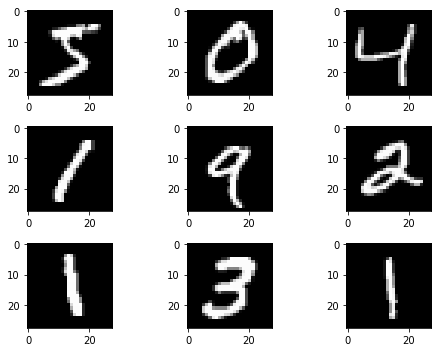

In [20]:
#Load the data
x_test, x_train, y_test, y_train = load_data()

plt.figure(figsize=(7,5))

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(np.squeeze(x_train)[i], cmap=plt.get_cmap('gray'))
plt.tight_layout()
plt.show()

In [2]:
#function to instantiate the tuner classes (here, we are making a comparition between the three available 
#keras-tuner classes: RandomSearch, Hyperband and BayesianOptimization).
def tuners_choice(hypermodel, directory, project_name):
    random_tuner = RandomSearch(
        hypermodel,
        objective="val_accuracy",
        seed=SEED,
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTION_PER_TRIAL,
        directory=f"{directory}_random_search",
        project_name=project_name,
    )
    hyperband_tuner = Hyperband(
        hypermodel,
        max_epochs=HYPERBAND_MAX_EPOCHS,
        objective="val_accuracy",
        seed=SEED,
        executions_per_trial=EXECUTION_PER_TRIAL,
        directory=f"{directory}_hyperband",
        project_name=project_name,
    )
    bayesian_tuner = BayesianOptimization(
        hypermodel,
        objective='val_accuracy',
        seed=SEED,
        num_initial_points=BAYESIAN_NUM_INITIAL_POINTS,
        max_trials=MAX_TRIALS,
        directory=f"{directory}_bayesian",
        project_name=project_name
    )
    return  [random_tuner, hyperband_tuner, bayesian_tuner]

In [3]:
# setting up as much GPUs as you please/have in your machine/server.
os.environ["CUDA_VISIBLE_DEVICES"]= "1,2,5"
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [4]:
def tuner_evaluation(tuner, x_test, x_train, y_test, y_train):

    tuner.search_space_summary()

    # Performs the hyperparameter tuning
    logger.info("Start hyperparameter tuning")
    search_start = time.time()
    tuner.search(x_train, y_train, epochs=N_EPOCH_SEARCH, validation_split=0.1)
    search_end = time.time()
    elapsed_time = search_end - search_start

    # Show a summary of the search
    tuner.results_summary()

    # Retrieve the best model.
    best_model = tuner.get_best_models(num_models=1)[0]

    # Evaluate the best model.
    loss, accuracy = best_model.evaluate(x_test, y_test)
    return elapsed_time, loss, accuracy

In [5]:
with strategy.scope():
    x_test, x_train, y_test, y_train = load_data()
    hypermodel = SearchModel(shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
    output_dir = Path("./output/")
    tuners = tuners_choice(hypermodel, directory=output_dir, project_name="cnn_tuning")
    
    results = []
    for tuner in tuners:
        elapsed_time, loss, accuracy = tuner_evaluation(
            tuner, x_test, x_train, y_test, y_train
        )
        logger.info(
            f"Elapsed time = {elapsed_time:10.4f} s, accuracy = {accuracy}, loss = {loss}"
        )
        results.append([elapsed_time, loss, accuracy])
        
    logger.info(results)

INFO:tensorflow:Reloading Oracle from existing project output_random_search/cnn_tuning/oracle.json


2021-05-05 13:13:25.261 | INFO     | __main__:tuner_evaluation:6 - Start hyperparameter tuning


Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 1:10:03 - loss: 2.3223 - accuracy: 0.031 - ETA: 2:11 - loss: 2.3069 - accuracy: 0.1133  - ETA: 1:06 - loss: 2.3057 - accuracy: 0.11 - ETA: 44s - loss: 2.3009 - accuracy: 0.1224 - ETA: 33s - loss: 2.2981 - accuracy: 0.129 - ETA: 26s - loss: 2.2943 - accuracy: 0.135 - ETA: 22s - loss: 2.2920 - accuracy: 0.138 - ETA: 18s - loss: 2.2890 - accuracy: 0.145 - ETA: 16s - loss: 2.2866 - accuracy: 0.150 - ETA: 14s - loss: 2.2824 - accuracy: 0.156 - ETA: 13s - loss: 2.2801 - accuracy: 0.160 - ETA: 12s - loss: 2.2773 - accuracy: 0.162 - ETA: 11s - loss: 2.2765 - accuracy: 0.164 - ETA: 10s - loss: 2.2734 - accuracy: 0.167 - ETA: 9s - loss: 2.2706 - accuracy: 0.170 - ETA: 9s - loss: 2.2677 - accuracy: 0.17 - ETA: 8s - loss: 2.2659 - accuracy: 0.17 - ETA: 8s - loss: 2.2629 - accuracy: 0.18 - ETA: 7s - loss: 2.2591 - accuracy: 0.18 - ETA: 7s - loss: 2.2561 - accuracy: 0.18 - ETA: 6s - loss: 

Epoch 6/15
54000/54000 [==============================] - ETA: 5s - loss: 0.1772 - accuracy: 0.93 - ETA: 2s - loss: 0.2234 - accuracy: 0.93 - ETA: 2s - loss: 0.2147 - accuracy: 0.93 - ETA: 2s - loss: 0.2248 - accuracy: 0.93 - ETA: 2s - loss: 0.2271 - accuracy: 0.93 - ETA: 2s - loss: 0.2268 - accuracy: 0.93 - ETA: 2s - loss: 0.2245 - accuracy: 0.93 - ETA: 2s - loss: 0.2217 - accuracy: 0.93 - ETA: 2s - loss: 0.2163 - accuracy: 0.93 - ETA: 2s - loss: 0.2132 - accuracy: 0.93 - ETA: 2s - loss: 0.2100 - accuracy: 0.93 - ETA: 2s - loss: 0.2088 - accuracy: 0.93 - ETA: 2s - loss: 0.2065 - accuracy: 0.93 - ETA: 2s - loss: 0.2074 - accuracy: 0.93 - ETA: 2s - loss: 0.2051 - accuracy: 0.93 - ETA: 2s - loss: 0.2058 - accuracy: 0.93 - ETA: 1s - loss: 0.2062 - accuracy: 0.93 - ETA: 1s - loss: 0.2076 - accuracy: 0.93 - ETA: 1s - loss: 0.2063 - accuracy: 0.93 - ETA: 1s - loss: 0.2074 - accuracy: 0.93 - ETA: 1s - loss: 0.2103 - accuracy: 0.93 - ETA: 1s - loss: 0.2108 - accuracy: 0.93 - ETA: 1s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.0821 - accuracy: 0.93 - ETA: 2s - loss: 0.1542 - accuracy: 0.95 - ETA: 2s - loss: 0.1470 - accuracy: 0.95 - ETA: 2s - loss: 0.1441 - accuracy: 0.95 - ETA: 2s - loss: 0.1391 - accuracy: 0.96 - ETA: 2s - loss: 0.1415 - accuracy: 0.95 - ETA: 2s - loss: 0.1416 - accuracy: 0.96 - ETA: 2s - loss: 0.1327 - accuracy: 0.96 - ETA: 2s - loss: 0.1302 - accuracy: 0.96 - ETA: 2s - loss: 0.1319 - accuracy: 0.96 - ETA: 2s - loss: 0.1353 - accuracy: 0.96 - ETA: 2s - loss: 0.1379 - accuracy: 0.96 - ETA: 2s - loss: 0.1363 - accuracy: 0.96 - ETA: 2s - loss: 0.1380 - accuracy: 0.96 - ETA: 2s - loss: 0.1350 - accuracy: 0.96 - ETA: 2s - loss: 0.1357 - accuracy: 0.96 - ETA: 2s - loss: 0.1364 - accuracy: 0.96 - ETA: 2s - loss: 0.1378 - accuracy: 0.95 - ETA: 2s - loss: 0.1365 - accuracy: 0.96 - ETA: 2s - loss: 0.1369 - accuracy: 0.96 - ETA: 2s - loss: 0.1372 - accuracy: 0.95 - ETA: 2s - loss: 0.1372 - accuracy: 0.96 - ETA: 1s - loss: 0.1375 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.3106 - accuracy: 0.90 - ETA: 2s - loss: 0.5430 - accuracy: 0.83 - ETA: 2s - loss: 0.5468 - accuracy: 0.83 - ETA: 2s - loss: 0.5337 - accuracy: 0.84 - ETA: 2s - loss: 0.5384 - accuracy: 0.83 - ETA: 2s - loss: 0.5327 - accuracy: 0.83 - ETA: 2s - loss: 0.5279 - accuracy: 0.84 - ETA: 2s - loss: 0.5199 - accuracy: 0.84 - ETA: 2s - loss: 0.5200 - accuracy: 0.84 - ETA: 2s - loss: 0.5149 - accuracy: 0.84 - ETA: 2s - loss: 0.5097 - accuracy: 0.84 - ETA: 2s - loss: 0.5104 - accuracy: 0.84 - ETA: 2s - loss: 0.5044 - accuracy: 0.84 - ETA: 2s - loss: 0.5049 - accuracy: 0.84 - ETA: 2s - loss: 0.4985 - accuracy: 0.85 - ETA: 2s - loss: 0.4988 - accuracy: 0.85 - ETA: 2s - loss: 0.4974 - accuracy: 0.85 - ETA: 2s - loss: 0.4946 - accuracy: 0.85 - ETA: 2s - loss: 0.4924 - accuracy: 0.85 - ETA: 2s - loss: 0.4894 - accuracy: 0.85 - ETA: 2s - loss: 0.4883 - accuracy: 0.85 - ETA: 1s - loss: 0.4861 - accuracy: 0.85 - ETA: 1s - loss: 0.4842 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1244 - accuracy: 0.93 - ETA: 3s - loss: 0.1780 - accuracy: 0.94 - ETA: 2s - loss: 0.1594 - accuracy: 0.95 - ETA: 3s - loss: 0.1625 - accuracy: 0.95 - ETA: 3s - loss: 0.1674 - accuracy: 0.95 - ETA: 3s - loss: 0.1699 - accuracy: 0.94 - ETA: 2s - loss: 0.1772 - accuracy: 0.94 - ETA: 2s - loss: 0.1782 - accuracy: 0.94 - ETA: 2s - loss: 0.1734 - accuracy: 0.94 - ETA: 2s - loss: 0.1738 - accuracy: 0.94 - ETA: 2s - loss: 0.1773 - accuracy: 0.94 - ETA: 2s - loss: 0.1776 - accuracy: 0.94 - ETA: 2s - loss: 0.1748 - accuracy: 0.94 - ETA: 2s - loss: 0.1736 - accuracy: 0.94 - ETA: 2s - loss: 0.1761 - accuracy: 0.94 - ETA: 2s - loss: 0.1778 - accuracy: 0.94 - ETA: 2s - loss: 0.1788 - accuracy: 0.94 - ETA: 2s - loss: 0.1776 - accuracy: 0.94 - ETA: 2s - loss: 0.1785 - accuracy: 0.94 - ETA: 1s - loss: 0.1777 - accuracy: 0.94 - ETA: 1s - loss: 0.1770 - accuracy: 0.94 - ETA: 1s - loss: 0.1747 - accuracy: 0.94 - ETA: 1s - loss: 0.1734 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1230 - accuracy: 0.93 - ETA: 3s - loss: 0.1452 - accuracy: 0.95 - ETA: 3s - loss: 0.1294 - accuracy: 0.95 - ETA: 3s - loss: 0.1302 - accuracy: 0.95 - ETA: 3s - loss: 0.1250 - accuracy: 0.96 - ETA: 3s - loss: 0.1267 - accuracy: 0.96 - ETA: 3s - loss: 0.1232 - accuracy: 0.96 - ETA: 2s - loss: 0.1211 - accuracy: 0.96 - ETA: 2s - loss: 0.1232 - accuracy: 0.96 - ETA: 2s - loss: 0.1247 - accuracy: 0.96 - ETA: 2s - loss: 0.1266 - accuracy: 0.96 - ETA: 2s - loss: 0.1265 - accuracy: 0.96 - ETA: 2s - loss: 0.1234 - accuracy: 0.96 - ETA: 2s - loss: 0.1254 - accuracy: 0.96 - ETA: 2s - loss: 0.1252 - accuracy: 0.96 - ETA: 2s - loss: 0.1266 - accuracy: 0.96 - ETA: 2s - loss: 0.1244 - accuracy: 0.96 - ETA: 2s - loss: 0.1273 - accuracy: 0.96 - ETA: 2s - loss: 0.1297 - accuracy: 0.96 - ETA: 2s - loss: 0.1289 - accuracy: 0.96 - ETA: 2s - loss: 0.1307 - accuracy: 0.96 - ETA: 2s - loss: 0.1328 - accuracy: 0.96 - ETA: 2s - loss: 0.1326 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:28 - loss: 2.3374 - accuracy: 0.09 - ETA: 20s - loss: 2.3211 - accuracy: 0.0938 - ETA: 12s - loss: 2.3135 - accuracy: 0.097 - ETA: 8s - loss: 2.3117 - accuracy: 0.099 - ETA: 7s - loss: 2.3095 - accuracy: 0.10 - ETA: 6s - loss: 2.3072 - accuracy: 0.10 - ETA: 5s - loss: 2.3047 - accuracy: 0.11 - ETA: 5s - loss: 2.3015 - accuracy: 0.11 - ETA: 4s - loss: 2.3004 - accuracy: 0.11 - ETA: 4s - loss: 2.2986 - accuracy: 0.11 - ETA: 4s - loss: 2.2961 - accuracy: 0.12 - ETA: 3s - loss: 2.2951 - accuracy: 0.12 - ETA: 3s - loss: 2.2936 - accuracy: 0.12 - ETA: 3s - loss: 2.2924 - accuracy: 0.12 - ETA: 3s - loss: 2.2906 - accuracy: 0.12 - ETA: 3s - loss: 2.2889 - accuracy: 0.12 - ETA: 3s - loss: 2.2872 - accuracy: 0.13 - ETA: 3s - loss: 2.2861 - accuracy: 0.13 - ETA: 3s - loss: 2.2850 - accuracy: 0.13 - ETA: 3s - loss: 2.2832 - accuracy: 0.13 - ETA: 2s - loss: 2.2817 - accuracy: 0.13 - ETA

54000/54000 [==============================] - ETA: 6s - loss: 0.1523 - accuracy: 1.00 - ETA: 3s - loss: 0.3315 - accuracy: 0.90 - ETA: 3s - loss: 0.3151 - accuracy: 0.90 - ETA: 3s - loss: 0.3093 - accuracy: 0.91 - ETA: 3s - loss: 0.3278 - accuracy: 0.90 - ETA: 3s - loss: 0.3217 - accuracy: 0.90 - ETA: 2s - loss: 0.3283 - accuracy: 0.90 - ETA: 2s - loss: 0.3272 - accuracy: 0.90 - ETA: 2s - loss: 0.3254 - accuracy: 0.90 - ETA: 2s - loss: 0.3260 - accuracy: 0.90 - ETA: 2s - loss: 0.3231 - accuracy: 0.90 - ETA: 2s - loss: 0.3239 - accuracy: 0.90 - ETA: 2s - loss: 0.3263 - accuracy: 0.90 - ETA: 2s - loss: 0.3241 - accuracy: 0.90 - ETA: 2s - loss: 0.3243 - accuracy: 0.90 - ETA: 2s - loss: 0.3233 - accuracy: 0.90 - ETA: 2s - loss: 0.3188 - accuracy: 0.90 - ETA: 2s - loss: 0.3196 - accuracy: 0.90 - ETA: 2s - loss: 0.3219 - accuracy: 0.90 - ETA: 2s - loss: 0.3224 - accuracy: 0.90 - ETA: 2s - loss: 0.3207 - accuracy: 0.90 - ETA: 2s - loss: 0.3204 - accuracy: 0.90 - ETA: 2s - loss: 0.3204 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0973 - accuracy: 0.93 - ETA: 3s - loss: 0.1829 - accuracy: 0.94 - ETA: 3s - loss: 0.1856 - accuracy: 0.94 - ETA: 2s - loss: 0.2006 - accuracy: 0.94 - ETA: 2s - loss: 0.2062 - accuracy: 0.93 - ETA: 2s - loss: 0.2054 - accuracy: 0.93 - ETA: 2s - loss: 0.2022 - accuracy: 0.93 - ETA: 2s - loss: 0.1982 - accuracy: 0.94 - ETA: 2s - loss: 0.1982 - accuracy: 0.93 - ETA: 2s - loss: 0.2006 - accuracy: 0.93 - ETA: 2s - loss: 0.1994 - accuracy: 0.93 - ETA: 2s - loss: 0.1990 - accuracy: 0.94 - ETA: 2s - loss: 0.2000 - accuracy: 0.94 - ETA: 2s - loss: 0.2001 - accuracy: 0.94 - ETA: 2s - loss: 0.2008 - accuracy: 0.93 - ETA: 2s - loss: 0.1987 - accuracy: 0.93 - ETA: 2s - loss: 0.1985 - accuracy: 0.94 - ETA: 2s - loss: 0.1982 - accuracy: 0.94 - ETA: 2s - loss: 0.1978 - accuracy: 0.94 - ETA: 2s - loss: 0.1971 - accuracy: 0.94 - ETA: 1s - loss: 0.1961 - accuracy: 0.94 - ETA: 1s - loss: 0.1962 - accuracy: 0.94 - ETA: 1s - loss: 0.1991 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1504 - accuracy: 0.93 - ETA: 2s - loss: 0.1635 - accuracy: 0.95 - ETA: 3s - loss: 0.1633 - accuracy: 0.95 - ETA: 3s - loss: 0.1525 - accuracy: 0.95 - ETA: 3s - loss: 0.1547 - accuracy: 0.95 - ETA: 3s - loss: 0.1515 - accuracy: 0.95 - ETA: 3s - loss: 0.1476 - accuracy: 0.95 - ETA: 3s - loss: 0.1461 - accuracy: 0.95 - ETA: 2s - loss: 0.1439 - accuracy: 0.95 - ETA: 2s - loss: 0.1426 - accuracy: 0.95 - ETA: 2s - loss: 0.1446 - accuracy: 0.95 - ETA: 2s - loss: 0.1463 - accuracy: 0.95 - ETA: 2s - loss: 0.1448 - accuracy: 0.95 - ETA: 2s - loss: 0.1459 - accuracy: 0.95 - ETA: 2s - loss: 0.1484 - accuracy: 0.95 - ETA: 2s - loss: 0.1494 - accuracy: 0.95 - ETA: 2s - loss: 0.1491 - accuracy: 0.95 - ETA: 2s - loss: 0.1483 - accuracy: 0.95 - ETA: 2s - loss: 0.1466 - accuracy: 0.95 - ETA: 2s - loss: 0.1460 - accuracy: 0.95 - ETA: 2s - loss: 0.1448 - accuracy: 0.95 - ETA: 2s - loss: 0.1462 - accuracy: 0.95 - ETA: 2s - loss: 0.1470 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.6268 - accuracy: 0.71 - ETA: 2s - loss: 0.4430 - accuracy: 0.85 - ETA: 2s - loss: 0.4341 - accuracy: 0.86 - ETA: 2s - loss: 0.4443 - accuracy: 0.86 - ETA: 2s - loss: 0.4380 - accuracy: 0.86 - ETA: 2s - loss: 0.4333 - accuracy: 0.86 - ETA: 2s - loss: 0.4412 - accuracy: 0.86 - ETA: 2s - loss: 0.4390 - accuracy: 0.86 - ETA: 2s - loss: 0.4348 - accuracy: 0.86 - ETA: 2s - loss: 0.4303 - accuracy: 0.86 - ETA: 2s - loss: 0.4277 - accuracy: 0.86 - ETA: 2s - loss: 0.4297 - accuracy: 0.86 - ETA: 2s - loss: 0.4278 - accuracy: 0.86 - ETA: 2s - loss: 0.4292 - accuracy: 0.86 - ETA: 2s - loss: 0.4243 - accuracy: 0.86 - ETA: 2s - loss: 0.4233 - accuracy: 0.86 - ETA: 2s - loss: 0.4208 - accuracy: 0.86 - ETA: 2s - loss: 0.4195 - accuracy: 0.86 - ETA: 2s - loss: 0.4175 - accuracy: 0.86 - ETA: 2s - loss: 0.4182 - accuracy: 0.87 - ETA: 2s - loss: 0.4138 - accuracy: 0.87 - ETA: 2s - loss: 0.4114 - accuracy: 0.87 - ETA: 2s - loss: 0.4106 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0742 - accuracy: 1.00 - ETA: 2s - loss: 0.2315 - accuracy: 0.92 - ETA: 2s - loss: 0.2280 - accuracy: 0.92 - ETA: 2s - loss: 0.2348 - accuracy: 0.92 - ETA: 2s - loss: 0.2444 - accuracy: 0.92 - ETA: 2s - loss: 0.2423 - accuracy: 0.92 - ETA: 2s - loss: 0.2389 - accuracy: 0.92 - ETA: 2s - loss: 0.2336 - accuracy: 0.92 - ETA: 2s - loss: 0.2336 - accuracy: 0.92 - ETA: 2s - loss: 0.2366 - accuracy: 0.92 - ETA: 2s - loss: 0.2351 - accuracy: 0.92 - ETA: 2s - loss: 0.2321 - accuracy: 0.92 - ETA: 2s - loss: 0.2315 - accuracy: 0.92 - ETA: 2s - loss: 0.2319 - accuracy: 0.92 - ETA: 2s - loss: 0.2312 - accuracy: 0.92 - ETA: 2s - loss: 0.2351 - accuracy: 0.92 - ETA: 2s - loss: 0.2361 - accuracy: 0.92 - ETA: 2s - loss: 0.2358 - accuracy: 0.92 - ETA: 1s - loss: 0.2376 - accuracy: 0.92 - ETA: 1s - loss: 0.2379 - accuracy: 0.92 - ETA: 1s - loss: 0.2370 - accuracy: 0.92 - ETA: 1s - loss: 0.2365 - accuracy: 0.92 - ETA: 1s - loss: 0.2354 - accu

Epoch 11/15
54000/54000 [==============================] - ETA: 4s - loss: 0.0889 - accuracy: 1.00 - ETA: 2s - loss: 0.2001 - accuracy: 0.93 - ETA: 2s - loss: 0.1924 - accuracy: 0.94 - ETA: 2s - loss: 0.1867 - accuracy: 0.94 - ETA: 2s - loss: 0.1867 - accuracy: 0.94 - ETA: 2s - loss: 0.1842 - accuracy: 0.94 - ETA: 2s - loss: 0.1871 - accuracy: 0.94 - ETA: 2s - loss: 0.1875 - accuracy: 0.94 - ETA: 2s - loss: 0.1881 - accuracy: 0.94 - ETA: 2s - loss: 0.1887 - accuracy: 0.94 - ETA: 2s - loss: 0.1926 - accuracy: 0.94 - ETA: 2s - loss: 0.1929 - accuracy: 0.94 - ETA: 2s - loss: 0.1919 - accuracy: 0.94 - ETA: 2s - loss: 0.1928 - accuracy: 0.94 - ETA: 2s - loss: 0.1942 - accuracy: 0.94 - ETA: 2s - loss: 0.1978 - accuracy: 0.94 - ETA: 2s - loss: 0.1996 - accuracy: 0.94 - ETA: 2s - loss: 0.1981 - accuracy: 0.94 - ETA: 2s - loss: 0.1989 - accuracy: 0.94 - ETA: 2s - loss: 0.1983 - accuracy: 0.94 - ETA: 2s - loss: 0.1987 - accuracy: 0.94 - ETA: 2s - loss: 0.1977 - accuracy: 0.94 - ETA: 2s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:51 - loss: 2.2880 - accuracy: 0.12 - ETA: 21s - loss: 2.3080 - accuracy: 0.1027 - ETA: 12s - loss: 2.3003 - accuracy: 0.114 - ETA: 9s - loss: 2.2948 - accuracy: 0.120 - ETA: 7s - loss: 2.2869 - accuracy: 0.14 - ETA: 6s - loss: 2.2772 - accuracy: 0.15 - ETA: 5s - loss: 2.2649 - accuracy: 0.17 - ETA: 5s - loss: 2.2488 - accuracy: 0.19 - ETA: 4s - loss: 2.2236 - accuracy: 0.21 - ETA: 4s - loss: 2.1834 - accuracy: 0.23 - ETA: 4s - loss: 2.1420 - accuracy: 0.25 - ETA: 4s - loss: 2.0791 - accuracy: 0.28 - ETA: 3s - loss: 2.0138 - accuracy: 0.30 - ETA: 3s - loss: 1.9328 - accuracy: 0.33 - ETA: 3s - loss: 1.8614 - accuracy: 0.36 - ETA: 3s - loss: 1.7914 - accuracy: 0.38 - ETA: 3s - loss: 1.7366 - accuracy: 0.40 - ETA: 3s - loss: 1.6814 - accuracy: 0.42 - ETA: 3s - loss: 1.6276 - accuracy: 0.44 - ETA: 2s - loss: 1.5759 - accuracy: 0.46 - ETA: 2s - loss: 1.5302 - accuracy: 0.48 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.1043 - accuracy: 0.96 - ETA: 3s - loss: 0.1233 - accuracy: 0.96 - ETA: 3s - loss: 0.0986 - accuracy: 0.97 - ETA: 3s - loss: 0.1220 - accuracy: 0.96 - ETA: 3s - loss: 0.1167 - accuracy: 0.96 - ETA: 3s - loss: 0.1139 - accuracy: 0.96 - ETA: 3s - loss: 0.1053 - accuracy: 0.96 - ETA: 3s - loss: 0.1016 - accuracy: 0.96 - ETA: 3s - loss: 0.1024 - accuracy: 0.96 - ETA: 3s - loss: 0.0974 - accuracy: 0.96 - ETA: 2s - loss: 0.0987 - accuracy: 0.96 - ETA: 2s - loss: 0.0992 - accuracy: 0.96 - ETA: 2s - loss: 0.0989 - accuracy: 0.96 - ETA: 2s - loss: 0.0987 - accuracy: 0.96 - ETA: 2s - loss: 0.0975 - accuracy: 0.96 - ETA: 2s - loss: 0.0953 - accuracy: 0.96 - ETA: 2s - loss: 0.0954 - accuracy: 0.96 - ETA: 2s - loss: 0.0938 - accuracy: 0.97 - ETA: 2s - loss: 0.0956 - accuracy: 0.96 - ETA: 2s - loss: 0.0965 - accuracy: 0.96 - ETA: 2s - loss: 0.0955 - accuracy: 0.96 - ETA: 2s - loss: 0.0960 - accuracy: 0.96 - ETA: 2s - loss: 0.0955 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0046 - accuracy: 1.00 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0453 - accuracy: 0.98 - ETA: 2s - loss: 0.0502 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0518 - accuracy: 0.98 - ETA: 2s - loss: 0.0548 - accuracy: 0.98 - ETA: 2s - loss: 0.0562 - accuracy: 0.98 - ETA: 2s - loss: 0.0560 - accuracy: 0.98 - ETA: 2s - loss: 0.0581 - accuracy: 0.98 - ETA: 2s - loss: 0.0594 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0588 - accuracy: 0.98 - ETA: 2s - loss: 0.0599 - accuracy: 0.98 - ETA: 2s - loss: 0.0599 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0622 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0635 - accuracy: 0.98 - ETA: 2s - loss: 0.0629 - accuracy: 0.98 - ETA: 2s - loss: 0.0634 - accuracy: 0.98 - ETA: 2s - loss: 0.0641 - accuracy: 0.98 - ETA: 2s - loss: 0.0644 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0208 - accuracy: 1.00 - ETA: 4s - loss: 0.0381 - accuracy: 0.98 - ETA: 3s - loss: 0.0467 - accuracy: 0.98 - ETA: 3s - loss: 0.0446 - accuracy: 0.98 - ETA: 3s - loss: 0.0500 - accuracy: 0.98 - ETA: 3s - loss: 0.0485 - accuracy: 0.98 - ETA: 3s - loss: 0.0497 - accuracy: 0.98 - ETA: 3s - loss: 0.0515 - accuracy: 0.98 - ETA: 3s - loss: 0.0544 - accuracy: 0.98 - ETA: 3s - loss: 0.0523 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0523 - accuracy: 0.98 - ETA: 2s - loss: 0.0527 - accuracy: 0.98 - ETA: 2s - loss: 0.0524 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0516 - accuracy: 0.98 - ETA: 2s - loss: 0.0508 - accuracy: 0.98 - ETA: 2s - loss: 0.0509 - accuracy: 0.98 - ETA: 2s - loss: 0.0510 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0503 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1935 - accuracy: 0.93 - ETA: 2s - loss: 0.1902 - accuracy: 0.93 - ETA: 2s - loss: 0.1933 - accuracy: 0.93 - ETA: 2s - loss: 0.2089 - accuracy: 0.93 - ETA: 2s - loss: 0.2152 - accuracy: 0.93 - ETA: 2s - loss: 0.2142 - accuracy: 0.93 - ETA: 2s - loss: 0.2050 - accuracy: 0.93 - ETA: 2s - loss: 0.2104 - accuracy: 0.93 - ETA: 2s - loss: 0.2109 - accuracy: 0.93 - ETA: 2s - loss: 0.2110 - accuracy: 0.93 - ETA: 2s - loss: 0.2068 - accuracy: 0.93 - ETA: 2s - loss: 0.2065 - accuracy: 0.93 - ETA: 2s - loss: 0.2056 - accuracy: 0.93 - ETA: 2s - loss: 0.2038 - accuracy: 0.93 - ETA: 2s - loss: 0.2052 - accuracy: 0.93 - ETA: 2s - loss: 0.2042 - accuracy: 0.93 - ETA: 2s - loss: 0.2050 - accuracy: 0.93 - ETA: 2s - loss: 0.2038 - accuracy: 0.93 - ETA: 2s - loss: 0.2023 - accuracy: 0.93 - ETA: 2s - loss: 0.2025 - accuracy: 0.93 - ETA: 2s - loss: 0.2018 - accuracy: 0.93 - ETA: 2s - loss: 0.2013 - accuracy: 0.93 - ETA: 2s - loss: 0.2002 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0226 - accuracy: 1.00 - ETA: 2s - loss: 0.1076 - accuracy: 0.96 - ETA: 2s - loss: 0.0924 - accuracy: 0.96 - ETA: 2s - loss: 0.0816 - accuracy: 0.97 - ETA: 2s - loss: 0.0799 - accuracy: 0.97 - ETA: 2s - loss: 0.0796 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0799 - accuracy: 0.97 - ETA: 2s - loss: 0.0785 - accuracy: 0.97 - ETA: 2s - loss: 0.0792 - accuracy: 0.97 - ETA: 2s - loss: 0.0788 - accuracy: 0.97 - ETA: 2s - loss: 0.0775 - accuracy: 0.97 - ETA: 2s - loss: 0.0775 - accuracy: 0.97 - ETA: 2s - loss: 0.0764 - accuracy: 0.97 - ETA: 2s - loss: 0.0779 - accuracy: 0.97 - ETA: 2s - loss: 0.0781 - accuracy: 0.97 - ETA: 2s - loss: 0.0782 - accuracy: 0.97 - ETA: 2s - loss: 0.0774 - accuracy: 0.97 - ETA: 2s - loss: 0.0760 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0766 - accuracy: 0.97 - ETA: 2s - loss: 0.0779 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0903 - accuracy: 0.96 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 3s - loss: 0.0640 - accuracy: 0.97 - ETA: 3s - loss: 0.0667 - accuracy: 0.97 - ETA: 3s - loss: 0.0646 - accuracy: 0.97 - ETA: 3s - loss: 0.0639 - accuracy: 0.97 - ETA: 3s - loss: 0.0620 - accuracy: 0.97 - ETA: 3s - loss: 0.0587 - accuracy: 0.98 - ETA: 3s - loss: 0.0576 - accuracy: 0.98 - ETA: 3s - loss: 0.0561 - accuracy: 0.98 - ETA: 3s - loss: 0.0566 - accuracy: 0.98 - ETA: 3s - loss: 0.0561 - accuracy: 0.98 - ETA: 2s - loss: 0.0554 - accuracy: 0.98 - ETA: 2s - loss: 0.0558 - accuracy: 0.98 - ETA: 2s - loss: 0.0560 - accuracy: 0.98 - ETA: 2s - loss: 0.0550 - accuracy: 0.98 - ETA: 2s - loss: 0.0549 - accuracy: 0.98 - ETA: 2s - loss: 0.0555 - accuracy: 0.98 - ETA: 2s - loss: 0.0544 - accuracy: 0.98 - ETA: 2s - loss: 0.0553 - accuracy: 0.98 - ETA: 2s - loss: 0.0563 - accuracy: 0.98 - ETA: 2s - loss: 0.0557 - accuracy: 0.98 - ETA: 2s - loss: 0.0553 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:48 - loss: 2.3498 - accuracy: 0.09 - ETA: 24s - loss: 2.3262 - accuracy: 0.1013 - ETA: 12s - loss: 2.3055 - accuracy: 0.099 - ETA: 8s - loss: 2.2925 - accuracy: 0.111 - ETA: 6s - loss: 2.2871 - accuracy: 0.11 - ETA: 5s - loss: 2.2785 - accuracy: 0.13 - ETA: 5s - loss: 2.2705 - accuracy: 0.14 - ETA: 4s - loss: 2.2604 - accuracy: 0.15 - ETA: 4s - loss: 2.2462 - accuracy: 0.17 - ETA: 4s - loss: 2.2283 - accuracy: 0.20 - ETA: 3s - loss: 2.2039 - accuracy: 0.23 - ETA: 3s - loss: 2.1739 - accuracy: 0.25 - ETA: 3s - loss: 2.1365 - accuracy: 0.27 - ETA: 3s - loss: 2.0923 - accuracy: 0.30 - ETA: 3s - loss: 2.0462 - accuracy: 0.32 - ETA: 3s - loss: 1.9931 - accuracy: 0.34 - ETA: 3s - loss: 1.9342 - accuracy: 0.36 - ETA: 2s - loss: 1.8794 - accuracy: 0.38 - ETA: 2s - loss: 1.8196 - accuracy: 0.40 - ETA: 2s - loss: 1.7615 - accuracy: 0.42 - ETA: 2s - loss: 1.7058 - accuracy: 0.44 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.2552 - accuracy: 0.93 - ETA: 3s - loss: 0.1165 - accuracy: 0.96 - ETA: 2s - loss: 0.1119 - accuracy: 0.97 - ETA: 2s - loss: 0.1100 - accuracy: 0.96 - ETA: 2s - loss: 0.0997 - accuracy: 0.97 - ETA: 2s - loss: 0.1011 - accuracy: 0.96 - ETA: 2s - loss: 0.0950 - accuracy: 0.97 - ETA: 2s - loss: 0.1000 - accuracy: 0.96 - ETA: 2s - loss: 0.1029 - accuracy: 0.96 - ETA: 2s - loss: 0.1038 - accuracy: 0.96 - ETA: 2s - loss: 0.1046 - accuracy: 0.96 - ETA: 2s - loss: 0.1035 - accuracy: 0.96 - ETA: 2s - loss: 0.1023 - accuracy: 0.96 - ETA: 2s - loss: 0.0999 - accuracy: 0.96 - ETA: 2s - loss: 0.0992 - accuracy: 0.97 - ETA: 2s - loss: 0.1013 - accuracy: 0.96 - ETA: 2s - loss: 0.1011 - accuracy: 0.96 - ETA: 2s - loss: 0.1023 - accuracy: 0.96 - ETA: 2s - loss: 0.1009 - accuracy: 0.96 - ETA: 2s - loss: 0.1009 - accuracy: 0.96 - ETA: 2s - loss: 0.1015 - accuracy: 0.96 - ETA: 2s - loss: 0.1012 - accuracy: 0.96 - ETA: 2s - loss: 0.1005 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0184 - accuracy: 1.00 - ETA: 2s - loss: 0.0537 - accuracy: 0.98 - ETA: 2s - loss: 0.0574 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0520 - accuracy: 0.98 - ETA: 2s - loss: 0.0552 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0572 - accuracy: 0.98 - ETA: 2s - loss: 0.0594 - accuracy: 0.98 - ETA: 2s - loss: 0.0576 - accuracy: 0.98 - ETA: 2s - loss: 0.0578 - accuracy: 0.98 - ETA: 2s - loss: 0.0588 - accuracy: 0.98 - ETA: 2s - loss: 0.0594 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 1s - loss: 0.0607 - accuracy: 0.98 - ETA: 1s - loss: 0.0617 - accuracy: 0.98 - ETA: 1s - loss: 0.0617 - accuracy: 0.98 - ETA: 1s - loss: 0.0606 - accuracy: 0.98 - ETA: 1s - loss: 0.0616 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2896 - accuracy: 0.93 - ETA: 3s - loss: 0.0680 - accuracy: 0.97 - ETA: 3s - loss: 0.0539 - accuracy: 0.98 - ETA: 3s - loss: 0.0525 - accuracy: 0.98 - ETA: 2s - loss: 0.0518 - accuracy: 0.98 - ETA: 2s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0527 - accuracy: 0.98 - ETA: 2s - loss: 0.0537 - accuracy: 0.98 - ETA: 2s - loss: 0.0520 - accuracy: 0.98 - ETA: 2s - loss: 0.0522 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0521 - accuracy: 0.98 - ETA: 2s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0505 - accuracy: 0.98 - ETA: 2s - loss: 0.0505 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0519 - accuracy: 0.98 - ETA: 2s - loss: 0.0510 - accuracy: 0.98 - ETA: 2s - loss: 0.0505 - accuracy: 0.98 - ETA: 2s - loss: 0.0503 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1326 - accuracy: 0.96 - ETA: 3s - loss: 0.1157 - accuracy: 0.96 - ETA: 3s - loss: 0.1314 - accuracy: 0.95 - ETA: 3s - loss: 0.1290 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - accuracy: 0.95 - ETA: 2s - loss: 0.1311 - accuracy: 0.95 - ETA: 2s - loss: 0.1285 - accuracy: 0.95 - ETA: 2s - loss: 0.1248 - accuracy: 0.96 - ETA: 2s - loss: 0.1219 - accuracy: 0.96 - ETA: 2s - loss: 0.1198 - accuracy: 0.96 - ETA: 2s - loss: 0.1209 - accuracy: 0.96 - ETA: 2s - loss: 0.1225 - accuracy: 0.96 - ETA: 2s - loss: 0.1244 - accuracy: 0.96 - ETA: 2s - loss: 0.1239 - accuracy: 0.96 - ETA: 2s - loss: 0.1247 - accuracy: 0.96 - ETA: 2s - loss: 0.1259 - accuracy: 0.96 - ETA: 2s - loss: 0.1256 - accuracy: 0.96 - ETA: 2s - loss: 0.1251 - accuracy: 0.96 - ETA: 2s - loss: 0.1237 - accuracy: 0.96 - ETA: 2s - loss: 0.1234 - accuracy: 0.96 - ETA: 2s - loss: 0.1231 - accuracy: 0.96 - ETA: 2s - loss: 0.1234 - accuracy: 0.96 - ETA: 2s - loss: 0.1236 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0191 - accuracy: 1.00 - ETA: 2s - loss: 0.0817 - accuracy: 0.97 - ETA: 2s - loss: 0.0807 - accuracy: 0.97 - ETA: 2s - loss: 0.0775 - accuracy: 0.97 - ETA: 2s - loss: 0.0759 - accuracy: 0.97 - ETA: 2s - loss: 0.0751 - accuracy: 0.97 - ETA: 2s - loss: 0.0694 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0706 - accuracy: 0.97 - ETA: 2s - loss: 0.0690 - accuracy: 0.97 - ETA: 2s - loss: 0.0696 - accuracy: 0.97 - ETA: 2s - loss: 0.0709 - accuracy: 0.97 - ETA: 2s - loss: 0.0703 - accuracy: 0.97 - ETA: 2s - loss: 0.0718 - accuracy: 0.97 - ETA: 2s - loss: 0.0725 - accuracy: 0.97 - ETA: 2s - loss: 0.0709 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 1s - loss: 0.0702 - accuracy: 0.97 - ETA: 1s - loss: 0.0709 - accuracy: 0.97 - ETA: 1s - loss: 0.0698 - accuracy: 0.97 - ETA: 1s - loss: 0.0698 - accuracy: 0.97 - ETA: 1s - loss: 0.0709 - accu

Epoch 13/15
54000/54000 [==============================] - ETA: 4s - loss: 0.0464 - accuracy: 1.00 - ETA: 3s - loss: 0.0426 - accuracy: 0.98 - ETA: 3s - loss: 0.0391 - accuracy: 0.98 - ETA: 3s - loss: 0.0451 - accuracy: 0.98 - ETA: 3s - loss: 0.0483 - accuracy: 0.98 - ETA: 3s - loss: 0.0556 - accuracy: 0.98 - ETA: 3s - loss: 0.0553 - accuracy: 0.98 - ETA: 3s - loss: 0.0542 - accuracy: 0.98 - ETA: 3s - loss: 0.0546 - accuracy: 0.98 - ETA: 2s - loss: 0.0541 - accuracy: 0.98 - ETA: 2s - loss: 0.0547 - accuracy: 0.98 - ETA: 2s - loss: 0.0556 - accuracy: 0.98 - ETA: 2s - loss: 0.0551 - accuracy: 0.98 - ETA: 2s - loss: 0.0568 - accuracy: 0.98 - ETA: 2s - loss: 0.0583 - accuracy: 0.98 - ETA: 2s - loss: 0.0587 - accuracy: 0.98 - ETA: 2s - loss: 0.0590 - accuracy: 0.98 - ETA: 2s - loss: 0.0589 - accuracy: 0.98 - ETA: 2s - loss: 0.0576 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0.0576 - accuracy: 0.98 - ETA: 2s - loss: 0.0573 - accuracy: 0.98 - ETA: 2s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:10 - loss: 2.3423 - accuracy: 0.03 - ETA: 18s - loss: 2.3113 - accuracy: 0.0698 - ETA: 10s - loss: 2.3070 - accuracy: 0.085 - ETA: 7s - loss: 2.3038 - accuracy: 0.100 - ETA: 6s - loss: 2.3006 - accuracy: 0.11 - ETA: 5s - loss: 2.2981 - accuracy: 0.12 - ETA: 4s - loss: 2.2960 - accuracy: 0.13 - ETA: 4s - loss: 2.2933 - accuracy: 0.13 - ETA: 4s - loss: 2.2915 - accuracy: 0.14 - ETA: 3s - loss: 2.2895 - accuracy: 0.14 - ETA: 3s - loss: 2.2872 - accuracy: 0.15 - ETA: 3s - loss: 2.2852 - accuracy: 0.16 - ETA: 3s - loss: 2.2824 - accuracy: 0.17 - ETA: 3s - loss: 2.2795 - accuracy: 0.17 - ETA: 3s - loss: 2.2772 - accuracy: 0.18 - ETA: 3s - loss: 2.2746 - accuracy: 0.19 - ETA: 2s - loss: 2.2722 - accuracy: 0.19 - ETA: 2s - loss: 2.2698 - accuracy: 0.20 - ETA: 2s - loss: 2.2667 - accuracy: 0.21 - ETA: 2s - loss: 2.2631 - accuracy: 0.22 - ETA: 2s - loss: 2.2588 - accuracy: 0.23 - ETA

Epoch 7/15
54000/54000 [==============================] - ETA: 4s - loss: 0.2181 - accuracy: 0.93 - ETA: 2s - loss: 0.1570 - accuracy: 0.94 - ETA: 3s - loss: 0.1434 - accuracy: 0.95 - ETA: 3s - loss: 0.1516 - accuracy: 0.95 - ETA: 3s - loss: 0.1465 - accuracy: 0.95 - ETA: 3s - loss: 0.1445 - accuracy: 0.95 - ETA: 2s - loss: 0.1532 - accuracy: 0.95 - ETA: 2s - loss: 0.1522 - accuracy: 0.95 - ETA: 2s - loss: 0.1538 - accuracy: 0.95 - ETA: 2s - loss: 0.1483 - accuracy: 0.95 - ETA: 2s - loss: 0.1502 - accuracy: 0.95 - ETA: 2s - loss: 0.1513 - accuracy: 0.95 - ETA: 2s - loss: 0.1502 - accuracy: 0.95 - ETA: 2s - loss: 0.1532 - accuracy: 0.95 - ETA: 2s - loss: 0.1498 - accuracy: 0.95 - ETA: 2s - loss: 0.1501 - accuracy: 0.95 - ETA: 2s - loss: 0.1496 - accuracy: 0.95 - ETA: 2s - loss: 0.1490 - accuracy: 0.95 - ETA: 2s - loss: 0.1491 - accuracy: 0.95 - ETA: 2s - loss: 0.1494 - accuracy: 0.95 - ETA: 2s - loss: 0.1501 - accuracy: 0.95 - ETA: 1s - loss: 0.1515 - accuracy: 0.95 - ETA: 1s - loss: 0.

54000/54000 [==============================] - ETA: 5s - loss: 0.1247 - accuracy: 0.96 - ETA: 4s - loss: 0.0867 - accuracy: 0.97 - ETA: 4s - loss: 0.1074 - accuracy: 0.96 - ETA: 3s - loss: 0.1050 - accuracy: 0.96 - ETA: 3s - loss: 0.1058 - accuracy: 0.96 - ETA: 3s - loss: 0.1011 - accuracy: 0.96 - ETA: 3s - loss: 0.1004 - accuracy: 0.96 - ETA: 3s - loss: 0.1060 - accuracy: 0.96 - ETA: 3s - loss: 0.1050 - accuracy: 0.96 - ETA: 2s - loss: 0.1035 - accuracy: 0.96 - ETA: 2s - loss: 0.1078 - accuracy: 0.96 - ETA: 2s - loss: 0.1068 - accuracy: 0.96 - ETA: 2s - loss: 0.1069 - accuracy: 0.96 - ETA: 2s - loss: 0.1106 - accuracy: 0.96 - ETA: 2s - loss: 0.1113 - accuracy: 0.96 - ETA: 2s - loss: 0.1129 - accuracy: 0.96 - ETA: 2s - loss: 0.1133 - accuracy: 0.96 - ETA: 2s - loss: 0.1131 - accuracy: 0.96 - ETA: 2s - loss: 0.1147 - accuracy: 0.96 - ETA: 2s - loss: 0.1136 - accuracy: 0.96 - ETA: 2s - loss: 0.1139 - accuracy: 0.96 - ETA: 2s - loss: 0.1140 - accuracy: 0.96 - ETA: 2s - loss: 0.1153 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 7:59 - loss: 2.2536 - accuracy: 0.25 - ETA: 19s - loss: 2.3103 - accuracy: 0.1395 - ETA: 13s - loss: 2.3047 - accuracy: 0.140 - ETA: 9s - loss: 2.3008 - accuracy: 0.140 - ETA: 7s - loss: 2.2952 - accuracy: 0.14 - ETA: 6s - loss: 2.2918 - accuracy: 0.14 - ETA: 5s - loss: 2.2877 - accuracy: 0.14 - ETA: 5s - loss: 2.2846 - accuracy: 0.15 - ETA: 4s - loss: 2.2818 - accuracy: 0.16 - ETA: 4s - loss: 2.2786 - accuracy: 0.16 - ETA: 4s - loss: 2.2756 - accuracy: 0.17 - ETA: 4s - loss: 2.2720 - accuracy: 0.18 - ETA: 3s - loss: 2.2683 - accuracy: 0.18 - ETA: 3s - loss: 2.2650 - accuracy: 0.19 - ETA: 3s - loss: 2.2611 - accuracy: 0.20 - ETA: 3s - loss: 2.2580 - accuracy: 0.21 - ETA: 3s - loss: 2.2553 - accuracy: 0.21 - ETA: 3s - loss: 2.2503 - accuracy: 0.22 - ETA: 3s - loss: 2.2456 - accuracy: 0.23 - ETA: 3s - loss: 2.2406 - accuracy: 0.23 - ETA: 2s - loss: 2.2346 - accuracy: 0.24 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.1233 - accuracy: 0.90 - ETA: 2s - loss: 0.1461 - accuracy: 0.94 - ETA: 2s - loss: 0.1500 - accuracy: 0.94 - ETA: 2s - loss: 0.1589 - accuracy: 0.94 - ETA: 2s - loss: 0.1677 - accuracy: 0.94 - ETA: 2s - loss: 0.1639 - accuracy: 0.94 - ETA: 2s - loss: 0.1637 - accuracy: 0.94 - ETA: 2s - loss: 0.1681 - accuracy: 0.94 - ETA: 2s - loss: 0.1685 - accuracy: 0.94 - ETA: 2s - loss: 0.1675 - accuracy: 0.94 - ETA: 2s - loss: 0.1688 - accuracy: 0.94 - ETA: 2s - loss: 0.1673 - accuracy: 0.94 - ETA: 2s - loss: 0.1662 - accuracy: 0.94 - ETA: 2s - loss: 0.1660 - accuracy: 0.94 - ETA: 2s - loss: 0.1654 - accuracy: 0.94 - ETA: 2s - loss: 0.1646 - accuracy: 0.94 - ETA: 1s - loss: 0.1646 - accuracy: 0.94 - ETA: 1s - loss: 0.1650 - accuracy: 0.94 - ETA: 1s - loss: 0.1680 - accuracy: 0.94 - ETA: 1s - loss: 0.1662 - accuracy: 0.94 - ETA: 1s - loss: 0.1663 - accuracy: 0.94 - ETA: 1s - loss: 0.1650 - accuracy: 0.94 - ETA: 1s - loss: 0.1658 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0372 - accuracy: 1.00 - ETA: 2s - loss: 0.1072 - accuracy: 0.96 - ETA: 2s - loss: 0.1076 - accuracy: 0.96 - ETA: 2s - loss: 0.1083 - accuracy: 0.96 - ETA: 2s - loss: 0.1065 - accuracy: 0.96 - ETA: 2s - loss: 0.1143 - accuracy: 0.96 - ETA: 2s - loss: 0.1180 - accuracy: 0.96 - ETA: 2s - loss: 0.1161 - accuracy: 0.96 - ETA: 2s - loss: 0.1180 - accuracy: 0.96 - ETA: 2s - loss: 0.1156 - accuracy: 0.96 - ETA: 2s - loss: 0.1167 - accuracy: 0.96 - ETA: 2s - loss: 0.1164 - accuracy: 0.96 - ETA: 2s - loss: 0.1163 - accuracy: 0.96 - ETA: 2s - loss: 0.1144 - accuracy: 0.96 - ETA: 2s - loss: 0.1116 - accuracy: 0.96 - ETA: 2s - loss: 0.1117 - accuracy: 0.96 - ETA: 2s - loss: 0.1094 - accuracy: 0.96 - ETA: 2s - loss: 0.1095 - accuracy: 0.96 - ETA: 2s - loss: 0.1083 - accuracy: 0.96 - ETA: 2s - loss: 0.1089 - accuracy: 0.96 - ETA: 2s - loss: 0.1083 - accuracy: 0.96 - ETA: 2s - loss: 0.1087 - accuracy: 0.96 - ETA: 2s - loss: 0.1087 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:08 - loss: 2.2897 - accuracy: 0.12 - ETA: 18s - loss: 2.3019 - accuracy: 0.1089 - ETA: 10s - loss: 2.2967 - accuracy: 0.116 - ETA: 8s - loss: 2.2864 - accuracy: 0.130 - ETA: 6s - loss: 2.2756 - accuracy: 0.14 - ETA: 5s - loss: 2.2637 - accuracy: 0.15 - ETA: 4s - loss: 2.2456 - accuracy: 0.18 - ETA: 4s - loss: 2.2253 - accuracy: 0.20 - ETA: 4s - loss: 2.1955 - accuracy: 0.22 - ETA: 3s - loss: 2.1537 - accuracy: 0.24 - ETA: 3s - loss: 2.1057 - accuracy: 0.26 - ETA: 3s - loss: 2.0382 - accuracy: 0.29 - ETA: 3s - loss: 1.9683 - accuracy: 0.32 - ETA: 3s - loss: 1.9020 - accuracy: 0.34 - ETA: 2s - loss: 1.8303 - accuracy: 0.37 - ETA: 2s - loss: 1.7692 - accuracy: 0.39 - ETA: 2s - loss: 1.7283 - accuracy: 0.40 - ETA: 2s - loss: 1.7160 - accuracy: 0.41 - ETA: 2s - loss: 1.6604 - accuracy: 0.43 - ETA: 2s - loss: 1.6066 - accuracy: 0.45 - ETA: 2s - loss: 1.5522 - accuracy: 0.47 - ETA

Epoch 6/15
54000/54000 [==============================] - ETA: 4s - loss: 0.0415 - accuracy: 1.00 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0.0793 - accuracy: 0.97 - ETA: 2s - loss: 0.0881 - accuracy: 0.97 - ETA: 2s - loss: 0.0861 - accuracy: 0.97 - ETA: 2s - loss: 0.0935 - accuracy: 0.97 - ETA: 2s - loss: 0.0961 - accuracy: 0.97 - ETA: 2s - loss: 0.0956 - accuracy: 0.97 - ETA: 2s - loss: 0.0956 - accuracy: 0.97 - ETA: 2s - loss: 0.0960 - accuracy: 0.97 - ETA: 2s - loss: 0.0994 - accuracy: 0.97 - ETA: 2s - loss: 0.0999 - accuracy: 0.97 - ETA: 2s - loss: 0.0986 - accuracy: 0.97 - ETA: 2s - loss: 0.0988 - accuracy: 0.97 - ETA: 2s - loss: 0.0988 - accuracy: 0.97 - ETA: 2s - loss: 0.0985 - accuracy: 0.97 - ETA: 2s - loss: 0.0998 - accuracy: 0.97 - ETA: 2s - loss: 0.1010 - accuracy: 0.97 - ETA: 2s - loss: 0.1025 - accuracy: 0.97 - ETA: 2s - loss: 0.1037 - accuracy: 0.97 - ETA: 2s - loss: 0.1040 - accuracy: 0.96 - ETA: 2s - loss: 0.1034 - accuracy: 0.96 - ETA: 2s - loss: 0.

Epoch 9/15
54000/54000 [==============================] - ETA: 4s - loss: 0.0689 - accuracy: 1.00 - ETA: 2s - loss: 0.0783 - accuracy: 0.97 - ETA: 3s - loss: 0.0679 - accuracy: 0.98 - ETA: 3s - loss: 0.0695 - accuracy: 0.97 - ETA: 2s - loss: 0.0674 - accuracy: 0.97 - ETA: 2s - loss: 0.0736 - accuracy: 0.97 - ETA: 2s - loss: 0.0711 - accuracy: 0.97 - ETA: 2s - loss: 0.0696 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0749 - accuracy: 0.97 - ETA: 2s - loss: 0.0725 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0711 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0705 - accuracy: 0.97 - ETA: 2s - loss: 0.0729 - accuracy: 0.97 - ETA: 2s - loss: 0.0730 - accuracy: 0.97 - ETA: 2s - loss: 0.0737 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0729 - accuracy: 0.97 - ETA: 2s - loss: 0.0727 - accuracy: 0.97 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 5s - loss: 0.0065 - accuracy: 1.00 - ETA: 4s - loss: 0.0559 - accuracy: 0.97 - ETA: 3s - loss: 0.0630 - accuracy: 0.97 - ETA: 3s - loss: 0.0598 - accuracy: 0.98 - ETA: 2s - loss: 0.0584 - accuracy: 0.98 - ETA: 2s - loss: 0.0558 - accuracy: 0.98 - ETA: 2s - loss: 0.0521 - accuracy: 0.98 - ETA: 2s - loss: 0.0543 - accuracy: 0.98 - ETA: 2s - loss: 0.0548 - accuracy: 0.98 - ETA: 2s - loss: 0.0556 - accuracy: 0.98 - ETA: 2s - loss: 0.0544 - accuracy: 0.98 - ETA: 2s - loss: 0.0560 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0572 - accuracy: 0.98 - ETA: 2s - loss: 0.0554 - accuracy: 0.98 - ETA: 2s - loss: 0.0552 - accuracy: 0.98 - ETA: 2s - loss: 0.0548 - accuracy: 0.98 - ETA: 2s - loss: 0.0547 - accuracy: 0.98 - ETA: 2s - loss: 0.0549 - accuracy: 0.98 - ETA: 2s - loss: 0.0551 - accuracy: 0.98 - ETA: 2s - loss: 0.0549 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.6199 - accuracy: 0.78 - ETA: 2s - loss: 0.5248 - accuracy: 0.84 - ETA: 2s - loss: 0.5254 - accuracy: 0.83 - ETA: 2s - loss: 0.5304 - accuracy: 0.83 - ETA: 2s - loss: 0.5353 - accuracy: 0.83 - ETA: 2s - loss: 0.5370 - accuracy: 0.82 - ETA: 2s - loss: 0.5357 - accuracy: 0.83 - ETA: 2s - loss: 0.5288 - accuracy: 0.83 - ETA: 2s - loss: 0.5284 - accuracy: 0.83 - ETA: 2s - loss: 0.5265 - accuracy: 0.83 - ETA: 2s - loss: 0.5198 - accuracy: 0.83 - ETA: 2s - loss: 0.5198 - accuracy: 0.83 - ETA: 2s - loss: 0.5198 - accuracy: 0.83 - ETA: 2s - loss: 0.5218 - accuracy: 0.83 - ETA: 2s - loss: 0.5197 - accuracy: 0.83 - ETA: 2s - loss: 0.5199 - accuracy: 0.83 - ETA: 2s - loss: 0.5188 - accuracy: 0.83 - ETA: 1s - loss: 0.5195 - accuracy: 0.83 - ETA: 1s - loss: 0.5190 - accuracy: 0.83 - ETA: 1s - loss: 0.5181 - accuracy: 0.83 - ETA: 1s - loss: 0.5162 - accuracy: 0.83 - ETA: 1s - loss: 0.5159 - accuracy: 0.83 - ETA: 1s - loss: 0.5141 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2805 - accuracy: 0.90 - ETA: 2s - loss: 0.3456 - accuracy: 0.89 - ETA: 2s - loss: 0.3442 - accuracy: 0.89 - ETA: 2s - loss: 0.3454 - accuracy: 0.89 - ETA: 2s - loss: 0.3444 - accuracy: 0.89 - ETA: 2s - loss: 0.3407 - accuracy: 0.89 - ETA: 2s - loss: 0.3390 - accuracy: 0.89 - ETA: 2s - loss: 0.3372 - accuracy: 0.89 - ETA: 2s - loss: 0.3375 - accuracy: 0.89 - ETA: 2s - loss: 0.3365 - accuracy: 0.89 - ETA: 2s - loss: 0.3387 - accuracy: 0.89 - ETA: 2s - loss: 0.3381 - accuracy: 0.89 - ETA: 2s - loss: 0.3389 - accuracy: 0.89 - ETA: 2s - loss: 0.3384 - accuracy: 0.89 - ETA: 2s - loss: 0.3383 - accuracy: 0.89 - ETA: 2s - loss: 0.3370 - accuracy: 0.89 - ETA: 2s - loss: 0.3375 - accuracy: 0.89 - ETA: 2s - loss: 0.3348 - accuracy: 0.89 - ETA: 2s - loss: 0.3339 - accuracy: 0.89 - ETA: 2s - loss: 0.3315 - accuracy: 0.89 - ETA: 1s - loss: 0.3321 - accuracy: 0.89 - ETA: 1s - loss: 0.3294 - accuracy: 0.89 - ETA: 1s - loss: 0.3297 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1510 - accuracy: 1.00 - ETA: 2s - loss: 0.2281 - accuracy: 0.92 - ETA: 2s - loss: 0.2197 - accuracy: 0.93 - ETA: 2s - loss: 0.2303 - accuracy: 0.93 - ETA: 2s - loss: 0.2350 - accuracy: 0.92 - ETA: 2s - loss: 0.2295 - accuracy: 0.93 - ETA: 2s - loss: 0.2360 - accuracy: 0.92 - ETA: 2s - loss: 0.2373 - accuracy: 0.92 - ETA: 2s - loss: 0.2400 - accuracy: 0.92 - ETA: 2s - loss: 0.2426 - accuracy: 0.92 - ETA: 2s - loss: 0.2440 - accuracy: 0.92 - ETA: 2s - loss: 0.2433 - accuracy: 0.92 - ETA: 2s - loss: 0.2454 - accuracy: 0.92 - ETA: 2s - loss: 0.2450 - accuracy: 0.92 - ETA: 2s - loss: 0.2478 - accuracy: 0.92 - ETA: 2s - loss: 0.2486 - accuracy: 0.92 - ETA: 2s - loss: 0.2487 - accuracy: 0.92 - ETA: 2s - loss: 0.2452 - accuracy: 0.92 - ETA: 2s - loss: 0.2457 - accuracy: 0.92 - ETA: 2s - loss: 0.2456 - accuracy: 0.92 - ETA: 2s - loss: 0.2463 - accuracy: 0.92 - ETA: 1s - loss: 0.2458 - accuracy: 0.92 - ETA: 1s - loss: 0.2465 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:35 - loss: 2.3674 - accuracy: 0.06 - ETA: 28s - loss: 2.3166 - accuracy: 0.1012 - ETA: 14s - loss: 2.3174 - accuracy: 0.098 - ETA: 10s - loss: 2.3190 - accuracy: 0.099 - ETA: 8s - loss: 2.3200 - accuracy: 0.099 - ETA: 6s - loss: 2.3162 - accuracy: 0.10 - ETA: 6s - loss: 2.3146 - accuracy: 0.10 - ETA: 5s - loss: 2.3137 - accuracy: 0.10 - ETA: 5s - loss: 2.3123 - accuracy: 0.10 - ETA: 4s - loss: 2.3120 - accuracy: 0.09 - ETA: 4s - loss: 2.3100 - accuracy: 0.10 - ETA: 4s - loss: 2.3097 - accuracy: 0.10 - ETA: 4s - loss: 2.3086 - accuracy: 0.09 - ETA: 3s - loss: 2.3078 - accuracy: 0.09 - ETA: 3s - loss: 2.3069 - accuracy: 0.09 - ETA: 3s - loss: 2.3059 - accuracy: 0.09 - ETA: 3s - loss: 2.3053 - accuracy: 0.09 - ETA: 3s - loss: 2.3043 - accuracy: 0.09 - ETA: 3s - loss: 2.3035 - accuracy: 0.10 - ETA: 3s - loss: 2.3031 - accuracy: 0.10 - ETA: 2s - loss: 2.3025 - accuracy: 0.10 - E

54000/54000 [==============================] - ETA: 5s - loss: 0.8076 - accuracy: 0.75 - ETA: 3s - loss: 0.6944 - accuracy: 0.77 - ETA: 3s - loss: 0.6948 - accuracy: 0.78 - ETA: 3s - loss: 0.6799 - accuracy: 0.78 - ETA: 3s - loss: 0.6775 - accuracy: 0.78 - ETA: 2s - loss: 0.6665 - accuracy: 0.78 - ETA: 3s - loss: 0.6650 - accuracy: 0.78 - ETA: 2s - loss: 0.6594 - accuracy: 0.78 - ETA: 2s - loss: 0.6579 - accuracy: 0.78 - ETA: 2s - loss: 0.6566 - accuracy: 0.78 - ETA: 2s - loss: 0.6532 - accuracy: 0.78 - ETA: 2s - loss: 0.6501 - accuracy: 0.79 - ETA: 2s - loss: 0.6461 - accuracy: 0.79 - ETA: 2s - loss: 0.6427 - accuracy: 0.79 - ETA: 2s - loss: 0.6410 - accuracy: 0.79 - ETA: 2s - loss: 0.6398 - accuracy: 0.79 - ETA: 2s - loss: 0.6404 - accuracy: 0.79 - ETA: 2s - loss: 0.6395 - accuracy: 0.79 - ETA: 2s - loss: 0.6372 - accuracy: 0.79 - ETA: 2s - loss: 0.6355 - accuracy: 0.79 - ETA: 2s - loss: 0.6333 - accuracy: 0.79 - ETA: 2s - loss: 0.6348 - accuracy: 0.79 - ETA: 2s - loss: 0.6353 - accu

Epoch 8/15
54000/54000 [==============================] - ETA: 4s - loss: 0.4279 - accuracy: 0.87 - ETA: 2s - loss: 0.3971 - accuracy: 0.87 - ETA: 2s - loss: 0.4155 - accuracy: 0.86 - ETA: 2s - loss: 0.3992 - accuracy: 0.87 - ETA: 2s - loss: 0.3937 - accuracy: 0.88 - ETA: 2s - loss: 0.3921 - accuracy: 0.88 - ETA: 2s - loss: 0.3927 - accuracy: 0.88 - ETA: 2s - loss: 0.3948 - accuracy: 0.88 - ETA: 2s - loss: 0.3973 - accuracy: 0.88 - ETA: 2s - loss: 0.3963 - accuracy: 0.88 - ETA: 2s - loss: 0.3920 - accuracy: 0.88 - ETA: 2s - loss: 0.3949 - accuracy: 0.88 - ETA: 2s - loss: 0.3959 - accuracy: 0.88 - ETA: 2s - loss: 0.3917 - accuracy: 0.88 - ETA: 2s - loss: 0.3926 - accuracy: 0.88 - ETA: 2s - loss: 0.3900 - accuracy: 0.88 - ETA: 2s - loss: 0.3894 - accuracy: 0.88 - ETA: 2s - loss: 0.3888 - accuracy: 0.88 - ETA: 2s - loss: 0.3883 - accuracy: 0.88 - ETA: 2s - loss: 0.3882 - accuracy: 0.88 - ETA: 1s - loss: 0.3881 - accuracy: 0.88 - ETA: 1s - loss: 0.3879 - accuracy: 0.88 - ETA: 1s - loss: 0.

54000/54000 [==============================] - ETA: 5s - loss: 0.5749 - accuracy: 0.90 - ETA: 3s - loss: 0.2678 - accuracy: 0.92 - ETA: 3s - loss: 0.2711 - accuracy: 0.91 - ETA: 2s - loss: 0.2732 - accuracy: 0.91 - ETA: 3s - loss: 0.2781 - accuracy: 0.91 - ETA: 3s - loss: 0.2694 - accuracy: 0.92 - ETA: 3s - loss: 0.2684 - accuracy: 0.91 - ETA: 3s - loss: 0.2676 - accuracy: 0.91 - ETA: 2s - loss: 0.2687 - accuracy: 0.91 - ETA: 2s - loss: 0.2781 - accuracy: 0.91 - ETA: 2s - loss: 0.2770 - accuracy: 0.91 - ETA: 2s - loss: 0.2777 - accuracy: 0.91 - ETA: 2s - loss: 0.2750 - accuracy: 0.91 - ETA: 2s - loss: 0.2805 - accuracy: 0.91 - ETA: 2s - loss: 0.2817 - accuracy: 0.91 - ETA: 2s - loss: 0.2818 - accuracy: 0.91 - ETA: 2s - loss: 0.2858 - accuracy: 0.91 - ETA: 2s - loss: 0.2852 - accuracy: 0.91 - ETA: 2s - loss: 0.2860 - accuracy: 0.91 - ETA: 2s - loss: 0.2845 - accuracy: 0.91 - ETA: 2s - loss: 0.2862 - accuracy: 0.91 - ETA: 2s - loss: 0.2865 - accuracy: 0.91 - ETA: 2s - loss: 0.2845 - accu

54000/54000 [==============================] - ETA: 8:35 - loss: 2.3689 - accuracy: 0.03 - ETA: 23s - loss: 2.3524 - accuracy: 0.0688 - ETA: 14s - loss: 2.3496 - accuracy: 0.072 - ETA: 10s - loss: 2.3427 - accuracy: 0.080 - ETA: 8s - loss: 2.3373 - accuracy: 0.088 - ETA: 7s - loss: 2.3351 - accuracy: 0.09 - ETA: 6s - loss: 2.3329 - accuracy: 0.09 - ETA: 5s - loss: 2.3308 - accuracy: 0.09 - ETA: 5s - loss: 2.3286 - accuracy: 0.09 - ETA: 4s - loss: 2.3260 - accuracy: 0.09 - ETA: 4s - loss: 2.3233 - accuracy: 0.09 - ETA: 4s - loss: 2.3219 - accuracy: 0.10 - ETA: 4s - loss: 2.3208 - accuracy: 0.10 - ETA: 3s - loss: 2.3197 - accuracy: 0.10 - ETA: 3s - loss: 2.3185 - accuracy: 0.10 - ETA: 3s - loss: 2.3171 - accuracy: 0.10 - ETA: 3s - loss: 2.3157 - accuracy: 0.10 - ETA: 3s - loss: 2.3144 - accuracy: 0.11 - ETA: 3s - loss: 2.3134 - accuracy: 0.11 - ETA: 3s - loss: 2.3126 - accuracy: 0.11 - ETA: 3s - loss: 2.3114 - accuracy: 0.11 - ETA: 2s - loss: 2.3102 - accuracy: 0.11 - ETA: 2s - loss: 2.3

Epoch 4/15
54000/54000 [==============================] - ETA: 5s - loss: 0.8098 - accuracy: 0.78 - ETA: 3s - loss: 1.0559 - accuracy: 0.69 - ETA: 2s - loss: 1.0246 - accuracy: 0.68 - ETA: 2s - loss: 1.0187 - accuracy: 0.68 - ETA: 2s - loss: 1.0056 - accuracy: 0.69 - ETA: 2s - loss: 0.9961 - accuracy: 0.69 - ETA: 2s - loss: 0.9915 - accuracy: 0.69 - ETA: 2s - loss: 0.9889 - accuracy: 0.69 - ETA: 2s - loss: 0.9852 - accuracy: 0.69 - ETA: 2s - loss: 0.9800 - accuracy: 0.69 - ETA: 2s - loss: 0.9779 - accuracy: 0.69 - ETA: 2s - loss: 0.9741 - accuracy: 0.69 - ETA: 2s - loss: 0.9715 - accuracy: 0.69 - ETA: 2s - loss: 0.9726 - accuracy: 0.69 - ETA: 2s - loss: 0.9638 - accuracy: 0.69 - ETA: 2s - loss: 0.9580 - accuracy: 0.69 - ETA: 2s - loss: 0.9559 - accuracy: 0.69 - ETA: 2s - loss: 0.9514 - accuracy: 0.70 - ETA: 1s - loss: 0.9474 - accuracy: 0.70 - ETA: 1s - loss: 0.9410 - accuracy: 0.70 - ETA: 1s - loss: 0.9385 - accuracy: 0.70 - ETA: 1s - loss: 0.9335 - accuracy: 0.70 - ETA: 1s - loss: 0.

54000/54000 [==============================] - ETA: 5s - loss: 0.1774 - accuracy: 0.96 - ETA: 3s - loss: 0.3288 - accuracy: 0.90 - ETA: 3s - loss: 0.3257 - accuracy: 0.89 - ETA: 3s - loss: 0.3345 - accuracy: 0.89 - ETA: 2s - loss: 0.3399 - accuracy: 0.89 - ETA: 2s - loss: 0.3388 - accuracy: 0.89 - ETA: 2s - loss: 0.3346 - accuracy: 0.89 - ETA: 2s - loss: 0.3354 - accuracy: 0.89 - ETA: 2s - loss: 0.3400 - accuracy: 0.89 - ETA: 2s - loss: 0.3359 - accuracy: 0.89 - ETA: 2s - loss: 0.3368 - accuracy: 0.89 - ETA: 2s - loss: 0.3371 - accuracy: 0.89 - ETA: 2s - loss: 0.3346 - accuracy: 0.89 - ETA: 2s - loss: 0.3352 - accuracy: 0.89 - ETA: 2s - loss: 0.3349 - accuracy: 0.89 - ETA: 2s - loss: 0.3342 - accuracy: 0.89 - ETA: 2s - loss: 0.3362 - accuracy: 0.89 - ETA: 2s - loss: 0.3364 - accuracy: 0.89 - ETA: 2s - loss: 0.3356 - accuracy: 0.89 - ETA: 2s - loss: 0.3334 - accuracy: 0.89 - ETA: 2s - loss: 0.3319 - accuracy: 0.89 - ETA: 2s - loss: 0.3309 - accuracy: 0.89 - ETA: 2s - loss: 0.3292 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2948 - accuracy: 0.90 - ETA: 3s - loss: 0.2717 - accuracy: 0.91 - ETA: 3s - loss: 0.2742 - accuracy: 0.91 - ETA: 3s - loss: 0.2531 - accuracy: 0.91 - ETA: 3s - loss: 0.2618 - accuracy: 0.91 - ETA: 2s - loss: 0.2636 - accuracy: 0.91 - ETA: 2s - loss: 0.2656 - accuracy: 0.91 - ETA: 2s - loss: 0.2696 - accuracy: 0.91 - ETA: 2s - loss: 0.2633 - accuracy: 0.91 - ETA: 2s - loss: 0.2613 - accuracy: 0.91 - ETA: 2s - loss: 0.2609 - accuracy: 0.92 - ETA: 2s - loss: 0.2594 - accuracy: 0.92 - ETA: 2s - loss: 0.2591 - accuracy: 0.92 - ETA: 2s - loss: 0.2594 - accuracy: 0.92 - ETA: 2s - loss: 0.2583 - accuracy: 0.92 - ETA: 2s - loss: 0.2580 - accuracy: 0.92 - ETA: 2s - loss: 0.2598 - accuracy: 0.92 - ETA: 2s - loss: 0.2600 - accuracy: 0.92 - ETA: 2s - loss: 0.2570 - accuracy: 0.92 - ETA: 1s - loss: 0.2575 - accuracy: 0.92 - ETA: 1s - loss: 0.2571 - accuracy: 0.92 - ETA: 1s - loss: 0.2572 - accuracy: 0.92 - ETA: 1s - loss: 0.2578 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 9:27 - loss: 2.2977 - accuracy: 0.09 - ETA: 22s - loss: 2.2937 - accuracy: 0.0949 - ETA: 12s - loss: 2.2892 - accuracy: 0.112 - ETA: 11s - loss: 2.2875 - accuracy: 0.115 - ETA: 9s - loss: 2.2826 - accuracy: 0.121 - ETA: 7s - loss: 2.2773 - accuracy: 0.13 - ETA: 6s - loss: 2.2707 - accuracy: 0.14 - ETA: 5s - loss: 2.2613 - accuracy: 0.16 - ETA: 5s - loss: 2.2560 - accuracy: 0.16 - ETA: 5s - loss: 2.2462 - accuracy: 0.17 - ETA: 4s - loss: 2.2338 - accuracy: 0.18 - ETA: 4s - loss: 2.2162 - accuracy: 0.20 - ETA: 4s - loss: 2.1929 - accuracy: 0.22 - ETA: 3s - loss: 2.1679 - accuracy: 0.23 - ETA: 3s - loss: 2.1510 - accuracy: 0.24 - ETA: 3s - loss: 2.1115 - accuracy: 0.26 - ETA: 3s - loss: 2.0731 - accuracy: 0.28 - ETA: 3s - loss: 2.0292 - accuracy: 0.30 - ETA: 3s - loss: 1.9865 - accuracy: 0.31 - ETA: 3s - loss: 1.9423 - accuracy: 0.33 - ETA: 2s - loss: 1.8908 - accuracy: 0.35 - E

54000/54000 [==============================] - ETA: 5s - loss: 0.0785 - accuracy: 1.00 - ETA: 2s - loss: 0.1307 - accuracy: 0.95 - ETA: 2s - loss: 0.1155 - accuracy: 0.96 - ETA: 2s - loss: 0.1089 - accuracy: 0.96 - ETA: 2s - loss: 0.1110 - accuracy: 0.96 - ETA: 2s - loss: 0.1162 - accuracy: 0.96 - ETA: 2s - loss: 0.1223 - accuracy: 0.96 - ETA: 2s - loss: 0.1264 - accuracy: 0.95 - ETA: 2s - loss: 0.1291 - accuracy: 0.96 - ETA: 2s - loss: 0.1294 - accuracy: 0.96 - ETA: 2s - loss: 0.1312 - accuracy: 0.95 - ETA: 2s - loss: 0.1361 - accuracy: 0.95 - ETA: 2s - loss: 0.1340 - accuracy: 0.95 - ETA: 2s - loss: 0.1320 - accuracy: 0.95 - ETA: 2s - loss: 0.1299 - accuracy: 0.96 - ETA: 2s - loss: 0.1298 - accuracy: 0.96 - ETA: 2s - loss: 0.1303 - accuracy: 0.95 - ETA: 2s - loss: 0.1280 - accuracy: 0.96 - ETA: 2s - loss: 0.1290 - accuracy: 0.96 - ETA: 2s - loss: 0.1286 - accuracy: 0.96 - ETA: 2s - loss: 0.1285 - accuracy: 0.96 - ETA: 2s - loss: 0.1290 - accuracy: 0.96 - ETA: 2s - loss: 0.1302 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2490 - accuracy: 0.93 - ETA: 3s - loss: 0.1039 - accuracy: 0.96 - ETA: 3s - loss: 0.1050 - accuracy: 0.96 - ETA: 3s - loss: 0.0985 - accuracy: 0.96 - ETA: 3s - loss: 0.1049 - accuracy: 0.96 - ETA: 3s - loss: 0.0999 - accuracy: 0.96 - ETA: 3s - loss: 0.1012 - accuracy: 0.96 - ETA: 3s - loss: 0.1002 - accuracy: 0.96 - ETA: 3s - loss: 0.0956 - accuracy: 0.96 - ETA: 2s - loss: 0.0924 - accuracy: 0.97 - ETA: 2s - loss: 0.0938 - accuracy: 0.97 - ETA: 2s - loss: 0.0933 - accuracy: 0.97 - ETA: 2s - loss: 0.0939 - accuracy: 0.97 - ETA: 2s - loss: 0.0935 - accuracy: 0.97 - ETA: 2s - loss: 0.0933 - accuracy: 0.97 - ETA: 2s - loss: 0.0923 - accuracy: 0.97 - ETA: 2s - loss: 0.0917 - accuracy: 0.97 - ETA: 2s - loss: 0.0919 - accuracy: 0.97 - ETA: 2s - loss: 0.0924 - accuracy: 0.97 - ETA: 2s - loss: 0.0921 - accuracy: 0.97 - ETA: 2s - loss: 0.0933 - accuracy: 0.97 - ETA: 2s - loss: 0.0926 - accuracy: 0.97 - ETA: 2s - loss: 0.0938 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0566 - accuracy: 0.96 - ETA: 2s - loss: 0.0638 - accuracy: 0.98 - ETA: 3s - loss: 0.0721 - accuracy: 0.98 - ETA: 3s - loss: 0.0753 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.98 - ETA: 3s - loss: 0.0767 - accuracy: 0.97 - ETA: 3s - loss: 0.0761 - accuracy: 0.97 - ETA: 2s - loss: 0.0766 - accuracy: 0.97 - ETA: 2s - loss: 0.0742 - accuracy: 0.97 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0751 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0738 - accuracy: 0.97 - ETA: 2s - loss: 0.0753 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0733 - accuracy: 0.97 - ETA: 2s - loss: 0.0752 - accuracy: 0.97 - ETA: 2s - loss: 0.0751 - accuracy: 0.97 - ETA: 2s - loss: 0.0744 - accuracy: 0.97 - ETA: 2s - loss: 0.0749 - accuracy: 0.97 - ETA: 2s - loss: 0.0743 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.3891 - accuracy: 0.84 - ETA: 3s - loss: 0.3169 - accuracy: 0.89 - ETA: 3s - loss: 0.3047 - accuracy: 0.90 - ETA: 3s - loss: 0.3124 - accuracy: 0.90 - ETA: 3s - loss: 0.3225 - accuracy: 0.90 - ETA: 3s - loss: 0.3246 - accuracy: 0.90 - ETA: 2s - loss: 0.3252 - accuracy: 0.90 - ETA: 2s - loss: 0.3186 - accuracy: 0.90 - ETA: 2s - loss: 0.3199 - accuracy: 0.90 - ETA: 2s - loss: 0.3131 - accuracy: 0.90 - ETA: 2s - loss: 0.3071 - accuracy: 0.90 - ETA: 2s - loss: 0.3089 - accuracy: 0.90 - ETA: 2s - loss: 0.3120 - accuracy: 0.90 - ETA: 2s - loss: 0.3090 - accuracy: 0.90 - ETA: 2s - loss: 0.3093 - accuracy: 0.90 - ETA: 2s - loss: 0.3059 - accuracy: 0.90 - ETA: 2s - loss: 0.3052 - accuracy: 0.90 - ETA: 2s - loss: 0.3027 - accuracy: 0.90 - ETA: 2s - loss: 0.3022 - accuracy: 0.90 - ETA: 2s - loss: 0.2977 - accuracy: 0.90 - ETA: 2s - loss: 0.2962 - accuracy: 0.90 - ETA: 2s - loss: 0.2943 - accuracy: 0.90 - ETA: 2s - loss: 0.2939 - accu

Epoch 5/15
54000/54000 [==============================] - ETA: 10s - loss: 0.1511 - accuracy: 0.937 - ETA: 3s - loss: 0.1551 - accuracy: 0.954 - ETA: 3s - loss: 0.1493 - accuracy: 0.95 - ETA: 2s - loss: 0.1451 - accuracy: 0.95 - ETA: 2s - loss: 0.1467 - accuracy: 0.95 - ETA: 2s - loss: 0.1434 - accuracy: 0.95 - ETA: 2s - loss: 0.1418 - accuracy: 0.95 - ETA: 2s - loss: 0.1436 - accuracy: 0.95 - ETA: 2s - loss: 0.1449 - accuracy: 0.95 - ETA: 2s - loss: 0.1426 - accuracy: 0.95 - ETA: 2s - loss: 0.1407 - accuracy: 0.95 - ETA: 2s - loss: 0.1379 - accuracy: 0.95 - ETA: 2s - loss: 0.1386 - accuracy: 0.95 - ETA: 2s - loss: 0.1402 - accuracy: 0.95 - ETA: 2s - loss: 0.1389 - accuracy: 0.95 - ETA: 2s - loss: 0.1387 - accuracy: 0.95 - ETA: 2s - loss: 0.1380 - accuracy: 0.95 - ETA: 2s - loss: 0.1390 - accuracy: 0.95 - ETA: 2s - loss: 0.1396 - accuracy: 0.95 - ETA: 2s - loss: 0.1395 - accuracy: 0.95 - ETA: 2s - loss: 0.1383 - accuracy: 0.95 - ETA: 2s - loss: 0.1358 - accuracy: 0.95 - ETA: 2s - loss:

54000/54000 [==============================] - ETA: 5s - loss: 0.1107 - accuracy: 0.96 - ETA: 3s - loss: 0.1031 - accuracy: 0.96 - ETA: 3s - loss: 0.1017 - accuracy: 0.96 - ETA: 3s - loss: 0.1026 - accuracy: 0.97 - ETA: 3s - loss: 0.1014 - accuracy: 0.97 - ETA: 3s - loss: 0.1044 - accuracy: 0.96 - ETA: 3s - loss: 0.1087 - accuracy: 0.96 - ETA: 2s - loss: 0.1055 - accuracy: 0.96 - ETA: 2s - loss: 0.1016 - accuracy: 0.96 - ETA: 2s - loss: 0.1016 - accuracy: 0.96 - ETA: 2s - loss: 0.1004 - accuracy: 0.96 - ETA: 2s - loss: 0.1018 - accuracy: 0.96 - ETA: 2s - loss: 0.1007 - accuracy: 0.96 - ETA: 2s - loss: 0.1018 - accuracy: 0.96 - ETA: 2s - loss: 0.1016 - accuracy: 0.96 - ETA: 2s - loss: 0.1004 - accuracy: 0.96 - ETA: 2s - loss: 0.1009 - accuracy: 0.96 - ETA: 2s - loss: 0.1013 - accuracy: 0.96 - ETA: 2s - loss: 0.0995 - accuracy: 0.96 - ETA: 2s - loss: 0.0980 - accuracy: 0.97 - ETA: 2s - loss: 0.0961 - accuracy: 0.97 - ETA: 2s - loss: 0.0962 - accuracy: 0.97 - ETA: 2s - loss: 0.0966 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.0043 - accuracy: 1.00 - ETA: 3s - loss: 0.0665 - accuracy: 0.97 - ETA: 3s - loss: 0.0749 - accuracy: 0.97 - ETA: 3s - loss: 0.0737 - accuracy: 0.97 - ETA: 3s - loss: 0.0793 - accuracy: 0.97 - ETA: 3s - loss: 0.0792 - accuracy: 0.97 - ETA: 3s - loss: 0.0787 - accuracy: 0.97 - ETA: 3s - loss: 0.0764 - accuracy: 0.97 - ETA: 3s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0745 - accuracy: 0.97 - ETA: 2s - loss: 0.0744 - accuracy: 0.97 - ETA: 2s - loss: 0.0740 - accuracy: 0.97 - ETA: 2s - loss: 0.0735 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0744 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0743 - accuracy: 0.97 - ETA: 2s - loss: 0.0735 - accuracy: 0.97 - ETA: 2s - loss: 0.0736 - accuracy: 0.97 - ETA: 2s - loss: 0.0738 - accuracy: 0.97 - ETA: 2s - loss: 0.0745 - accuracy: 0.97 - ETA: 2s - loss: 0.0742 - accuracy: 0.97 - ETA: 2s - loss: 0.0738 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:17 - loss: 2.3538 - accuracy: 0.06 - ETA: 19s - loss: 2.3130 - accuracy: 0.0948 - ETA: 11s - loss: 2.2953 - accuracy: 0.126 - ETA: 8s - loss: 2.2827 - accuracy: 0.147 - ETA: 7s - loss: 2.2707 - accuracy: 0.16 - ETA: 6s - loss: 2.2554 - accuracy: 0.17 - ETA: 5s - loss: 2.2379 - accuracy: 0.19 - ETA: 5s - loss: 2.2117 - accuracy: 0.22 - ETA: 4s - loss: 2.1833 - accuracy: 0.24 - ETA: 4s - loss: 2.1388 - accuracy: 0.26 - ETA: 4s - loss: 2.0794 - accuracy: 0.28 - ETA: 4s - loss: 2.0181 - accuracy: 0.31 - ETA: 3s - loss: 1.9603 - accuracy: 0.33 - ETA: 3s - loss: 1.8876 - accuracy: 0.35 - ETA: 3s - loss: 1.8187 - accuracy: 0.38 - ETA: 3s - loss: 1.7529 - accuracy: 0.40 - ETA: 3s - loss: 1.6895 - accuracy: 0.42 - ETA: 3s - loss: 1.6249 - accuracy: 0.45 - ETA: 3s - loss: 1.5686 - accuracy: 0.47 - ETA: 3s - loss: 1.5213 - accuracy: 0.48 - ETA: 3s - loss: 1.4761 - accuracy: 0.50 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.1441 - accuracy: 0.96 - ETA: 2s - loss: 0.1010 - accuracy: 0.97 - ETA: 2s - loss: 0.0987 - accuracy: 0.97 - ETA: 2s - loss: 0.1005 - accuracy: 0.97 - ETA: 2s - loss: 0.0975 - accuracy: 0.97 - ETA: 2s - loss: 0.0952 - accuracy: 0.97 - ETA: 2s - loss: 0.0973 - accuracy: 0.97 - ETA: 2s - loss: 0.0980 - accuracy: 0.97 - ETA: 2s - loss: 0.0986 - accuracy: 0.97 - ETA: 2s - loss: 0.0980 - accuracy: 0.97 - ETA: 2s - loss: 0.0983 - accuracy: 0.96 - ETA: 2s - loss: 0.0982 - accuracy: 0.96 - ETA: 2s - loss: 0.0964 - accuracy: 0.96 - ETA: 2s - loss: 0.0952 - accuracy: 0.96 - ETA: 2s - loss: 0.0959 - accuracy: 0.96 - ETA: 2s - loss: 0.0947 - accuracy: 0.97 - ETA: 2s - loss: 0.0945 - accuracy: 0.97 - ETA: 2s - loss: 0.0942 - accuracy: 0.97 - ETA: 2s - loss: 0.0939 - accuracy: 0.96 - ETA: 2s - loss: 0.0931 - accuracy: 0.96 - ETA: 2s - loss: 0.0940 - accuracy: 0.96 - ETA: 1s - loss: 0.0930 - accuracy: 0.97 - ETA: 1s - loss: 0.0928 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0202 - accuracy: 1.00 - ETA: 3s - loss: 0.0627 - accuracy: 0.97 - ETA: 2s - loss: 0.0583 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0590 - accuracy: 0.98 - ETA: 2s - loss: 0.0571 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0636 - accuracy: 0.98 - ETA: 2s - loss: 0.0636 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0616 - accuracy: 0.98 - ETA: 2s - loss: 0.0615 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0617 - accuracy: 0.98 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0648 - accuracy: 0.97 - ETA: 1s - loss: 0.0640 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0193 - accuracy: 1.00 - ETA: 3s - loss: 0.0417 - accuracy: 0.98 - ETA: 3s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0563 - accuracy: 0.98 - ETA: 2s - loss: 0.0590 - accuracy: 0.97 - ETA: 2s - loss: 0.0577 - accuracy: 0.98 - ETA: 2s - loss: 0.0527 - accuracy: 0.98 - ETA: 2s - loss: 0.0509 - accuracy: 0.98 - ETA: 2s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0508 - accuracy: 0.98 - ETA: 2s - loss: 0.0510 - accuracy: 0.98 - ETA: 2s - loss: 0.0514 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0526 - accuracy: 0.98 - ETA: 2s - loss: 0.0523 - accuracy: 0.98 - ETA: 2s - loss: 0.0532 - accuracy: 0.98 - ETA: 2s - loss: 0.0523 - accuracy: 0.98 - ETA: 2s - loss: 0.0523 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0510 - accuracy: 0.98 - ETA: 2s - loss: 0.0503 - accuracy: 0.98 - ETA: 2s - loss: 0.0506 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.5150 - accuracy: 0.81 - ETA: 3s - loss: 0.2563 - accuracy: 0.90 - ETA: 2s - loss: 0.2358 - accuracy: 0.91 - ETA: 2s - loss: 0.2353 - accuracy: 0.92 - ETA: 2s - loss: 0.2228 - accuracy: 0.92 - ETA: 2s - loss: 0.2202 - accuracy: 0.92 - ETA: 2s - loss: 0.2167 - accuracy: 0.92 - ETA: 2s - loss: 0.2231 - accuracy: 0.92 - ETA: 2s - loss: 0.2220 - accuracy: 0.92 - ETA: 2s - loss: 0.2218 - accuracy: 0.92 - ETA: 2s - loss: 0.2205 - accuracy: 0.92 - ETA: 2s - loss: 0.2182 - accuracy: 0.93 - ETA: 2s - loss: 0.2192 - accuracy: 0.92 - ETA: 2s - loss: 0.2209 - accuracy: 0.92 - ETA: 2s - loss: 0.2179 - accuracy: 0.93 - ETA: 2s - loss: 0.2168 - accuracy: 0.93 - ETA: 2s - loss: 0.2155 - accuracy: 0.93 - ETA: 2s - loss: 0.2150 - accuracy: 0.93 - ETA: 2s - loss: 0.2134 - accuracy: 0.93 - ETA: 2s - loss: 0.2118 - accuracy: 0.93 - ETA: 2s - loss: 0.2126 - accuracy: 0.93 - ETA: 2s - loss: 0.2113 - accuracy: 0.93 - ETA: 1s - loss: 0.2101 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0750 - accuracy: 0.96 - ETA: 5s - loss: 0.0686 - accuracy: 0.97 - ETA: 4s - loss: 0.0785 - accuracy: 0.97 - ETA: 4s - loss: 0.0837 - accuracy: 0.97 - ETA: 3s - loss: 0.0813 - accuracy: 0.97 - ETA: 3s - loss: 0.0846 - accuracy: 0.97 - ETA: 3s - loss: 0.0874 - accuracy: 0.97 - ETA: 3s - loss: 0.0937 - accuracy: 0.97 - ETA: 3s - loss: 0.0914 - accuracy: 0.97 - ETA: 3s - loss: 0.0891 - accuracy: 0.97 - ETA: 3s - loss: 0.0911 - accuracy: 0.97 - ETA: 3s - loss: 0.0923 - accuracy: 0.97 - ETA: 3s - loss: 0.0934 - accuracy: 0.97 - ETA: 3s - loss: 0.0926 - accuracy: 0.97 - ETA: 2s - loss: 0.0930 - accuracy: 0.96 - ETA: 2s - loss: 0.0923 - accuracy: 0.97 - ETA: 2s - loss: 0.0927 - accuracy: 0.97 - ETA: 2s - loss: 0.0940 - accuracy: 0.97 - ETA: 2s - loss: 0.0925 - accuracy: 0.97 - ETA: 2s - loss: 0.0918 - accuracy: 0.97 - ETA: 2s - loss: 0.0930 - accuracy: 0.97 - ETA: 2s - loss: 0.0924 - accuracy: 0.97 - ETA: 2s - loss: 0.0919 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0181 - accuracy: 1.00 - ETA: 2s - loss: 0.0621 - accuracy: 0.98 - ETA: 2s - loss: 0.0558 - accuracy: 0.98 - ETA: 2s - loss: 0.0578 - accuracy: 0.98 - ETA: 2s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0640 - accuracy: 0.97 - ETA: 2s - loss: 0.0644 - accuracy: 0.97 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0646 - accuracy: 0.97 - ETA: 2s - loss: 0.0648 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0657 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0646 - accuracy: 0.97 - ETA: 2s - loss: 0.0653 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0655 - accuracy: 0.97 - ETA: 2s - loss: 0.0649 - accuracy: 0.97 - ETA: 2s - loss: 0.0640 - accuracy: 0.98 - ETA: 2s - loss: 0.0632 - accuracy: 0.98 - ETA: 1s - loss: 0.0628 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0132 - accuracy: 1.00 - ETA: 3s - loss: 0.0674 - accuracy: 0.98 - ETA: 3s - loss: 0.0512 - accuracy: 0.98 - ETA: 3s - loss: 0.0548 - accuracy: 0.98 - ETA: 3s - loss: 0.0579 - accuracy: 0.98 - ETA: 3s - loss: 0.0608 - accuracy: 0.98 - ETA: 3s - loss: 0.0564 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 2s - loss: 0.0546 - accuracy: 0.98 - ETA: 2s - loss: 0.0563 - accuracy: 0.98 - ETA: 2s - loss: 0.0553 - accuracy: 0.98 - ETA: 2s - loss: 0.0542 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 2s - loss: 0.0523 - accuracy: 0.98 - ETA: 2s - loss: 0.0526 - accuracy: 0.98 - ETA: 2s - loss: 0.0517 - accuracy: 0.98 - ETA: 2s - loss: 0.0507 - accuracy: 0.98 - ETA: 2s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0508 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0505 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accuracy: 0.98 - ETA: 1s - loss: 0.0494 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:22 - loss: 2.3241 - accuracy: 0.06 - ETA: 20s - loss: 2.3253 - accuracy: 0.0938 - ETA: 11s - loss: 2.3106 - accuracy: 0.108 - ETA: 8s - loss: 2.3020 - accuracy: 0.119 - ETA: 7s - loss: 2.2945 - accuracy: 0.12 - ETA: 6s - loss: 2.2880 - accuracy: 0.13 - ETA: 5s - loss: 2.2828 - accuracy: 0.13 - ETA: 4s - loss: 2.2778 - accuracy: 0.14 - ETA: 4s - loss: 2.2724 - accuracy: 0.15 - ETA: 4s - loss: 2.2660 - accuracy: 0.16 - ETA: 4s - loss: 2.2614 - accuracy: 0.16 - ETA: 4s - loss: 2.2529 - accuracy: 0.17 - ETA: 3s - loss: 2.2426 - accuracy: 0.18 - ETA: 3s - loss: 2.2308 - accuracy: 0.19 - ETA: 3s - loss: 2.2166 - accuracy: 0.20 - ETA: 3s - loss: 2.1991 - accuracy: 0.21 - ETA: 3s - loss: 2.1851 - accuracy: 0.21 - ETA: 3s - loss: 2.1641 - accuracy: 0.22 - ETA: 3s - loss: 2.1367 - accuracy: 0.24 - ETA: 2s - loss: 2.1071 - accuracy: 0.25 - ETA: 2s - loss: 2.0783 - accuracy: 0.26 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.1242 - accuracy: 0.93 - ETA: 3s - loss: 0.1632 - accuracy: 0.95 - ETA: 3s - loss: 0.1535 - accuracy: 0.95 - ETA: 2s - loss: 0.1451 - accuracy: 0.95 - ETA: 2s - loss: 0.1626 - accuracy: 0.95 - ETA: 2s - loss: 0.1600 - accuracy: 0.95 - ETA: 2s - loss: 0.1592 - accuracy: 0.95 - ETA: 2s - loss: 0.1582 - accuracy: 0.95 - ETA: 2s - loss: 0.1595 - accuracy: 0.95 - ETA: 2s - loss: 0.1619 - accuracy: 0.95 - ETA: 2s - loss: 0.1611 - accuracy: 0.95 - ETA: 2s - loss: 0.1598 - accuracy: 0.95 - ETA: 2s - loss: 0.1608 - accuracy: 0.95 - ETA: 2s - loss: 0.1642 - accuracy: 0.95 - ETA: 2s - loss: 0.1662 - accuracy: 0.95 - ETA: 2s - loss: 0.1672 - accuracy: 0.95 - ETA: 2s - loss: 0.1672 - accuracy: 0.95 - ETA: 2s - loss: 0.1659 - accuracy: 0.95 - ETA: 2s - loss: 0.1659 - accuracy: 0.95 - ETA: 2s - loss: 0.1653 - accuracy: 0.95 - ETA: 2s - loss: 0.1662 - accuracy: 0.95 - ETA: 2s - loss: 0.1665 - accuracy: 0.95 - ETA: 2s - loss: 0.1657 - accu

Epoch 10/15
54000/54000 [==============================] - ETA: 4s - loss: 0.1198 - accuracy: 0.96 - ETA: 3s - loss: 0.1423 - accuracy: 0.95 - ETA: 2s - loss: 0.1237 - accuracy: 0.96 - ETA: 2s - loss: 0.1211 - accuracy: 0.96 - ETA: 2s - loss: 0.1132 - accuracy: 0.96 - ETA: 2s - loss: 0.1169 - accuracy: 0.96 - ETA: 2s - loss: 0.1155 - accuracy: 0.96 - ETA: 2s - loss: 0.1131 - accuracy: 0.96 - ETA: 2s - loss: 0.1122 - accuracy: 0.96 - ETA: 2s - loss: 0.1092 - accuracy: 0.96 - ETA: 2s - loss: 0.1066 - accuracy: 0.96 - ETA: 2s - loss: 0.1044 - accuracy: 0.96 - ETA: 2s - loss: 0.1035 - accuracy: 0.96 - ETA: 2s - loss: 0.1039 - accuracy: 0.96 - ETA: 2s - loss: 0.1045 - accuracy: 0.96 - ETA: 2s - loss: 0.1051 - accuracy: 0.96 - ETA: 2s - loss: 0.1044 - accuracy: 0.96 - ETA: 2s - loss: 0.1042 - accuracy: 0.96 - ETA: 2s - loss: 0.1044 - accuracy: 0.96 - ETA: 2s - loss: 0.1043 - accuracy: 0.96 - ETA: 2s - loss: 0.1037 - accuracy: 0.96 - ETA: 1s - loss: 0.1036 - accuracy: 0.96 - ETA: 1s - loss: 0

54000/54000 [==============================] - ETA: 4s - loss: 0.0465 - accuracy: 0.96 - ETA: 2s - loss: 0.0632 - accuracy: 0.97 - ETA: 2s - loss: 0.0673 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0767 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0801 - accuracy: 0.97 - ETA: 2s - loss: 0.0798 - accuracy: 0.97 - ETA: 2s - loss: 0.0801 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0835 - accuracy: 0.97 - ETA: 2s - loss: 0.0843 - accuracy: 0.97 - ETA: 2s - loss: 0.0857 - accuracy: 0.97 - ETA: 2s - loss: 0.0842 - accuracy: 0.97 - ETA: 2s - loss: 0.0838 - accuracy: 0.97 - ETA: 2s - loss: 0.0862 - accuracy: 0.97 - ETA: 2s - loss: 0.0854 - accuracy: 0.97 - ETA: 2s - loss: 0.0842 - accuracy: 0.97 - ETA: 1s - loss: 0.0838 - accuracy: 0.97 - ETA: 1s - loss: 0.0831 - accuracy: 0.97 - ETA: 1s - loss: 0.0839 - accuracy: 0.97 - ETA: 1s - loss: 0.0850 - accuracy: 0.97 - ETA: 1s - loss: 0.0858 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.1830 - accuracy: 0.93 - ETA: 4s - loss: 0.2714 - accuracy: 0.92 - ETA: 3s - loss: 0.2684 - accuracy: 0.92 - ETA: 3s - loss: 0.2650 - accuracy: 0.91 - ETA: 3s - loss: 0.2509 - accuracy: 0.92 - ETA: 3s - loss: 0.2650 - accuracy: 0.92 - ETA: 3s - loss: 0.2673 - accuracy: 0.91 - ETA: 3s - loss: 0.2708 - accuracy: 0.91 - ETA: 2s - loss: 0.2711 - accuracy: 0.91 - ETA: 2s - loss: 0.2658 - accuracy: 0.91 - ETA: 3s - loss: 0.2647 - accuracy: 0.91 - ETA: 3s - loss: 0.2624 - accuracy: 0.91 - ETA: 3s - loss: 0.2610 - accuracy: 0.92 - ETA: 2s - loss: 0.2567 - accuracy: 0.92 - ETA: 2s - loss: 0.2567 - accuracy: 0.92 - ETA: 2s - loss: 0.2572 - accuracy: 0.92 - ETA: 2s - loss: 0.2562 - accuracy: 0.92 - ETA: 2s - loss: 0.2564 - accuracy: 0.92 - ETA: 2s - loss: 0.2597 - accuracy: 0.92 - ETA: 2s - loss: 0.2591 - accuracy: 0.92 - ETA: 2s - loss: 0.2609 - accuracy: 0.92 - ETA: 2s - loss: 0.2586 - accuracy: 0.92 - ETA: 2s - loss: 0.2585 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0799 - accuracy: 0.96 - ETA: 2s - loss: 0.1069 - accuracy: 0.96 - ETA: 2s - loss: 0.1045 - accuracy: 0.96 - ETA: 2s - loss: 0.1073 - accuracy: 0.96 - ETA: 2s - loss: 0.1131 - accuracy: 0.96 - ETA: 2s - loss: 0.1159 - accuracy: 0.96 - ETA: 2s - loss: 0.1164 - accuracy: 0.96 - ETA: 2s - loss: 0.1184 - accuracy: 0.96 - ETA: 2s - loss: 0.1170 - accuracy: 0.96 - ETA: 2s - loss: 0.1221 - accuracy: 0.96 - ETA: 2s - loss: 0.1210 - accuracy: 0.96 - ETA: 2s - loss: 0.1192 - accuracy: 0.96 - ETA: 2s - loss: 0.1203 - accuracy: 0.96 - ETA: 2s - loss: 0.1196 - accuracy: 0.96 - ETA: 2s - loss: 0.1219 - accuracy: 0.96 - ETA: 2s - loss: 0.1202 - accuracy: 0.96 - ETA: 2s - loss: 0.1210 - accuracy: 0.96 - ETA: 2s - loss: 0.1216 - accuracy: 0.96 - ETA: 2s - loss: 0.1217 - accuracy: 0.96 - ETA: 2s - loss: 0.1211 - accuracy: 0.96 - ETA: 2s - loss: 0.1204 - accuracy: 0.96 - ETA: 2s - loss: 0.1216 - accuracy: 0.96 - ETA: 1s - loss: 0.1209 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0104 - accuracy: 1.00 - ETA: 5s - loss: 0.0924 - accuracy: 0.97 - ETA: 5s - loss: 0.0959 - accuracy: 0.97 - ETA: 4s - loss: 0.0875 - accuracy: 0.97 - ETA: 3s - loss: 0.0920 - accuracy: 0.97 - ETA: 3s - loss: 0.0896 - accuracy: 0.97 - ETA: 3s - loss: 0.0897 - accuracy: 0.97 - ETA: 3s - loss: 0.0911 - accuracy: 0.97 - ETA: 3s - loss: 0.0876 - accuracy: 0.97 - ETA: 2s - loss: 0.0920 - accuracy: 0.97 - ETA: 2s - loss: 0.0949 - accuracy: 0.97 - ETA: 2s - loss: 0.0938 - accuracy: 0.97 - ETA: 2s - loss: 0.0935 - accuracy: 0.97 - ETA: 2s - loss: 0.0940 - accuracy: 0.97 - ETA: 2s - loss: 0.0932 - accuracy: 0.97 - ETA: 2s - loss: 0.0930 - accuracy: 0.97 - ETA: 2s - loss: 0.0947 - accuracy: 0.97 - ETA: 2s - loss: 0.0935 - accuracy: 0.97 - ETA: 2s - loss: 0.0933 - accuracy: 0.97 - ETA: 2s - loss: 0.0925 - accuracy: 0.97 - ETA: 2s - loss: 0.0916 - accuracy: 0.97 - ETA: 2s - loss: 0.0923 - accuracy: 0.97 - ETA: 2s - loss: 0.0940 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 7:29 - loss: 2.2880 - accuracy: 0.12 - ETA: 18s - loss: 2.3009 - accuracy: 0.1390 - ETA: 10s - loss: 2.2913 - accuracy: 0.146 - ETA: 7s - loss: 2.2770 - accuracy: 0.175 - ETA: 6s - loss: 2.2673 - accuracy: 0.19 - ETA: 5s - loss: 2.2584 - accuracy: 0.20 - ETA: 5s - loss: 2.2480 - accuracy: 0.22 - ETA: 4s - loss: 2.2360 - accuracy: 0.23 - ETA: 4s - loss: 2.2205 - accuracy: 0.24 - ETA: 4s - loss: 2.2040 - accuracy: 0.26 - ETA: 4s - loss: 2.1803 - accuracy: 0.28 - ETA: 3s - loss: 2.1514 - accuracy: 0.29 - ETA: 3s - loss: 2.1229 - accuracy: 0.31 - ETA: 3s - loss: 2.0896 - accuracy: 0.32 - ETA: 3s - loss: 2.0760 - accuracy: 0.33 - ETA: 3s - loss: 2.0260 - accuracy: 0.35 - ETA: 3s - loss: 1.9636 - accuracy: 0.37 - ETA: 3s - loss: 1.9034 - accuracy: 0.39 - ETA: 3s - loss: 1.8879 - accuracy: 0.40 - ETA: 3s - loss: 1.8375 - accuracy: 0.41 - ETA: 3s - loss: 1.7832 - accuracy: 0.43 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.1979 - accuracy: 0.93 - ETA: 2s - loss: 0.1056 - accuracy: 0.96 - ETA: 2s - loss: 0.1140 - accuracy: 0.96 - ETA: 2s - loss: 0.1019 - accuracy: 0.96 - ETA: 2s - loss: 0.0986 - accuracy: 0.96 - ETA: 2s - loss: 0.1013 - accuracy: 0.96 - ETA: 2s - loss: 0.0996 - accuracy: 0.97 - ETA: 2s - loss: 0.1005 - accuracy: 0.96 - ETA: 2s - loss: 0.0990 - accuracy: 0.97 - ETA: 2s - loss: 0.1008 - accuracy: 0.96 - ETA: 2s - loss: 0.0994 - accuracy: 0.96 - ETA: 2s - loss: 0.0999 - accuracy: 0.96 - ETA: 2s - loss: 0.0973 - accuracy: 0.96 - ETA: 2s - loss: 0.0963 - accuracy: 0.97 - ETA: 2s - loss: 0.0961 - accuracy: 0.97 - ETA: 2s - loss: 0.0955 - accuracy: 0.97 - ETA: 2s - loss: 0.0951 - accuracy: 0.97 - ETA: 2s - loss: 0.0955 - accuracy: 0.97 - ETA: 2s - loss: 0.0945 - accuracy: 0.97 - ETA: 2s - loss: 0.0944 - accuracy: 0.97 - ETA: 2s - loss: 0.0930 - accuracy: 0.97 - ETA: 2s - loss: 0.0935 - accuracy: 0.97 - ETA: 2s - loss: 0.0942 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1564 - accuracy: 0.96 - ETA: 2s - loss: 0.0663 - accuracy: 0.98 - ETA: 2s - loss: 0.0657 - accuracy: 0.97 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0653 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0643 - accuracy: 0.97 - ETA: 2s - loss: 0.0627 - accuracy: 0.97 - ETA: 2s - loss: 0.0635 - accuracy: 0.97 - ETA: 2s - loss: 0.0629 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0619 - accuracy: 0.97 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0616 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.97 - ETA: 2s - loss: 0.0625 - accuracy: 0.97 - ETA: 2s - loss: 0.0624 - accuracy: 0.97 - ETA: 1s - loss: 0.0627 - accuracy: 0.98 - ETA: 1s - loss: 0.0627 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0152 - accuracy: 1.00 - ETA: 2s - loss: 0.0378 - accuracy: 0.98 - ETA: 2s - loss: 0.0438 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0436 - accuracy: 0.98 - ETA: 2s - loss: 0.0445 - accuracy: 0.98 - ETA: 2s - loss: 0.0483 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0487 - accuracy: 0.98 - ETA: 2s - loss: 0.0488 - accuracy: 0.98 - ETA: 2s - loss: 0.0496 - accuracy: 0.98 - ETA: 2s - loss: 0.0501 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0490 - accuracy: 0.98 - ETA: 2s - loss: 0.0504 - accuracy: 0.98 - ETA: 2s - loss: 0.0505 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0507 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0485 - accuracy: 0.98 - ETA: 2s - loss: 0.0478 - accuracy: 0.98 - ETA: 2s - loss: 0.0483 - accu

Epoch 6/15
54000/54000 [==============================] - ETA: 4s - loss: 0.0205 - accuracy: 1.00 - ETA: 2s - loss: 0.0871 - accuracy: 0.96 - ETA: 2s - loss: 0.0905 - accuracy: 0.97 - ETA: 2s - loss: 0.0890 - accuracy: 0.97 - ETA: 2s - loss: 0.0906 - accuracy: 0.97 - ETA: 2s - loss: 0.0945 - accuracy: 0.97 - ETA: 2s - loss: 0.0908 - accuracy: 0.97 - ETA: 2s - loss: 0.0897 - accuracy: 0.97 - ETA: 2s - loss: 0.0893 - accuracy: 0.97 - ETA: 2s - loss: 0.0888 - accuracy: 0.97 - ETA: 2s - loss: 0.0919 - accuracy: 0.97 - ETA: 2s - loss: 0.0903 - accuracy: 0.97 - ETA: 2s - loss: 0.0913 - accuracy: 0.97 - ETA: 2s - loss: 0.0916 - accuracy: 0.97 - ETA: 2s - loss: 0.0911 - accuracy: 0.97 - ETA: 2s - loss: 0.0897 - accuracy: 0.97 - ETA: 2s - loss: 0.0896 - accuracy: 0.97 - ETA: 2s - loss: 0.0910 - accuracy: 0.97 - ETA: 2s - loss: 0.0923 - accuracy: 0.97 - ETA: 2s - loss: 0.0933 - accuracy: 0.97 - ETA: 2s - loss: 0.0928 - accuracy: 0.97 - ETA: 2s - loss: 0.0917 - accuracy: 0.97 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.0255 - accuracy: 1.00 - ETA: 2s - loss: 0.0531 - accuracy: 0.98 - ETA: 2s - loss: 0.0518 - accuracy: 0.98 - ETA: 2s - loss: 0.0526 - accuracy: 0.98 - ETA: 3s - loss: 0.0533 - accuracy: 0.98 - ETA: 3s - loss: 0.0526 - accuracy: 0.98 - ETA: 2s - loss: 0.0553 - accuracy: 0.98 - ETA: 2s - loss: 0.0540 - accuracy: 0.98 - ETA: 2s - loss: 0.0562 - accuracy: 0.98 - ETA: 2s - loss: 0.0558 - accuracy: 0.98 - ETA: 2s - loss: 0.0574 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0.0570 - accuracy: 0.98 - ETA: 2s - loss: 0.0555 - accuracy: 0.98 - ETA: 2s - loss: 0.0554 - accuracy: 0.98 - ETA: 2s - loss: 0.0550 - accuracy: 0.98 - ETA: 2s - loss: 0.0546 - accuracy: 0.98 - ETA: 2s - loss: 0.0540 - accuracy: 0.98 - ETA: 2s - loss: 0.0546 - accuracy: 0.98 - ETA: 2s - loss: 0.0544 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 1s - loss: 0.0553 - accuracy: 0.98 - ETA: 1s - loss: 0.0553 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 7:57 - loss: 2.3180 - accuracy: 0.12 - ETA: 23s - loss: 2.3311 - accuracy: 0.0924 - ETA: 12s - loss: 2.3261 - accuracy: 0.092 - ETA: 9s - loss: 2.3231 - accuracy: 0.092 - ETA: 7s - loss: 2.3240 - accuracy: 0.09 - ETA: 6s - loss: 2.3218 - accuracy: 0.09 - ETA: 5s - loss: 2.3213 - accuracy: 0.09 - ETA: 5s - loss: 2.3204 - accuracy: 0.09 - ETA: 5s - loss: 2.3191 - accuracy: 0.09 - ETA: 4s - loss: 2.3193 - accuracy: 0.09 - ETA: 4s - loss: 2.3183 - accuracy: 0.09 - ETA: 4s - loss: 2.3172 - accuracy: 0.09 - ETA: 3s - loss: 2.3160 - accuracy: 0.09 - ETA: 3s - loss: 2.3156 - accuracy: 0.09 - ETA: 3s - loss: 2.3155 - accuracy: 0.09 - ETA: 3s - loss: 2.3149 - accuracy: 0.09 - ETA: 3s - loss: 2.3139 - accuracy: 0.09 - ETA: 3s - loss: 2.3125 - accuracy: 0.09 - ETA: 3s - loss: 2.3117 - accuracy: 0.09 - ETA: 2s - loss: 2.3112 - accuracy: 0.09 - ETA: 2s - loss: 2.3104 - accuracy: 0.10 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.9567 - accuracy: 0.71 - ETA: 2s - loss: 0.8985 - accuracy: 0.70 - ETA: 2s - loss: 0.9224 - accuracy: 0.69 - ETA: 2s - loss: 0.9084 - accuracy: 0.69 - ETA: 2s - loss: 0.9151 - accuracy: 0.69 - ETA: 2s - loss: 0.9019 - accuracy: 0.70 - ETA: 3s - loss: 0.9024 - accuracy: 0.70 - ETA: 3s - loss: 0.9073 - accuracy: 0.70 - ETA: 3s - loss: 0.9042 - accuracy: 0.70 - ETA: 3s - loss: 0.9006 - accuracy: 0.70 - ETA: 3s - loss: 0.8946 - accuracy: 0.70 - ETA: 2s - loss: 0.8931 - accuracy: 0.70 - ETA: 2s - loss: 0.8921 - accuracy: 0.70 - ETA: 2s - loss: 0.8927 - accuracy: 0.70 - ETA: 2s - loss: 0.8876 - accuracy: 0.71 - ETA: 2s - loss: 0.8854 - accuracy: 0.71 - ETA: 2s - loss: 0.8822 - accuracy: 0.71 - ETA: 2s - loss: 0.8809 - accuracy: 0.71 - ETA: 2s - loss: 0.8790 - accuracy: 0.71 - ETA: 2s - loss: 0.8782 - accuracy: 0.71 - ETA: 2s - loss: 0.8723 - accuracy: 0.71 - ETA: 2s - loss: 0.8720 - accuracy: 0.71 - ETA: 2s - loss: 0.8686 - accu

Epoch 10/15
54000/54000 [==============================] - ETA: 4s - loss: 0.3506 - accuracy: 0.90 - ETA: 2s - loss: 0.3821 - accuracy: 0.88 - ETA: 2s - loss: 0.3801 - accuracy: 0.88 - ETA: 2s - loss: 0.3930 - accuracy: 0.88 - ETA: 2s - loss: 0.3915 - accuracy: 0.88 - ETA: 2s - loss: 0.3865 - accuracy: 0.88 - ETA: 2s - loss: 0.3884 - accuracy: 0.88 - ETA: 2s - loss: 0.3884 - accuracy: 0.88 - ETA: 2s - loss: 0.3895 - accuracy: 0.88 - ETA: 2s - loss: 0.3874 - accuracy: 0.88 - ETA: 2s - loss: 0.3855 - accuracy: 0.87 - ETA: 2s - loss: 0.3844 - accuracy: 0.87 - ETA: 2s - loss: 0.3871 - accuracy: 0.87 - ETA: 2s - loss: 0.3872 - accuracy: 0.87 - ETA: 2s - loss: 0.3842 - accuracy: 0.87 - ETA: 2s - loss: 0.3837 - accuracy: 0.87 - ETA: 2s - loss: 0.3842 - accuracy: 0.87 - ETA: 2s - loss: 0.3850 - accuracy: 0.87 - ETA: 2s - loss: 0.3864 - accuracy: 0.87 - ETA: 2s - loss: 0.3877 - accuracy: 0.87 - ETA: 2s - loss: 0.3867 - accuracy: 0.87 - ETA: 1s - loss: 0.3871 - accuracy: 0.87 - ETA: 1s - loss: 0

54000/54000 [==============================] - ETA: 5s - loss: 0.1899 - accuracy: 0.96 - ETA: 3s - loss: 0.2878 - accuracy: 0.91 - ETA: 3s - loss: 0.3117 - accuracy: 0.90 - ETA: 3s - loss: 0.3184 - accuracy: 0.90 - ETA: 3s - loss: 0.3114 - accuracy: 0.90 - ETA: 3s - loss: 0.3135 - accuracy: 0.90 - ETA: 3s - loss: 0.3096 - accuracy: 0.90 - ETA: 3s - loss: 0.3055 - accuracy: 0.90 - ETA: 2s - loss: 0.3030 - accuracy: 0.90 - ETA: 2s - loss: 0.3054 - accuracy: 0.90 - ETA: 2s - loss: 0.3080 - accuracy: 0.90 - ETA: 2s - loss: 0.3100 - accuracy: 0.90 - ETA: 2s - loss: 0.3118 - accuracy: 0.90 - ETA: 2s - loss: 0.3151 - accuracy: 0.90 - ETA: 2s - loss: 0.3160 - accuracy: 0.90 - ETA: 2s - loss: 0.3156 - accuracy: 0.90 - ETA: 2s - loss: 0.3175 - accuracy: 0.90 - ETA: 2s - loss: 0.3184 - accuracy: 0.90 - ETA: 2s - loss: 0.3170 - accuracy: 0.90 - ETA: 2s - loss: 0.3182 - accuracy: 0.90 - ETA: 2s - loss: 0.3157 - accuracy: 0.90 - ETA: 2s - loss: 0.3139 - accuracy: 0.90 - ETA: 2s - loss: 0.3140 - accu

Epoch 2/15
54000/54000 [==============================] - ETA: 29s - loss: 2.2553 - accuracy: 0.218 - ETA: 5s - loss: 2.2592 - accuracy: 0.200 - ETA: 4s - loss: 2.2494 - accuracy: 0.20 - ETA: 3s - loss: 2.2478 - accuracy: 0.20 - ETA: 3s - loss: 2.2485 - accuracy: 0.20 - ETA: 3s - loss: 2.2477 - accuracy: 0.20 - ETA: 3s - loss: 2.2495 - accuracy: 0.19 - ETA: 3s - loss: 2.2479 - accuracy: 0.19 - ETA: 3s - loss: 2.2483 - accuracy: 0.19 - ETA: 3s - loss: 2.2470 - accuracy: 0.20 - ETA: 2s - loss: 2.2452 - accuracy: 0.20 - ETA: 2s - loss: 2.2449 - accuracy: 0.20 - ETA: 2s - loss: 2.2434 - accuracy: 0.20 - ETA: 2s - loss: 2.2429 - accuracy: 0.20 - ETA: 2s - loss: 2.2423 - accuracy: 0.20 - ETA: 2s - loss: 2.2418 - accuracy: 0.20 - ETA: 2s - loss: 2.2410 - accuracy: 0.20 - ETA: 2s - loss: 2.2410 - accuracy: 0.20 - ETA: 2s - loss: 2.2406 - accuracy: 0.20 - ETA: 2s - loss: 2.2390 - accuracy: 0.21 - ETA: 2s - loss: 2.2382 - accuracy: 0.21 - ETA: 2s - loss: 2.2380 - accuracy: 0.20 - ETA: 2s - loss:

Epoch 7/15
54000/54000 [==============================] - ETA: 4s - loss: 0.5469 - accuracy: 0.87 - ETA: 3s - loss: 0.6261 - accuracy: 0.79 - ETA: 3s - loss: 0.6363 - accuracy: 0.79 - ETA: 3s - loss: 0.6452 - accuracy: 0.79 - ETA: 3s - loss: 0.6623 - accuracy: 0.78 - ETA: 2s - loss: 0.6665 - accuracy: 0.78 - ETA: 3s - loss: 0.6616 - accuracy: 0.78 - ETA: 2s - loss: 0.6648 - accuracy: 0.78 - ETA: 2s - loss: 0.6613 - accuracy: 0.78 - ETA: 2s - loss: 0.6622 - accuracy: 0.78 - ETA: 2s - loss: 0.6581 - accuracy: 0.78 - ETA: 2s - loss: 0.6563 - accuracy: 0.78 - ETA: 2s - loss: 0.6569 - accuracy: 0.78 - ETA: 2s - loss: 0.6543 - accuracy: 0.78 - ETA: 2s - loss: 0.6528 - accuracy: 0.78 - ETA: 2s - loss: 0.6504 - accuracy: 0.79 - ETA: 2s - loss: 0.6450 - accuracy: 0.79 - ETA: 2s - loss: 0.6429 - accuracy: 0.79 - ETA: 2s - loss: 0.6461 - accuracy: 0.79 - ETA: 2s - loss: 0.6449 - accuracy: 0.79 - ETA: 2s - loss: 0.6452 - accuracy: 0.79 - ETA: 2s - loss: 0.6440 - accuracy: 0.79 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 5s - loss: 0.3446 - accuracy: 0.90 - ETA: 2s - loss: 0.3643 - accuracy: 0.89 - ETA: 2s - loss: 0.3796 - accuracy: 0.88 - ETA: 2s - loss: 0.3782 - accuracy: 0.88 - ETA: 2s - loss: 0.3838 - accuracy: 0.88 - ETA: 2s - loss: 0.3865 - accuracy: 0.88 - ETA: 2s - loss: 0.3908 - accuracy: 0.88 - ETA: 2s - loss: 0.3858 - accuracy: 0.88 - ETA: 2s - loss: 0.3847 - accuracy: 0.88 - ETA: 2s - loss: 0.3911 - accuracy: 0.88 - ETA: 2s - loss: 0.3894 - accuracy: 0.87 - ETA: 2s - loss: 0.3914 - accuracy: 0.88 - ETA: 2s - loss: 0.3945 - accuracy: 0.87 - ETA: 2s - loss: 0.3934 - accuracy: 0.87 - ETA: 2s - loss: 0.3939 - accuracy: 0.88 - ETA: 2s - loss: 0.3938 - accuracy: 0.87 - ETA: 2s - loss: 0.3925 - accuracy: 0.88 - ETA: 2s - loss: 0.3933 - accuracy: 0.87 - ETA: 2s - loss: 0.3913 - accuracy: 0.87 - ETA: 2s - loss: 0.3902 - accuracy: 0.88 - ETA: 2s - loss: 0.3901 - accuracy: 0.88 - ETA: 2s - loss: 0.3886 - accuracy: 0.88 - ETA: 1s - loss: 0.3876 - accu

Epoch 14/15
54000/54000 [==============================] - ETA: 4s - loss: 0.3204 - accuracy: 0.84 - ETA: 2s - loss: 0.3626 - accuracy: 0.90 - ETA: 2s - loss: 0.3225 - accuracy: 0.91 - ETA: 2s - loss: 0.3385 - accuracy: 0.90 - ETA: 2s - loss: 0.3325 - accuracy: 0.90 - ETA: 2s - loss: 0.3249 - accuracy: 0.90 - ETA: 2s - loss: 0.3249 - accuracy: 0.90 - ETA: 2s - loss: 0.3262 - accuracy: 0.90 - ETA: 2s - loss: 0.3250 - accuracy: 0.90 - ETA: 2s - loss: 0.3226 - accuracy: 0.90 - ETA: 2s - loss: 0.3257 - accuracy: 0.90 - ETA: 2s - loss: 0.3264 - accuracy: 0.90 - ETA: 2s - loss: 0.3257 - accuracy: 0.90 - ETA: 2s - loss: 0.3237 - accuracy: 0.90 - ETA: 2s - loss: 0.3209 - accuracy: 0.90 - ETA: 2s - loss: 0.3208 - accuracy: 0.90 - ETA: 2s - loss: 0.3237 - accuracy: 0.90 - ETA: 2s - loss: 0.3233 - accuracy: 0.90 - ETA: 2s - loss: 0.3199 - accuracy: 0.90 - ETA: 2s - loss: 0.3191 - accuracy: 0.90 - ETA: 2s - loss: 0.3224 - accuracy: 0.90 - ETA: 2s - loss: 0.3232 - accuracy: 0.90 - ETA: 2s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:30 - loss: 2.3568 - accuracy: 0.06 - ETA: 22s - loss: 2.3255 - accuracy: 0.1082 - ETA: 13s - loss: 2.3120 - accuracy: 0.111 - ETA: 9s - loss: 2.3017 - accuracy: 0.127 - ETA: 8s - loss: 2.2903 - accuracy: 0.13 - ETA: 6s - loss: 2.2827 - accuracy: 0.14 - ETA: 6s - loss: 2.2690 - accuracy: 0.16 - ETA: 5s - loss: 2.2555 - accuracy: 0.17 - ETA: 4s - loss: 2.2357 - accuracy: 0.19 - ETA: 4s - loss: 2.2093 - accuracy: 0.20 - ETA: 4s - loss: 2.1757 - accuracy: 0.22 - ETA: 4s - loss: 2.1400 - accuracy: 0.24 - ETA: 3s - loss: 2.0920 - accuracy: 0.26 - ETA: 3s - loss: 2.0385 - accuracy: 0.28 - ETA: 3s - loss: 1.9883 - accuracy: 0.30 - ETA: 3s - loss: 1.9369 - accuracy: 0.32 - ETA: 3s - loss: 1.8813 - accuracy: 0.34 - ETA: 3s - loss: 1.8318 - accuracy: 0.36 - ETA: 3s - loss: 1.7794 - accuracy: 0.38 - ETA: 3s - loss: 1.7270 - accuracy: 0.40 - ETA: 3s - loss: 1.6805 - accuracy: 0.41 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.0812 - accuracy: 0.93 - ETA: 3s - loss: 0.0991 - accuracy: 0.96 - ETA: 3s - loss: 0.1229 - accuracy: 0.96 - ETA: 3s - loss: 0.1150 - accuracy: 0.96 - ETA: 3s - loss: 0.1139 - accuracy: 0.96 - ETA: 3s - loss: 0.1078 - accuracy: 0.96 - ETA: 3s - loss: 0.1116 - accuracy: 0.96 - ETA: 3s - loss: 0.1068 - accuracy: 0.96 - ETA: 2s - loss: 0.1089 - accuracy: 0.96 - ETA: 2s - loss: 0.1093 - accuracy: 0.96 - ETA: 2s - loss: 0.1113 - accuracy: 0.96 - ETA: 2s - loss: 0.1139 - accuracy: 0.96 - ETA: 2s - loss: 0.1177 - accuracy: 0.96 - ETA: 2s - loss: 0.1173 - accuracy: 0.96 - ETA: 2s - loss: 0.1163 - accuracy: 0.96 - ETA: 2s - loss: 0.1175 - accuracy: 0.96 - ETA: 2s - loss: 0.1168 - accuracy: 0.96 - ETA: 2s - loss: 0.1183 - accuracy: 0.96 - ETA: 2s - loss: 0.1183 - accuracy: 0.96 - ETA: 2s - loss: 0.1175 - accuracy: 0.96 - ETA: 2s - loss: 0.1175 - accuracy: 0.96 - ETA: 2s - loss: 0.1172 - accuracy: 0.96 - ETA: 2s - loss: 0.1175 - accu

Epoch 10/15
54000/54000 [==============================] - ETA: 11s - loss: 0.3358 - accuracy: 0.906 - ETA: 5s - loss: 0.1174 - accuracy: 0.960 - ETA: 4s - loss: 0.0857 - accuracy: 0.97 - ETA: 3s - loss: 0.0840 - accuracy: 0.97 - ETA: 3s - loss: 0.0848 - accuracy: 0.97 - ETA: 3s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0808 - accuracy: 0.97 - ETA: 2s - loss: 0.0857 - accuracy: 0.97 - ETA: 2s - loss: 0.0870 - accuracy: 0.97 - ETA: 2s - loss: 0.0860 - accuracy: 0.97 - ETA: 2s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0836 - accuracy: 0.97 - ETA: 2s - loss: 0.0836 - accuracy: 0.97 - ETA: 2s - loss: 0.0809 - accuracy: 0.97 - ETA: 2s - loss: 0.0799 - accuracy: 0.97 - ETA: 2s - loss: 0.0798 - accuracy: 0.97 - ETA: 2s - loss: 0.0788 - accuracy: 0.97 - ETA: 2s - loss: 0.0785 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0786 - accuracy: 0.97 - ETA: 2s - loss: 0.0796 - accuracy: 0.97 - ETA: 2s - loss: 0.0786 - accuracy: 0.97 - ETA: 2s - loss

54000/54000 [==============================] - ETA: 4s - loss: 0.0126 - accuracy: 1.00 - ETA: 4s - loss: 0.0625 - accuracy: 0.97 - ETA: 4s - loss: 0.0574 - accuracy: 0.97 - ETA: 4s - loss: 0.0618 - accuracy: 0.98 - ETA: 3s - loss: 0.0634 - accuracy: 0.97 - ETA: 3s - loss: 0.0647 - accuracy: 0.97 - ETA: 3s - loss: 0.0632 - accuracy: 0.97 - ETA: 3s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0621 - accuracy: 0.97 - ETA: 3s - loss: 0.0618 - accuracy: 0.97 - ETA: 3s - loss: 0.0603 - accuracy: 0.98 - ETA: 2s - loss: 0.0597 - accuracy: 0.98 - ETA: 2s - loss: 0.0595 - accuracy: 0.98 - ETA: 2s - loss: 0.0642 - accuracy: 0.98 - ETA: 2s - loss: 0.0637 - accuracy: 0.98 - ETA: 2s - loss: 0.0636 - accuracy: 0.98 - ETA: 2s - loss: 0.0650 - accuracy: 0.98 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 2s - loss: 0.0646 - accuracy: 0.98 - ETA: 2s - loss: 0.0644 - accuracy: 0.98 - ETA: 2s - loss: 0.0634 - accuracy: 0.98 - ETA: 2s - loss: 0.0635 - accuracy: 0.98 - ETA: 2s - loss: 0.0633 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.2722 - accuracy: 0.93 - ETA: 3s - loss: 0.2131 - accuracy: 0.93 - ETA: 4s - loss: 0.2037 - accuracy: 0.93 - ETA: 4s - loss: 0.2131 - accuracy: 0.92 - ETA: 3s - loss: 0.2024 - accuracy: 0.93 - ETA: 3s - loss: 0.2027 - accuracy: 0.93 - ETA: 3s - loss: 0.1999 - accuracy: 0.93 - ETA: 3s - loss: 0.1902 - accuracy: 0.94 - ETA: 3s - loss: 0.1807 - accuracy: 0.94 - ETA: 2s - loss: 0.1782 - accuracy: 0.94 - ETA: 2s - loss: 0.1763 - accuracy: 0.94 - ETA: 2s - loss: 0.1778 - accuracy: 0.94 - ETA: 2s - loss: 0.1760 - accuracy: 0.94 - ETA: 2s - loss: 0.1757 - accuracy: 0.94 - ETA: 2s - loss: 0.1761 - accuracy: 0.94 - ETA: 2s - loss: 0.1769 - accuracy: 0.94 - ETA: 2s - loss: 0.1771 - accuracy: 0.94 - ETA: 2s - loss: 0.1778 - accuracy: 0.94 - ETA: 2s - loss: 0.1768 - accuracy: 0.94 - ETA: 2s - loss: 0.1755 - accuracy: 0.94 - ETA: 2s - loss: 0.1755 - accuracy: 0.94 - ETA: 2s - loss: 0.1746 - accuracy: 0.94 - ETA: 2s - loss: 0.1747 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1275 - accuracy: 0.96 - ETA: 3s - loss: 0.1032 - accuracy: 0.97 - ETA: 3s - loss: 0.0904 - accuracy: 0.97 - ETA: 2s - loss: 0.0940 - accuracy: 0.96 - ETA: 3s - loss: 0.0929 - accuracy: 0.97 - ETA: 2s - loss: 0.0928 - accuracy: 0.97 - ETA: 3s - loss: 0.0947 - accuracy: 0.97 - ETA: 3s - loss: 0.0947 - accuracy: 0.97 - ETA: 3s - loss: 0.0961 - accuracy: 0.96 - ETA: 3s - loss: 0.0950 - accuracy: 0.96 - ETA: 2s - loss: 0.0941 - accuracy: 0.97 - ETA: 2s - loss: 0.0954 - accuracy: 0.96 - ETA: 2s - loss: 0.0943 - accuracy: 0.97 - ETA: 2s - loss: 0.0968 - accuracy: 0.97 - ETA: 2s - loss: 0.0962 - accuracy: 0.97 - ETA: 2s - loss: 0.0966 - accuracy: 0.97 - ETA: 2s - loss: 0.0964 - accuracy: 0.97 - ETA: 2s - loss: 0.0952 - accuracy: 0.97 - ETA: 2s - loss: 0.0948 - accuracy: 0.97 - ETA: 2s - loss: 0.0961 - accuracy: 0.97 - ETA: 2s - loss: 0.0977 - accuracy: 0.97 - ETA: 2s - loss: 0.0969 - accuracy: 0.97 - ETA: 2s - loss: 0.0960 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0080 - accuracy: 1.00 - ETA: 2s - loss: 0.0805 - accuracy: 0.97 - ETA: 2s - loss: 0.0858 - accuracy: 0.97 - ETA: 2s - loss: 0.0824 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0841 - accuracy: 0.97 - ETA: 2s - loss: 0.0833 - accuracy: 0.97 - ETA: 2s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0877 - accuracy: 0.97 - ETA: 2s - loss: 0.0853 - accuracy: 0.97 - ETA: 2s - loss: 0.0838 - accuracy: 0.97 - ETA: 2s - loss: 0.0826 - accuracy: 0.97 - ETA: 2s - loss: 0.0815 - accuracy: 0.97 - ETA: 2s - loss: 0.0825 - accuracy: 0.97 - ETA: 2s - loss: 0.0823 - accuracy: 0.97 - ETA: 2s - loss: 0.0823 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0812 - accuracy: 0.97 - ETA: 2s - loss: 0.0810 - accuracy: 0.97 - ETA: 2s - loss: 0.0809 - accuracy: 0.97 - ETA: 2s - loss: 0.0810 - accuracy: 0.97 - ETA: 2s - loss: 0.0797 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0066 - accuracy: 1.00 - ETA: 2s - loss: 0.0807 - accuracy: 0.97 - ETA: 3s - loss: 0.0682 - accuracy: 0.98 - ETA: 3s - loss: 0.0626 - accuracy: 0.98 - ETA: 3s - loss: 0.0593 - accuracy: 0.98 - ETA: 3s - loss: 0.0614 - accuracy: 0.98 - ETA: 3s - loss: 0.0651 - accuracy: 0.98 - ETA: 3s - loss: 0.0652 - accuracy: 0.98 - ETA: 3s - loss: 0.0713 - accuracy: 0.97 - ETA: 3s - loss: 0.0726 - accuracy: 0.97 - ETA: 3s - loss: 0.0712 - accuracy: 0.97 - ETA: 3s - loss: 0.0686 - accuracy: 0.98 - ETA: 3s - loss: 0.0709 - accuracy: 0.97 - ETA: 3s - loss: 0.0690 - accuracy: 0.97 - ETA: 3s - loss: 0.0678 - accuracy: 0.98 - ETA: 3s - loss: 0.0677 - accuracy: 0.98 - ETA: 3s - loss: 0.0661 - accuracy: 0.98 - ETA: 3s - loss: 0.0668 - accuracy: 0.98 - ETA: 2s - loss: 0.0644 - accuracy: 0.98 - ETA: 2s - loss: 0.0637 - accuracy: 0.98 - ETA: 2s - loss: 0.0638 - accuracy: 0.98 - ETA: 2s - loss: 0.0631 - accuracy: 0.98 - ETA: 2s - loss: 0.0623 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 9:07 - loss: 2.3102 - accuracy: 0.09 - ETA: 20s - loss: 2.2972 - accuracy: 0.1198 - ETA: 13s - loss: 2.2873 - accuracy: 0.137 - ETA: 9s - loss: 2.2701 - accuracy: 0.157 - ETA: 7s - loss: 2.2505 - accuracy: 0.18 - ETA: 6s - loss: 2.2181 - accuracy: 0.21 - ETA: 5s - loss: 2.1680 - accuracy: 0.26 - ETA: 5s - loss: 2.0860 - accuracy: 0.31 - ETA: 4s - loss: 1.9679 - accuracy: 0.35 - ETA: 4s - loss: 1.9380 - accuracy: 0.36 - ETA: 4s - loss: 1.8476 - accuracy: 0.39 - ETA: 4s - loss: 1.7594 - accuracy: 0.42 - ETA: 4s - loss: 1.6645 - accuracy: 0.45 - ETA: 3s - loss: 1.5738 - accuracy: 0.48 - ETA: 3s - loss: 1.4940 - accuracy: 0.51 - ETA: 3s - loss: 1.4179 - accuracy: 0.53 - ETA: 3s - loss: 1.3572 - accuracy: 0.56 - ETA: 3s - loss: 1.3013 - accuracy: 0.57 - ETA: 3s - loss: 1.2479 - accuracy: 0.59 - ETA: 2s - loss: 1.1985 - accuracy: 0.61 - ETA: 2s - loss: 1.1534 - accuracy: 0.62 - ETA

Epoch 4/15
54000/54000 [==============================] - ETA: 5s - loss: 0.1005 - accuracy: 0.96 - ETA: 3s - loss: 0.0808 - accuracy: 0.96 - ETA: 2s - loss: 0.0818 - accuracy: 0.96 - ETA: 2s - loss: 0.0817 - accuracy: 0.97 - ETA: 3s - loss: 0.0843 - accuracy: 0.97 - ETA: 3s - loss: 0.0829 - accuracy: 0.97 - ETA: 3s - loss: 0.0886 - accuracy: 0.96 - ETA: 2s - loss: 0.0886 - accuracy: 0.97 - ETA: 2s - loss: 0.0901 - accuracy: 0.97 - ETA: 2s - loss: 0.0881 - accuracy: 0.97 - ETA: 2s - loss: 0.0861 - accuracy: 0.97 - ETA: 2s - loss: 0.0856 - accuracy: 0.97 - ETA: 2s - loss: 0.0858 - accuracy: 0.97 - ETA: 2s - loss: 0.0873 - accuracy: 0.97 - ETA: 2s - loss: 0.0867 - accuracy: 0.97 - ETA: 2s - loss: 0.0864 - accuracy: 0.97 - ETA: 2s - loss: 0.0853 - accuracy: 0.97 - ETA: 2s - loss: 0.0858 - accuracy: 0.97 - ETA: 2s - loss: 0.0858 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0868 - accuracy: 0.97 - ETA: 2s - loss: 0.0862 - accuracy: 0.97 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.0200 - accuracy: 1.00 - ETA: 3s - loss: 0.0477 - accuracy: 0.98 - ETA: 3s - loss: 0.0430 - accuracy: 0.98 - ETA: 3s - loss: 0.0410 - accuracy: 0.98 - ETA: 3s - loss: 0.0413 - accuracy: 0.98 - ETA: 2s - loss: 0.0417 - accuracy: 0.98 - ETA: 2s - loss: 0.0428 - accuracy: 0.98 - ETA: 2s - loss: 0.0424 - accuracy: 0.98 - ETA: 2s - loss: 0.0424 - accuracy: 0.98 - ETA: 2s - loss: 0.0435 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0466 - accuracy: 0.98 - ETA: 2s - loss: 0.0487 - accuracy: 0.98 - ETA: 2s - loss: 0.0490 - accuracy: 0.98 - ETA: 2s - loss: 0.0481 - accuracy: 0.98 - ETA: 2s - loss: 0.0493 - accuracy: 0.98 - ETA: 2s - loss: 0.0488 - accuracy: 0.98 - ETA: 2s - loss: 0.0488 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0499 - accuracy: 0.98 - ETA: 2s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0508 - accuracy: 0.98 - ETA: 2s - loss: 0.0509 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0499 - accuracy: 0.96 - ETA: 3s - loss: 0.0580 - accuracy: 0.97 - ETA: 3s - loss: 0.0541 - accuracy: 0.98 - ETA: 3s - loss: 0.0503 - accuracy: 0.98 - ETA: 2s - loss: 0.0490 - accuracy: 0.98 - ETA: 2s - loss: 0.0469 - accuracy: 0.98 - ETA: 3s - loss: 0.0451 - accuracy: 0.98 - ETA: 2s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0414 - accuracy: 0.98 - ETA: 2s - loss: 0.0422 - accuracy: 0.98 - ETA: 2s - loss: 0.0445 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 2s - loss: 0.0441 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 2s - loss: 0.0436 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 2s - loss: 0.0456 - accu

Epoch 2/15
54000/54000 [==============================] - ETA: 4s - loss: 0.2681 - accuracy: 0.96 - ETA: 3s - loss: 0.1646 - accuracy: 0.95 - ETA: 3s - loss: 0.1499 - accuracy: 0.95 - ETA: 3s - loss: 0.1454 - accuracy: 0.95 - ETA: 2s - loss: 0.1441 - accuracy: 0.95 - ETA: 2s - loss: 0.1443 - accuracy: 0.95 - ETA: 2s - loss: 0.1438 - accuracy: 0.95 - ETA: 2s - loss: 0.1425 - accuracy: 0.95 - ETA: 2s - loss: 0.1437 - accuracy: 0.95 - ETA: 2s - loss: 0.1436 - accuracy: 0.95 - ETA: 2s - loss: 0.1445 - accuracy: 0.95 - ETA: 2s - loss: 0.1426 - accuracy: 0.95 - ETA: 2s - loss: 0.1423 - accuracy: 0.95 - ETA: 2s - loss: 0.1416 - accuracy: 0.95 - ETA: 2s - loss: 0.1442 - accuracy: 0.95 - ETA: 2s - loss: 0.1455 - accuracy: 0.95 - ETA: 2s - loss: 0.1464 - accuracy: 0.95 - ETA: 2s - loss: 0.1467 - accuracy: 0.95 - ETA: 2s - loss: 0.1458 - accuracy: 0.95 - ETA: 2s - loss: 0.1447 - accuracy: 0.95 - ETA: 2s - loss: 0.1448 - accuracy: 0.95 - ETA: 2s - loss: 0.1443 - accuracy: 0.95 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.1074 - accuracy: 0.96 - ETA: 4s - loss: 0.0606 - accuracy: 0.97 - ETA: 6s - loss: 0.0622 - accuracy: 0.97 - ETA: 6s - loss: 0.0560 - accuracy: 0.97 - ETA: 4s - loss: 0.0637 - accuracy: 0.97 - ETA: 4s - loss: 0.0652 - accuracy: 0.97 - ETA: 3s - loss: 0.0673 - accuracy: 0.97 - ETA: 3s - loss: 0.0644 - accuracy: 0.97 - ETA: 3s - loss: 0.0654 - accuracy: 0.97 - ETA: 3s - loss: 0.0646 - accuracy: 0.97 - ETA: 3s - loss: 0.0641 - accuracy: 0.97 - ETA: 3s - loss: 0.0643 - accuracy: 0.97 - ETA: 2s - loss: 0.0660 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 3s - loss: 0.0653 - accuracy: 0.97 - ETA: 2s - loss: 0.0655 - accuracy: 0.97 - ETA: 2s - loss: 0.0656 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0667 - accuracy: 0.97 - ETA: 2s - loss: 0.0661 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0662 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0803 - accuracy: 0.96 - ETA: 2s - loss: 0.0322 - accuracy: 0.99 - ETA: 2s - loss: 0.0403 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0473 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accuracy: 0.98 - ETA: 2s - loss: 0.0448 - accuracy: 0.98 - ETA: 2s - loss: 0.0465 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accuracy: 0.98 - ETA: 2s - loss: 0.0474 - accuracy: 0.98 - ETA: 2s - loss: 0.0479 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0482 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0482 - accuracy: 0.98 - ETA: 2s - loss: 0.0472 - accuracy: 0.98 - ETA: 1s - loss: 0.0484 - accuracy: 0.98 - ETA: 1s - loss: 0.0473 - accuracy: 0.98 - ETA: 1s - loss: 0.0473 - accuracy: 0.98 - ETA: 1s - loss: 0.0478 - accuracy: 0.98 - ETA: 1s - loss: 0.0487 - accuracy: 0.98 - ETA: 1s - loss: 0.0484 - accuracy: 0.98 - ETA: 1s - loss: 0.0477 - accu

Epoch 13/15
54000/54000 [==============================] - ETA: 4s - loss: 0.0160 - accuracy: 1.00 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 2s - loss: 0.0372 - accuracy: 0.98 - ETA: 2s - loss: 0.0360 - accuracy: 0.98 - ETA: 2s - loss: 0.0371 - accuracy: 0.98 - ETA: 2s - loss: 0.0394 - accuracy: 0.98 - ETA: 2s - loss: 0.0404 - accuracy: 0.98 - ETA: 2s - loss: 0.0388 - accuracy: 0.98 - ETA: 2s - loss: 0.0391 - accuracy: 0.98 - ETA: 2s - loss: 0.0384 - accuracy: 0.98 - ETA: 2s - loss: 0.0388 - accuracy: 0.98 - ETA: 2s - loss: 0.0381 - accuracy: 0.98 - ETA: 2s - loss: 0.0377 - accuracy: 0.98 - ETA: 2s - loss: 0.0369 - accuracy: 0.98 - ETA: 2s - loss: 0.0384 - accuracy: 0.98 - ETA: 2s - loss: 0.0388 - accuracy: 0.98 - ETA: 2s - loss: 0.0391 - accuracy: 0.98 - ETA: 2s - loss: 0.0383 - accuracy: 0.98 - ETA: 2s - loss: 0.0389 - accuracy: 0.98 - ETA: 2s - loss: 0.0390 - accuracy: 0.98 - ETA: 2s - loss: 0.0394 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:54 - loss: 2.2482 - accuracy: 0.25 - ETA: 25s - loss: 2.3106 - accuracy: 0.1042 - ETA: 12s - loss: 2.3039 - accuracy: 0.107 - ETA: 8s - loss: 2.3043 - accuracy: 0.103 - ETA: 7s - loss: 2.3016 - accuracy: 0.10 - ETA: 6s - loss: 2.3031 - accuracy: 0.10 - ETA: 5s - loss: 2.3031 - accuracy: 0.10 - ETA: 4s - loss: 2.3020 - accuracy: 0.11 - ETA: 4s - loss: 2.3014 - accuracy: 0.11 - ETA: 4s - loss: 2.2999 - accuracy: 0.11 - ETA: 3s - loss: 2.2998 - accuracy: 0.11 - ETA: 3s - loss: 2.2989 - accuracy: 0.11 - ETA: 3s - loss: 2.2982 - accuracy: 0.11 - ETA: 3s - loss: 2.2976 - accuracy: 0.11 - ETA: 3s - loss: 2.2968 - accuracy: 0.11 - ETA: 3s - loss: 2.2959 - accuracy: 0.11 - ETA: 3s - loss: 2.2951 - accuracy: 0.11 - ETA: 3s - loss: 2.2944 - accuracy: 0.11 - ETA: 2s - loss: 2.2936 - accuracy: 0.11 - ETA: 2s - loss: 2.2929 - accuracy: 0.11 - ETA: 2s - loss: 2.2923 - accuracy: 0.11 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.9067 - accuracy: 0.71 - ETA: 2s - loss: 1.0024 - accuracy: 0.68 - ETA: 2s - loss: 1.0039 - accuracy: 0.67 - ETA: 2s - loss: 1.0090 - accuracy: 0.66 - ETA: 2s - loss: 1.0153 - accuracy: 0.66 - ETA: 2s - loss: 1.0169 - accuracy: 0.66 - ETA: 3s - loss: 1.0152 - accuracy: 0.66 - ETA: 3s - loss: 1.0128 - accuracy: 0.66 - ETA: 3s - loss: 1.0098 - accuracy: 0.66 - ETA: 3s - loss: 1.0068 - accuracy: 0.66 - ETA: 3s - loss: 1.0069 - accuracy: 0.66 - ETA: 2s - loss: 1.0043 - accuracy: 0.66 - ETA: 2s - loss: 1.0057 - accuracy: 0.66 - ETA: 2s - loss: 1.0016 - accuracy: 0.66 - ETA: 2s - loss: 1.0007 - accuracy: 0.66 - ETA: 2s - loss: 0.9982 - accuracy: 0.67 - ETA: 2s - loss: 1.0008 - accuracy: 0.66 - ETA: 2s - loss: 0.9990 - accuracy: 0.66 - ETA: 2s - loss: 0.9986 - accuracy: 0.66 - ETA: 2s - loss: 0.9971 - accuracy: 0.67 - ETA: 2s - loss: 0.9964 - accuracy: 0.67 - ETA: 2s - loss: 0.9910 - accuracy: 0.67 - ETA: 2s - loss: 0.9877 - accu

Epoch 10/15
54000/54000 [==============================] - ETA: 4s - loss: 0.2695 - accuracy: 0.96 - ETA: 3s - loss: 0.4657 - accuracy: 0.85 - ETA: 3s - loss: 0.4144 - accuracy: 0.87 - ETA: 3s - loss: 0.4194 - accuracy: 0.86 - ETA: 3s - loss: 0.4107 - accuracy: 0.86 - ETA: 2s - loss: 0.4207 - accuracy: 0.86 - ETA: 2s - loss: 0.4130 - accuracy: 0.87 - ETA: 2s - loss: 0.4115 - accuracy: 0.87 - ETA: 2s - loss: 0.4091 - accuracy: 0.87 - ETA: 2s - loss: 0.4081 - accuracy: 0.87 - ETA: 2s - loss: 0.4028 - accuracy: 0.87 - ETA: 2s - loss: 0.4065 - accuracy: 0.87 - ETA: 2s - loss: 0.4020 - accuracy: 0.87 - ETA: 2s - loss: 0.3991 - accuracy: 0.87 - ETA: 2s - loss: 0.4023 - accuracy: 0.87 - ETA: 2s - loss: 0.4004 - accuracy: 0.87 - ETA: 2s - loss: 0.3972 - accuracy: 0.87 - ETA: 2s - loss: 0.3992 - accuracy: 0.87 - ETA: 2s - loss: 0.3967 - accuracy: 0.87 - ETA: 2s - loss: 0.3973 - accuracy: 0.87 - ETA: 2s - loss: 0.4008 - accuracy: 0.87 - ETA: 2s - loss: 0.4009 - accuracy: 0.87 - ETA: 2s - loss: 0

54000/54000 [==============================] - ETA: 7s - loss: 0.2985 - accuracy: 0.90 - ETA: 4s - loss: 0.2990 - accuracy: 0.92 - ETA: 3s - loss: 0.3178 - accuracy: 0.90 - ETA: 3s - loss: 0.3125 - accuracy: 0.90 - ETA: 3s - loss: 0.3109 - accuracy: 0.90 - ETA: 3s - loss: 0.3206 - accuracy: 0.89 - ETA: 3s - loss: 0.3236 - accuracy: 0.89 - ETA: 3s - loss: 0.3259 - accuracy: 0.89 - ETA: 2s - loss: 0.3217 - accuracy: 0.89 - ETA: 2s - loss: 0.3181 - accuracy: 0.90 - ETA: 2s - loss: 0.3158 - accuracy: 0.90 - ETA: 2s - loss: 0.3126 - accuracy: 0.90 - ETA: 2s - loss: 0.3152 - accuracy: 0.90 - ETA: 2s - loss: 0.3134 - accuracy: 0.90 - ETA: 2s - loss: 0.3105 - accuracy: 0.90 - ETA: 2s - loss: 0.3097 - accuracy: 0.90 - ETA: 2s - loss: 0.3065 - accuracy: 0.90 - ETA: 2s - loss: 0.3055 - accuracy: 0.90 - ETA: 2s - loss: 0.3049 - accuracy: 0.90 - ETA: 2s - loss: 0.3027 - accuracy: 0.90 - ETA: 2s - loss: 0.3012 - accuracy: 0.90 - ETA: 2s - loss: 0.2993 - accuracy: 0.90 - ETA: 2s - loss: 0.2988 - accu

54000/54000 [==============================] - ETA: 4s - loss: 1.7055 - accuracy: 0.50 - ETA: 2s - loss: 1.6550 - accuracy: 0.48 - ETA: 2s - loss: 1.6580 - accuracy: 0.47 - ETA: 2s - loss: 1.6394 - accuracy: 0.47 - ETA: 2s - loss: 1.6383 - accuracy: 0.47 - ETA: 2s - loss: 1.6246 - accuracy: 0.48 - ETA: 2s - loss: 1.6174 - accuracy: 0.49 - ETA: 2s - loss: 1.6127 - accuracy: 0.49 - ETA: 2s - loss: 1.6091 - accuracy: 0.49 - ETA: 2s - loss: 1.6029 - accuracy: 0.49 - ETA: 2s - loss: 1.5972 - accuracy: 0.49 - ETA: 2s - loss: 1.5892 - accuracy: 0.49 - ETA: 2s - loss: 1.5838 - accuracy: 0.50 - ETA: 2s - loss: 1.5780 - accuracy: 0.50 - ETA: 2s - loss: 1.5739 - accuracy: 0.50 - ETA: 2s - loss: 1.5668 - accuracy: 0.50 - ETA: 2s - loss: 1.5605 - accuracy: 0.50 - ETA: 2s - loss: 1.5578 - accuracy: 0.50 - ETA: 2s - loss: 1.5548 - accuracy: 0.51 - ETA: 2s - loss: 1.5486 - accuracy: 0.51 - ETA: 2s - loss: 1.5460 - accuracy: 0.51 - ETA: 2s - loss: 1.5424 - accuracy: 0.51 - ETA: 2s - loss: 1.5378 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.6870 - accuracy: 0.75 - ETA: 3s - loss: 0.5286 - accuracy: 0.82 - ETA: 3s - loss: 0.5437 - accuracy: 0.82 - ETA: 3s - loss: 0.5508 - accuracy: 0.82 - ETA: 3s - loss: 0.5443 - accuracy: 0.82 - ETA: 3s - loss: 0.5473 - accuracy: 0.82 - ETA: 3s - loss: 0.5364 - accuracy: 0.83 - ETA: 2s - loss: 0.5306 - accuracy: 0.83 - ETA: 2s - loss: 0.5337 - accuracy: 0.83 - ETA: 2s - loss: 0.5325 - accuracy: 0.83 - ETA: 2s - loss: 0.5316 - accuracy: 0.83 - ETA: 2s - loss: 0.5332 - accuracy: 0.83 - ETA: 2s - loss: 0.5323 - accuracy: 0.83 - ETA: 2s - loss: 0.5336 - accuracy: 0.83 - ETA: 2s - loss: 0.5332 - accuracy: 0.83 - ETA: 2s - loss: 0.5322 - accuracy: 0.83 - ETA: 2s - loss: 0.5288 - accuracy: 0.83 - ETA: 2s - loss: 0.5275 - accuracy: 0.83 - ETA: 2s - loss: 0.5303 - accuracy: 0.83 - ETA: 2s - loss: 0.5294 - accuracy: 0.83 - ETA: 2s - loss: 0.5282 - accuracy: 0.83 - ETA: 2s - loss: 0.5270 - accuracy: 0.83 - ETA: 2s - loss: 0.5241 - accu

Epoch 13/15
54000/54000 [==============================] - ETA: 5s - loss: 0.3586 - accuracy: 0.87 - ETA: 3s - loss: 0.3449 - accuracy: 0.89 - ETA: 2s - loss: 0.3444 - accuracy: 0.88 - ETA: 2s - loss: 0.3365 - accuracy: 0.89 - ETA: 2s - loss: 0.3378 - accuracy: 0.89 - ETA: 2s - loss: 0.3357 - accuracy: 0.89 - ETA: 2s - loss: 0.3374 - accuracy: 0.89 - ETA: 2s - loss: 0.3338 - accuracy: 0.89 - ETA: 2s - loss: 0.3405 - accuracy: 0.89 - ETA: 2s - loss: 0.3414 - accuracy: 0.89 - ETA: 2s - loss: 0.3480 - accuracy: 0.89 - ETA: 2s - loss: 0.3466 - accuracy: 0.89 - ETA: 2s - loss: 0.3441 - accuracy: 0.89 - ETA: 2s - loss: 0.3412 - accuracy: 0.89 - ETA: 2s - loss: 0.3402 - accuracy: 0.89 - ETA: 2s - loss: 0.3424 - accuracy: 0.89 - ETA: 2s - loss: 0.3420 - accuracy: 0.89 - ETA: 2s - loss: 0.3422 - accuracy: 0.89 - ETA: 2s - loss: 0.3410 - accuracy: 0.89 - ETA: 1s - loss: 0.3395 - accuracy: 0.89 - ETA: 1s - loss: 0.3402 - accuracy: 0.89 - ETA: 1s - loss: 0.3407 - accuracy: 0.89 - ETA: 1s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 10:13 - loss: 2.3851 - accuracy: 0.031 - ETA: 25s - loss: 2.3261 - accuracy: 0.0868  - ETA: 14s - loss: 2.3183 - accuracy: 0.096 - ETA: 11s - loss: 2.3139 - accuracy: 0.103 - ETA: 9s - loss: 2.3099 - accuracy: 0.103 - ETA: 7s - loss: 2.3065 - accuracy: 0.10 - ETA: 6s - loss: 2.3044 - accuracy: 0.11 - ETA: 6s - loss: 2.3030 - accuracy: 0.11 - ETA: 5s - loss: 2.2996 - accuracy: 0.11 - ETA: 5s - loss: 2.2964 - accuracy: 0.11 - ETA: 4s - loss: 2.2950 - accuracy: 0.11 - ETA: 4s - loss: 2.2914 - accuracy: 0.12 - ETA: 4s - loss: 2.2890 - accuracy: 0.12 - ETA: 4s - loss: 2.2855 - accuracy: 0.12 - ETA: 3s - loss: 2.2820 - accuracy: 0.13 - ETA: 3s - loss: 2.2799 - accuracy: 0.13 - ETA: 3s - loss: 2.2776 - accuracy: 0.13 - ETA: 3s - loss: 2.2737 - accuracy: 0.14 - ETA: 3s - loss: 2.2697 - accuracy: 0.14 - ETA: 3s - loss: 2.2635 - accuracy: 0.15 - ETA: 3s - loss: 2.2590 - accuracy: 0.15 

54000/54000 [==============================] - ETA: 6s - loss: 0.2702 - accuracy: 0.96 - ETA: 3s - loss: 0.2099 - accuracy: 0.94 - ETA: 3s - loss: 0.2268 - accuracy: 0.93 - ETA: 3s - loss: 0.2288 - accuracy: 0.93 - ETA: 2s - loss: 0.2293 - accuracy: 0.93 - ETA: 2s - loss: 0.2309 - accuracy: 0.93 - ETA: 2s - loss: 0.2260 - accuracy: 0.93 - ETA: 2s - loss: 0.2261 - accuracy: 0.93 - ETA: 2s - loss: 0.2227 - accuracy: 0.93 - ETA: 2s - loss: 0.2253 - accuracy: 0.93 - ETA: 2s - loss: 0.2298 - accuracy: 0.93 - ETA: 2s - loss: 0.2262 - accuracy: 0.93 - ETA: 2s - loss: 0.2278 - accuracy: 0.93 - ETA: 2s - loss: 0.2262 - accuracy: 0.93 - ETA: 2s - loss: 0.2249 - accuracy: 0.93 - ETA: 2s - loss: 0.2216 - accuracy: 0.93 - ETA: 2s - loss: 0.2222 - accuracy: 0.93 - ETA: 2s - loss: 0.2220 - accuracy: 0.93 - ETA: 2s - loss: 0.2211 - accuracy: 0.93 - ETA: 2s - loss: 0.2196 - accuracy: 0.93 - ETA: 2s - loss: 0.2188 - accuracy: 0.93 - ETA: 2s - loss: 0.2178 - accuracy: 0.93 - ETA: 2s - loss: 0.2183 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1255 - accuracy: 0.93 - ETA: 3s - loss: 0.1516 - accuracy: 0.95 - ETA: 3s - loss: 0.1535 - accuracy: 0.95 - ETA: 3s - loss: 0.1554 - accuracy: 0.95 - ETA: 2s - loss: 0.1629 - accuracy: 0.95 - ETA: 2s - loss: 0.1586 - accuracy: 0.95 - ETA: 2s - loss: 0.1572 - accuracy: 0.95 - ETA: 2s - loss: 0.1599 - accuracy: 0.95 - ETA: 2s - loss: 0.1591 - accuracy: 0.95 - ETA: 2s - loss: 0.1580 - accuracy: 0.95 - ETA: 2s - loss: 0.1579 - accuracy: 0.95 - ETA: 2s - loss: 0.1555 - accuracy: 0.95 - ETA: 2s - loss: 0.1535 - accuracy: 0.95 - ETA: 2s - loss: 0.1530 - accuracy: 0.95 - ETA: 2s - loss: 0.1552 - accuracy: 0.95 - ETA: 2s - loss: 0.1550 - accuracy: 0.95 - ETA: 2s - loss: 0.1537 - accuracy: 0.95 - ETA: 2s - loss: 0.1529 - accuracy: 0.95 - ETA: 2s - loss: 0.1528 - accuracy: 0.95 - ETA: 2s - loss: 0.1518 - accuracy: 0.95 - ETA: 2s - loss: 0.1520 - accuracy: 0.95 - ETA: 2s - loss: 0.1524 - accuracy: 0.95 - ETA: 1s - loss: 0.1522 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2384 - accuracy: 0.90 - ETA: 2s - loss: 0.1350 - accuracy: 0.96 - ETA: 2s - loss: 0.1294 - accuracy: 0.96 - ETA: 2s - loss: 0.1305 - accuracy: 0.96 - ETA: 2s - loss: 0.1307 - accuracy: 0.96 - ETA: 2s - loss: 0.1282 - accuracy: 0.96 - ETA: 2s - loss: 0.1295 - accuracy: 0.96 - ETA: 2s - loss: 0.1328 - accuracy: 0.96 - ETA: 2s - loss: 0.1316 - accuracy: 0.96 - ETA: 2s - loss: 0.1349 - accuracy: 0.95 - ETA: 2s - loss: 0.1327 - accuracy: 0.95 - ETA: 2s - loss: 0.1319 - accuracy: 0.96 - ETA: 2s - loss: 0.1306 - accuracy: 0.96 - ETA: 2s - loss: 0.1300 - accuracy: 0.96 - ETA: 2s - loss: 0.1318 - accuracy: 0.96 - ETA: 2s - loss: 0.1316 - accuracy: 0.96 - ETA: 2s - loss: 0.1333 - accuracy: 0.95 - ETA: 2s - loss: 0.1329 - accuracy: 0.96 - ETA: 2s - loss: 0.1334 - accuracy: 0.96 - ETA: 2s - loss: 0.1339 - accuracy: 0.95 - ETA: 2s - loss: 0.1335 - accuracy: 0.95 - ETA: 2s - loss: 0.1321 - accuracy: 0.96 - ETA: 2s - loss: 0.1299 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:26 - loss: 2.3336 - accuracy: 0.09 - ETA: 20s - loss: 2.3225 - accuracy: 0.1183 - ETA: 11s - loss: 2.3177 - accuracy: 0.108 - ETA: 8s - loss: 2.3111 - accuracy: 0.114 - ETA: 7s - loss: 2.3077 - accuracy: 0.11 - ETA: 6s - loss: 2.3054 - accuracy: 0.11 - ETA: 5s - loss: 2.3021 - accuracy: 0.11 - ETA: 5s - loss: 2.3015 - accuracy: 0.11 - ETA: 5s - loss: 2.3006 - accuracy: 0.11 - ETA: 4s - loss: 2.2980 - accuracy: 0.12 - ETA: 4s - loss: 2.2956 - accuracy: 0.12 - ETA: 4s - loss: 2.2936 - accuracy: 0.12 - ETA: 4s - loss: 2.2910 - accuracy: 0.12 - ETA: 3s - loss: 2.2890 - accuracy: 0.13 - ETA: 3s - loss: 2.2862 - accuracy: 0.13 - ETA: 3s - loss: 2.2842 - accuracy: 0.13 - ETA: 3s - loss: 2.2813 - accuracy: 0.13 - ETA: 3s - loss: 2.2776 - accuracy: 0.14 - ETA: 3s - loss: 2.2742 - accuracy: 0.14 - ETA: 2s - loss: 2.2699 - accuracy: 0.15 - ETA: 2s - loss: 2.2647 - accuracy: 0.15 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.2838 - accuracy: 0.90 - ETA: 2s - loss: 0.2283 - accuracy: 0.93 - ETA: 2s - loss: 0.2102 - accuracy: 0.93 - ETA: 2s - loss: 0.2127 - accuracy: 0.93 - ETA: 2s - loss: 0.2106 - accuracy: 0.93 - ETA: 2s - loss: 0.2092 - accuracy: 0.93 - ETA: 2s - loss: 0.2083 - accuracy: 0.93 - ETA: 2s - loss: 0.2120 - accuracy: 0.93 - ETA: 2s - loss: 0.2129 - accuracy: 0.93 - ETA: 2s - loss: 0.2089 - accuracy: 0.93 - ETA: 2s - loss: 0.2070 - accuracy: 0.93 - ETA: 2s - loss: 0.2078 - accuracy: 0.93 - ETA: 2s - loss: 0.2125 - accuracy: 0.93 - ETA: 2s - loss: 0.2144 - accuracy: 0.93 - ETA: 2s - loss: 0.2142 - accuracy: 0.93 - ETA: 2s - loss: 0.2151 - accuracy: 0.93 - ETA: 2s - loss: 0.2151 - accuracy: 0.93 - ETA: 2s - loss: 0.2130 - accuracy: 0.93 - ETA: 2s - loss: 0.2126 - accuracy: 0.93 - ETA: 2s - loss: 0.2129 - accuracy: 0.93 - ETA: 1s - loss: 0.2146 - accuracy: 0.93 - ETA: 1s - loss: 0.2150 - accuracy: 0.93 - ETA: 1s - loss: 0.2149 - accu

54000/54000 [==============================] - ETA: 8s - loss: 0.2745 - accuracy: 0.90 - ETA: 3s - loss: 0.1671 - accuracy: 0.95 - ETA: 3s - loss: 0.1516 - accuracy: 0.95 - ETA: 3s - loss: 0.1428 - accuracy: 0.95 - ETA: 2s - loss: 0.1436 - accuracy: 0.95 - ETA: 2s - loss: 0.1522 - accuracy: 0.95 - ETA: 2s - loss: 0.1495 - accuracy: 0.95 - ETA: 2s - loss: 0.1479 - accuracy: 0.95 - ETA: 3s - loss: 0.1497 - accuracy: 0.95 - ETA: 2s - loss: 0.1476 - accuracy: 0.95 - ETA: 2s - loss: 0.1507 - accuracy: 0.95 - ETA: 2s - loss: 0.1546 - accuracy: 0.95 - ETA: 2s - loss: 0.1573 - accuracy: 0.95 - ETA: 2s - loss: 0.1545 - accuracy: 0.95 - ETA: 2s - loss: 0.1547 - accuracy: 0.95 - ETA: 2s - loss: 0.1544 - accuracy: 0.95 - ETA: 2s - loss: 0.1535 - accuracy: 0.95 - ETA: 2s - loss: 0.1539 - accuracy: 0.95 - ETA: 2s - loss: 0.1528 - accuracy: 0.95 - ETA: 2s - loss: 0.1499 - accuracy: 0.95 - ETA: 2s - loss: 0.1518 - accuracy: 0.95 - ETA: 2s - loss: 0.1524 - accuracy: 0.95 - ETA: 2s - loss: 0.1511 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0343 - accuracy: 1.00 - ETA: 3s - loss: 0.1202 - accuracy: 0.96 - ETA: 3s - loss: 0.1088 - accuracy: 0.96 - ETA: 2s - loss: 0.1033 - accuracy: 0.96 - ETA: 2s - loss: 0.1081 - accuracy: 0.96 - ETA: 2s - loss: 0.1087 - accuracy: 0.96 - ETA: 2s - loss: 0.1108 - accuracy: 0.96 - ETA: 2s - loss: 0.1134 - accuracy: 0.96 - ETA: 2s - loss: 0.1125 - accuracy: 0.96 - ETA: 2s - loss: 0.1113 - accuracy: 0.96 - ETA: 2s - loss: 0.1093 - accuracy: 0.96 - ETA: 2s - loss: 0.1104 - accuracy: 0.96 - ETA: 2s - loss: 0.1095 - accuracy: 0.96 - ETA: 2s - loss: 0.1130 - accuracy: 0.96 - ETA: 2s - loss: 0.1140 - accuracy: 0.96 - ETA: 2s - loss: 0.1136 - accuracy: 0.96 - ETA: 2s - loss: 0.1142 - accuracy: 0.96 - ETA: 2s - loss: 0.1127 - accuracy: 0.96 - ETA: 2s - loss: 0.1139 - accuracy: 0.96 - ETA: 2s - loss: 0.1127 - accuracy: 0.96 - ETA: 2s - loss: 0.1144 - accuracy: 0.96 - ETA: 2s - loss: 0.1153 - accuracy: 0.96 - ETA: 2s - loss: 0.1144 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:09 - loss: 2.3256 - accuracy: 0.12 - ETA: 21s - loss: 2.3047 - accuracy: 0.1166 - ETA: 12s - loss: 2.2981 - accuracy: 0.131 - ETA: 9s - loss: 2.2901 - accuracy: 0.151 - ETA: 7s - loss: 2.2835 - accuracy: 0.17 - ETA: 6s - loss: 2.2740 - accuracy: 0.19 - ETA: 5s - loss: 2.2661 - accuracy: 0.20 - ETA: 5s - loss: 2.2575 - accuracy: 0.22 - ETA: 5s - loss: 2.2507 - accuracy: 0.23 - ETA: 5s - loss: 2.2398 - accuracy: 0.25 - ETA: 4s - loss: 2.2233 - accuracy: 0.26 - ETA: 4s - loss: 2.2024 - accuracy: 0.28 - ETA: 4s - loss: 2.1798 - accuracy: 0.29 - ETA: 4s - loss: 2.1458 - accuracy: 0.31 - ETA: 3s - loss: 2.1093 - accuracy: 0.33 - ETA: 3s - loss: 2.0679 - accuracy: 0.34 - ETA: 3s - loss: 2.0133 - accuracy: 0.36 - ETA: 3s - loss: 1.9615 - accuracy: 0.38 - ETA: 3s - loss: 1.9231 - accuracy: 0.40 - ETA: 3s - loss: 1.8549 - accuracy: 0.42 - ETA: 3s - loss: 1.7865 - accuracy: 0.44 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.0684 - accuracy: 1.00 - ETA: 3s - loss: 0.0949 - accuracy: 0.97 - ETA: 3s - loss: 0.1032 - accuracy: 0.97 - ETA: 3s - loss: 0.1021 - accuracy: 0.97 - ETA: 3s - loss: 0.0992 - accuracy: 0.97 - ETA: 2s - loss: 0.0996 - accuracy: 0.97 - ETA: 2s - loss: 0.1023 - accuracy: 0.96 - ETA: 2s - loss: 0.1018 - accuracy: 0.96 - ETA: 2s - loss: 0.0991 - accuracy: 0.96 - ETA: 2s - loss: 0.1022 - accuracy: 0.96 - ETA: 2s - loss: 0.1038 - accuracy: 0.96 - ETA: 2s - loss: 0.1033 - accuracy: 0.96 - ETA: 2s - loss: 0.1027 - accuracy: 0.96 - ETA: 2s - loss: 0.1041 - accuracy: 0.96 - ETA: 2s - loss: 0.1055 - accuracy: 0.96 - ETA: 2s - loss: 0.1046 - accuracy: 0.96 - ETA: 2s - loss: 0.1033 - accuracy: 0.96 - ETA: 2s - loss: 0.1023 - accuracy: 0.96 - ETA: 2s - loss: 0.1012 - accuracy: 0.96 - ETA: 2s - loss: 0.1000 - accuracy: 0.96 - ETA: 2s - loss: 0.1005 - accuracy: 0.96 - ETA: 2s - loss: 0.1016 - accuracy: 0.96 - ETA: 2s - loss: 0.1018 - accu

Epoch 10/15
54000/54000 [==============================] - ETA: 6s - loss: 0.1175 - accuracy: 0.96 - ETA: 3s - loss: 0.0905 - accuracy: 0.97 - ETA: 3s - loss: 0.0698 - accuracy: 0.98 - ETA: 3s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0657 - accuracy: 0.97 - ETA: 2s - loss: 0.0695 - accuracy: 0.97 - ETA: 2s - loss: 0.0681 - accuracy: 0.97 - ETA: 2s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0646 - accuracy: 0.97 - ETA: 2s - loss: 0.0638 - accuracy: 0.97 - ETA: 2s - loss: 0.0626 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0637 - accuracy: 0.98 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0640 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0656 - accuracy: 0.97 - ETA: 2s - loss: 0.0668 - accuracy: 0.97 - ETA: 2s - loss: 0.0677 - accuracy: 0.97 - ETA: 1s - loss: 0.0682 - accuracy: 0.97 - ETA: 1s - loss: 0.0682 - accuracy: 0.97 - ETA: 1s - loss: 0.0687 - accuracy: 0.97 - ETA: 1s - loss: 0

54000/54000 [==============================] - ETA: 5s - loss: 0.1227 - accuracy: 0.96 - ETA: 3s - loss: 0.0510 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0568 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0553 - accuracy: 0.98 - ETA: 2s - loss: 0.0540 - accuracy: 0.98 - ETA: 2s - loss: 0.0537 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 2s - loss: 0.0569 - accuracy: 0.98 - ETA: 2s - loss: 0.0560 - accuracy: 0.98 - ETA: 2s - loss: 0.0566 - accuracy: 0.98 - ETA: 2s - loss: 0.0573 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0568 - accuracy: 0.98 - ETA: 2s - loss: 0.0566 - accuracy: 0.98 - ETA: 2s - loss: 0.0566 - accuracy: 0.98 - ETA: 2s - loss: 0.0560 - accuracy: 0.98 - ETA: 2s - loss: 0.0554 - accuracy: 0.98 - ETA: 2s - loss: 0.0548 - accuracy: 0.98 - ETA: 1s - loss: 0.0540 - accuracy: 0.98 - ETA: 1s - loss: 0.0546 - accuracy: 0.98 - ETA: 1s - loss: 0.0545 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0173 - accuracy: 1.00 - ETA: 3s - loss: 0.1352 - accuracy: 0.95 - ETA: 3s - loss: 0.1412 - accuracy: 0.95 - ETA: 3s - loss: 0.1422 - accuracy: 0.95 - ETA: 3s - loss: 0.1463 - accuracy: 0.95 - ETA: 3s - loss: 0.1566 - accuracy: 0.95 - ETA: 3s - loss: 0.1506 - accuracy: 0.95 - ETA: 3s - loss: 0.1521 - accuracy: 0.95 - ETA: 3s - loss: 0.1534 - accuracy: 0.95 - ETA: 3s - loss: 0.1483 - accuracy: 0.95 - ETA: 3s - loss: 0.1461 - accuracy: 0.95 - ETA: 2s - loss: 0.1453 - accuracy: 0.95 - ETA: 2s - loss: 0.1457 - accuracy: 0.95 - ETA: 2s - loss: 0.1455 - accuracy: 0.95 - ETA: 2s - loss: 0.1464 - accuracy: 0.95 - ETA: 2s - loss: 0.1488 - accuracy: 0.95 - ETA: 2s - loss: 0.1486 - accuracy: 0.95 - ETA: 2s - loss: 0.1512 - accuracy: 0.95 - ETA: 2s - loss: 0.1517 - accuracy: 0.95 - ETA: 2s - loss: 0.1507 - accuracy: 0.95 - ETA: 2s - loss: 0.1493 - accuracy: 0.95 - ETA: 2s - loss: 0.1483 - accuracy: 0.95 - ETA: 2s - loss: 0.1475 - accu

Epoch 6/15
54000/54000 [==============================] - ETA: 6s - loss: 0.2384 - accuracy: 0.90 - ETA: 2s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0762 - accuracy: 0.97 - ETA: 2s - loss: 0.0727 - accuracy: 0.97 - ETA: 2s - loss: 0.0727 - accuracy: 0.97 - ETA: 2s - loss: 0.0737 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0793 - accuracy: 0.97 - ETA: 2s - loss: 0.0801 - accuracy: 0.97 - ETA: 2s - loss: 0.0824 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0843 - accuracy: 0.97 - ETA: 2s - loss: 0.0817 - accuracy: 0.97 - ETA: 2s - loss: 0.0814 - accuracy: 0.97 - ETA: 2s - loss: 0.0820 - accuracy: 0.97 - ETA: 2s - loss: 0.0833 - accuracy: 0.97 - ETA: 2s - loss: 0.0843 - accuracy: 0.97 - ETA: 2s - loss: 0.0860 - accuracy: 0.97 - ETA: 2s - loss: 0.0865 - accuracy: 0.97 - ETA: 2s - loss: 0.0855 - accuracy: 0.97 - ETA: 2s - loss: 0.0856 - accuracy: 0.97 - ETA: 2s - loss: 0.0868 - accuracy: 0.97 - ETA: 2s - loss: 0.

Epoch 11/15
54000/54000 [==============================] - ETA: 4s - loss: 0.0810 - accuracy: 0.96 - ETA: 2s - loss: 0.0672 - accuracy: 0.97 - ETA: 2s - loss: 0.0601 - accuracy: 0.97 - ETA: 2s - loss: 0.0625 - accuracy: 0.97 - ETA: 2s - loss: 0.0614 - accuracy: 0.97 - ETA: 2s - loss: 0.0610 - accuracy: 0.97 - ETA: 2s - loss: 0.0619 - accuracy: 0.97 - ETA: 2s - loss: 0.0642 - accuracy: 0.97 - ETA: 2s - loss: 0.0648 - accuracy: 0.97 - ETA: 2s - loss: 0.0632 - accuracy: 0.97 - ETA: 2s - loss: 0.0624 - accuracy: 0.97 - ETA: 2s - loss: 0.0616 - accuracy: 0.97 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0598 - accuracy: 0.98 - ETA: 2s - loss: 0.0581 - accuracy: 0.98 - ETA: 2s - loss: 0.0586 - accuracy: 0.98 - ETA: 2s - loss: 0.0589 - accuracy: 0.98 - ETA: 2s - loss: 0.0582 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 1s - loss: 0.0573 - accuracy: 0.98 - ETA: 1s - loss: 0.0578 - accuracy: 0.98 - ETA: 1s - loss: 0.0582 - accuracy: 0.98 - ETA: 1s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:16 - loss: 2.3865 - accuracy: 0.0000e+ - ETA: 19s - loss: 2.3171 - accuracy: 0.0979     - ETA: 10s - loss: 2.3018 - accuracy: 0.107 - ETA: 8s - loss: 2.2907 - accuracy: 0.118 - ETA: 7s - loss: 2.2790 - accuracy: 0.13 - ETA: 6s - loss: 2.2626 - accuracy: 0.16 - ETA: 5s - loss: 2.2446 - accuracy: 0.18 - ETA: 5s - loss: 2.2206 - accuracy: 0.19 - ETA: 5s - loss: 2.1887 - accuracy: 0.21 - ETA: 4s - loss: 2.1578 - accuracy: 0.23 - ETA: 4s - loss: 2.1058 - accuracy: 0.26 - ETA: 4s - loss: 2.0454 - accuracy: 0.28 - ETA: 4s - loss: 1.9832 - accuracy: 0.30 - ETA: 4s - loss: 1.9065 - accuracy: 0.33 - ETA: 3s - loss: 1.8312 - accuracy: 0.36 - ETA: 3s - loss: 1.7619 - accuracy: 0.39 - ETA: 3s - loss: 1.6961 - accuracy: 0.41 - ETA: 3s - loss: 1.6338 - accuracy: 0.43 - ETA: 3s - loss: 1.6159 - accuracy: 0.44 - ETA: 3s - loss: 1.6138 - accuracy: 0.44 - ETA: 3s - loss: 1.5743 - accuracy: 0.

54000/54000 [==============================] - ETA: 5s - loss: 0.0267 - accuracy: 1.00 - ETA: 3s - loss: 0.0876 - accuracy: 0.96 - ETA: 3s - loss: 0.0953 - accuracy: 0.97 - ETA: 3s - loss: 0.0944 - accuracy: 0.97 - ETA: 3s - loss: 0.0895 - accuracy: 0.97 - ETA: 2s - loss: 0.0892 - accuracy: 0.97 - ETA: 2s - loss: 0.0870 - accuracy: 0.97 - ETA: 2s - loss: 0.0870 - accuracy: 0.97 - ETA: 2s - loss: 0.0846 - accuracy: 0.97 - ETA: 2s - loss: 0.0888 - accuracy: 0.97 - ETA: 2s - loss: 0.0876 - accuracy: 0.97 - ETA: 2s - loss: 0.0880 - accuracy: 0.97 - ETA: 2s - loss: 0.0862 - accuracy: 0.97 - ETA: 2s - loss: 0.0861 - accuracy: 0.97 - ETA: 2s - loss: 0.0856 - accuracy: 0.97 - ETA: 2s - loss: 0.0880 - accuracy: 0.97 - ETA: 2s - loss: 0.0883 - accuracy: 0.97 - ETA: 2s - loss: 0.0879 - accuracy: 0.97 - ETA: 2s - loss: 0.0886 - accuracy: 0.97 - ETA: 2s - loss: 0.0877 - accuracy: 0.97 - ETA: 2s - loss: 0.0886 - accuracy: 0.97 - ETA: 2s - loss: 0.0889 - accuracy: 0.97 - ETA: 1s - loss: 0.0888 - accu

Epoch 11/15
54000/54000 [==============================] - ETA: 5s - loss: 0.0343 - accuracy: 1.00 - ETA: 4s - loss: 0.0705 - accuracy: 0.96 - ETA: 3s - loss: 0.0556 - accuracy: 0.97 - ETA: 2s - loss: 0.0604 - accuracy: 0.97 - ETA: 2s - loss: 0.0581 - accuracy: 0.97 - ETA: 2s - loss: 0.0593 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0629 - accuracy: 0.98 - ETA: 2s - loss: 0.0610 - accuracy: 0.98 - ETA: 2s - loss: 0.0603 - accuracy: 0.98 - ETA: 2s - loss: 0.0588 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0587 - accuracy: 0.98 - ETA: 2s - loss: 0.0586 - accuracy: 0.98 - ETA: 2s - loss: 0.0581 - accuracy: 0.98 - ETA: 2s - loss: 0.0577 - accuracy: 0.98 - ETA: 2s - loss: 0.0561 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0560 - accuracy: 0.98 - ETA: 2s - loss: 0.0576 - accuracy: 0.98 - ETA: 2s - loss: 0

54000/54000 [==============================] - ETA: 4s - loss: 0.0107 - accuracy: 1.00 - ETA: 3s - loss: 0.0487 - accuracy: 0.98 - ETA: 3s - loss: 0.0497 - accuracy: 0.98 - ETA: 3s - loss: 0.0505 - accuracy: 0.98 - ETA: 3s - loss: 0.0523 - accuracy: 0.98 - ETA: 3s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0468 - accuracy: 0.98 - ETA: 2s - loss: 0.0463 - accuracy: 0.98 - ETA: 2s - loss: 0.0488 - accuracy: 0.98 - ETA: 2s - loss: 0.0481 - accuracy: 0.98 - ETA: 2s - loss: 0.0483 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0492 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0482 - accuracy: 0.98 - ETA: 2s - loss: 0.0491 - accuracy: 0.98 - ETA: 2s - loss: 0.0487 - accuracy: 0.98 - ETA: 2s - loss: 0.0492 - accuracy: 0.98 - ETA: 2s - loss: 0.0489 - accuracy: 0.98 - ETA: 2s - loss: 0.0486 - accuracy: 0.98 - ETA: 2s - loss: 0.0484 - accuracy: 0.98 - ETA: 2s - loss: 0.0483 - accu

54000/54000 [==============================] - ETA: 32s - loss: 0.3274 - accuracy: 0.937 - ETA: 4s - loss: 0.1326 - accuracy: 0.968 - ETA: 3s - loss: 0.1436 - accuracy: 0.96 - ETA: 3s - loss: 0.1383 - accuracy: 0.96 - ETA: 3s - loss: 0.1364 - accuracy: 0.96 - ETA: 3s - loss: 0.1292 - accuracy: 0.96 - ETA: 3s - loss: 0.1305 - accuracy: 0.96 - ETA: 3s - loss: 0.1282 - accuracy: 0.96 - ETA: 3s - loss: 0.1287 - accuracy: 0.96 - ETA: 2s - loss: 0.1259 - accuracy: 0.96 - ETA: 2s - loss: 0.1271 - accuracy: 0.96 - ETA: 2s - loss: 0.1246 - accuracy: 0.96 - ETA: 2s - loss: 0.1238 - accuracy: 0.96 - ETA: 2s - loss: 0.1221 - accuracy: 0.96 - ETA: 2s - loss: 0.1228 - accuracy: 0.96 - ETA: 2s - loss: 0.1227 - accuracy: 0.96 - ETA: 2s - loss: 0.1230 - accuracy: 0.96 - ETA: 2s - loss: 0.1219 - accuracy: 0.96 - ETA: 2s - loss: 0.1214 - accuracy: 0.96 - ETA: 2s - loss: 0.1215 - accuracy: 0.96 - ETA: 2s - loss: 0.1213 - accuracy: 0.96 - ETA: 2s - loss: 0.1211 - accuracy: 0.96 - ETA: 1s - loss: 0.1207 - a

Epoch 9/15
54000/54000 [==============================] - ETA: 4s - loss: 0.2060 - accuracy: 0.93 - ETA: 3s - loss: 0.0621 - accuracy: 0.98 - ETA: 2s - loss: 0.0570 - accuracy: 0.98 - ETA: 3s - loss: 0.0667 - accuracy: 0.98 - ETA: 3s - loss: 0.0738 - accuracy: 0.97 - ETA: 3s - loss: 0.0714 - accuracy: 0.97 - ETA: 3s - loss: 0.0700 - accuracy: 0.97 - ETA: 3s - loss: 0.0701 - accuracy: 0.97 - ETA: 3s - loss: 0.0718 - accuracy: 0.97 - ETA: 2s - loss: 0.0699 - accuracy: 0.97 - ETA: 2s - loss: 0.0695 - accuracy: 0.97 - ETA: 2s - loss: 0.0697 - accuracy: 0.97 - ETA: 2s - loss: 0.0697 - accuracy: 0.97 - ETA: 2s - loss: 0.0702 - accuracy: 0.97 - ETA: 2s - loss: 0.0702 - accuracy: 0.97 - ETA: 2s - loss: 0.0697 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0696 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0688 - accuracy: 0.97 - ETA: 2s - loss: 0.0687 - accuracy: 0.98 - ETA: 2s - loss: 0.0682 - accuracy: 0.98 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.0237 - accuracy: 1.00 - ETA: 2s - loss: 0.0423 - accuracy: 0.99 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0520 - accuracy: 0.98 - ETA: 2s - loss: 0.0491 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0482 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0526 - accuracy: 0.98 - ETA: 2s - loss: 0.0536 - accuracy: 0.98 - ETA: 2s - loss: 0.0553 - accuracy: 0.98 - ETA: 2s - loss: 0.0550 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 2s - loss: 0.0535 - accuracy: 0.98 - ETA: 2s - loss: 0.0537 - accuracy: 0.98 - ETA: 2s - loss: 0.0531 - accuracy: 0.98 - ETA: 2s - loss: 0.0529 - accuracy: 0.98 - ETA: 2s - loss: 0.0525 - accuracy: 0.98 - ETA: 2s - loss: 0.0530 - accuracy: 0.98 - ETA: 2s - loss: 0.0531 - accuracy: 0.98 - ETA: 2s - loss: 0.0527 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0524 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 7:35 - loss: 2.3440 - accuracy: 0.03 - ETA: 21s - loss: 2.2964 - accuracy: 0.1063 - ETA: 14s - loss: 2.2917 - accuracy: 0.149 - ETA: 9s - loss: 2.2732 - accuracy: 0.179 - ETA: 7s - loss: 2.2515 - accuracy: 0.22 - ETA: 6s - loss: 2.2212 - accuracy: 0.25 - ETA: 5s - loss: 2.1682 - accuracy: 0.30 - ETA: 4s - loss: 2.0962 - accuracy: 0.34 - ETA: 4s - loss: 1.9847 - accuracy: 0.39 - ETA: 4s - loss: 1.8522 - accuracy: 0.43 - ETA: 3s - loss: 1.7340 - accuracy: 0.47 - ETA: 3s - loss: 1.6182 - accuracy: 0.51 - ETA: 3s - loss: 1.5730 - accuracy: 0.52 - ETA: 3s - loss: 1.4817 - accuracy: 0.55 - ETA: 3s - loss: 1.3976 - accuracy: 0.57 - ETA: 3s - loss: 1.3250 - accuracy: 0.59 - ETA: 3s - loss: 1.2575 - accuracy: 0.61 - ETA: 2s - loss: 1.1999 - accuracy: 0.63 - ETA: 2s - loss: 1.1485 - accuracy: 0.65 - ETA: 2s - loss: 1.1009 - accuracy: 0.66 - ETA: 2s - loss: 1.0554 - accuracy: 0.68 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.0101 - accuracy: 1.00 - ETA: 2s - loss: 0.0601 - accuracy: 0.97 - ETA: 2s - loss: 0.0557 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0556 - accuracy: 0.98 - ETA: 2s - loss: 0.0522 - accuracy: 0.98 - ETA: 2s - loss: 0.0483 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0470 - accuracy: 0.98 - ETA: 2s - loss: 0.0464 - accuracy: 0.98 - ETA: 2s - loss: 0.0463 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accuracy: 0.98 - ETA: 2s - loss: 0.0455 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accuracy: 0.98 - ETA: 2s - loss: 0.0451 - accuracy: 0.98 - ETA: 2s - loss: 0.0443 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0417 - accuracy: 0.98 - ETA: 1s - loss: 0.0421 - accuracy: 0.98 - ETA: 1s - loss: 0.0424 - accuracy: 0.98 - ETA: 1s - loss: 0.0422 - accuracy: 0.98 - ETA: 1s - loss: 0.0421 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0044 - accuracy: 1.00 - ETA: 3s - loss: 0.0385 - accuracy: 0.98 - ETA: 2s - loss: 0.0353 - accuracy: 0.98 - ETA: 2s - loss: 0.0292 - accuracy: 0.99 - ETA: 2s - loss: 0.0255 - accuracy: 0.99 - ETA: 3s - loss: 0.0245 - accuracy: 0.99 - ETA: 3s - loss: 0.0232 - accuracy: 0.99 - ETA: 3s - loss: 0.0219 - accuracy: 0.99 - ETA: 3s - loss: 0.0218 - accuracy: 0.99 - ETA: 2s - loss: 0.0243 - accuracy: 0.99 - ETA: 2s - loss: 0.0243 - accuracy: 0.99 - ETA: 3s - loss: 0.0251 - accuracy: 0.99 - ETA: 3s - loss: 0.0250 - accuracy: 0.99 - ETA: 3s - loss: 0.0250 - accuracy: 0.99 - ETA: 3s - loss: 0.0244 - accuracy: 0.99 - ETA: 3s - loss: 0.0255 - accuracy: 0.99 - ETA: 3s - loss: 0.0252 - accuracy: 0.99 - ETA: 3s - loss: 0.0249 - accuracy: 0.99 - ETA: 3s - loss: 0.0250 - accuracy: 0.99 - ETA: 3s - loss: 0.0252 - accuracy: 0.99 - ETA: 3s - loss: 0.0253 - accuracy: 0.99 - ETA: 3s - loss: 0.0257 - accuracy: 0.99 - ETA: 3s - loss: 0.0259 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1937 - accuracy: 0.93 - ETA: 3s - loss: 0.0787 - accuracy: 0.97 - ETA: 3s - loss: 0.0655 - accuracy: 0.97 - ETA: 3s - loss: 0.0720 - accuracy: 0.97 - ETA: 3s - loss: 0.0737 - accuracy: 0.97 - ETA: 3s - loss: 0.0756 - accuracy: 0.97 - ETA: 3s - loss: 0.0762 - accuracy: 0.97 - ETA: 3s - loss: 0.0746 - accuracy: 0.97 - ETA: 3s - loss: 0.0745 - accuracy: 0.97 - ETA: 2s - loss: 0.0780 - accuracy: 0.97 - ETA: 2s - loss: 0.0789 - accuracy: 0.97 - ETA: 2s - loss: 0.0793 - accuracy: 0.97 - ETA: 2s - loss: 0.0803 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0777 - accuracy: 0.97 - ETA: 2s - loss: 0.0775 - accuracy: 0.97 - ETA: 2s - loss: 0.0782 - accuracy: 0.97 - ETA: 2s - loss: 0.0796 - accuracy: 0.97 - ETA: 2s - loss: 0.0802 - accuracy: 0.97 - ETA: 2s - loss: 0.0813 - accuracy: 0.97 - ETA: 2s - loss: 0.0823 - accuracy: 0.97 - ETA: 2s - loss: 0.0827 - accuracy: 0.97 - ETA: 2s - loss: 0.0829 - accu

Epoch 8/15
54000/54000 [==============================] - ETA: 4s - loss: 0.0022 - accuracy: 1.00 - ETA: 2s - loss: 0.0345 - accuracy: 0.98 - ETA: 2s - loss: 0.0318 - accuracy: 0.98 - ETA: 2s - loss: 0.0321 - accuracy: 0.98 - ETA: 2s - loss: 0.0378 - accuracy: 0.98 - ETA: 2s - loss: 0.0381 - accuracy: 0.98 - ETA: 2s - loss: 0.0375 - accuracy: 0.98 - ETA: 2s - loss: 0.0373 - accuracy: 0.98 - ETA: 2s - loss: 0.0357 - accuracy: 0.98 - ETA: 2s - loss: 0.0356 - accuracy: 0.98 - ETA: 2s - loss: 0.0364 - accuracy: 0.98 - ETA: 2s - loss: 0.0360 - accuracy: 0.98 - ETA: 2s - loss: 0.0363 - accuracy: 0.98 - ETA: 2s - loss: 0.0367 - accuracy: 0.98 - ETA: 2s - loss: 0.0378 - accuracy: 0.98 - ETA: 2s - loss: 0.0381 - accuracy: 0.98 - ETA: 1s - loss: 0.0380 - accuracy: 0.98 - ETA: 1s - loss: 0.0382 - accuracy: 0.98 - ETA: 1s - loss: 0.0390 - accuracy: 0.98 - ETA: 1s - loss: 0.0397 - accuracy: 0.98 - ETA: 1s - loss: 0.0394 - accuracy: 0.98 - ETA: 1s - loss: 0.0391 - accuracy: 0.98 - ETA: 1s - loss: 0.

Epoch 11/15
54000/54000 [==============================] - ETA: 5s - loss: 0.0041 - accuracy: 1.00 - ETA: 3s - loss: 0.0235 - accuracy: 0.99 - ETA: 3s - loss: 0.0265 - accuracy: 0.98 - ETA: 3s - loss: 0.0245 - accuracy: 0.99 - ETA: 2s - loss: 0.0252 - accuracy: 0.99 - ETA: 2s - loss: 0.0276 - accuracy: 0.98 - ETA: 2s - loss: 0.0276 - accuracy: 0.98 - ETA: 2s - loss: 0.0273 - accuracy: 0.98 - ETA: 2s - loss: 0.0287 - accuracy: 0.98 - ETA: 2s - loss: 0.0296 - accuracy: 0.98 - ETA: 2s - loss: 0.0294 - accuracy: 0.98 - ETA: 2s - loss: 0.0293 - accuracy: 0.98 - ETA: 2s - loss: 0.0294 - accuracy: 0.98 - ETA: 2s - loss: 0.0294 - accuracy: 0.98 - ETA: 2s - loss: 0.0292 - accuracy: 0.98 - ETA: 2s - loss: 0.0291 - accuracy: 0.98 - ETA: 2s - loss: 0.0294 - accuracy: 0.98 - ETA: 2s - loss: 0.0293 - accuracy: 0.98 - ETA: 2s - loss: 0.0297 - accuracy: 0.98 - ETA: 2s - loss: 0.0297 - accuracy: 0.98 - ETA: 1s - loss: 0.0296 - accuracy: 0.98 - ETA: 1s - loss: 0.0296 - accuracy: 0.98 - ETA: 1s - loss: 0

Epoch 14/15
54000/54000 [==============================] - ETA: 5s - loss: 0.0026 - accuracy: 1.00 - ETA: 2s - loss: 0.0315 - accuracy: 0.98 - ETA: 2s - loss: 0.0290 - accuracy: 0.99 - ETA: 2s - loss: 0.0257 - accuracy: 0.99 - ETA: 2s - loss: 0.0254 - accuracy: 0.99 - ETA: 2s - loss: 0.0240 - accuracy: 0.99 - ETA: 2s - loss: 0.0231 - accuracy: 0.99 - ETA: 2s - loss: 0.0224 - accuracy: 0.99 - ETA: 2s - loss: 0.0219 - accuracy: 0.99 - ETA: 2s - loss: 0.0231 - accuracy: 0.99 - ETA: 2s - loss: 0.0236 - accuracy: 0.99 - ETA: 2s - loss: 0.0224 - accuracy: 0.99 - ETA: 2s - loss: 0.0221 - accuracy: 0.99 - ETA: 2s - loss: 0.0217 - accuracy: 0.99 - ETA: 2s - loss: 0.0217 - accuracy: 0.99 - ETA: 2s - loss: 0.0209 - accuracy: 0.99 - ETA: 2s - loss: 0.0216 - accuracy: 0.99 - ETA: 2s - loss: 0.0213 - accuracy: 0.99 - ETA: 2s - loss: 0.0212 - accuracy: 0.99 - ETA: 2s - loss: 0.0215 - accuracy: 0.99 - ETA: 2s - loss: 0.0217 - accuracy: 0.99 - ETA: 1s - loss: 0.0224 - accuracy: 0.99 - ETA: 1s - loss: 0

INFO:tensorflow:Oracle triggered exit


10000/10000 [==============================] - ETA: 35s - loss: 0.0070 - accuracy: 1.000 - ETA: 0s - loss: 0.0463 - accuracy: 0.981 - ETA: 0s - loss: 0.0513 - accuracy: 0.98 - ETA: 0s - loss: 0.0484 - accuracy: 0.98 - ETA: 0s - loss: 0.0424 - accuracy: 0.98 - ETA: 0s - loss: 0.0387 - accuracy: 0.98 - ETA: 0s - loss: 0.0342 - accuracy: 0.98 - ETA: 0s - loss: 0.0317 - accuracy: 0.98 - 0s 47us/sample - loss: 0.0318 - accuracy: 0.9893


2021-05-05 13:48:14.638 | INFO     | __main__:<module>:13 - Elapsed time =  2088.5386 s, accuracy = 0.989300012588501, loss = 0.03175360786332167


2021-05-05 13:48:14.659 | INFO     | __main__:tuner_evaluation:6 - Start hyperparameter tuning


Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - ETA: 8:42 - loss: 2.2594 - accuracy: 0.15 - ETA: 22s - loss: 2.2935 - accuracy: 0.1227 - ETA: 12s - loss: 2.2921 - accuracy: 0.125 - ETA: 9s - loss: 2.2877 - accuracy: 0.130 - ETA: 7s - loss: 2.2855 - accuracy: 0.13 - ETA: 6s - loss: 2.2848 - accuracy: 0.13 - ETA: 5s - loss: 2.2839 - accuracy: 0.13 - ETA: 4s - loss: 2.2819 - accuracy: 0.14 - ETA: 4s - loss: 2.2799 - accuracy: 0.14 - ETA: 4s - loss: 2.2769 - accuracy: 0.15 - ETA: 3s - loss: 2.2739 - accuracy: 0.15 - ETA: 3s - loss: 2.2713 - accuracy: 0.16 - ETA: 3s - loss: 2.2683 - accuracy: 0.16 - ETA: 3s - loss: 2.2652 - accuracy: 0.17 - ETA: 3s - loss: 2.2623 - accuracy: 0.17 - ETA: 2s - loss: 2.2596 - accuracy: 0.18 - ETA: 2s - loss: 2.2559 - accuracy: 0.18 - ETA: 2s - loss: 2.2530 - accuracy: 0.18 - ETA: 2s - loss: 2.2499 - accuracy: 0.19 - ETA: 2s - loss: 2.2467 - accuracy: 0.19 - ETA: 2s - loss: 2.2426 - accuracy: 0.20 - ETA:

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - ETA: 10:16 - loss: 2.3085 - accuracy: 0.062 - ETA: 23s - loss: 2.3153 - accuracy: 0.0938  - ETA: 13s - loss: 2.3116 - accuracy: 0.101 - ETA: 10s - loss: 2.3059 - accuracy: 0.110 - ETA: 8s - loss: 2.3049 - accuracy: 0.110 - ETA: 7s - loss: 2.3031 - accuracy: 0.11 - ETA: 7s - loss: 2.3014 - accuracy: 0.10 - ETA: 6s - loss: 2.2995 - accuracy: 0.11 - ETA: 6s - loss: 2.2975 - accuracy: 0.11 - ETA: 5s - loss: 2.2957 - accuracy: 0.11 - ETA: 5s - loss: 2.2931 - accuracy: 0.11 - ETA: 5s - loss: 2.2908 - accuracy: 0.11 - ETA: 5s - loss: 2.2898 - accuracy: 0.11 - ETA: 4s - loss: 2.2893 - accuracy: 0.11 - ETA: 4s - loss: 2.2883 - accuracy: 0.12 - ETA: 4s - loss: 2.2872 - accuracy: 0.12 - ETA: 4s - loss: 2.2861 - accuracy: 0.12 - ETA: 4s - loss: 2.2854 - accuracy: 0.12 - ETA: 4s - loss: 2.2844 - accuracy: 0.12 - ETA: 4s - loss: 2.2830 - accuracy: 0.12 - ETA: 3s - loss: 2.2817 - accuracy: 0.13 -

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - ETA: 8:15 - loss: 2.3266 - accuracy: 0.12 - ETA: 19s - loss: 2.3263 - accuracy: 0.1135 - ETA: 10s - loss: 2.3122 - accuracy: 0.125 - ETA: 7s - loss: 2.3032 - accuracy: 0.136 - ETA: 6s - loss: 2.2967 - accuracy: 0.14 - ETA: 5s - loss: 2.2907 - accuracy: 0.14 - ETA: 5s - loss: 2.2835 - accuracy: 0.15 - ETA: 4s - loss: 2.2769 - accuracy: 0.16 - ETA: 4s - loss: 2.2670 - accuracy: 0.17 - ETA: 3s - loss: 2.2585 - accuracy: 0.18 - ETA: 3s - loss: 2.2475 - accuracy: 0.19 - ETA: 3s - loss: 2.2334 - accuracy: 0.20 - ETA: 3s - loss: 2.2159 - accuracy: 0.21 - ETA: 3s - loss: 2.1965 - accuracy: 0.22 - ETA: 3s - loss: 2.1769 - accuracy: 0.22 - ETA: 2s - loss: 2.1543 - accuracy: 0.23 - ETA: 2s - loss: 2.1274 - accuracy: 0.24 - ETA: 2s - loss: 2.0971 - accuracy: 0.26 - ETA: 2s - loss: 2.0651 - accuracy: 0.27 - ETA: 2s - loss: 2.0356 - accuracy: 0.28 - ETA: 2s - loss: 2.0013 - accuracy: 0.29 - ETA:

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - ETA: 8:42 - loss: 2.3649 - accuracy: 0.09 - ETA: 22s - loss: 2.3338 - accuracy: 0.1146 - ETA: 12s - loss: 2.3175 - accuracy: 0.119 - ETA: 9s - loss: 2.3066 - accuracy: 0.133 - ETA: 7s - loss: 2.2972 - accuracy: 0.14 - ETA: 6s - loss: 2.2876 - accuracy: 0.15 - ETA: 5s - loss: 2.2790 - accuracy: 0.16 - ETA: 5s - loss: 2.2700 - accuracy: 0.17 - ETA: 4s - loss: 2.2605 - accuracy: 0.19 - ETA: 4s - loss: 2.2479 - accuracy: 0.20 - ETA: 4s - loss: 2.2315 - accuracy: 0.21 - ETA: 3s - loss: 2.2163 - accuracy: 0.22 - ETA: 3s - loss: 2.1941 - accuracy: 0.24 - ETA: 3s - loss: 2.1686 - accuracy: 0.26 - ETA: 3s - loss: 2.1380 - accuracy: 0.27 - ETA: 3s - loss: 2.0986 - accuracy: 0.30 - ETA: 3s - loss: 2.0539 - accuracy: 0.32 - ETA: 2s - loss: 2.0120 - accuracy: 0.33 - ETA: 2s - loss: 1.9684 - accuracy: 0.35 - ETA: 2s - loss: 1.9166 - accuracy: 0.37 - ETA: 2s - loss: 1.8638 - accuracy: 0.39 - ETA:

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - ETA: 8:21 - loss: 2.3648 - accuracy: 0.06 - ETA: 19s - loss: 2.3298 - accuracy: 0.0812 - ETA: 11s - loss: 2.3301 - accuracy: 0.091 - ETA: 8s - loss: 2.3291 - accuracy: 0.091 - ETA: 6s - loss: 2.3273 - accuracy: 0.09 - ETA: 6s - loss: 2.3248 - accuracy: 0.09 - ETA: 5s - loss: 2.3225 - accuracy: 0.09 - ETA: 4s - loss: 2.3202 - accuracy: 0.09 - ETA: 4s - loss: 2.3183 - accuracy: 0.10 - ETA: 4s - loss: 2.3182 - accuracy: 0.10 - ETA: 3s - loss: 2.3168 - accuracy: 0.10 - ETA: 3s - loss: 2.3158 - accuracy: 0.10 - ETA: 3s - loss: 2.3146 - accuracy: 0.10 - ETA: 3s - loss: 2.3135 - accuracy: 0.10 - ETA: 3s - loss: 2.3122 - accuracy: 0.10 - ETA: 3s - loss: 2.3113 - accuracy: 0.10 - ETA: 2s - loss: 2.3104 - accuracy: 0.10 - ETA: 2s - loss: 2.3091 - accuracy: 0.10 - ETA: 2s - loss: 2.3083 - accuracy: 0.10 - ETA: 2s - loss: 2.3077 - accuracy: 0.10 - ETA: 2s - loss: 2.3071 - accuracy: 0.10 - ETA:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 3s - loss: 2.2638 - accuracy: 0.19 - ETA: 2s - loss: 2.2603 - accuracy: 0.19 - ETA: 2s - loss: 2.2563 - accuracy: 0.20 - ETA: 2s - loss: 2.2527 - accuracy: 0.21 - ETA: 2s - loss: 2.2488 - accuracy: 0.21 - ETA: 2s - loss: 2.2436 - accuracy: 0.22 - ETA: 2s - loss: 2.2382 - accuracy: 0.22 - ETA: 2s - loss: 2.2324 - accuracy: 0.23 - ETA: 2s - loss: 2.2262 - accuracy: 0.23 - ETA: 2s - loss: 2.2199 - accuracy: 0.24 - ETA: 2s - loss: 2.2131 - accuracy: 0.24 - ETA: 1s - loss: 2.2046 - accuracy: 0.25 - ETA: 1s - loss: 2.1963 - accuracy: 0.26 - ETA: 1s - loss: 2.1875 - accuracy: 0.26 - ETA: 1s - loss: 2.1768 - accuracy: 0.27 - ETA: 1s - loss: 2.1651 - accuracy: 0.28 - ETA: 1s - loss: 2.1526 - accuracy: 0.28 - ETA: 1s - loss: 2.1389 - accuracy: 0.29 - ETA: 1s - loss: 2.1253 - accuracy: 0.30 - ETA: 1s - loss: 2.1112 - accuracy: 0.30 - ETA: 1s - loss: 2.0940 - accuracy: 0.31 - ETA: 1s - loss: 2.0776 - accuracy: 0.32 - ETA: 1s - loss: 2.0613 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - ETA: 7:28 - loss: 2.3417 - accuracy: 0.09 - ETA: 18s - loss: 2.3199 - accuracy: 0.0550 - ETA: 9s - loss: 2.3151 - accuracy: 0.059 - ETA: 7s - loss: 2.3115 - accuracy: 0.06 - ETA: 6s - loss: 2.3109 - accuracy: 0.05 - ETA: 5s - loss: 2.3098 - accuracy: 0.06 - ETA: 4s - loss: 2.3086 - accuracy: 0.06 - ETA: 4s - loss: 2.3072 - accuracy: 0.06 - ETA: 4s - loss: 2.3054 - accuracy: 0.06 - ETA: 3s - loss: 2.3043 - accuracy: 0.07 - ETA: 3s - loss: 2.3036 - accuracy: 0.07 - ETA: 3s - loss: 2.3024 - accuracy: 0.07 - ETA: 3s - loss: 2.3014 - accuracy: 0.08 - ETA: 3s - loss: 2.3005 - accuracy: 0.08 - ETA: 2s - loss: 2.3000 - accuracy: 0.08 - ETA: 2s - loss: 2.2994 - accuracy: 0.08 - ETA: 2s - loss: 2.2985 - accuracy: 0.09 - ETA: 2s - loss: 2.2978 - accuracy: 0.09 - ETA: 2s - loss: 2.2968 - accuracy: 0.09 - ETA: 2s - loss: 2.2959 - accuracy: 0.09 - ETA: 2s - loss: 2.2954 - accuracy: 0.10 - ETA: 2

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - ETA: 8:39 - loss: 2.2983 - accuracy: 0.12 - ETA: 24s - loss: 2.3436 - accuracy: 0.0924 - ETA: 13s - loss: 2.3377 - accuracy: 0.089 - ETA: 9s - loss: 2.3285 - accuracy: 0.096 - ETA: 7s - loss: 2.3248 - accuracy: 0.09 - ETA: 7s - loss: 2.3235 - accuracy: 0.09 - ETA: 6s - loss: 2.3201 - accuracy: 0.09 - ETA: 5s - loss: 2.3179 - accuracy: 0.09 - ETA: 5s - loss: 2.3164 - accuracy: 0.09 - ETA: 5s - loss: 2.3139 - accuracy: 0.10 - ETA: 4s - loss: 2.3111 - accuracy: 0.10 - ETA: 4s - loss: 2.3098 - accuracy: 0.10 - ETA: 4s - loss: 2.3079 - accuracy: 0.10 - ETA: 3s - loss: 2.3064 - accuracy: 0.10 - ETA: 3s - loss: 2.3043 - accuracy: 0.11 - ETA: 3s - loss: 2.3028 - accuracy: 0.11 - ETA: 3s - loss: 2.3009 - accuracy: 0.11 - ETA: 3s - loss: 2.2995 - accuracy: 0.11 - ETA: 3s - loss: 2.2981 - accuracy: 0.11 - ETA: 3s - loss: 2.2963 - accuracy: 0.12 - ETA: 3s - loss: 2.2952 - accuracy: 0.12 - ETA:

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - ETA: 8:48 - loss: 2.3576 - accuracy: 0.12 - ETA: 23s - loss: 2.3064 - accuracy: 0.1058 - ETA: 12s - loss: 2.2965 - accuracy: 0.113 - ETA: 8s - loss: 2.2880 - accuracy: 0.116 - ETA: 6s - loss: 2.2773 - accuracy: 0.13 - ETA: 5s - loss: 2.2638 - accuracy: 0.14 - ETA: 5s - loss: 2.2457 - accuracy: 0.16 - ETA: 4s - loss: 2.2220 - accuracy: 0.18 - ETA: 4s - loss: 2.1876 - accuracy: 0.20 - ETA: 4s - loss: 2.1378 - accuracy: 0.23 - ETA: 3s - loss: 2.0804 - accuracy: 0.25 - ETA: 3s - loss: 2.0148 - accuracy: 0.28 - ETA: 3s - loss: 1.9439 - accuracy: 0.30 - ETA: 3s - loss: 1.8817 - accuracy: 0.33 - ETA: 3s - loss: 1.8213 - accuracy: 0.35 - ETA: 3s - loss: 1.7615 - accuracy: 0.37 - ETA: 2s - loss: 1.7078 - accuracy: 0.39 - ETA: 2s - loss: 1.6513 - accuracy: 0.41 - ETA: 2s - loss: 1.6010 - accuracy: 0.43 - ETA: 2s - loss: 1.5556 - accuracy: 0.45 - ETA: 2s - loss: 1.5140 - accuracy: 0.46 - ETA:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 5s - loss: 2.2681 - accuracy: 0.13 - ETA: 4s - loss: 2.2575 - accuracy: 0.15 - ETA: 4s - loss: 2.2437 - accuracy: 0.17 - ETA: 4s - loss: 2.2278 - accuracy: 0.19 - ETA: 3s - loss: 2.2084 - accuracy: 0.20 - ETA: 3s - loss: 2.1843 - accuracy: 0.22 - ETA: 3s - loss: 2.1515 - accuracy: 0.24 - ETA: 3s - loss: 2.1087 - accuracy: 0.27 - ETA: 3s - loss: 2.0620 - accuracy: 0.29 - ETA: 2s - loss: 2.0077 - accuracy: 0.31 - ETA: 2s - loss: 1.9496 - accuracy: 0.33 - ETA: 2s - loss: 1.8969 - accuracy: 0.35 - ETA: 2s - loss: 1.8393 - accuracy: 0.37 - ETA: 2s - loss: 1.7877 - accuracy: 0.39 - ETA: 2s - loss: 1.7424 - accuracy: 0.40 - ETA: 2s - loss: 1.6999 - accuracy: 0.42 - ETA: 2s - loss: 1.6554 - accuracy: 0.43 - ETA: 2s - loss: 1.6131 - accuracy: 0.45 - ETA: 2s - loss: 1.5761 - accuracy: 0.46 - ETA: 2s - loss: 1.5382 - accuracy: 0.47 - ETA: 1s - loss: 1.5047 - accuracy: 0.49 - ETA: 1s - loss: 1.4688 - accuracy: 0.50 - ETA: 1s - loss: 1.4409 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 3/5
54000/54000 [==============================] - ETA: 10:36 - loss: 2.2337 - accuracy: 0.187 - ETA: 27s - loss: 2.3024 - accuracy: 0.1214  - ETA: 14s - loss: 2.2918 - accuracy: 0.147 - ETA: 10s - loss: 2.2802 - accuracy: 0.151 - ETA: 8s - loss: 2.2657 - accuracy: 0.179 - ETA: 6s - loss: 2.2483 - accuracy: 0.20 - ETA: 6s - loss: 2.2255 - accuracy: 0.21 - ETA: 5s - loss: 2.1885 - accuracy: 0.23 - ETA: 5s - loss: 2.1318 - accuracy: 0.26 - ETA: 4s - loss: 2.0688 - accuracy: 0.29 - ETA: 4s - loss: 1.9982 - accuracy: 0.31 - ETA: 4s - loss: 1.9204 - accuracy: 0.34 - ETA: 3s - loss: 1.8472 - accuracy: 0.36 - ETA: 3s - loss: 1.7746 - accuracy: 0.39 - ETA: 3s - loss: 1.7024 - accuracy: 0.41 - ETA: 3s - loss: 1.6316 - accuracy: 0.44 - ETA: 3s - loss: 1.5767 - accuracy: 0.46 - ETA: 3s - loss: 1.5230 - accuracy: 0.48 - ETA: 2s - loss: 1.4740 - accuracy: 0.50 - ETA: 2s - loss: 1.4268 - accuracy: 0.51 - ETA: 2s - loss: 1.3820 - accuracy: 0.53 -

54000/54000 [==============================] - ETA: 4s - loss: 0.0572 - accuracy: 1.00 - ETA: 3s - loss: 0.2226 - accuracy: 0.93 - ETA: 3s - loss: 0.2282 - accuracy: 0.92 - ETA: 2s - loss: 0.2251 - accuracy: 0.92 - ETA: 2s - loss: 0.2183 - accuracy: 0.92 - ETA: 2s - loss: 0.2128 - accuracy: 0.93 - ETA: 2s - loss: 0.2091 - accuracy: 0.93 - ETA: 2s - loss: 0.2083 - accuracy: 0.93 - ETA: 2s - loss: 0.2049 - accuracy: 0.93 - ETA: 2s - loss: 0.2059 - accuracy: 0.93 - ETA: 2s - loss: 0.2069 - accuracy: 0.93 - ETA: 2s - loss: 0.2072 - accuracy: 0.93 - ETA: 2s - loss: 0.2105 - accuracy: 0.93 - ETA: 2s - loss: 0.2112 - accuracy: 0.93 - ETA: 2s - loss: 0.2108 - accuracy: 0.93 - ETA: 2s - loss: 0.2079 - accuracy: 0.93 - ETA: 2s - loss: 0.2060 - accuracy: 0.93 - ETA: 2s - loss: 0.2061 - accuracy: 0.93 - ETA: 2s - loss: 0.2064 - accuracy: 0.93 - ETA: 2s - loss: 0.2047 - accuracy: 0.93 - ETA: 1s - loss: 0.2036 - accuracy: 0.93 - ETA: 1s - loss: 0.2041 - accuracy: 0.93 - ETA: 1s - loss: 0.2031 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 3/5
54000/54000 [==============================] - ETA: 8:06 - loss: 2.2988 - accuracy: 0.12 - ETA: 17s - loss: 2.3001 - accuracy: 0.1104 - ETA: 9s - loss: 2.2806 - accuracy: 0.170 - ETA: 7s - loss: 2.2631 - accuracy: 0.19 - ETA: 6s - loss: 2.2409 - accuracy: 0.22 - ETA: 5s - loss: 2.2049 - accuracy: 0.24 - ETA: 5s - loss: 2.1677 - accuracy: 0.26 - ETA: 4s - loss: 2.1259 - accuracy: 0.29 - ETA: 4s - loss: 2.0557 - accuracy: 0.32 - ETA: 4s - loss: 1.9614 - accuracy: 0.36 - ETA: 4s - loss: 1.8535 - accuracy: 0.40 - ETA: 3s - loss: 1.7390 - accuracy: 0.43 - ETA: 3s - loss: 1.6343 - accuracy: 0.47 - ETA: 3s - loss: 1.5518 - accuracy: 0.50 - ETA: 3s - loss: 1.4775 - accuracy: 0.52 - ETA: 3s - loss: 1.4124 - accuracy: 0.54 - ETA: 3s - loss: 1.3460 - accuracy: 0.57 - ETA: 2s - loss: 1.2866 - accuracy: 0.58 - ETA: 2s - loss: 1.2394 - accuracy: 0.60 - ETA: 2s - loss: 1.1861 - accuracy: 0.62 - ETA: 2s - loss: 1.1393 - accuracy: 0.63 - ETA: 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - 4s 72us/sample - loss: 0.6785 - accuracy: 0.7768 - val_loss: 0.1212 - val_accuracy: 0.9655
Epoch 4/5
54000/54000 [==============================] - ETA: 4s - loss: 0.2290 - accuracy: 0.90 - ETA: 2s - loss: 0.2608 - accuracy: 0.92 - ETA: 2s - loss: 0.2432 - accuracy: 0.92 - ETA: 3s - loss: 0.2216 - accuracy: 0.93 - ETA: 3s - loss: 0.2309 - accuracy: 0.92 - ETA: 3s - loss: 0.2263 - accuracy: 0.93 - ETA: 3s - loss: 0.2208 - accuracy: 0.92 - ETA: 3s - loss: 0.2152 - accuracy: 0.93 - ETA: 3s - loss: 0.2159 - accuracy: 0.93 - ETA: 3s - loss: 0.2150 - accuracy: 0.93 - ETA: 3s - loss: 0.2124 - accuracy: 0.93 - ETA: 3s - loss: 0.2100 - accuracy: 0.93 - ETA: 3s - loss: 0.2093 - accuracy: 0.93 - ETA: 3s - loss: 0.2099 - accuracy: 0.93 - ETA: 3s - loss: 0.2101 - accuracy: 0.93 - ETA: 2s - loss: 0.2075 - accuracy: 0.93 - ETA: 2s - loss: 0.2055 - accuracy: 0.93 - ETA: 2s - loss: 0.2051 - accuracy: 0.93 - ETA: 2s - loss: 0.2026 - accuracy: 0.93 - ETA: 2s

Train on 54000 samples, validate on 6000 samples
Epoch 3/5
54000/54000 [==============================] - ETA: 8:50 - loss: 2.3304 - accuracy: 0.09 - ETA: 18s - loss: 2.3157 - accuracy: 0.0956 - ETA: 10s - loss: 2.3005 - accuracy: 0.129 - ETA: 8s - loss: 2.2852 - accuracy: 0.144 - ETA: 6s - loss: 2.2708 - accuracy: 0.15 - ETA: 5s - loss: 2.2508 - accuracy: 0.18 - ETA: 4s - loss: 2.2205 - accuracy: 0.21 - ETA: 4s - loss: 2.1737 - accuracy: 0.25 - ETA: 4s - loss: 2.1022 - accuracy: 0.29 - ETA: 3s - loss: 2.0112 - accuracy: 0.32 - ETA: 3s - loss: 1.9513 - accuracy: 0.34 - ETA: 3s - loss: 1.8655 - accuracy: 0.37 - ETA: 3s - loss: 1.7735 - accuracy: 0.40 - ETA: 3s - loss: 1.6871 - accuracy: 0.43 - ETA: 3s - loss: 1.6097 - accuracy: 0.46 - ETA: 3s - loss: 1.5387 - accuracy: 0.48 - ETA: 2s - loss: 1.4764 - accuracy: 0.50 - ETA: 2s - loss: 1.4233 - accuracy: 0.52 - ETA: 2s - loss: 1.3747 - accuracy: 0.54 - ETA: 2s - loss: 1.3341 - accuracy: 0.55 - ETA: 2s - loss: 1.2936 - accuracy: 0.57 - ETA:

54000/54000 [==============================] - ETA: 6s - loss: 0.1370 - accuracy: 0.93 - ETA: 3s - loss: 0.1362 - accuracy: 0.96 - ETA: 2s - loss: 0.1392 - accuracy: 0.96 - ETA: 2s - loss: 0.1429 - accuracy: 0.95 - ETA: 2s - loss: 0.1375 - accuracy: 0.95 - ETA: 2s - loss: 0.1425 - accuracy: 0.95 - ETA: 2s - loss: 0.1475 - accuracy: 0.95 - ETA: 2s - loss: 0.1461 - accuracy: 0.95 - ETA: 2s - loss: 0.1428 - accuracy: 0.95 - ETA: 2s - loss: 0.1406 - accuracy: 0.95 - ETA: 2s - loss: 0.1417 - accuracy: 0.95 - ETA: 2s - loss: 0.1412 - accuracy: 0.95 - ETA: 2s - loss: 0.1411 - accuracy: 0.95 - ETA: 2s - loss: 0.1401 - accuracy: 0.95 - ETA: 2s - loss: 0.1402 - accuracy: 0.95 - ETA: 2s - loss: 0.1405 - accuracy: 0.95 - ETA: 2s - loss: 0.1393 - accuracy: 0.95 - ETA: 2s - loss: 0.1381 - accuracy: 0.95 - ETA: 2s - loss: 0.1387 - accuracy: 0.95 - ETA: 2s - loss: 0.1384 - accuracy: 0.95 - ETA: 2s - loss: 0.1362 - accuracy: 0.95 - ETA: 2s - loss: 0.1360 - accuracy: 0.95 - ETA: 2s - loss: 0.1352 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 3/5
23136/54000 [===========>..................] - ETA: 9:10 - loss: 2.3770 - accuracy: 0.0000e+ - ETA: 25s - loss: 2.3167 - accuracy: 0.1025     - ETA: 15s - loss: 2.3089 - accuracy: 0.107 - ETA: 10s - loss: 2.2977 - accuracy: 0.128 - ETA: 8s - loss: 2.2893 - accuracy: 0.143 - ETA: 7s - loss: 2.2814 - accuracy: 0.15 - ETA: 6s - loss: 2.2686 - accuracy: 0.17 - ETA: 5s - loss: 2.2547 - accuracy: 0.19 - ETA: 5s - loss: 2.2384 - accuracy: 0.20 - ETA: 4s - loss: 2.2166 - accuracy: 0.21 - ETA: 4s - loss: 2.1815 - accuracy: 0.23 - ETA: 4s - loss: 2.1386 - accuracy: 0.25 - ETA: 4s - loss: 2.0862 - accuracy: 0.27 - ETA: 4s - loss: 2.0454 - accuracy: 0.29 - ETA: 4s - loss: 1.9872 - accuracy: 0.31 - ETA: 3s - loss: 1.9194 - accuracy: 0.33 - ETA: 3s - loss: 1.8556 - accuracy: 0.35 - ETA: 3s - loss: 1.8188 - accuracy: 0.37 - ETA: 3s - loss: 1.7836 - accuracy: 0.38 - ETA: 3s - loss: 1.7272 - accuracy: 0.40 - ETA: 3s - loss: 1.6650 - accuracy: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 1s - loss: 0.1039 - accuracy: 0.96 - ETA: 1s - loss: 0.1037 - accuracy: 0.96 - ETA: 1s - loss: 0.1044 - accuracy: 0.96 - ETA: 1s - loss: 0.1041 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.1003 - accuracy: 0.96 - ETA: 0s - loss: 0.0996 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - 4s 68us/sample - loss: 0.0996

Train on 54000 samples, validate on 6000 samples
Epoch 3/5
54000/54000 [==============================] - ETA: 8:26 - loss: 2.3184 - accuracy: 0.12 - ETA: 18s - loss: 2.3090 - accuracy: 0.1048 - ETA: 11s - loss: 2.3022 - accuracy: 0.118 - ETA: 9s - loss: 2.2973 - accuracy: 0.126 - ETA: 7s - loss: 2.2943 - accuracy: 0.13 - ETA: 6s - loss: 2.2886 - accuracy: 0.15 - ETA: 5s - loss: 2.2826 - accuracy: 0.16 - ETA: 5s - loss: 2.2750 - accuracy: 0.17 - ETA: 4s - loss: 2.2636 - accuracy: 0.18 - ETA: 4s - loss: 2.2533 - accuracy: 0.19 - ETA: 4s - loss: 2.2420 - accuracy: 0.20 - ETA: 4s - loss: 2.2266 - accuracy: 0.21 - ETA: 4s - loss: 2.2034 - accuracy: 0.23 - ETA: 3s - loss: 2.1718 - accuracy: 0.25 - ETA: 3s - loss: 2.1363 - accuracy: 0.27 - ETA: 3s - loss: 2.0939 - accuracy: 0.29 - ETA: 3s - loss: 2.0511 - accuracy: 0.30 - ETA: 3s - loss: 1.9978 - accuracy: 0.32 - ETA: 3s - loss: 1.9419 - accuracy: 0.34 - ETA: 3s - loss: 1.9168 - accuracy: 0.35 - ETA: 3s - loss: 1.8621 - accuracy: 0.37 - ETA:

Epoch 5/5
54000/54000 [==============================] - ETA: 4s - loss: 0.0980 - accuracy: 0.96 - ETA: 2s - loss: 0.1735 - accuracy: 0.94 - ETA: 2s - loss: 0.1592 - accuracy: 0.95 - ETA: 2s - loss: 0.1520 - accuracy: 0.95 - ETA: 2s - loss: 0.1516 - accuracy: 0.95 - ETA: 2s - loss: 0.1557 - accuracy: 0.95 - ETA: 2s - loss: 0.1552 - accuracy: 0.95 - ETA: 2s - loss: 0.1480 - accuracy: 0.95 - ETA: 2s - loss: 0.1444 - accuracy: 0.95 - ETA: 2s - loss: 0.1430 - accuracy: 0.95 - ETA: 2s - loss: 0.1445 - accuracy: 0.95 - ETA: 2s - loss: 0.1425 - accuracy: 0.95 - ETA: 2s - loss: 0.1428 - accuracy: 0.95 - ETA: 2s - loss: 0.1434 - accuracy: 0.95 - ETA: 2s - loss: 0.1419 - accuracy: 0.95 - ETA: 2s - loss: 0.1442 - accuracy: 0.95 - ETA: 2s - loss: 0.1438 - accuracy: 0.95 - ETA: 2s - loss: 0.1452 - accuracy: 0.95 - ETA: 2s - loss: 0.1452 - accuracy: 0.95 - ETA: 2s - loss: 0.1451 - accuracy: 0.95 - ETA: 2s - loss: 0.1461 - accuracy: 0.95 - ETA: 2s - loss: 0.1444 - accuracy: 0.95 - ETA: 2s - loss: 0.1

Train on 54000 samples, validate on 6000 samples
Epoch 6/14
54000/54000 [==============================] - ETA: 9:46 - loss: 2.3246 - accuracy: 0.06 - ETA: 20s - loss: 2.3113 - accuracy: 0.1025 - ETA: 12s - loss: 2.3033 - accuracy: 0.113 - ETA: 8s - loss: 2.2910 - accuracy: 0.136 - ETA: 7s - loss: 2.2796 - accuracy: 0.14 - ETA: 6s - loss: 2.2682 - accuracy: 0.17 - ETA: 5s - loss: 2.2502 - accuracy: 0.18 - ETA: 4s - loss: 2.2188 - accuracy: 0.21 - ETA: 4s - loss: 2.1698 - accuracy: 0.25 - ETA: 4s - loss: 2.0979 - accuracy: 0.28 - ETA: 3s - loss: 2.0046 - accuracy: 0.32 - ETA: 3s - loss: 1.9119 - accuracy: 0.35 - ETA: 3s - loss: 1.8239 - accuracy: 0.38 - ETA: 3s - loss: 1.7461 - accuracy: 0.41 - ETA: 3s - loss: 1.6761 - accuracy: 0.43 - ETA: 3s - loss: 1.6163 - accuracy: 0.45 - ETA: 2s - loss: 1.5576 - accuracy: 0.47 - ETA: 2s - loss: 1.5030 - accuracy: 0.49 - ETA: 2s - loss: 1.4543 - accuracy: 0.51 - ETA: 2s - loss: 1.4131 - accuracy: 0.52 - ETA: 2s - loss: 1.3714 - accuracy: 0.54 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.0282 - accuracy: 1.00 - ETA: 2s - loss: 0.0806 - accuracy: 0.97 - ETA: 2s - loss: 0.0792 - accuracy: 0.97 - ETA: 2s - loss: 0.0898 - accuracy: 0.97 - ETA: 2s - loss: 0.0937 - accuracy: 0.97 - ETA: 2s - loss: 0.1016 - accuracy: 0.96 - ETA: 2s - loss: 0.1015 - accuracy: 0.96 - ETA: 2s - loss: 0.0956 - accuracy: 0.96 - ETA: 2s - loss: 0.0939 - accuracy: 0.97 - ETA: 2s - loss: 0.0919 - accuracy: 0.97 - ETA: 2s - loss: 0.0929 - accuracy: 0.97 - ETA: 2s - loss: 0.0925 - accuracy: 0.97 - ETA: 2s - loss: 0.0918 - accuracy: 0.97 - ETA: 2s - loss: 0.0925 - accuracy: 0.97 - ETA: 2s - loss: 0.0933 - accuracy: 0.97 - ETA: 2s - loss: 0.0939 - accuracy: 0.97 - ETA: 2s - loss: 0.0930 - accuracy: 0.97 - ETA: 2s - loss: 0.0920 - accuracy: 0.97 - ETA: 2s - loss: 0.0911 - accuracy: 0.97 - ETA: 2s - loss: 0.0907 - accuracy: 0.97 - ETA: 1s - loss: 0.0914 - accuracy: 0.97 - ETA: 1s - loss: 0.0922 - accuracy: 0.97 - ETA: 1s - loss: 0.0926 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0422 - accuracy: 0.96 - ETA: 2s - loss: 0.0861 - accuracy: 0.96 - ETA: 2s - loss: 0.0755 - accuracy: 0.97 - ETA: 2s - loss: 0.0686 - accuracy: 0.97 - ETA: 2s - loss: 0.0647 - accuracy: 0.97 - ETA: 2s - loss: 0.0651 - accuracy: 0.97 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0656 - accuracy: 0.97 - ETA: 2s - loss: 0.0687 - accuracy: 0.97 - ETA: 2s - loss: 0.0689 - accuracy: 0.97 - ETA: 2s - loss: 0.0698 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0687 - accuracy: 0.97 - ETA: 2s - loss: 0.0685 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0685 - accuracy: 0.97 - ETA: 2s - loss: 0.0678 - accuracy: 0.97 - ETA: 2s - loss: 0.0685 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 1s - loss: 0.0680 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0818 - accuracy: 0.96 - ETA: 3s - loss: 0.1251 - accuracy: 0.96 - ETA: 7s - loss: 0.1182 - accuracy: 0.96 - ETA: 7s - loss: 0.1122 - accuracy: 0.96 - ETA: 5s - loss: 0.0981 - accuracy: 0.96 - ETA: 4s - loss: 0.1041 - accuracy: 0.96 - ETA: 4s - loss: 0.1053 - accuracy: 0.96 - ETA: 3s - loss: 0.1095 - accuracy: 0.96 - ETA: 3s - loss: 0.1116 - accuracy: 0.96 - ETA: 3s - loss: 0.1087 - accuracy: 0.96 - ETA: 3s - loss: 0.1083 - accuracy: 0.96 - ETA: 2s - loss: 0.1089 - accuracy: 0.96 - ETA: 2s - loss: 0.1081 - accuracy: 0.96 - ETA: 2s - loss: 0.1067 - accuracy: 0.96 - ETA: 2s - loss: 0.1072 - accuracy: 0.96 - ETA: 2s - loss: 0.1059 - accuracy: 0.96 - ETA: 2s - loss: 0.1071 - accuracy: 0.96 - ETA: 2s - loss: 0.1086 - accuracy: 0.96 - ETA: 2s - loss: 0.1093 - accuracy: 0.96 - ETA: 2s - loss: 0.1095 - accuracy: 0.96 - ETA: 2s - loss: 0.1092 - accuracy: 0.96 - ETA: 2s - loss: 0.1093 - accuracy: 0.96 - ETA: 2s - loss: 0.1089 - accu

Epoch 14/14
54000/54000 [==============================] - ETA: 6s - loss: 0.0597 - accuracy: 0.96 - ETA: 3s - loss: 0.0673 - accuracy: 0.97 - ETA: 3s - loss: 0.0790 - accuracy: 0.97 - ETA: 3s - loss: 0.0719 - accuracy: 0.97 - ETA: 3s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0676 - accuracy: 0.97 - ETA: 2s - loss: 0.0661 - accuracy: 0.97 - ETA: 2s - loss: 0.0668 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0671 - accuracy: 0.97 - ETA: 2s - loss: 0.0671 - accuracy: 0.97 - ETA: 2s - loss: 0.0688 - accuracy: 0.97 - ETA: 2s - loss: 0.0687 - accuracy: 0.97 - ETA: 2s - loss: 0.0686 - accuracy: 0.97 - ETA: 2s - loss: 0.0672 - accuracy: 0.97 - ETA: 2s - loss: 0.0682 - accuracy: 0.97 - ETA: 2s - loss: 0.0680 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 2s - loss: 0.0680 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0698 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 6/14
54000/54000 [==============================] - ETA: 7:59 - loss: 2.3172 - accuracy: 0.03 - ETA: 17s - loss: 2.3141 - accuracy: 0.0958 - ETA: 10s - loss: 2.3072 - accuracy: 0.092 - ETA: 7s - loss: 2.3010 - accuracy: 0.106 - ETA: 6s - loss: 2.2953 - accuracy: 0.12 - ETA: 5s - loss: 2.2882 - accuracy: 0.13 - ETA: 5s - loss: 2.2785 - accuracy: 0.15 - ETA: 4s - loss: 2.2659 - accuracy: 0.17 - ETA: 4s - loss: 2.2489 - accuracy: 0.19 - ETA: 4s - loss: 2.2237 - accuracy: 0.22 - ETA: 3s - loss: 2.1823 - accuracy: 0.25 - ETA: 3s - loss: 2.1308 - accuracy: 0.28 - ETA: 3s - loss: 2.0578 - accuracy: 0.31 - ETA: 3s - loss: 1.9695 - accuracy: 0.34 - ETA: 3s - loss: 1.8869 - accuracy: 0.37 - ETA: 3s - loss: 1.7973 - accuracy: 0.40 - ETA: 3s - loss: 1.7172 - accuracy: 0.42 - ETA: 2s - loss: 1.6426 - accuracy: 0.45 - ETA: 2s - loss: 1.5785 - accuracy: 0.47 - ETA: 2s - loss: 1.5156 - accuracy: 0.49 - ETA: 2s - loss: 1.4564 - accuracy: 0.51 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.0085 - accuracy: 1.00 - ETA: 2s - loss: 0.0723 - accuracy: 0.97 - ETA: 2s - loss: 0.0760 - accuracy: 0.97 - ETA: 2s - loss: 0.0716 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0731 - accuracy: 0.97 - ETA: 3s - loss: 0.0716 - accuracy: 0.97 - ETA: 3s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0727 - accuracy: 0.97 - ETA: 2s - loss: 0.0725 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0716 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0704 - accuracy: 0.97 - ETA: 2s - loss: 0.0714 - accuracy: 0.97 - ETA: 2s - loss: 0.0710 - accuracy: 0.97 - ETA: 2s - loss: 0.0710 - accuracy: 0.97 - ETA: 2s - loss: 0.0730 - accuracy: 0.97 - ETA: 2s - loss: 0.0723 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0713 - accuracy: 0.97 - ETA: 2s - loss: 0.0714 - accuracy: 0.97 - ETA: 2s - loss: 0.0724 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0164 - accuracy: 1.00 - ETA: 2s - loss: 0.0406 - accuracy: 0.98 - ETA: 2s - loss: 0.0426 - accuracy: 0.98 - ETA: 2s - loss: 0.0414 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0427 - accuracy: 0.98 - ETA: 2s - loss: 0.0439 - accuracy: 0.98 - ETA: 2s - loss: 0.0439 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0464 - accuracy: 0.98 - ETA: 2s - loss: 0.0458 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 2s - loss: 0.0453 - accuracy: 0.98 - ETA: 2s - loss: 0.0466 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0465 - accuracy: 0.98 - ETA: 2s - loss: 0.0461 - accuracy: 0.98 - ETA: 2s - loss: 0.0455 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0454 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 1s - loss: 0.0452 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1180 - accuracy: 0.96 - ETA: 3s - loss: 0.0980 - accuracy: 0.97 - ETA: 3s - loss: 0.1043 - accuracy: 0.96 - ETA: 4s - loss: 0.0904 - accuracy: 0.97 - ETA: 3s - loss: 0.0825 - accuracy: 0.97 - ETA: 3s - loss: 0.0840 - accuracy: 0.97 - ETA: 3s - loss: 0.0870 - accuracy: 0.97 - ETA: 3s - loss: 0.0850 - accuracy: 0.97 - ETA: 3s - loss: 0.0840 - accuracy: 0.97 - ETA: 3s - loss: 0.0848 - accuracy: 0.97 - ETA: 3s - loss: 0.0855 - accuracy: 0.97 - ETA: 3s - loss: 0.0858 - accuracy: 0.97 - ETA: 3s - loss: 0.0861 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0849 - accuracy: 0.97 - ETA: 2s - loss: 0.0840 - accuracy: 0.97 - ETA: 2s - loss: 0.0835 - accuracy: 0.97 - ETA: 2s - loss: 0.0838 - accuracy: 0.97 - ETA: 2s - loss: 0.0843 - accuracy: 0.97 - ETA: 2s - loss: 0.0838 - accuracy: 0.97 - ETA: 2s - loss: 0.0843 - accuracy: 0.97 - ETA: 2s - loss: 0.0853 - accuracy: 0.97 - ETA: 2s - loss: 0.0849 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0343 - accuracy: 0.96 - ETA: 2s - loss: 0.0415 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0470 - accuracy: 0.98 - ETA: 2s - loss: 0.0460 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0465 - accuracy: 0.98 - ETA: 2s - loss: 0.0470 - accuracy: 0.98 - ETA: 2s - loss: 0.0495 - accuracy: 0.98 - ETA: 2s - loss: 0.0482 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0486 - accuracy: 0.98 - ETA: 2s - loss: 0.0492 - accuracy: 0.98 - ETA: 2s - loss: 0.0486 - accuracy: 0.98 - ETA: 2s - loss: 0.0493 - accuracy: 0.98 - ETA: 2s - loss: 0.0508 - accuracy: 0.98 - ETA: 2s - loss: 0.0514 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0508 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0518 - accuracy: 0.98 - ETA: 2s - loss: 0.0528 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 6/14
54000/54000 [==============================] - ETA: 9:00 - loss: 2.3368 - accuracy: 0.06 - ETA: 23s - loss: 2.3129 - accuracy: 0.1094 - ETA: 12s - loss: 2.3046 - accuracy: 0.124 - ETA: 8s - loss: 2.2925 - accuracy: 0.132 - ETA: 6s - loss: 2.2804 - accuracy: 0.14 - ETA: 5s - loss: 2.2641 - accuracy: 0.16 - ETA: 5s - loss: 2.2427 - accuracy: 0.19 - ETA: 4s - loss: 2.2148 - accuracy: 0.21 - ETA: 4s - loss: 2.1787 - accuracy: 0.24 - ETA: 4s - loss: 2.1286 - accuracy: 0.26 - ETA: 3s - loss: 2.0633 - accuracy: 0.29 - ETA: 3s - loss: 1.9954 - accuracy: 0.32 - ETA: 3s - loss: 1.9313 - accuracy: 0.34 - ETA: 3s - loss: 1.8705 - accuracy: 0.36 - ETA: 3s - loss: 1.8109 - accuracy: 0.38 - ETA: 3s - loss: 1.7429 - accuracy: 0.41 - ETA: 2s - loss: 1.6904 - accuracy: 0.43 - ETA: 2s - loss: 1.6275 - accuracy: 0.45 - ETA: 2s - loss: 1.5811 - accuracy: 0.46 - ETA: 2s - loss: 1.5347 - accuracy: 0.48 - ETA: 2s - loss: 1.5012 - accuracy: 0.49 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.1739 - accuracy: 0.93 - ETA: 2s - loss: 0.0749 - accuracy: 0.97 - ETA: 2s - loss: 0.0904 - accuracy: 0.97 - ETA: 2s - loss: 0.0966 - accuracy: 0.96 - ETA: 2s - loss: 0.0956 - accuracy: 0.97 - ETA: 2s - loss: 0.0926 - accuracy: 0.97 - ETA: 2s - loss: 0.0946 - accuracy: 0.97 - ETA: 2s - loss: 0.0923 - accuracy: 0.97 - ETA: 2s - loss: 0.0908 - accuracy: 0.97 - ETA: 2s - loss: 0.0916 - accuracy: 0.97 - ETA: 2s - loss: 0.0946 - accuracy: 0.97 - ETA: 2s - loss: 0.0951 - accuracy: 0.97 - ETA: 2s - loss: 0.0957 - accuracy: 0.97 - ETA: 2s - loss: 0.0955 - accuracy: 0.97 - ETA: 2s - loss: 0.0937 - accuracy: 0.97 - ETA: 2s - loss: 0.0932 - accuracy: 0.97 - ETA: 2s - loss: 0.0938 - accuracy: 0.97 - ETA: 2s - loss: 0.0933 - accuracy: 0.97 - ETA: 2s - loss: 0.0924 - accuracy: 0.97 - ETA: 2s - loss: 0.0929 - accuracy: 0.97 - ETA: 2s - loss: 0.0934 - accuracy: 0.97 - ETA: 1s - loss: 0.0946 - accuracy: 0.97 - ETA: 1s - loss: 0.0951 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0634 - accuracy: 0.96 - ETA: 3s - loss: 0.0470 - accuracy: 0.98 - ETA: 3s - loss: 0.0603 - accuracy: 0.97 - ETA: 3s - loss: 0.0629 - accuracy: 0.97 - ETA: 2s - loss: 0.0600 - accuracy: 0.97 - ETA: 2s - loss: 0.0586 - accuracy: 0.98 - ETA: 2s - loss: 0.0615 - accuracy: 0.98 - ETA: 2s - loss: 0.0634 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0621 - accuracy: 0.98 - ETA: 2s - loss: 0.0627 - accuracy: 0.98 - ETA: 2s - loss: 0.0618 - accuracy: 0.98 - ETA: 2s - loss: 0.0619 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0606 - accuracy: 0.98 - ETA: 2s - loss: 0.0615 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0622 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0630 - accuracy: 0.98 - ETA: 2s - loss: 0.0638 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1289 - accuracy: 0.93 - ETA: 3s - loss: 0.1138 - accuracy: 0.96 - ETA: 2s - loss: 0.1131 - accuracy: 0.96 - ETA: 2s - loss: 0.1162 - accuracy: 0.96 - ETA: 2s - loss: 0.1137 - accuracy: 0.96 - ETA: 2s - loss: 0.1145 - accuracy: 0.96 - ETA: 2s - loss: 0.1076 - accuracy: 0.96 - ETA: 2s - loss: 0.1105 - accuracy: 0.96 - ETA: 2s - loss: 0.1092 - accuracy: 0.96 - ETA: 2s - loss: 0.1096 - accuracy: 0.96 - ETA: 2s - loss: 0.1120 - accuracy: 0.96 - ETA: 2s - loss: 0.1147 - accuracy: 0.96 - ETA: 2s - loss: 0.1142 - accuracy: 0.96 - ETA: 2s - loss: 0.1153 - accuracy: 0.96 - ETA: 2s - loss: 0.1156 - accuracy: 0.96 - ETA: 2s - loss: 0.1164 - accuracy: 0.96 - ETA: 2s - loss: 0.1155 - accuracy: 0.96 - ETA: 2s - loss: 0.1146 - accuracy: 0.96 - ETA: 2s - loss: 0.1124 - accuracy: 0.96 - ETA: 2s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1128 - accuracy: 0.96 - ETA: 1s - loss: 0.1120 - accuracy: 0.96 - ETA: 1s - loss: 0.1118 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0177 - accuracy: 1.00 - ETA: 3s - loss: 0.0463 - accuracy: 0.98 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0680 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0703 - accuracy: 0.97 - ETA: 2s - loss: 0.0699 - accuracy: 0.97 - ETA: 3s - loss: 0.0699 - accuracy: 0.97 - ETA: 3s - loss: 0.0668 - accuracy: 0.97 - ETA: 3s - loss: 0.0660 - accuracy: 0.97 - ETA: 3s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0665 - accuracy: 0.97 - ETA: 2s - loss: 0.0636 - accuracy: 0.98 - ETA: 2s - loss: 0.0637 - accuracy: 0.98 - ETA: 2s - loss: 0.0626 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0622 - accuracy: 0.98 - ETA: 2s - loss: 0.0643 - accuracy: 0.98 - ETA: 2s - loss: 0.0650 - accuracy: 0.98 - ETA: 2s - loss: 0.0653 - accuracy: 0.98 - ETA: 2s - loss: 0.0645 - accuracy: 0.98 - ETA: 2s - loss: 0.0658 - accuracy: 0.98 - ETA: 2s - loss: 0.0657 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 6/14
54000/54000 [==============================] - ETA: 8:43 - loss: 2.3787 - accuracy: 0.03 - ETA: 23s - loss: 2.3272 - accuracy: 0.0901 - ETA: 12s - loss: 2.3075 - accuracy: 0.126 - ETA: 8s - loss: 2.2980 - accuracy: 0.134 - ETA: 7s - loss: 2.2848 - accuracy: 0.15 - ETA: 6s - loss: 2.2768 - accuracy: 0.16 - ETA: 6s - loss: 2.2680 - accuracy: 0.17 - ETA: 5s - loss: 2.2522 - accuracy: 0.18 - ETA: 5s - loss: 2.2339 - accuracy: 0.20 - ETA: 5s - loss: 2.2132 - accuracy: 0.21 - ETA: 4s - loss: 2.1837 - accuracy: 0.22 - ETA: 4s - loss: 2.1393 - accuracy: 0.25 - ETA: 4s - loss: 2.0819 - accuracy: 0.27 - ETA: 4s - loss: 2.0102 - accuracy: 0.30 - ETA: 3s - loss: 1.9435 - accuracy: 0.33 - ETA: 3s - loss: 1.8726 - accuracy: 0.36 - ETA: 3s - loss: 1.8011 - accuracy: 0.38 - ETA: 3s - loss: 1.7342 - accuracy: 0.40 - ETA: 3s - loss: 1.6755 - accuracy: 0.43 - ETA: 3s - loss: 1.6122 - accuracy: 0.45 - ETA: 3s - loss: 1.5584 - accuracy: 0.47 - ETA

Epoch 12/14
54000/54000 [==============================] - ETA: 4s - loss: 0.2690 - accuracy: 0.96 - ETA: 2s - loss: 0.1030 - accuracy: 0.97 - ETA: 2s - loss: 0.0886 - accuracy: 0.97 - ETA: 2s - loss: 0.0825 - accuracy: 0.97 - ETA: 2s - loss: 0.0790 - accuracy: 0.97 - ETA: 2s - loss: 0.0769 - accuracy: 0.98 - ETA: 2s - loss: 0.0789 - accuracy: 0.97 - ETA: 2s - loss: 0.0792 - accuracy: 0.97 - ETA: 2s - loss: 0.0795 - accuracy: 0.97 - ETA: 3s - loss: 0.0789 - accuracy: 0.97 - ETA: 2s - loss: 0.0790 - accuracy: 0.97 - ETA: 2s - loss: 0.0807 - accuracy: 0.97 - ETA: 2s - loss: 0.0811 - accuracy: 0.97 - ETA: 2s - loss: 0.0793 - accuracy: 0.97 - ETA: 2s - loss: 0.0811 - accuracy: 0.97 - ETA: 2s - loss: 0.0813 - accuracy: 0.97 - ETA: 2s - loss: 0.0834 - accuracy: 0.97 - ETA: 2s - loss: 0.0832 - accuracy: 0.97 - ETA: 2s - loss: 0.0828 - accuracy: 0.97 - ETA: 2s - loss: 0.0831 - accuracy: 0.97 - ETA: 2s - loss: 0.0836 - accuracy: 0.97 - ETA: 2s - loss: 0.0833 - accuracy: 0.97 - ETA: 2s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 6/14
54000/54000 [==============================] - ETA: 9:05 - loss: 2.2955 - accuracy: 0.03 - ETA: 21s - loss: 2.3022 - accuracy: 0.1078 - ETA: 17s - loss: 2.2995 - accuracy: 0.113 - ETA: 12s - loss: 2.2927 - accuracy: 0.117 - ETA: 9s - loss: 2.2819 - accuracy: 0.122 - ETA: 7s - loss: 2.2701 - accuracy: 0.13 - ETA: 6s - loss: 2.2549 - accuracy: 0.15 - ETA: 5s - loss: 2.2365 - accuracy: 0.16 - ETA: 5s - loss: 2.2085 - accuracy: 0.18 - ETA: 4s - loss: 2.1735 - accuracy: 0.21 - ETA: 4s - loss: 2.1243 - accuracy: 0.24 - ETA: 4s - loss: 2.0706 - accuracy: 0.26 - ETA: 3s - loss: 2.0194 - accuracy: 0.29 - ETA: 3s - loss: 1.9600 - accuracy: 0.31 - ETA: 3s - loss: 1.8976 - accuracy: 0.34 - ETA: 3s - loss: 1.8320 - accuracy: 0.36 - ETA: 3s - loss: 1.7927 - accuracy: 0.37 - ETA: 3s - loss: 1.7592 - accuracy: 0.39 - ETA: 3s - loss: 1.7254 - accuracy: 0.40 - ETA: 3s - loss: 1.6630 - accuracy: 0.42 - ETA: 3s - loss: 1.6098 - accuracy: 0.44 - E

Epoch 11/14
54000/54000 [==============================] - ETA: 4s - loss: 0.5329 - accuracy: 0.93 - ETA: 2s - loss: 0.0924 - accuracy: 0.98 - ETA: 2s - loss: 0.0950 - accuracy: 0.97 - ETA: 2s - loss: 0.0935 - accuracy: 0.97 - ETA: 2s - loss: 0.0942 - accuracy: 0.97 - ETA: 2s - loss: 0.0966 - accuracy: 0.97 - ETA: 2s - loss: 0.1011 - accuracy: 0.97 - ETA: 2s - loss: 0.1032 - accuracy: 0.97 - ETA: 2s - loss: 0.1036 - accuracy: 0.97 - ETA: 2s - loss: 0.1021 - accuracy: 0.97 - ETA: 2s - loss: 0.1021 - accuracy: 0.97 - ETA: 2s - loss: 0.1015 - accuracy: 0.97 - ETA: 2s - loss: 0.1016 - accuracy: 0.97 - ETA: 2s - loss: 0.0991 - accuracy: 0.97 - ETA: 2s - loss: 0.0984 - accuracy: 0.97 - ETA: 2s - loss: 0.0972 - accuracy: 0.97 - ETA: 2s - loss: 0.0972 - accuracy: 0.97 - ETA: 2s - loss: 0.0993 - accuracy: 0.97 - ETA: 1s - loss: 0.1001 - accuracy: 0.97 - ETA: 1s - loss: 0.1000 - accuracy: 0.97 - ETA: 1s - loss: 0.1005 - accuracy: 0.97 - ETA: 1s - loss: 0.1017 - accuracy: 0.97 - ETA: 1s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 15/40
54000/54000 [==============================] - ETA: 7:48 - loss: 2.3554 - accuracy: 0.03 - ETA: 16s - loss: 2.3022 - accuracy: 0.1143 - ETA: 9s - loss: 2.2893 - accuracy: 0.126 - ETA: 7s - loss: 2.2753 - accuracy: 0.14 - ETA: 6s - loss: 2.2581 - accuracy: 0.20 - ETA: 5s - loss: 2.2301 - accuracy: 0.24 - ETA: 4s - loss: 2.1840 - accuracy: 0.28 - ETA: 4s - loss: 2.1092 - accuracy: 0.32 - ETA: 4s - loss: 2.0045 - accuracy: 0.36 - ETA: 3s - loss: 1.8917 - accuracy: 0.40 - ETA: 3s - loss: 1.7849 - accuracy: 0.43 - ETA: 3s - loss: 1.6862 - accuracy: 0.46 - ETA: 3s - loss: 1.5960 - accuracy: 0.49 - ETA: 3s - loss: 1.5286 - accuracy: 0.51 - ETA: 3s - loss: 1.4639 - accuracy: 0.53 - ETA: 2s - loss: 1.4037 - accuracy: 0.55 - ETA: 2s - loss: 1.3486 - accuracy: 0.57 - ETA: 2s - loss: 1.3006 - accuracy: 0.58 - ETA: 2s - loss: 1.2606 - accuracy: 0.60 - ETA: 2s - loss: 1.2154 - accuracy: 0.61 - ETA: 2s - loss: 1.1783 - accuracy: 0.62 - ETA:

54000/54000 [==============================] - ETA: 8s - loss: 0.0099 - accuracy: 1.00 - ETA: 3s - loss: 0.0634 - accuracy: 0.98 - ETA: 3s - loss: 0.0637 - accuracy: 0.98 - ETA: 3s - loss: 0.0668 - accuracy: 0.97 - ETA: 3s - loss: 0.0727 - accuracy: 0.97 - ETA: 3s - loss: 0.0737 - accuracy: 0.97 - ETA: 2s - loss: 0.0801 - accuracy: 0.97 - ETA: 2s - loss: 0.0791 - accuracy: 0.97 - ETA: 2s - loss: 0.0790 - accuracy: 0.97 - ETA: 2s - loss: 0.0770 - accuracy: 0.97 - ETA: 2s - loss: 0.0777 - accuracy: 0.97 - ETA: 2s - loss: 0.0775 - accuracy: 0.97 - ETA: 2s - loss: 0.0778 - accuracy: 0.97 - ETA: 2s - loss: 0.0802 - accuracy: 0.97 - ETA: 2s - loss: 0.0793 - accuracy: 0.97 - ETA: 2s - loss: 0.0795 - accuracy: 0.97 - ETA: 2s - loss: 0.0799 - accuracy: 0.97 - ETA: 2s - loss: 0.0795 - accuracy: 0.97 - ETA: 2s - loss: 0.0787 - accuracy: 0.97 - ETA: 2s - loss: 0.0785 - accuracy: 0.97 - ETA: 2s - loss: 0.0774 - accuracy: 0.97 - ETA: 2s - loss: 0.0774 - accuracy: 0.97 - ETA: 2s - loss: 0.0767 - accu

Epoch 24/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0184 - accuracy: 1.00 - ETA: 2s - loss: 0.0406 - accuracy: 0.98 - ETA: 2s - loss: 0.0427 - accuracy: 0.98 - ETA: 2s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0407 - accuracy: 0.98 - ETA: 2s - loss: 0.0471 - accuracy: 0.98 - ETA: 2s - loss: 0.0482 - accuracy: 0.98 - ETA: 2s - loss: 0.0470 - accuracy: 0.98 - ETA: 2s - loss: 0.0481 - accuracy: 0.98 - ETA: 2s - loss: 0.0478 - accuracy: 0.98 - ETA: 2s - loss: 0.0489 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0492 - accuracy: 0.98 - ETA: 2s - loss: 0.0488 - accuracy: 0.98 - ETA: 2s - loss: 0.0487 - accuracy: 0.98 - ETA: 2s - loss: 0.0501 - accuracy: 0.98 - ETA: 2s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0492 - accuracy: 0.98 - ETA: 2s - loss: 0.0491 - accuracy: 0.98 - ETA: 1s - loss: 0.0488 - accuracy: 0.98 - ETA: 1s - loss: 0.0479 - accuracy: 0.98 - ETA: 1s - loss: 0.0473 - accuracy: 0.98 - ETA: 1s - loss: 0

54000/54000 [==============================] - ETA: 4s - loss: 0.0044 - accuracy: 1.00 - ETA: 2s - loss: 0.0430 - accuracy: 0.98 - ETA: 2s - loss: 0.0451 - accuracy: 0.98 - ETA: 2s - loss: 0.0407 - accuracy: 0.98 - ETA: 2s - loss: 0.0401 - accuracy: 0.98 - ETA: 2s - loss: 0.0383 - accuracy: 0.98 - ETA: 2s - loss: 0.0367 - accuracy: 0.98 - ETA: 2s - loss: 0.0356 - accuracy: 0.98 - ETA: 2s - loss: 0.0381 - accuracy: 0.98 - ETA: 2s - loss: 0.0384 - accuracy: 0.98 - ETA: 2s - loss: 0.0383 - accuracy: 0.98 - ETA: 2s - loss: 0.0388 - accuracy: 0.98 - ETA: 2s - loss: 0.0388 - accuracy: 0.98 - ETA: 2s - loss: 0.0381 - accuracy: 0.98 - ETA: 2s - loss: 0.0390 - accuracy: 0.98 - ETA: 2s - loss: 0.0384 - accuracy: 0.98 - ETA: 2s - loss: 0.0385 - accuracy: 0.98 - ETA: 1s - loss: 0.0377 - accuracy: 0.98 - ETA: 1s - loss: 0.0372 - accuracy: 0.98 - ETA: 1s - loss: 0.0374 - accuracy: 0.98 - ETA: 1s - loss: 0.0375 - accuracy: 0.98 - ETA: 1s - loss: 0.0371 - accuracy: 0.98 - ETA: 1s - loss: 0.0364 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0090 - accuracy: 1.00 - ETA: 7s - loss: 0.0263 - accuracy: 0.99 - ETA: 6s - loss: 0.0230 - accuracy: 0.99 - ETA: 4s - loss: 0.0215 - accuracy: 0.99 - ETA: 4s - loss: 0.0263 - accuracy: 0.99 - ETA: 3s - loss: 0.0255 - accuracy: 0.99 - ETA: 3s - loss: 0.0274 - accuracy: 0.99 - ETA: 3s - loss: 0.0281 - accuracy: 0.98 - ETA: 3s - loss: 0.0284 - accuracy: 0.99 - ETA: 3s - loss: 0.0285 - accuracy: 0.99 - ETA: 3s - loss: 0.0282 - accuracy: 0.99 - ETA: 3s - loss: 0.0291 - accuracy: 0.99 - ETA: 2s - loss: 0.0289 - accuracy: 0.99 - ETA: 2s - loss: 0.0280 - accuracy: 0.99 - ETA: 2s - loss: 0.0287 - accuracy: 0.99 - ETA: 2s - loss: 0.0297 - accuracy: 0.99 - ETA: 2s - loss: 0.0309 - accuracy: 0.98 - ETA: 2s - loss: 0.0310 - accuracy: 0.98 - ETA: 2s - loss: 0.0315 - accuracy: 0.98 - ETA: 2s - loss: 0.0317 - accuracy: 0.98 - ETA: 2s - loss: 0.0322 - accuracy: 0.98 - ETA: 2s - loss: 0.0325 - accuracy: 0.98 - ETA: 2s - loss: 0.0320 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0117 - accuracy: 1.00 - ETA: 3s - loss: 0.0309 - accuracy: 0.99 - ETA: 3s - loss: 0.0269 - accuracy: 0.99 - ETA: 3s - loss: 0.0259 - accuracy: 0.99 - ETA: 3s - loss: 0.0241 - accuracy: 0.99 - ETA: 3s - loss: 0.0226 - accuracy: 0.99 - ETA: 3s - loss: 0.0238 - accuracy: 0.99 - ETA: 2s - loss: 0.0241 - accuracy: 0.99 - ETA: 2s - loss: 0.0235 - accuracy: 0.99 - ETA: 2s - loss: 0.0238 - accuracy: 0.99 - ETA: 2s - loss: 0.0231 - accuracy: 0.99 - ETA: 2s - loss: 0.0247 - accuracy: 0.99 - ETA: 2s - loss: 0.0245 - accuracy: 0.99 - ETA: 2s - loss: 0.0251 - accuracy: 0.99 - ETA: 2s - loss: 0.0259 - accuracy: 0.99 - ETA: 2s - loss: 0.0250 - accuracy: 0.99 - ETA: 2s - loss: 0.0249 - accuracy: 0.99 - ETA: 2s - loss: 0.0252 - accuracy: 0.99 - ETA: 2s - loss: 0.0255 - accuracy: 0.99 - ETA: 2s - loss: 0.0261 - accuracy: 0.99 - ETA: 2s - loss: 0.0260 - accuracy: 0.99 - ETA: 1s - loss: 0.0257 - accuracy: 0.99 - ETA: 1s - loss: 0.0256 - accu

Epoch 39/40
54000/54000 [==============================] - ETA: 5s - loss: 5.4370e-04 - accuracy: 1.00 - ETA: 3s - loss: 0.0169 - accuracy: 0.9931   - ETA: 3s - loss: 0.0170 - accuracy: 0.99 - ETA: 3s - loss: 0.0159 - accuracy: 0.99 - ETA: 3s - loss: 0.0157 - accuracy: 0.99 - ETA: 3s - loss: 0.0185 - accuracy: 0.99 - ETA: 3s - loss: 0.0194 - accuracy: 0.99 - ETA: 2s - loss: 0.0226 - accuracy: 0.99 - ETA: 2s - loss: 0.0214 - accuracy: 0.99 - ETA: 2s - loss: 0.0228 - accuracy: 0.99 - ETA: 2s - loss: 0.0232 - accuracy: 0.99 - ETA: 2s - loss: 0.0240 - accuracy: 0.99 - ETA: 2s - loss: 0.0247 - accuracy: 0.99 - ETA: 2s - loss: 0.0245 - accuracy: 0.99 - ETA: 2s - loss: 0.0244 - accuracy: 0.99 - ETA: 2s - loss: 0.0240 - accuracy: 0.99 - ETA: 2s - loss: 0.0243 - accuracy: 0.99 - ETA: 2s - loss: 0.0246 - accuracy: 0.99 - ETA: 2s - loss: 0.0240 - accuracy: 0.99 - ETA: 2s - loss: 0.0238 - accuracy: 0.99 - ETA: 2s - loss: 0.0247 - accuracy: 0.99 - ETA: 2s - loss: 0.0241 - accuracy: 0.99 - ETA: 2s -

54000/54000 [==============================] - ETA: 5s - loss: 0.0306 - accuracy: 0.96 - ETA: 3s - loss: 0.1204 - accuracy: 0.96 - ETA: 3s - loss: 0.1299 - accuracy: 0.95 - ETA: 3s - loss: 0.1231 - accuracy: 0.96 - ETA: 3s - loss: 0.1220 - accuracy: 0.96 - ETA: 3s - loss: 0.1206 - accuracy: 0.96 - ETA: 3s - loss: 0.1162 - accuracy: 0.96 - ETA: 3s - loss: 0.1127 - accuracy: 0.96 - ETA: 3s - loss: 0.1114 - accuracy: 0.96 - ETA: 3s - loss: 0.1105 - accuracy: 0.96 - ETA: 2s - loss: 0.1117 - accuracy: 0.96 - ETA: 2s - loss: 0.1099 - accuracy: 0.96 - ETA: 2s - loss: 0.1134 - accuracy: 0.96 - ETA: 2s - loss: 0.1139 - accuracy: 0.96 - ETA: 2s - loss: 0.1120 - accuracy: 0.96 - ETA: 2s - loss: 0.1107 - accuracy: 0.96 - ETA: 2s - loss: 0.1086 - accuracy: 0.96 - ETA: 2s - loss: 0.1085 - accuracy: 0.96 - ETA: 2s - loss: 0.1086 - accuracy: 0.96 - ETA: 2s - loss: 0.1084 - accuracy: 0.96 - ETA: 2s - loss: 0.1083 - accuracy: 0.96 - ETA: 2s - loss: 0.1075 - accuracy: 0.96 - ETA: 2s - loss: 0.1076 - accu

54000/54000 [==============================] - ETA: 3s - loss: 0.0125 - accuracy: 1.00 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0600 - accuracy: 0.97 - ETA: 2s - loss: 0.0597 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0628 - accuracy: 0.98 - ETA: 2s - loss: 0.0632 - accuracy: 0.97 - ETA: 2s - loss: 0.0621 - accuracy: 0.98 - ETA: 2s - loss: 0.0626 - accuracy: 0.98 - ETA: 2s - loss: 0.0597 - accuracy: 0.98 - ETA: 2s - loss: 0.0586 - accuracy: 0.98 - ETA: 2s - loss: 0.0564 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0559 - accuracy: 0.98 - ETA: 2s - loss: 0.0555 - accuracy: 0.98 - ETA: 2s - loss: 0.0559 - accuracy: 0.98 - ETA: 1s - loss: 0.0552 - accuracy: 0.98 - ETA: 1s - loss: 0.0546 - accuracy: 0.98 - ETA: 1s - loss: 0.0553 - accuracy: 0.98 - ETA: 1s - loss: 0.0553 - accuracy: 0.98 - ETA: 1s - loss: 0.0554 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2138 - accuracy: 0.93 - ETA: 3s - loss: 0.0359 - accuracy: 0.98 - ETA: 2s - loss: 0.0377 - accuracy: 0.98 - ETA: 2s - loss: 0.0410 - accuracy: 0.98 - ETA: 2s - loss: 0.0422 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0398 - accuracy: 0.98 - ETA: 2s - loss: 0.0405 - accuracy: 0.98 - ETA: 2s - loss: 0.0395 - accuracy: 0.98 - ETA: 3s - loss: 0.0388 - accuracy: 0.98 - ETA: 2s - loss: 0.0391 - accuracy: 0.98 - ETA: 2s - loss: 0.0380 - accuracy: 0.98 - ETA: 2s - loss: 0.0377 - accuracy: 0.98 - ETA: 2s - loss: 0.0373 - accuracy: 0.98 - ETA: 2s - loss: 0.0374 - accuracy: 0.98 - ETA: 2s - loss: 0.0380 - accuracy: 0.98 - ETA: 2s - loss: 0.0391 - accuracy: 0.98 - ETA: 2s - loss: 0.0384 - accuracy: 0.98 - ETA: 2s - loss: 0.0382 - accuracy: 0.98 - ETA: 2s - loss: 0.0382 - accuracy: 0.98 - ETA: 2s - loss: 0.0381 - accuracy: 0.98 - ETA: 2s - loss: 0.0384 - accuracy: 0.98 - ETA: 2s - loss: 0.0384 - accu

Epoch 32/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0118 - accuracy: 1.00 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 3s - loss: 0.0349 - accuracy: 0.99 - ETA: 4s - loss: 0.0298 - accuracy: 0.99 - ETA: 3s - loss: 0.0328 - accuracy: 0.99 - ETA: 3s - loss: 0.0328 - accuracy: 0.99 - ETA: 3s - loss: 0.0339 - accuracy: 0.98 - ETA: 3s - loss: 0.0338 - accuracy: 0.98 - ETA: 3s - loss: 0.0325 - accuracy: 0.98 - ETA: 3s - loss: 0.0316 - accuracy: 0.98 - ETA: 2s - loss: 0.0306 - accuracy: 0.99 - ETA: 2s - loss: 0.0307 - accuracy: 0.98 - ETA: 2s - loss: 0.0300 - accuracy: 0.98 - ETA: 2s - loss: 0.0307 - accuracy: 0.98 - ETA: 2s - loss: 0.0309 - accuracy: 0.98 - ETA: 2s - loss: 0.0302 - accuracy: 0.98 - ETA: 2s - loss: 0.0303 - accuracy: 0.98 - ETA: 2s - loss: 0.0303 - accuracy: 0.98 - ETA: 2s - loss: 0.0293 - accuracy: 0.99 - ETA: 2s - loss: 0.0285 - accuracy: 0.99 - ETA: 2s - loss: 0.0280 - accuracy: 0.99 - ETA: 2s - loss: 0.0285 - accuracy: 0.99 - ETA: 2s - loss: 0

54000/54000 [==============================] - ETA: 4s - loss: 0.0101 - accuracy: 1.00 - ETA: 3s - loss: 0.0310 - accuracy: 0.98 - ETA: 3s - loss: 0.0292 - accuracy: 0.98 - ETA: 3s - loss: 0.0308 - accuracy: 0.98 - ETA: 3s - loss: 0.0280 - accuracy: 0.99 - ETA: 3s - loss: 0.0259 - accuracy: 0.99 - ETA: 3s - loss: 0.0255 - accuracy: 0.99 - ETA: 3s - loss: 0.0257 - accuracy: 0.99 - ETA: 2s - loss: 0.0260 - accuracy: 0.99 - ETA: 2s - loss: 0.0252 - accuracy: 0.99 - ETA: 2s - loss: 0.0249 - accuracy: 0.99 - ETA: 2s - loss: 0.0247 - accuracy: 0.99 - ETA: 2s - loss: 0.0249 - accuracy: 0.99 - ETA: 2s - loss: 0.0251 - accuracy: 0.99 - ETA: 2s - loss: 0.0261 - accuracy: 0.99 - ETA: 2s - loss: 0.0276 - accuracy: 0.99 - ETA: 2s - loss: 0.0273 - accuracy: 0.99 - ETA: 2s - loss: 0.0266 - accuracy: 0.99 - ETA: 2s - loss: 0.0272 - accuracy: 0.99 - ETA: 2s - loss: 0.0276 - accuracy: 0.99 - ETA: 2s - loss: 0.0280 - accuracy: 0.99 - ETA: 2s - loss: 0.0272 - accuracy: 0.99 - ETA: 2s - loss: 0.0274 - accu

54000/54000 [==============================] - ETA: 5s - loss: 4.1782e-04 - accuracy: 1.00 - ETA: 3s - loss: 0.0145 - accuracy: 0.9961   - ETA: 3s - loss: 0.0157 - accuracy: 0.99 - ETA: 3s - loss: 0.0192 - accuracy: 0.99 - ETA: 3s - loss: 0.0176 - accuracy: 0.99 - ETA: 3s - loss: 0.0183 - accuracy: 0.99 - ETA: 3s - loss: 0.0162 - accuracy: 0.99 - ETA: 3s - loss: 0.0174 - accuracy: 0.99 - ETA: 3s - loss: 0.0173 - accuracy: 0.99 - ETA: 3s - loss: 0.0182 - accuracy: 0.99 - ETA: 3s - loss: 0.0181 - accuracy: 0.99 - ETA: 3s - loss: 0.0192 - accuracy: 0.99 - ETA: 3s - loss: 0.0192 - accuracy: 0.99 - ETA: 2s - loss: 0.0190 - accuracy: 0.99 - ETA: 2s - loss: 0.0200 - accuracy: 0.99 - ETA: 2s - loss: 0.0203 - accuracy: 0.99 - ETA: 2s - loss: 0.0207 - accuracy: 0.99 - ETA: 2s - loss: 0.0212 - accuracy: 0.99 - ETA: 2s - loss: 0.0213 - accuracy: 0.99 - ETA: 2s - loss: 0.0214 - accuracy: 0.99 - ETA: 2s - loss: 0.0217 - accuracy: 0.99 - ETA: 2s - loss: 0.0216 - accuracy: 0.99 - ETA: 2s - loss: 0.021

Train on 54000 samples, validate on 6000 samples
Epoch 15/40
54000/54000 [==============================] - ETA: 8:22 - loss: 2.3450 - accuracy: 0.15 - ETA: 21s - loss: 2.3101 - accuracy: 0.1019 - ETA: 13s - loss: 2.3035 - accuracy: 0.113 - ETA: 9s - loss: 2.2984 - accuracy: 0.130 - ETA: 8s - loss: 2.2927 - accuracy: 0.14 - ETA: 7s - loss: 2.2866 - accuracy: 0.16 - ETA: 6s - loss: 2.2795 - accuracy: 0.18 - ETA: 5s - loss: 2.2697 - accuracy: 0.20 - ETA: 5s - loss: 2.2567 - accuracy: 0.22 - ETA: 5s - loss: 2.2488 - accuracy: 0.22 - ETA: 5s - loss: 2.2301 - accuracy: 0.24 - ETA: 4s - loss: 2.2100 - accuracy: 0.25 - ETA: 4s - loss: 2.1695 - accuracy: 0.27 - ETA: 4s - loss: 2.1134 - accuracy: 0.28 - ETA: 4s - loss: 2.0536 - accuracy: 0.31 - ETA: 3s - loss: 1.9771 - accuracy: 0.33 - ETA: 3s - loss: 1.9036 - accuracy: 0.36 - ETA: 3s - loss: 1.8285 - accuracy: 0.38 - ETA: 3s - loss: 1.7595 - accuracy: 0.40 - ETA: 3s - loss: 1.6927 - accuracy: 0.43 - ETA: 3s - loss: 1.6522 - accuracy: 0.44 - ET

54000/54000 [==============================] - ETA: 4s - loss: 0.0469 - accuracy: 0.96 - ETA: 2s - loss: 0.1080 - accuracy: 0.96 - ETA: 2s - loss: 0.1022 - accuracy: 0.96 - ETA: 2s - loss: 0.0990 - accuracy: 0.97 - ETA: 2s - loss: 0.1010 - accuracy: 0.96 - ETA: 2s - loss: 0.1000 - accuracy: 0.96 - ETA: 2s - loss: 0.1001 - accuracy: 0.96 - ETA: 2s - loss: 0.1029 - accuracy: 0.96 - ETA: 2s - loss: 0.1022 - accuracy: 0.96 - ETA: 2s - loss: 0.1035 - accuracy: 0.96 - ETA: 2s - loss: 0.1012 - accuracy: 0.96 - ETA: 2s - loss: 0.1025 - accuracy: 0.96 - ETA: 2s - loss: 0.1005 - accuracy: 0.96 - ETA: 2s - loss: 0.0978 - accuracy: 0.96 - ETA: 2s - loss: 0.0972 - accuracy: 0.96 - ETA: 2s - loss: 0.0973 - accuracy: 0.96 - ETA: 2s - loss: 0.0968 - accuracy: 0.96 - ETA: 2s - loss: 0.0978 - accuracy: 0.96 - ETA: 2s - loss: 0.0976 - accuracy: 0.96 - ETA: 2s - loss: 0.0963 - accuracy: 0.96 - ETA: 2s - loss: 0.0948 - accuracy: 0.96 - ETA: 1s - loss: 0.0938 - accuracy: 0.96 - ETA: 1s - loss: 0.0939 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0417 - accuracy: 0.96 - ETA: 2s - loss: 0.0559 - accuracy: 0.98 - ETA: 2s - loss: 0.0807 - accuracy: 0.97 - ETA: 2s - loss: 0.0827 - accuracy: 0.97 - ETA: 2s - loss: 0.0766 - accuracy: 0.97 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0748 - accuracy: 0.97 - ETA: 2s - loss: 0.0755 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0721 - accuracy: 0.97 - ETA: 2s - loss: 0.0713 - accuracy: 0.97 - ETA: 2s - loss: 0.0735 - accuracy: 0.97 - ETA: 2s - loss: 0.0716 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0724 - accuracy: 0.97 - ETA: 2s - loss: 0.0727 - accuracy: 0.97 - ETA: 2s - loss: 0.0729 - accuracy: 0.97 - ETA: 2s - loss: 0.0715 - accuracy: 0.97 - ETA: 2s - loss: 0.0709 - accuracy: 0.97 - ETA: 2s - loss: 0.0702 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 1s - loss: 0.0687 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0958 - accuracy: 0.96 - ETA: 2s - loss: 0.0485 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0438 - accuracy: 0.98 - ETA: 2s - loss: 0.0441 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accuracy: 0.98 - ETA: 2s - loss: 0.0504 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0523 - accuracy: 0.98 - ETA: 2s - loss: 0.0518 - accuracy: 0.98 - ETA: 2s - loss: 0.0518 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0523 - accuracy: 0.98 - ETA: 2s - loss: 0.0528 - accuracy: 0.98 - ETA: 2s - loss: 0.0524 - accuracy: 0.98 - ETA: 2s - loss: 0.0535 - accuracy: 0.98 - ETA: 2s - loss: 0.0546 - accuracy: 0.98 - ETA: 2s - loss: 0.0549 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 2s - loss: 0.0551 - accuracy: 0.98 - ETA: 2s - loss: 0.0555 - accuracy: 0.98 - ETA: 2s - loss: 0.0554 - accuracy: 0.98 - ETA: 2s - loss: 0.0556 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0074 - accuracy: 1.00 - ETA: 3s - loss: 0.0451 - accuracy: 0.98 - ETA: 4s - loss: 0.0396 - accuracy: 0.98 - ETA: 4s - loss: 0.0398 - accuracy: 0.98 - ETA: 4s - loss: 0.0437 - accuracy: 0.98 - ETA: 4s - loss: 0.0451 - accuracy: 0.98 - ETA: 3s - loss: 0.0428 - accuracy: 0.98 - ETA: 3s - loss: 0.0420 - accuracy: 0.98 - ETA: 3s - loss: 0.0413 - accuracy: 0.98 - ETA: 3s - loss: 0.0413 - accuracy: 0.98 - ETA: 3s - loss: 0.0414 - accuracy: 0.98 - ETA: 3s - loss: 0.0440 - accuracy: 0.98 - ETA: 3s - loss: 0.0465 - accuracy: 0.98 - ETA: 2s - loss: 0.0468 - accuracy: 0.98 - ETA: 2s - loss: 0.0463 - accuracy: 0.98 - ETA: 2s - loss: 0.0454 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accuracy: 0.98 - ETA: 2s - loss: 0.0463 - accuracy: 0.98 - ETA: 2s - loss: 0.0472 - accuracy: 0.98 - ETA: 2s - loss: 0.0464 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0120 - accuracy: 1.00 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0438 - accuracy: 0.98 - ETA: 3s - loss: 0.0443 - accuracy: 0.98 - ETA: 3s - loss: 0.0448 - accuracy: 0.98 - ETA: 3s - loss: 0.0453 - accuracy: 0.98 - ETA: 3s - loss: 0.0425 - accuracy: 0.98 - ETA: 3s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0422 - accuracy: 0.98 - ETA: 2s - loss: 0.0395 - accuracy: 0.98 - ETA: 2s - loss: 0.0406 - accuracy: 0.98 - ETA: 2s - loss: 0.0405 - accuracy: 0.98 - ETA: 2s - loss: 0.0407 - accuracy: 0.98 - ETA: 2s - loss: 0.0392 - accuracy: 0.98 - ETA: 2s - loss: 0.0392 - accuracy: 0.98 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 2s - loss: 0.0402 - accuracy: 0.98 - ETA: 2s - loss: 0.0407 - accuracy: 0.98 - ETA: 2s - loss: 0.0413 - accuracy: 0.98 - ETA: 2s - loss: 0.0413 - accuracy: 0.98 - ETA: 2s - loss: 0.0422 - accuracy: 0.98 - ETA: 2s - loss: 0.0430 - accuracy: 0.98 - ETA: 2s - loss: 0.0426 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0041 - accuracy: 1.00 - ETA: 2s - loss: 0.0438 - accuracy: 0.98 - ETA: 2s - loss: 0.0577 - accuracy: 0.98 - ETA: 2s - loss: 0.0491 - accuracy: 0.98 - ETA: 2s - loss: 0.0436 - accuracy: 0.98 - ETA: 2s - loss: 0.0447 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0447 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0418 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0427 - accuracy: 0.98 - ETA: 2s - loss: 0.0414 - accuracy: 0.98 - ETA: 2s - loss: 0.0406 - accuracy: 0.98 - ETA: 2s - loss: 0.0407 - accuracy: 0.98 - ETA: 2s - loss: 0.0416 - accuracy: 0.98 - ETA: 2s - loss: 0.0423 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1238 - accuracy: 0.90 - ETA: 2s - loss: 0.1596 - accuracy: 0.95 - ETA: 2s - loss: 0.1525 - accuracy: 0.95 - ETA: 2s - loss: 0.1417 - accuracy: 0.95 - ETA: 2s - loss: 0.1347 - accuracy: 0.95 - ETA: 2s - loss: 0.1326 - accuracy: 0.96 - ETA: 2s - loss: 0.1331 - accuracy: 0.96 - ETA: 2s - loss: 0.1372 - accuracy: 0.95 - ETA: 2s - loss: 0.1426 - accuracy: 0.95 - ETA: 2s - loss: 0.1422 - accuracy: 0.95 - ETA: 2s - loss: 0.1447 - accuracy: 0.95 - ETA: 2s - loss: 0.1429 - accuracy: 0.95 - ETA: 2s - loss: 0.1401 - accuracy: 0.95 - ETA: 2s - loss: 0.1414 - accuracy: 0.95 - ETA: 2s - loss: 0.1410 - accuracy: 0.95 - ETA: 1s - loss: 0.1388 - accuracy: 0.95 - ETA: 1s - loss: 0.1387 - accuracy: 0.95 - ETA: 1s - loss: 0.1381 - accuracy: 0.95 - ETA: 1s - loss: 0.1379 - accuracy: 0.95 - ETA: 1s - loss: 0.1375 - accuracy: 0.95 - ETA: 1s - loss: 0.1368 - accuracy: 0.95 - ETA: 1s - loss: 0.1374 - accuracy: 0.95 - ETA: 1s - loss: 0.1393 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0273 - accuracy: 0.96 - ETA: 2s - loss: 0.0933 - accuracy: 0.96 - ETA: 2s - loss: 0.0737 - accuracy: 0.97 - ETA: 2s - loss: 0.0677 - accuracy: 0.97 - ETA: 2s - loss: 0.0697 - accuracy: 0.97 - ETA: 2s - loss: 0.0703 - accuracy: 0.97 - ETA: 2s - loss: 0.0706 - accuracy: 0.97 - ETA: 2s - loss: 0.0740 - accuracy: 0.97 - ETA: 2s - loss: 0.0769 - accuracy: 0.97 - ETA: 2s - loss: 0.0761 - accuracy: 0.97 - ETA: 2s - loss: 0.0776 - accuracy: 0.97 - ETA: 2s - loss: 0.0773 - accuracy: 0.97 - ETA: 2s - loss: 0.0754 - accuracy: 0.97 - ETA: 2s - loss: 0.0740 - accuracy: 0.97 - ETA: 2s - loss: 0.0742 - accuracy: 0.97 - ETA: 2s - loss: 0.0756 - accuracy: 0.97 - ETA: 2s - loss: 0.0767 - accuracy: 0.97 - ETA: 2s - loss: 0.0788 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0790 - accuracy: 0.97 - ETA: 2s - loss: 0.0797 - accuracy: 0.97 - ETA: 2s - loss: 0.0809 - accuracy: 0.97 - ETA: 2s - loss: 0.0806 - accu

Epoch 24/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0380 - accuracy: 0.96 - ETA: 2s - loss: 0.0699 - accuracy: 0.97 - ETA: 2s - loss: 0.0667 - accuracy: 0.97 - ETA: 2s - loss: 0.0701 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 2s - loss: 0.0653 - accuracy: 0.97 - ETA: 2s - loss: 0.0644 - accuracy: 0.97 - ETA: 3s - loss: 0.0640 - accuracy: 0.97 - ETA: 3s - loss: 0.0625 - accuracy: 0.97 - ETA: 3s - loss: 0.0623 - accuracy: 0.97 - ETA: 3s - loss: 0.0625 - accuracy: 0.97 - ETA: 2s - loss: 0.0619 - accuracy: 0.97 - ETA: 2s - loss: 0.0615 - accuracy: 0.98 - ETA: 2s - loss: 0.0623 - accuracy: 0.97 - ETA: 2s - loss: 0.0616 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0640 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0635 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0632 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0

54000/54000 [==============================] - ETA: 4s - loss: 0.0052 - accuracy: 1.00 - ETA: 3s - loss: 0.0326 - accuracy: 0.99 - ETA: 4s - loss: 0.0452 - accuracy: 0.98 - ETA: 3s - loss: 0.0539 - accuracy: 0.98 - ETA: 3s - loss: 0.0481 - accuracy: 0.98 - ETA: 2s - loss: 0.0525 - accuracy: 0.98 - ETA: 2s - loss: 0.0528 - accuracy: 0.98 - ETA: 2s - loss: 0.0564 - accuracy: 0.98 - ETA: 2s - loss: 0.0565 - accuracy: 0.98 - ETA: 2s - loss: 0.0559 - accuracy: 0.98 - ETA: 2s - loss: 0.0550 - accuracy: 0.98 - ETA: 2s - loss: 0.0569 - accuracy: 0.98 - ETA: 2s - loss: 0.0584 - accuracy: 0.98 - ETA: 2s - loss: 0.0577 - accuracy: 0.98 - ETA: 2s - loss: 0.0570 - accuracy: 0.98 - ETA: 2s - loss: 0.0573 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0572 - accuracy: 0.98 - ETA: 2s - loss: 0.0560 - accuracy: 0.98 - ETA: 2s - loss: 0.0549 - accuracy: 0.98 - ETA: 2s - loss: 0.0557 - accuracy: 0.98 - ETA: 2s - loss: 0.0551 - accuracy: 0.98 - ETA: 2s - loss: 0.0550 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0261 - accuracy: 1.00 - ETA: 3s - loss: 0.0631 - accuracy: 0.97 - ETA: 2s - loss: 0.0551 - accuracy: 0.98 - ETA: 2s - loss: 0.0456 - accuracy: 0.98 - ETA: 2s - loss: 0.0527 - accuracy: 0.98 - ETA: 2s - loss: 0.0520 - accuracy: 0.98 - ETA: 2s - loss: 0.0493 - accuracy: 0.98 - ETA: 2s - loss: 0.0489 - accuracy: 0.98 - ETA: 2s - loss: 0.0471 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0468 - accuracy: 0.98 - ETA: 2s - loss: 0.0460 - accuracy: 0.98 - ETA: 2s - loss: 0.0472 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0454 - accuracy: 0.98 - ETA: 2s - loss: 0.0447 - accuracy: 0.98 - ETA: 2s - loss: 0.0442 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0445 - accuracy: 0.98 - ETA: 2s - loss: 0.0444 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0398 - accuracy: 1.00 - ETA: 2s - loss: 0.0373 - accuracy: 0.98 - ETA: 2s - loss: 0.0396 - accuracy: 0.98 - ETA: 2s - loss: 0.0443 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 2s - loss: 0.0398 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0436 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0425 - accuracy: 0.98 - ETA: 2s - loss: 0.0427 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 2s - loss: 0.0460 - accuracy: 0.98 - ETA: 2s - loss: 0.0460 - accuracy: 0.98 - ETA: 2s - loss: 0.0455 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 1s - loss: 0.0441 - accuracy: 0.98 - ETA: 1s - loss: 0.0439 - accuracy: 0.98 - ETA: 1s - loss: 0.0441 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - ETA: 9:27 - loss: 2.2459 - accuracy: 0.15 - ETA: 24s - loss: 2.3223 - accuracy: 0.1010 - ETA: 13s - loss: 2.3257 - accuracy: 0.088 - ETA: 9s - loss: 2.3223 - accuracy: 0.091 - ETA: 7s - loss: 2.3176 - accuracy: 0.09 - ETA: 6s - loss: 2.3153 - accuracy: 0.09 - ETA: 5s - loss: 2.3129 - accuracy: 0.09 - ETA: 5s - loss: 2.3105 - accuracy: 0.09 - ETA: 4s - loss: 2.3086 - accuracy: 0.09 - ETA: 4s - loss: 2.3053 - accuracy: 0.10 - ETA: 4s - loss: 2.3037 - accuracy: 0.10 - ETA: 3s - loss: 2.3027 - accuracy: 0.10 - ETA: 3s - loss: 2.3008 - accuracy: 0.11 - ETA: 3s - loss: 2.2990 - accuracy: 0.11 - ETA: 3s - loss: 2.2979 - accuracy: 0.11 - ETA: 3s - loss: 2.2962 - accuracy: 0.12 - ETA: 3s - loss: 2.2945 - accuracy: 0.12 - ETA: 2s - loss: 2.2927 - accuracy: 0.12 - ETA: 2s - loss: 2.2910 - accuracy: 0.13 - ETA: 2s - loss: 2.2896 - accuracy: 0.13 - ETA: 2s - loss: 2.2881 - accuracy: 0.13 - ETA:

54000/54000 [==============================] - ETA: 5s - loss: 0.2906 - accuracy: 0.90 - ETA: 2s - loss: 0.2972 - accuracy: 0.90 - ETA: 2s - loss: 0.3013 - accuracy: 0.90 - ETA: 2s - loss: 0.3144 - accuracy: 0.90 - ETA: 2s - loss: 0.3124 - accuracy: 0.90 - ETA: 2s - loss: 0.3090 - accuracy: 0.90 - ETA: 2s - loss: 0.3033 - accuracy: 0.90 - ETA: 2s - loss: 0.3020 - accuracy: 0.90 - ETA: 2s - loss: 0.2982 - accuracy: 0.90 - ETA: 2s - loss: 0.2985 - accuracy: 0.90 - ETA: 2s - loss: 0.2942 - accuracy: 0.90 - ETA: 2s - loss: 0.2968 - accuracy: 0.90 - ETA: 2s - loss: 0.2967 - accuracy: 0.90 - ETA: 2s - loss: 0.2960 - accuracy: 0.90 - ETA: 2s - loss: 0.2977 - accuracy: 0.90 - ETA: 2s - loss: 0.2941 - accuracy: 0.91 - ETA: 2s - loss: 0.2932 - accuracy: 0.91 - ETA: 2s - loss: 0.2927 - accuracy: 0.91 - ETA: 2s - loss: 0.2930 - accuracy: 0.91 - ETA: 1s - loss: 0.2927 - accuracy: 0.90 - ETA: 1s - loss: 0.2904 - accuracy: 0.91 - ETA: 1s - loss: 0.2908 - accuracy: 0.91 - ETA: 1s - loss: 0.2938 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2610 - accuracy: 0.96 - ETA: 3s - loss: 0.3542 - accuracy: 0.88 - ETA: 3s - loss: 0.3509 - accuracy: 0.88 - ETA: 3s - loss: 0.3529 - accuracy: 0.88 - ETA: 3s - loss: 0.3657 - accuracy: 0.87 - ETA: 3s - loss: 0.3587 - accuracy: 0.88 - ETA: 2s - loss: 0.3687 - accuracy: 0.87 - ETA: 2s - loss: 0.3597 - accuracy: 0.88 - ETA: 2s - loss: 0.3575 - accuracy: 0.88 - ETA: 2s - loss: 0.3601 - accuracy: 0.88 - ETA: 2s - loss: 0.3586 - accuracy: 0.88 - ETA: 2s - loss: 0.3595 - accuracy: 0.88 - ETA: 2s - loss: 0.3579 - accuracy: 0.88 - ETA: 2s - loss: 0.3601 - accuracy: 0.88 - ETA: 2s - loss: 0.3571 - accuracy: 0.88 - ETA: 2s - loss: 0.3553 - accuracy: 0.88 - ETA: 2s - loss: 0.3540 - accuracy: 0.89 - ETA: 2s - loss: 0.3544 - accuracy: 0.89 - ETA: 2s - loss: 0.3553 - accuracy: 0.88 - ETA: 2s - loss: 0.3552 - accuracy: 0.88 - ETA: 2s - loss: 0.3546 - accuracy: 0.88 - ETA: 2s - loss: 0.3508 - accuracy: 0.89 - ETA: 2s - loss: 0.3504 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - ETA: 8:38 - loss: 2.3303 - accuracy: 0.15 - ETA: 22s - loss: 2.3197 - accuracy: 0.1238 - ETA: 13s - loss: 2.3076 - accuracy: 0.126 - ETA: 10s - loss: 2.3002 - accuracy: 0.135 - ETA: 8s - loss: 2.2940 - accuracy: 0.145 - ETA: 7s - loss: 2.2892 - accuracy: 0.15 - ETA: 6s - loss: 2.2812 - accuracy: 0.17 - ETA: 5s - loss: 2.2729 - accuracy: 0.19 - ETA: 5s - loss: 2.2646 - accuracy: 0.20 - ETA: 4s - loss: 2.2526 - accuracy: 0.21 - ETA: 4s - loss: 2.2372 - accuracy: 0.23 - ETA: 4s - loss: 2.2177 - accuracy: 0.25 - ETA: 3s - loss: 2.1908 - accuracy: 0.27 - ETA: 3s - loss: 2.1512 - accuracy: 0.30 - ETA: 3s - loss: 2.1006 - accuracy: 0.32 - ETA: 3s - loss: 2.0432 - accuracy: 0.35 - ETA: 3s - loss: 2.0026 - accuracy: 0.36 - ETA: 3s - loss: 1.9405 - accuracy: 0.38 - ETA: 3s - loss: 1.8735 - accuracy: 0.40 - ETA: 2s - loss: 1.8166 - accuracy: 0.42 - ETA: 2s - loss: 1.7630 - accuracy: 0.44 - ET

Epoch 4/5
54000/54000 [==============================] - ETA: 6s - loss: 0.1014 - accuracy: 0.96 - ETA: 3s - loss: 0.1036 - accuracy: 0.97 - ETA: 3s - loss: 0.1152 - accuracy: 0.96 - ETA: 3s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1328 - accuracy: 0.95 - ETA: 3s - loss: 0.1364 - accuracy: 0.95 - ETA: 3s - loss: 0.1333 - accuracy: 0.96 - ETA: 3s - loss: 0.1317 - accuracy: 0.95 - ETA: 3s - loss: 0.1307 - accuracy: 0.96 - ETA: 3s - loss: 0.1320 - accuracy: 0.95 - ETA: 3s - loss: 0.1282 - accuracy: 0.96 - ETA: 3s - loss: 0.1278 - accuracy: 0.96 - ETA: 2s - loss: 0.1279 - accuracy: 0.96 - ETA: 2s - loss: 0.1289 - accuracy: 0.95 - ETA: 2s - loss: 0.1323 - accuracy: 0.95 - ETA: 2s - loss: 0.1331 - accuracy: 0.95 - ETA: 2s - loss: 0.1336 - accuracy: 0.95 - ETA: 2s - loss: 0.1327 - accuracy: 0.95 - ETA: 2s - loss: 0.1330 - accuracy: 0.95 - ETA: 2s - loss: 0.1325 - accuracy: 0.95 - ETA: 2s - loss: 0.1316 - accuracy: 0.95 - ETA: 2s - loss: 0.1

Epoch 2/5
54000/54000 [==============================] - ETA: 15s - loss: 0.2271 - accuracy: 0.906 - ETA: 3s - loss: 0.2278 - accuracy: 0.920 - ETA: 4s - loss: 0.2420 - accuracy: 0.91 - ETA: 3s - loss: 0.2521 - accuracy: 0.91 - ETA: 3s - loss: 0.2476 - accuracy: 0.92 - ETA: 3s - loss: 0.2443 - accuracy: 0.92 - ETA: 2s - loss: 0.2443 - accuracy: 0.92 - ETA: 2s - loss: 0.2407 - accuracy: 0.92 - ETA: 2s - loss: 0.2395 - accuracy: 0.92 - ETA: 2s - loss: 0.2423 - accuracy: 0.92 - ETA: 2s - loss: 0.2390 - accuracy: 0.92 - ETA: 2s - loss: 0.2361 - accuracy: 0.92 - ETA: 2s - loss: 0.2379 - accuracy: 0.92 - ETA: 2s - loss: 0.2360 - accuracy: 0.92 - ETA: 2s - loss: 0.2317 - accuracy: 0.92 - ETA: 2s - loss: 0.2306 - accuracy: 0.92 - ETA: 2s - loss: 0.2282 - accuracy: 0.93 - ETA: 2s - loss: 0.2282 - accuracy: 0.93 - ETA: 2s - loss: 0.2249 - accuracy: 0.93 - ETA: 2s - loss: 0.2236 - accuracy: 0.93 - ETA: 1s - loss: 0.2243 - accuracy: 0.93 - ETA: 1s - loss: 0.2229 - accuracy: 0.93 - ETA: 1s - loss: 

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - ETA: 9:20 - loss: 2.3436 - accuracy: 0.0000e+ - ETA: 19s - loss: 2.3296 - accuracy: 0.0889     - ETA: 11s - loss: 2.3315 - accuracy: 0.081 - ETA: 8s - loss: 2.3317 - accuracy: 0.082 - ETA: 6s - loss: 2.3325 - accuracy: 0.07 - ETA: 5s - loss: 2.3317 - accuracy: 0.08 - ETA: 5s - loss: 2.3316 - accuracy: 0.07 - ETA: 4s - loss: 2.3300 - accuracy: 0.08 - ETA: 4s - loss: 2.3283 - accuracy: 0.08 - ETA: 4s - loss: 2.3271 - accuracy: 0.08 - ETA: 4s - loss: 2.3258 - accuracy: 0.08 - ETA: 4s - loss: 2.3253 - accuracy: 0.08 - ETA: 3s - loss: 2.3243 - accuracy: 0.08 - ETA: 3s - loss: 2.3223 - accuracy: 0.08 - ETA: 3s - loss: 2.3225 - accuracy: 0.08 - ETA: 3s - loss: 2.3216 - accuracy: 0.09 - ETA: 3s - loss: 2.3202 - accuracy: 0.09 - ETA: 3s - loss: 2.3194 - accuracy: 0.09 - ETA: 3s - loss: 2.3185 - accuracy: 0.09 - ETA: 2s - loss: 2.3178 - accuracy: 0.09 - ETA: 2s - loss: 2.3173 - accuracy: 0.0

54000/54000 [==============================] - ETA: 6s - loss: 1.1621 - accuracy: 0.68 - ETA: 3s - loss: 1.2295 - accuracy: 0.61 - ETA: 3s - loss: 1.2398 - accuracy: 0.60 - ETA: 3s - loss: 1.2535 - accuracy: 0.59 - ETA: 3s - loss: 1.2378 - accuracy: 0.60 - ETA: 3s - loss: 1.2349 - accuracy: 0.61 - ETA: 3s - loss: 1.2317 - accuracy: 0.61 - ETA: 3s - loss: 1.2378 - accuracy: 0.61 - ETA: 3s - loss: 1.2356 - accuracy: 0.60 - ETA: 2s - loss: 1.2322 - accuracy: 0.61 - ETA: 2s - loss: 1.2270 - accuracy: 0.60 - ETA: 2s - loss: 1.2208 - accuracy: 0.61 - ETA: 2s - loss: 1.2156 - accuracy: 0.61 - ETA: 2s - loss: 1.2110 - accuracy: 0.61 - ETA: 2s - loss: 1.2066 - accuracy: 0.61 - ETA: 2s - loss: 1.2036 - accuracy: 0.61 - ETA: 2s - loss: 1.2040 - accuracy: 0.61 - ETA: 2s - loss: 1.1997 - accuracy: 0.61 - ETA: 2s - loss: 1.1979 - accuracy: 0.61 - ETA: 2s - loss: 1.1947 - accuracy: 0.61 - ETA: 2s - loss: 1.1940 - accuracy: 0.61 - ETA: 2s - loss: 1.1900 - accuracy: 0.62 - ETA: 2s - loss: 1.1855 - accu

54000/54000 [==============================] - ETA: 5s - loss: 1.0820 - accuracy: 0.65 - ETA: 2s - loss: 0.9672 - accuracy: 0.68 - ETA: 2s - loss: 0.9548 - accuracy: 0.69 - ETA: 2s - loss: 0.9381 - accuracy: 0.69 - ETA: 3s - loss: 0.9397 - accuracy: 0.69 - ETA: 2s - loss: 0.9623 - accuracy: 0.68 - ETA: 2s - loss: 0.9574 - accuracy: 0.68 - ETA: 2s - loss: 0.9586 - accuracy: 0.68 - ETA: 2s - loss: 0.9560 - accuracy: 0.68 - ETA: 2s - loss: 0.9622 - accuracy: 0.68 - ETA: 2s - loss: 0.9622 - accuracy: 0.68 - ETA: 2s - loss: 0.9591 - accuracy: 0.68 - ETA: 2s - loss: 0.9557 - accuracy: 0.68 - ETA: 2s - loss: 0.9515 - accuracy: 0.68 - ETA: 2s - loss: 0.9529 - accuracy: 0.68 - ETA: 2s - loss: 0.9520 - accuracy: 0.68 - ETA: 2s - loss: 0.9521 - accuracy: 0.68 - ETA: 2s - loss: 0.9513 - accuracy: 0.68 - ETA: 2s - loss: 0.9515 - accuracy: 0.68 - ETA: 2s - loss: 0.9507 - accuracy: 0.68 - ETA: 2s - loss: 0.9489 - accuracy: 0.69 - ETA: 2s - loss: 0.9492 - accuracy: 0.68 - ETA: 2s - loss: 0.9465 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - ETA: 7:54 - loss: 2.3645 - accuracy: 0.03 - ETA: 26s - loss: 2.3150 - accuracy: 0.0997 - ETA: 18s - loss: 2.3136 - accuracy: 0.104 - ETA: 11s - loss: 2.3122 - accuracy: 0.104 - ETA: 8s - loss: 2.3100 - accuracy: 0.103 - ETA: 6s - loss: 2.3089 - accuracy: 0.10 - ETA: 6s - loss: 2.3087 - accuracy: 0.10 - ETA: 5s - loss: 2.3073 - accuracy: 0.10 - ETA: 4s - loss: 2.3059 - accuracy: 0.11 - ETA: 4s - loss: 2.3062 - accuracy: 0.10 - ETA: 4s - loss: 2.3056 - accuracy: 0.10 - ETA: 4s - loss: 2.3048 - accuracy: 0.10 - ETA: 4s - loss: 2.3043 - accuracy: 0.11 - ETA: 3s - loss: 2.3034 - accuracy: 0.11 - ETA: 3s - loss: 2.3027 - accuracy: 0.11 - ETA: 3s - loss: 2.3017 - accuracy: 0.11 - ETA: 3s - loss: 2.3008 - accuracy: 0.11 - ETA: 3s - loss: 2.2994 - accuracy: 0.11 - ETA: 2s - loss: 2.2989 - accuracy: 0.11 - ETA: 2s - loss: 2.2980 - accuracy: 0.11 - ETA: 2s - loss: 2.2973 - accuracy: 0.11 - ET

Epoch 2/5
54000/54000 [==============================] - ETA: 5s - loss: 2.1992 - accuracy: 0.21 - ETA: 3s - loss: 2.2068 - accuracy: 0.30 - ETA: 2s - loss: 2.2098 - accuracy: 0.30 - ETA: 2s - loss: 2.2115 - accuracy: 0.30 - ETA: 2s - loss: 2.2086 - accuracy: 0.31 - ETA: 2s - loss: 2.2067 - accuracy: 0.32 - ETA: 2s - loss: 2.2060 - accuracy: 0.32 - ETA: 2s - loss: 2.2045 - accuracy: 0.32 - ETA: 2s - loss: 2.2029 - accuracy: 0.32 - ETA: 2s - loss: 2.2017 - accuracy: 0.32 - ETA: 2s - loss: 2.1993 - accuracy: 0.33 - ETA: 2s - loss: 2.1973 - accuracy: 0.33 - ETA: 2s - loss: 2.1955 - accuracy: 0.34 - ETA: 2s - loss: 2.1929 - accuracy: 0.34 - ETA: 2s - loss: 2.1909 - accuracy: 0.35 - ETA: 2s - loss: 2.1890 - accuracy: 0.35 - ETA: 2s - loss: 2.1867 - accuracy: 0.35 - ETA: 2s - loss: 2.1846 - accuracy: 0.35 - ETA: 2s - loss: 2.1823 - accuracy: 0.36 - ETA: 2s - loss: 2.1806 - accuracy: 0.36 - ETA: 1s - loss: 2.1782 - accuracy: 0.36 - ETA: 1s - loss: 2.1762 - accuracy: 0.36 - ETA: 1s - loss: 2.1

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - ETA: 7:59 - loss: 2.3633 - accuracy: 0.09 - ETA: 17s - loss: 2.3130 - accuracy: 0.0867 - ETA: 10s - loss: 2.3072 - accuracy: 0.099 - ETA: 8s - loss: 2.3046 - accuracy: 0.102 - ETA: 6s - loss: 2.3008 - accuracy: 0.10 - ETA: 5s - loss: 2.2981 - accuracy: 0.10 - ETA: 5s - loss: 2.2947 - accuracy: 0.11 - ETA: 4s - loss: 2.2924 - accuracy: 0.12 - ETA: 4s - loss: 2.2897 - accuracy: 0.13 - ETA: 4s - loss: 2.2865 - accuracy: 0.13 - ETA: 3s - loss: 2.2827 - accuracy: 0.14 - ETA: 3s - loss: 2.2801 - accuracy: 0.15 - ETA: 3s - loss: 2.2774 - accuracy: 0.15 - ETA: 3s - loss: 2.2750 - accuracy: 0.16 - ETA: 3s - loss: 2.2732 - accuracy: 0.16 - ETA: 3s - loss: 2.2707 - accuracy: 0.16 - ETA: 3s - loss: 2.2677 - accuracy: 0.17 - ETA: 3s - loss: 2.2651 - accuracy: 0.17 - ETA: 3s - loss: 2.2620 - accuracy: 0.18 - ETA: 3s - loss: 2.2582 - accuracy: 0.18 - ETA: 2s - loss: 2.2543 - accuracy: 0.18 - ETA:

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - ETA: 7:45 - loss: 2.3238 - accuracy: 0.03 - ETA: 16s - loss: 2.3091 - accuracy: 0.1084 - ETA: 9s - loss: 2.3074 - accuracy: 0.116 - ETA: 7s - loss: 2.3043 - accuracy: 0.12 - ETA: 5s - loss: 2.3014 - accuracy: 0.12 - ETA: 5s - loss: 2.2991 - accuracy: 0.12 - ETA: 4s - loss: 2.2974 - accuracy: 0.13 - ETA: 4s - loss: 2.2954 - accuracy: 0.13 - ETA: 4s - loss: 2.2946 - accuracy: 0.13 - ETA: 4s - loss: 2.2932 - accuracy: 0.13 - ETA: 4s - loss: 2.2910 - accuracy: 0.14 - ETA: 4s - loss: 2.2889 - accuracy: 0.14 - ETA: 3s - loss: 2.2872 - accuracy: 0.15 - ETA: 3s - loss: 2.2856 - accuracy: 0.15 - ETA: 3s - loss: 2.2840 - accuracy: 0.15 - ETA: 3s - loss: 2.2825 - accuracy: 0.15 - ETA: 3s - loss: 2.2810 - accuracy: 0.16 - ETA: 3s - loss: 2.2789 - accuracy: 0.16 - ETA: 3s - loss: 2.2772 - accuracy: 0.16 - ETA: 2s - loss: 2.2756 - accuracy: 0.17 - ETA: 2s - loss: 2.2734 - accuracy: 0.17 - ETA: 2

54000/54000 [==============================] - ETA: 5s - loss: 0.5683 - accuracy: 0.84 - ETA: 3s - loss: 0.2070 - accuracy: 0.93 - ETA: 3s - loss: 0.1942 - accuracy: 0.93 - ETA: 3s - loss: 0.1984 - accuracy: 0.94 - ETA: 2s - loss: 0.1965 - accuracy: 0.94 - ETA: 2s - loss: 0.1853 - accuracy: 0.94 - ETA: 2s - loss: 0.1852 - accuracy: 0.94 - ETA: 2s - loss: 0.1886 - accuracy: 0.94 - ETA: 2s - loss: 0.1863 - accuracy: 0.94 - ETA: 2s - loss: 0.1870 - accuracy: 0.94 - ETA: 2s - loss: 0.1835 - accuracy: 0.94 - ETA: 2s - loss: 0.1886 - accuracy: 0.94 - ETA: 2s - loss: 0.1904 - accuracy: 0.94 - ETA: 2s - loss: 0.1924 - accuracy: 0.94 - ETA: 2s - loss: 0.1934 - accuracy: 0.94 - ETA: 2s - loss: 0.1932 - accuracy: 0.94 - ETA: 2s - loss: 0.1926 - accuracy: 0.94 - ETA: 2s - loss: 0.1928 - accuracy: 0.94 - ETA: 2s - loss: 0.1914 - accuracy: 0.94 - ETA: 2s - loss: 0.1906 - accuracy: 0.94 - ETA: 2s - loss: 0.1902 - accuracy: 0.94 - ETA: 2s - loss: 0.1897 - accuracy: 0.94 - ETA: 2s - loss: 0.1900 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - ETA: 8:24 - loss: 2.3744 - accuracy: 0.12 - ETA: 18s - loss: 2.3166 - accuracy: 0.1321 - ETA: 10s - loss: 2.3166 - accuracy: 0.128 - ETA: 8s - loss: 2.3114 - accuracy: 0.130 - ETA: 7s - loss: 2.3110 - accuracy: 0.12 - ETA: 6s - loss: 2.3072 - accuracy: 0.13 - ETA: 5s - loss: 2.3056 - accuracy: 0.13 - ETA: 5s - loss: 2.3037 - accuracy: 0.13 - ETA: 5s - loss: 2.3027 - accuracy: 0.13 - ETA: 4s - loss: 2.2991 - accuracy: 0.13 - ETA: 4s - loss: 2.2963 - accuracy: 0.14 - ETA: 4s - loss: 2.2940 - accuracy: 0.14 - ETA: 4s - loss: 2.2913 - accuracy: 0.14 - ETA: 3s - loss: 2.2883 - accuracy: 0.14 - ETA: 3s - loss: 2.2857 - accuracy: 0.14 - ETA: 3s - loss: 2.2841 - accuracy: 0.15 - ETA: 3s - loss: 2.2813 - accuracy: 0.15 - ETA: 3s - loss: 2.2785 - accuracy: 0.15 - ETA: 3s - loss: 2.2762 - accuracy: 0.16 - ETA: 2s - loss: 2.2746 - accuracy: 0.16 - ETA: 2s - loss: 2.2718 - accuracy: 0.16 - ETA:

54000/54000 [==============================] - ETA: 4s - loss: 1.3861 - accuracy: 0.46 - ETA: 3s - loss: 1.1872 - accuracy: 0.62 - ETA: 2s - loss: 1.1456 - accuracy: 0.64 - ETA: 2s - loss: 1.1295 - accuracy: 0.65 - ETA: 2s - loss: 1.1090 - accuracy: 0.65 - ETA: 2s - loss: 1.0922 - accuracy: 0.65 - ETA: 3s - loss: 1.0898 - accuracy: 0.65 - ETA: 2s - loss: 1.0709 - accuracy: 0.66 - ETA: 2s - loss: 1.0564 - accuracy: 0.66 - ETA: 2s - loss: 1.0486 - accuracy: 0.66 - ETA: 2s - loss: 1.0346 - accuracy: 0.67 - ETA: 2s - loss: 1.0179 - accuracy: 0.67 - ETA: 2s - loss: 1.0085 - accuracy: 0.68 - ETA: 2s - loss: 1.0003 - accuracy: 0.68 - ETA: 2s - loss: 0.9919 - accuracy: 0.68 - ETA: 2s - loss: 0.9845 - accuracy: 0.68 - ETA: 2s - loss: 0.9791 - accuracy: 0.68 - ETA: 2s - loss: 0.9726 - accuracy: 0.69 - ETA: 2s - loss: 0.9670 - accuracy: 0.69 - ETA: 2s - loss: 0.9583 - accuracy: 0.69 - ETA: 2s - loss: 0.9511 - accuracy: 0.69 - ETA: 2s - loss: 0.9431 - accuracy: 0.69 - ETA: 2s - loss: 0.9358 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - ETA: 8:54 - loss: 2.3213 - accuracy: 0.09 - ETA: 22s - loss: 2.3114 - accuracy: 0.1204 - ETA: 12s - loss: 2.3004 - accuracy: 0.144 - ETA: 8s - loss: 2.2941 - accuracy: 0.141 - ETA: 7s - loss: 2.2882 - accuracy: 0.16 - ETA: 6s - loss: 2.2815 - accuracy: 0.18 - ETA: 5s - loss: 2.2750 - accuracy: 0.21 - ETA: 5s - loss: 2.2689 - accuracy: 0.22 - ETA: 5s - loss: 2.2591 - accuracy: 0.24 - ETA: 4s - loss: 2.2475 - accuracy: 0.26 - ETA: 4s - loss: 2.2332 - accuracy: 0.29 - ETA: 4s - loss: 2.2164 - accuracy: 0.31 - ETA: 3s - loss: 2.1983 - accuracy: 0.32 - ETA: 3s - loss: 2.1706 - accuracy: 0.34 - ETA: 3s - loss: 2.1278 - accuracy: 0.36 - ETA: 3s - loss: 2.0782 - accuracy: 0.38 - ETA: 3s - loss: 2.0274 - accuracy: 0.40 - ETA: 3s - loss: 1.9655 - accuracy: 0.42 - ETA: 2s - loss: 1.8966 - accuracy: 0.45 - ETA: 2s - loss: 1.8292 - accuracy: 0.47 - ETA: 2s - loss: 1.7680 - accuracy: 0.49 - ETA:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.90 - ETA: 0s - loss: 0.2985 - accuracy: 0.90 - ETA: 0s - loss: 0.2991 - accuracy: 0.90 - ETA: 0s - loss: 0.2986 - accuracy: 0.90 - ETA: 0s - loss: 0.2980 - accuracy: 0.90 - ETA: 0s - loss: 0.2986 - accuracy: 0.90 - ETA: 0s - loss: 0.2977 - accuracy: 0.90 - ETA: 0s - loss: 0.2978 - accuracy: 0.90 - ETA: 0s - loss: 0.2976 - accuracy: 0.90 - ETA: 0s - loss: 0.2972 - accuracy: 0.90 - ETA: 0s - loss: 0.2970 - accuracy: 0.90 - ETA: 0s - loss: 0.2966 - accuracy: 0.90 - ETA: 0s - loss: 0.2970 - accuracy: 0.90 - ETA: 0s - loss: 0.2973 - accuracy: 0.90 - ETA: 0s - loss: 0.2971 - accuracy: 0.90 - ETA: 0s - loss: 0.2963 - accuracy: 0.90 - ETA: 0s - loss: 0.2957 - accuracy: 0.90 - ETA: 0s - loss: 0.2951 - accuracy: 0.90 - ETA: 0s - loss: 0.2949 - accuracy: 0.90 - 3s 63us/sample - loss: 0.2947 - accuracy: 0.9091 - val_loss: 0.1183 - val_accuracy: 0.9648


Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - ETA: 8:07 - loss: 2.3435 - accuracy: 0.06 - ETA: 20s - loss: 2.3095 - accuracy: 0.0810 - ETA: 11s - loss: 2.3040 - accuracy: 0.094 - ETA: 8s - loss: 2.2989 - accuracy: 0.104 - ETA: 6s - loss: 2.2954 - accuracy: 0.11 - ETA: 6s - loss: 2.2917 - accuracy: 0.11 - ETA: 5s - loss: 2.2887 - accuracy: 0.12 - ETA: 5s - loss: 2.2861 - accuracy: 0.12 - ETA: 4s - loss: 2.2832 - accuracy: 0.13 - ETA: 4s - loss: 2.2807 - accuracy: 0.13 - ETA: 4s - loss: 2.2778 - accuracy: 0.13 - ETA: 3s - loss: 2.2745 - accuracy: 0.14 - ETA: 3s - loss: 2.2718 - accuracy: 0.14 - ETA: 3s - loss: 2.2683 - accuracy: 0.15 - ETA: 3s - loss: 2.2649 - accuracy: 0.16 - ETA: 3s - loss: 2.2617 - accuracy: 0.16 - ETA: 3s - loss: 2.2582 - accuracy: 0.17 - ETA: 2s - loss: 2.2551 - accuracy: 0.17 - ETA: 2s - loss: 2.2509 - accuracy: 0.18 - ETA: 2s - loss: 2.2461 - accuracy: 0.19 - ETA: 2s - loss: 2.2411 - accuracy: 0.19 - ETA:

54000/54000 [==============================] - ETA: 6s - loss: 0.2665 - accuracy: 0.87 - ETA: 3s - loss: 0.2371 - accuracy: 0.93 - ETA: 3s - loss: 0.2042 - accuracy: 0.94 - ETA: 3s - loss: 0.2002 - accuracy: 0.94 - ETA: 3s - loss: 0.2090 - accuracy: 0.93 - ETA: 3s - loss: 0.2083 - accuracy: 0.93 - ETA: 2s - loss: 0.2034 - accuracy: 0.94 - ETA: 2s - loss: 0.2041 - accuracy: 0.93 - ETA: 2s - loss: 0.2012 - accuracy: 0.94 - ETA: 2s - loss: 0.1985 - accuracy: 0.94 - ETA: 2s - loss: 0.1952 - accuracy: 0.94 - ETA: 2s - loss: 0.1978 - accuracy: 0.94 - ETA: 2s - loss: 0.2015 - accuracy: 0.93 - ETA: 2s - loss: 0.1984 - accuracy: 0.94 - ETA: 2s - loss: 0.1983 - accuracy: 0.94 - ETA: 2s - loss: 0.2002 - accuracy: 0.93 - ETA: 2s - loss: 0.1988 - accuracy: 0.93 - ETA: 2s - loss: 0.1997 - accuracy: 0.93 - ETA: 2s - loss: 0.1992 - accuracy: 0.94 - ETA: 2s - loss: 0.1992 - accuracy: 0.93 - ETA: 2s - loss: 0.1986 - accuracy: 0.94 - ETA: 1s - loss: 0.1971 - accuracy: 0.94 - ETA: 1s - loss: 0.1992 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2559 - accuracy: 0.87 - ETA: 3s - loss: 0.2385 - accuracy: 0.92 - ETA: 2s - loss: 0.2305 - accuracy: 0.92 - ETA: 2s - loss: 0.2171 - accuracy: 0.93 - ETA: 2s - loss: 0.2291 - accuracy: 0.92 - ETA: 2s - loss: 0.2281 - accuracy: 0.92 - ETA: 3s - loss: 0.2292 - accuracy: 0.92 - ETA: 3s - loss: 0.2311 - accuracy: 0.92 - ETA: 3s - loss: 0.2278 - accuracy: 0.92 - ETA: 2s - loss: 0.2259 - accuracy: 0.92 - ETA: 2s - loss: 0.2243 - accuracy: 0.93 - ETA: 2s - loss: 0.2245 - accuracy: 0.93 - ETA: 2s - loss: 0.2239 - accuracy: 0.93 - ETA: 2s - loss: 0.2218 - accuracy: 0.93 - ETA: 2s - loss: 0.2211 - accuracy: 0.93 - ETA: 2s - loss: 0.2220 - accuracy: 0.93 - ETA: 2s - loss: 0.2199 - accuracy: 0.93 - ETA: 2s - loss: 0.2195 - accuracy: 0.93 - ETA: 2s - loss: 0.2192 - accuracy: 0.93 - ETA: 2s - loss: 0.2206 - accuracy: 0.93 - ETA: 2s - loss: 0.2202 - accuracy: 0.93 - ETA: 2s - loss: 0.2213 - accuracy: 0.93 - ETA: 2s - loss: 0.2205 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 6/14
54000/54000 [==============================] - ETA: 7:54 - loss: 2.3165 - accuracy: 0.06 - ETA: 18s - loss: 2.3100 - accuracy: 0.1052 - ETA: 10s - loss: 2.2995 - accuracy: 0.120 - ETA: 8s - loss: 2.2892 - accuracy: 0.137 - ETA: 6s - loss: 2.2795 - accuracy: 0.14 - ETA: 5s - loss: 2.2687 - accuracy: 0.15 - ETA: 5s - loss: 2.2565 - accuracy: 0.17 - ETA: 4s - loss: 2.2413 - accuracy: 0.21 - ETA: 4s - loss: 2.2223 - accuracy: 0.24 - ETA: 3s - loss: 2.1983 - accuracy: 0.28 - ETA: 3s - loss: 2.1677 - accuracy: 0.31 - ETA: 3s - loss: 2.1317 - accuracy: 0.34 - ETA: 3s - loss: 2.0751 - accuracy: 0.37 - ETA: 3s - loss: 2.0031 - accuracy: 0.40 - ETA: 3s - loss: 1.9305 - accuracy: 0.43 - ETA: 2s - loss: 1.8497 - accuracy: 0.45 - ETA: 2s - loss: 1.7764 - accuracy: 0.48 - ETA: 2s - loss: 1.7107 - accuracy: 0.50 - ETA: 2s - loss: 1.6638 - accuracy: 0.51 - ETA: 2s - loss: 1.5981 - accuracy: 0.53 - ETA: 2s - loss: 1.5421 - accuracy: 0.55 - ETA

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 2s - loss: 0.0697 - accuracy: 0.97 - ETA: 2s - loss: 0.0690 - accuracy: 0.97 - ETA: 2s - loss: 0.0695 - accuracy: 0.97 - ETA: 2s - loss: 0.0688 - accuracy: 0.97 - ETA: 2s - loss: 0.0688 - accuracy: 0.97 - ETA: 2s - loss: 0.0682 - accuracy: 0.97 - ETA: 2s - loss: 0.0686 - accuracy: 0.97 - ETA: 2s - loss: 0.0676 - accuracy: 0.97 - ETA: 2s - loss: 0.0671 - accuracy: 0.97 - ETA: 2s - loss: 0.0677 - accuracy: 0.97 - ETA: 1s - loss: 0.0668 - accuracy: 0.97 - ETA: 1s - loss: 0.0668 - accuracy: 0.97 - ETA: 1s - loss: 0.0663 - accuracy: 0.97 - ETA: 1s - loss: 0.0664 - accuracy: 0.97 - ETA: 1s - loss: 0.0661 - accuracy: 0.98 - ETA: 1s - loss: 0.0661 - accuracy: 0.97 - ETA: 1s - loss: 0.0668 - accuracy: 0.97 - ETA: 1s - loss: 0.0676 - accuracy: 0.97 - ETA: 1s - loss: 0.0668 - accuracy: 0.97 - ETA: 1s - loss: 0.0658 - accuracy: 0.98 - ETA: 1s - loss: 0.0660 - accuracy: 0.98 - ETA: 1s - loss: 0.0656 - accuracy: 0.98 - ETA: 1s - loss: 0.0657 - accu

Epoch 9/14
54000/54000 [==============================] - ETA: 4s - loss: 0.0310 - accuracy: 1.00 - ETA: 3s - loss: 0.0949 - accuracy: 0.96 - ETA: 3s - loss: 0.0864 - accuracy: 0.96 - ETA: 3s - loss: 0.0847 - accuracy: 0.96 - ETA: 3s - loss: 0.0940 - accuracy: 0.96 - ETA: 2s - loss: 0.0970 - accuracy: 0.96 - ETA: 2s - loss: 0.0996 - accuracy: 0.96 - ETA: 2s - loss: 0.0981 - accuracy: 0.96 - ETA: 2s - loss: 0.0960 - accuracy: 0.96 - ETA: 2s - loss: 0.0975 - accuracy: 0.96 - ETA: 3s - loss: 0.0965 - accuracy: 0.96 - ETA: 2s - loss: 0.0961 - accuracy: 0.96 - ETA: 2s - loss: 0.0961 - accuracy: 0.96 - ETA: 2s - loss: 0.0981 - accuracy: 0.96 - ETA: 2s - loss: 0.0979 - accuracy: 0.96 - ETA: 2s - loss: 0.0992 - accuracy: 0.96 - ETA: 2s - loss: 0.0990 - accuracy: 0.96 - ETA: 2s - loss: 0.0986 - accuracy: 0.96 - ETA: 2s - loss: 0.0987 - accuracy: 0.96 - ETA: 2s - loss: 0.0982 - accuracy: 0.96 - ETA: 2s - loss: 0.0967 - accuracy: 0.96 - ETA: 2s - loss: 0.0961 - accuracy: 0.96 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 5s - loss: 0.0787 - accuracy: 0.96 - ETA: 3s - loss: 0.0439 - accuracy: 0.98 - ETA: 3s - loss: 0.0466 - accuracy: 0.98 - ETA: 3s - loss: 0.0463 - accuracy: 0.98 - ETA: 3s - loss: 0.0496 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0535 - accuracy: 0.98 - ETA: 2s - loss: 0.0533 - accuracy: 0.98 - ETA: 2s - loss: 0.0526 - accuracy: 0.98 - ETA: 2s - loss: 0.0530 - accuracy: 0.98 - ETA: 2s - loss: 0.0532 - accuracy: 0.98 - ETA: 2s - loss: 0.0552 - accuracy: 0.98 - ETA: 2s - loss: 0.0548 - accuracy: 0.98 - ETA: 2s - loss: 0.0539 - accuracy: 0.98 - ETA: 2s - loss: 0.0538 - accuracy: 0.98 - ETA: 2s - loss: 0.0532 - accuracy: 0.98 - ETA: 2s - loss: 0.0521 - accuracy: 0.98 - ETA: 2s - loss: 0.0530 - accuracy: 0.98 - ETA: 2s - loss: 0.0541 - accuracy: 0.98 - ETA: 2s - loss: 0.0544 - accuracy: 0.98 - ETA: 2s - loss: 0.0543 - accuracy: 0.98 - ETA: 1s - loss: 0.0539 - accuracy: 0.98 - ETA: 1s - loss: 0.0542 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 6/14
54000/54000 [==============================] - ETA: 8:09 - loss: 2.3514 - accuracy: 0.09 - ETA: 22s - loss: 2.3189 - accuracy: 0.1013 - ETA: 13s - loss: 2.3103 - accuracy: 0.106 - ETA: 10s - loss: 2.3043 - accuracy: 0.117 - ETA: 8s - loss: 2.2952 - accuracy: 0.127 - ETA: 6s - loss: 2.2869 - accuracy: 0.14 - ETA: 5s - loss: 2.2779 - accuracy: 0.16 - ETA: 5s - loss: 2.2668 - accuracy: 0.18 - ETA: 4s - loss: 2.2554 - accuracy: 0.19 - ETA: 5s - loss: 2.2534 - accuracy: 0.20 - ETA: 4s - loss: 2.2373 - accuracy: 0.22 - ETA: 4s - loss: 2.2141 - accuracy: 0.24 - ETA: 4s - loss: 2.1886 - accuracy: 0.27 - ETA: 3s - loss: 2.1527 - accuracy: 0.29 - ETA: 3s - loss: 2.1107 - accuracy: 0.31 - ETA: 3s - loss: 2.0549 - accuracy: 0.34 - ETA: 3s - loss: 1.9917 - accuracy: 0.36 - ETA: 3s - loss: 1.9364 - accuracy: 0.38 - ETA: 3s - loss: 1.8791 - accuracy: 0.40 - ETA: 3s - loss: 1.8178 - accuracy: 0.42 - ETA: 2s - loss: 1.7604 - accuracy: 0.44 - E

54000/54000 [==============================] - ETA: 6s - loss: 0.1093 - accuracy: 0.93 - ETA: 3s - loss: 0.0765 - accuracy: 0.97 - ETA: 3s - loss: 0.0886 - accuracy: 0.97 - ETA: 3s - loss: 0.0883 - accuracy: 0.97 - ETA: 3s - loss: 0.0882 - accuracy: 0.97 - ETA: 3s - loss: 0.0900 - accuracy: 0.96 - ETA: 3s - loss: 0.0946 - accuracy: 0.96 - ETA: 3s - loss: 0.0906 - accuracy: 0.97 - ETA: 2s - loss: 0.0886 - accuracy: 0.97 - ETA: 2s - loss: 0.0900 - accuracy: 0.97 - ETA: 2s - loss: 0.0892 - accuracy: 0.97 - ETA: 2s - loss: 0.0902 - accuracy: 0.97 - ETA: 2s - loss: 0.0897 - accuracy: 0.97 - ETA: 2s - loss: 0.0891 - accuracy: 0.97 - ETA: 2s - loss: 0.0889 - accuracy: 0.97 - ETA: 2s - loss: 0.0882 - accuracy: 0.97 - ETA: 2s - loss: 0.0895 - accuracy: 0.97 - ETA: 2s - loss: 0.0910 - accuracy: 0.97 - ETA: 2s - loss: 0.0918 - accuracy: 0.97 - ETA: 2s - loss: 0.0910 - accuracy: 0.97 - ETA: 2s - loss: 0.0903 - accuracy: 0.97 - ETA: 2s - loss: 0.0891 - accuracy: 0.97 - ETA: 2s - loss: 0.0892 - accu

54000/54000 [==============================] - ETA: 8:24 - loss: 2.2822 - accuracy: 0.18 - ETA: 19s - loss: 2.2984 - accuracy: 0.1272 - ETA: 11s - loss: 2.2930 - accuracy: 0.126 - ETA: 8s - loss: 2.2875 - accuracy: 0.137 - ETA: 6s - loss: 2.2816 - accuracy: 0.15 - ETA: 6s - loss: 2.2766 - accuracy: 0.16 - ETA: 5s - loss: 2.2697 - accuracy: 0.17 - ETA: 5s - loss: 2.2615 - accuracy: 0.18 - ETA: 4s - loss: 2.2526 - accuracy: 0.19 - ETA: 4s - loss: 2.2405 - accuracy: 0.21 - ETA: 4s - loss: 2.2250 - accuracy: 0.23 - ETA: 4s - loss: 2.2062 - accuracy: 0.25 - ETA: 3s - loss: 2.1825 - accuracy: 0.28 - ETA: 3s - loss: 2.1566 - accuracy: 0.30 - ETA: 3s - loss: 2.1186 - accuracy: 0.32 - ETA: 3s - loss: 2.0706 - accuracy: 0.34 - ETA: 3s - loss: 2.0149 - accuracy: 0.37 - ETA: 3s - loss: 1.9575 - accuracy: 0.39 - ETA: 3s - loss: 1.8998 - accuracy: 0.41 - ETA: 3s - loss: 1.8376 - accuracy: 0.43 - ETA: 3s - loss: 1.7781 - accuracy: 0.45 - ETA: 2s - loss: 1.7228 - accuracy: 0.46 - ETA: 2s - loss: 1.677

54000/54000 [==============================] - ETA: 4s - loss: 0.0393 - accuracy: 1.00 - ETA: 2s - loss: 0.1425 - accuracy: 0.96 - ETA: 3s - loss: 0.1306 - accuracy: 0.95 - ETA: 2s - loss: 0.1204 - accuracy: 0.95 - ETA: 2s - loss: 0.1240 - accuracy: 0.95 - ETA: 2s - loss: 0.1206 - accuracy: 0.96 - ETA: 2s - loss: 0.1216 - accuracy: 0.96 - ETA: 2s - loss: 0.1193 - accuracy: 0.96 - ETA: 2s - loss: 0.1171 - accuracy: 0.96 - ETA: 2s - loss: 0.1213 - accuracy: 0.96 - ETA: 2s - loss: 0.1183 - accuracy: 0.96 - ETA: 2s - loss: 0.1150 - accuracy: 0.96 - ETA: 2s - loss: 0.1129 - accuracy: 0.96 - ETA: 2s - loss: 0.1112 - accuracy: 0.96 - ETA: 2s - loss: 0.1076 - accuracy: 0.96 - ETA: 2s - loss: 0.1071 - accuracy: 0.96 - ETA: 2s - loss: 0.1050 - accuracy: 0.96 - ETA: 2s - loss: 0.1037 - accuracy: 0.96 - ETA: 2s - loss: 0.1043 - accuracy: 0.96 - ETA: 2s - loss: 0.1030 - accuracy: 0.96 - ETA: 2s - loss: 0.1021 - accuracy: 0.96 - ETA: 2s - loss: 0.1021 - accuracy: 0.96 - ETA: 2s - loss: 0.1024 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0716 - accuracy: 0.96 - ETA: 2s - loss: 0.0635 - accuracy: 0.98 - ETA: 2s - loss: 0.0668 - accuracy: 0.97 - ETA: 2s - loss: 0.0644 - accuracy: 0.98 - ETA: 3s - loss: 0.0646 - accuracy: 0.98 - ETA: 3s - loss: 0.0644 - accuracy: 0.98 - ETA: 3s - loss: 0.0716 - accuracy: 0.97 - ETA: 2s - loss: 0.0713 - accuracy: 0.97 - ETA: 2s - loss: 0.0729 - accuracy: 0.97 - ETA: 2s - loss: 0.0726 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0714 - accuracy: 0.97 - ETA: 2s - loss: 0.0716 - accuracy: 0.97 - ETA: 2s - loss: 0.0706 - accuracy: 0.97 - ETA: 2s - loss: 0.0712 - accuracy: 0.97 - ETA: 2s - loss: 0.0705 - accuracy: 0.97 - ETA: 2s - loss: 0.0689 - accuracy: 0.97 - ETA: 2s - loss: 0.0698 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0704 - accuracy: 0.97 - ETA: 2s - loss: 0.0703 - accuracy: 0.97 - ETA: 2s - loss: 0.0697 - accuracy: 0.97 - ETA: 1s - loss: 0.0711 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 6/14
54000/54000 [==============================] - ETA: 9:35 - loss: 2.3265 - accuracy: 0.12 - ETA: 27s - loss: 2.3206 - accuracy: 0.1042 - ETA: 15s - loss: 2.3104 - accuracy: 0.113 - ETA: 11s - loss: 2.3054 - accuracy: 0.114 - ETA: 8s - loss: 2.2991 - accuracy: 0.120 - ETA: 7s - loss: 2.2951 - accuracy: 0.12 - ETA: 6s - loss: 2.2901 - accuracy: 0.13 - ETA: 5s - loss: 2.2827 - accuracy: 0.14 - ETA: 5s - loss: 2.2804 - accuracy: 0.15 - ETA: 5s - loss: 2.2758 - accuracy: 0.15 - ETA: 5s - loss: 2.2689 - accuracy: 0.16 - ETA: 4s - loss: 2.2627 - accuracy: 0.16 - ETA: 4s - loss: 2.2553 - accuracy: 0.17 - ETA: 4s - loss: 2.2474 - accuracy: 0.18 - ETA: 4s - loss: 2.2386 - accuracy: 0.19 - ETA: 4s - loss: 2.2302 - accuracy: 0.20 - ETA: 4s - loss: 2.2186 - accuracy: 0.21 - ETA: 3s - loss: 2.2020 - accuracy: 0.22 - ETA: 3s - loss: 2.1826 - accuracy: 0.23 - ETA: 3s - loss: 2.1590 - accuracy: 0.24 - ETA: 3s - loss: 2.1280 - accuracy: 0.25 - E

54000/54000 [==============================] - ETA: 6s - loss: 0.1566 - accuracy: 0.93 - ETA: 3s - loss: 0.1631 - accuracy: 0.94 - ETA: 3s - loss: 0.1786 - accuracy: 0.94 - ETA: 3s - loss: 0.1671 - accuracy: 0.94 - ETA: 3s - loss: 0.1605 - accuracy: 0.95 - ETA: 3s - loss: 0.1521 - accuracy: 0.95 - ETA: 3s - loss: 0.1471 - accuracy: 0.95 - ETA: 3s - loss: 0.1447 - accuracy: 0.95 - ETA: 3s - loss: 0.1448 - accuracy: 0.95 - ETA: 3s - loss: 0.1428 - accuracy: 0.95 - ETA: 3s - loss: 0.1421 - accuracy: 0.95 - ETA: 3s - loss: 0.1424 - accuracy: 0.95 - ETA: 2s - loss: 0.1426 - accuracy: 0.95 - ETA: 2s - loss: 0.1399 - accuracy: 0.95 - ETA: 2s - loss: 0.1419 - accuracy: 0.95 - ETA: 2s - loss: 0.1414 - accuracy: 0.95 - ETA: 2s - loss: 0.1410 - accuracy: 0.95 - ETA: 2s - loss: 0.1408 - accuracy: 0.95 - ETA: 2s - loss: 0.1404 - accuracy: 0.95 - ETA: 2s - loss: 0.1398 - accuracy: 0.95 - ETA: 2s - loss: 0.1381 - accuracy: 0.95 - ETA: 2s - loss: 0.1371 - accuracy: 0.95 - ETA: 2s - loss: 0.1365 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1177 - accuracy: 0.96 - ETA: 3s - loss: 0.1079 - accuracy: 0.96 - ETA: 2s - loss: 0.1128 - accuracy: 0.96 - ETA: 2s - loss: 0.1020 - accuracy: 0.97 - ETA: 3s - loss: 0.1007 - accuracy: 0.97 - ETA: 3s - loss: 0.0957 - accuracy: 0.97 - ETA: 3s - loss: 0.0936 - accuracy: 0.97 - ETA: 3s - loss: 0.0941 - accuracy: 0.97 - ETA: 3s - loss: 0.0895 - accuracy: 0.97 - ETA: 3s - loss: 0.0940 - accuracy: 0.97 - ETA: 3s - loss: 0.0934 - accuracy: 0.97 - ETA: 3s - loss: 0.0934 - accuracy: 0.97 - ETA: 2s - loss: 0.0935 - accuracy: 0.97 - ETA: 2s - loss: 0.0915 - accuracy: 0.97 - ETA: 2s - loss: 0.0889 - accuracy: 0.97 - ETA: 2s - loss: 0.0878 - accuracy: 0.97 - ETA: 2s - loss: 0.0884 - accuracy: 0.97 - ETA: 2s - loss: 0.0875 - accuracy: 0.97 - ETA: 2s - loss: 0.0900 - accuracy: 0.97 - ETA: 2s - loss: 0.0923 - accuracy: 0.97 - ETA: 2s - loss: 0.0943 - accuracy: 0.97 - ETA: 2s - loss: 0.0936 - accuracy: 0.97 - ETA: 2s - loss: 0.0938 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0857 - accuracy: 1.00 - ETA: 3s - loss: 0.1917 - accuracy: 0.94 - ETA: 3s - loss: 0.1986 - accuracy: 0.93 - ETA: 3s - loss: 0.2038 - accuracy: 0.93 - ETA: 3s - loss: 0.1993 - accuracy: 0.93 - ETA: 3s - loss: 0.2058 - accuracy: 0.93 - ETA: 2s - loss: 0.2091 - accuracy: 0.93 - ETA: 3s - loss: 0.2081 - accuracy: 0.93 - ETA: 2s - loss: 0.2043 - accuracy: 0.93 - ETA: 3s - loss: 0.2032 - accuracy: 0.93 - ETA: 3s - loss: 0.2021 - accuracy: 0.93 - ETA: 3s - loss: 0.2001 - accuracy: 0.93 - ETA: 3s - loss: 0.1975 - accuracy: 0.94 - ETA: 2s - loss: 0.1961 - accuracy: 0.94 - ETA: 2s - loss: 0.1932 - accuracy: 0.94 - ETA: 2s - loss: 0.1936 - accuracy: 0.94 - ETA: 2s - loss: 0.1933 - accuracy: 0.94 - ETA: 2s - loss: 0.1938 - accuracy: 0.94 - ETA: 2s - loss: 0.1937 - accuracy: 0.94 - ETA: 2s - loss: 0.1934 - accuracy: 0.94 - ETA: 2s - loss: 0.1930 - accuracy: 0.94 - ETA: 2s - loss: 0.1935 - accuracy: 0.94 - ETA: 2s - loss: 0.1936 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0464 - accuracy: 1.00 - ETA: 3s - loss: 0.1267 - accuracy: 0.95 - ETA: 3s - loss: 0.1184 - accuracy: 0.95 - ETA: 2s - loss: 0.1210 - accuracy: 0.95 - ETA: 2s - loss: 0.1213 - accuracy: 0.96 - ETA: 2s - loss: 0.1287 - accuracy: 0.95 - ETA: 2s - loss: 0.1251 - accuracy: 0.96 - ETA: 2s - loss: 0.1263 - accuracy: 0.96 - ETA: 2s - loss: 0.1291 - accuracy: 0.95 - ETA: 2s - loss: 0.1313 - accuracy: 0.95 - ETA: 2s - loss: 0.1290 - accuracy: 0.95 - ETA: 2s - loss: 0.1292 - accuracy: 0.96 - ETA: 2s - loss: 0.1275 - accuracy: 0.96 - ETA: 2s - loss: 0.1267 - accuracy: 0.96 - ETA: 2s - loss: 0.1286 - accuracy: 0.96 - ETA: 2s - loss: 0.1299 - accuracy: 0.96 - ETA: 2s - loss: 0.1313 - accuracy: 0.95 - ETA: 2s - loss: 0.1327 - accuracy: 0.95 - ETA: 2s - loss: 0.1331 - accuracy: 0.95 - ETA: 2s - loss: 0.1332 - accuracy: 0.95 - ETA: 2s - loss: 0.1322 - accuracy: 0.95 - ETA: 2s - loss: 0.1311 - accuracy: 0.95 - ETA: 2s - loss: 0.1319 - accu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.96 - 3s 60us/sample - loss: 0.1214 - accuracy: 0.9615 - val_loss: 0.0768 - val_accuracy: 0.9770
Epoch 19/40
54000/54000 [==============================] - ETA: 4s - loss: 0.2369 - accuracy: 0.93 - ETA: 3s - loss: 0.1063 - accuracy: 0.96 - ETA: 3s - loss: 0.1010 - accuracy: 0.96 - ETA: 3s - loss: 0.1160 - accuracy: 0.96 - ETA: 3s - loss: 0.1150 - accuracy: 0.96 - ETA: 3s - loss: 0.1114 - accuracy: 0.96 - ETA: 3s - loss: 0.1133 - accuracy: 0.96 - ETA: 3s - loss: 0.1092 - accuracy: 0.96 - ETA: 3s - loss: 0.1088 - accuracy: 0.96 - ETA: 3s - loss: 0.1063 - accuracy: 0.96 - ETA: 3s - loss: 0.1059 - accuracy: 0.96 - ETA: 3s - loss: 0.1042 - accuracy: 0.96 - ETA: 2s - loss: 0.1041 - accuracy: 0.96 - ETA: 2s - loss: 0.1050 - accuracy: 0.96 - ETA: 2s - loss: 0.1042 - accuracy: 0.96 - ETA: 2s - loss: 0.1041 - accuracy: 0.96 - ETA: 2s - loss: 0.1044 - accuracy: 0.96 - ETA: 2s - loss: 0.1036 - accuracy: 0.96 - ETA: 

54000/54000 [==============================] - ETA: 5s - loss: 0.0162 - accuracy: 1.00 - ETA: 2s - loss: 0.0838 - accuracy: 0.97 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0647 - accuracy: 0.98 - ETA: 3s - loss: 0.0662 - accuracy: 0.98 - ETA: 3s - loss: 0.0690 - accuracy: 0.97 - ETA: 2s - loss: 0.0682 - accuracy: 0.98 - ETA: 2s - loss: 0.0706 - accuracy: 0.98 - ETA: 2s - loss: 0.0734 - accuracy: 0.97 - ETA: 2s - loss: 0.0736 - accuracy: 0.97 - ETA: 2s - loss: 0.0769 - accuracy: 0.97 - ETA: 2s - loss: 0.0778 - accuracy: 0.97 - ETA: 2s - loss: 0.0783 - accuracy: 0.97 - ETA: 2s - loss: 0.0766 - accuracy: 0.97 - ETA: 2s - loss: 0.0740 - accuracy: 0.97 - ETA: 2s - loss: 0.0748 - accuracy: 0.97 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0756 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0761 - accuracy: 0.97 - ETA: 2s - loss: 0.0769 - accuracy: 0.97 - ETA: 2s - loss: 0.0776 - accuracy: 0.97 - ETA: 2s - loss: 0.0770 - accu

Epoch 28/40
54000/54000 [==============================] - ETA: 5s - loss: 0.0072 - accuracy: 1.00 - ETA: 3s - loss: 0.0663 - accuracy: 0.97 - ETA: 3s - loss: 0.0633 - accuracy: 0.98 - ETA: 3s - loss: 0.0685 - accuracy: 0.97 - ETA: 3s - loss: 0.0603 - accuracy: 0.98 - ETA: 3s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0576 - accuracy: 0.98 - ETA: 2s - loss: 0.0570 - accuracy: 0.98 - ETA: 2s - loss: 0.0573 - accuracy: 0.98 - ETA: 2s - loss: 0.0592 - accuracy: 0.98 - ETA: 2s - loss: 0.0589 - accuracy: 0.98 - ETA: 2s - loss: 0.0590 - accuracy: 0.98 - ETA: 2s - loss: 0.0595 - accuracy: 0.98 - ETA: 2s - loss: 0.0594 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0.0582 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0583 - accuracy: 0.98 - ETA: 2s - loss: 0.0585 - accuracy: 0.98 - ETA: 2s - loss: 0.0590 - accuracy: 0.98 - ETA: 2s - loss: 0.0595 - accuracy: 0.98 - ETA: 2s - loss: 0.0596 - accuracy: 0.98 - ETA: 2s - loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 1s - loss: 1.3768 - accuracy: 0.53 - ETA: 1s - loss: 1.3552 - accuracy: 0.54 - ETA: 1s - loss: 1.3332 - accuracy: 0.55 - ETA: 1s - loss: 1.3130 - accuracy: 0.56 - ETA: 1s - loss: 1.2927 - accuracy: 0.56 - ETA: 1s - loss: 1.2724 - accuracy: 0.57 - ETA: 1s - loss: 1.2532 - accuracy: 0.58 - ETA: 1s - loss: 1.2359 - accuracy: 0.58 - ETA: 0s - loss: 1.2174 - accuracy: 0.59 - ETA: 0s - loss: 1.1996 - accuracy: 0.60 - ETA: 0s - loss: 1.1809 - accuracy: 0.60 - ETA: 0s - loss: 1.1632 - accuracy: 0.61 - ETA: 0s - loss: 1.1502 - accuracy: 0.61 - ETA: 0s - loss: 1.1363 - accuracy: 0.62 - ETA: 0s - loss: 1.1212 - accuracy: 0.62 - ETA: 0s - loss: 1.1076 - accuracy: 0.63 - ETA: 0s - loss: 1.0968 - accuracy: 0.63 - ETA: 0s - loss: 1.0859 - accuracy: 0.63 - ETA: 0s - loss: 1.0727 - accuracy: 0.64 - ETA: 0s - loss: 1.0613 - accuracy: 0.64 - ETA: 0s - loss: 1.0490 - accuracy: 0.65 - ETA: 0s - loss: 1.0382 - accuracy: 0.65 - ETA: 0s - loss: 1.0255 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0789 - accuracy: 0.96 - ETA: 6s - loss: 0.1312 - accuracy: 0.95 - ETA: 4s - loss: 0.1341 - accuracy: 0.95 - ETA: 4s - loss: 0.1399 - accuracy: 0.95 - ETA: 3s - loss: 0.1391 - accuracy: 0.95 - ETA: 3s - loss: 0.1277 - accuracy: 0.96 - ETA: 3s - loss: 0.1276 - accuracy: 0.96 - ETA: 3s - loss: 0.1197 - accuracy: 0.96 - ETA: 3s - loss: 0.1181 - accuracy: 0.96 - ETA: 3s - loss: 0.1181 - accuracy: 0.96 - ETA: 3s - loss: 0.1170 - accuracy: 0.96 - ETA: 2s - loss: 0.1159 - accuracy: 0.96 - ETA: 3s - loss: 0.1187 - accuracy: 0.96 - ETA: 3s - loss: 0.1193 - accuracy: 0.96 - ETA: 3s - loss: 0.1195 - accuracy: 0.96 - ETA: 3s - loss: 0.1214 - accuracy: 0.96 - ETA: 2s - loss: 0.1216 - accuracy: 0.96 - ETA: 2s - loss: 0.1220 - accuracy: 0.96 - ETA: 2s - loss: 0.1211 - accuracy: 0.96 - ETA: 2s - loss: 0.1211 - accuracy: 0.96 - ETA: 2s - loss: 0.1211 - accuracy: 0.96 - ETA: 2s - loss: 0.1199 - accuracy: 0.96 - ETA: 2s - loss: 0.1196 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.4908 - accuracy: 0.87 - ETA: 3s - loss: 0.1074 - accuracy: 0.97 - ETA: 3s - loss: 0.0974 - accuracy: 0.97 - ETA: 3s - loss: 0.0986 - accuracy: 0.97 - ETA: 3s - loss: 0.0919 - accuracy: 0.97 - ETA: 3s - loss: 0.0847 - accuracy: 0.97 - ETA: 3s - loss: 0.0824 - accuracy: 0.97 - ETA: 3s - loss: 0.0839 - accuracy: 0.97 - ETA: 3s - loss: 0.0814 - accuracy: 0.97 - ETA: 2s - loss: 0.0813 - accuracy: 0.97 - ETA: 2s - loss: 0.0815 - accuracy: 0.97 - ETA: 2s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0849 - accuracy: 0.97 - ETA: 2s - loss: 0.0828 - accuracy: 0.97 - ETA: 2s - loss: 0.0830 - accuracy: 0.97 - ETA: 2s - loss: 0.0836 - accuracy: 0.97 - ETA: 2s - loss: 0.0832 - accuracy: 0.97 - ETA: 2s - loss: 0.0822 - accuracy: 0.97 - ETA: 2s - loss: 0.0831 - accuracy: 0.97 - ETA: 2s - loss: 0.0840 - accuracy: 0.97 - ETA: 2s - loss: 0.0842 - accuracy: 0.97 - ETA: 2s - loss: 0.0846 - accuracy: 0.97 - ETA: 2s - loss: 0.0846 - accu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 4s - loss: 2.3053 - accuracy: 0.11 - ETA: 4s - loss: 2.3036 - accuracy: 0.11 - ETA: 3s - loss: 2.3011 - accuracy: 0.11 - ETA: 3s - loss: 2.2999 - accuracy: 0.12 - ETA: 3s - loss: 2.2985 - accuracy: 0.12 - ETA: 3s - loss: 2.2966 - accuracy: 0.12 - ETA: 3s - loss: 2.2947 - accuracy: 0.12 - ETA: 3s - loss: 2.2934 - accuracy: 0.12 - ETA: 3s - loss: 2.2917 - accuracy: 0.13 - ETA: 2s - loss: 2.2900 - accuracy: 0.13 - ETA: 2s - loss: 2.2890 - accuracy: 0.13 - ETA: 2s - loss: 2.2879 - accuracy: 0.13 - ETA: 2s - loss: 2.2869 - accuracy: 0.13 - ETA: 2s - loss: 2.2855 - accuracy: 0.13 - ETA: 2s - loss: 2.2840 - accuracy: 0.13 - ETA: 2s - loss: 2.2828 - accuracy: 0.14 - ETA: 2s - loss: 2.2812 - accuracy: 0.14 - ETA: 2s - loss: 2.2792 - accuracy: 0.14 - ETA: 2s - loss: 2.2772 - accuracy: 0.14 - ETA: 2s - loss: 2.2759 - accuracy: 0.14 - ETA: 2s - loss: 2.2741 - accuracy: 0.15 - ETA: 2s - loss: 2.2722 - accuracy: 0.15 - ETA: 1s - loss: 2.2703 - accu

Epoch 4/14
54000/54000 [==============================] - ETA: 4s - loss: 0.2968 - accuracy: 0.90 - ETA: 2s - loss: 0.4075 - accuracy: 0.88 - ETA: 2s - loss: 0.4060 - accuracy: 0.87 - ETA: 2s - loss: 0.4113 - accuracy: 0.87 - ETA: 2s - loss: 0.4010 - accuracy: 0.88 - ETA: 2s - loss: 0.3945 - accuracy: 0.88 - ETA: 2s - loss: 0.4065 - accuracy: 0.87 - ETA: 2s - loss: 0.4088 - accuracy: 0.87 - ETA: 2s - loss: 0.4082 - accuracy: 0.87 - ETA: 2s - loss: 0.4057 - accuracy: 0.87 - ETA: 2s - loss: 0.4044 - accuracy: 0.87 - ETA: 2s - loss: 0.4085 - accuracy: 0.87 - ETA: 2s - loss: 0.4018 - accuracy: 0.87 - ETA: 2s - loss: 0.3952 - accuracy: 0.88 - ETA: 2s - loss: 0.3913 - accuracy: 0.88 - ETA: 2s - loss: 0.3890 - accuracy: 0.88 - ETA: 2s - loss: 0.3863 - accuracy: 0.88 - ETA: 2s - loss: 0.3877 - accuracy: 0.88 - ETA: 2s - loss: 0.3880 - accuracy: 0.88 - ETA: 2s - loss: 0.3867 - accuracy: 0.88 - ETA: 2s - loss: 0.3836 - accuracy: 0.88 - ETA: 2s - loss: 0.3836 - accuracy: 0.88 - ETA: 1s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.0592 - accuracy: 1.00 - ETA: 2s - loss: 0.2308 - accuracy: 0.93 - ETA: 2s - loss: 0.2238 - accuracy: 0.93 - ETA: 2s - loss: 0.2290 - accuracy: 0.93 - ETA: 2s - loss: 0.2268 - accuracy: 0.93 - ETA: 2s - loss: 0.2295 - accuracy: 0.93 - ETA: 2s - loss: 0.2311 - accuracy: 0.93 - ETA: 2s - loss: 0.2294 - accuracy: 0.93 - ETA: 2s - loss: 0.2314 - accuracy: 0.93 - ETA: 2s - loss: 0.2311 - accuracy: 0.93 - ETA: 2s - loss: 0.2314 - accuracy: 0.93 - ETA: 2s - loss: 0.2316 - accuracy: 0.93 - ETA: 2s - loss: 0.2325 - accuracy: 0.93 - ETA: 2s - loss: 0.2336 - accuracy: 0.93 - ETA: 2s - loss: 0.2362 - accuracy: 0.93 - ETA: 2s - loss: 0.2404 - accuracy: 0.92 - ETA: 2s - loss: 0.2394 - accuracy: 0.93 - ETA: 2s - loss: 0.2382 - accuracy: 0.93 - ETA: 2s - loss: 0.2383 - accuracy: 0.93 - ETA: 2s - loss: 0.2371 - accuracy: 0.93 - ETA: 2s - loss: 0.2357 - accuracy: 0.93 - ETA: 1s - loss: 0.2342 - accuracy: 0.93 - ETA: 1s - loss: 0.2328 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.2552 - accuracy: 0.93 - ETA: 3s - loss: 0.1932 - accuracy: 0.94 - ETA: 3s - loss: 0.1967 - accuracy: 0.93 - ETA: 3s - loss: 0.1921 - accuracy: 0.94 - ETA: 3s - loss: 0.1918 - accuracy: 0.94 - ETA: 3s - loss: 0.1937 - accuracy: 0.94 - ETA: 3s - loss: 0.1889 - accuracy: 0.94 - ETA: 3s - loss: 0.1966 - accuracy: 0.94 - ETA: 3s - loss: 0.1951 - accuracy: 0.93 - ETA: 3s - loss: 0.1931 - accuracy: 0.94 - ETA: 2s - loss: 0.1909 - accuracy: 0.94 - ETA: 2s - loss: 0.1929 - accuracy: 0.94 - ETA: 2s - loss: 0.1921 - accuracy: 0.94 - ETA: 2s - loss: 0.1914 - accuracy: 0.94 - ETA: 2s - loss: 0.1889 - accuracy: 0.94 - ETA: 2s - loss: 0.1867 - accuracy: 0.94 - ETA: 2s - loss: 0.1858 - accuracy: 0.94 - ETA: 2s - loss: 0.1832 - accuracy: 0.94 - ETA: 2s - loss: 0.1844 - accuracy: 0.94 - ETA: 2s - loss: 0.1839 - accuracy: 0.94 - ETA: 2s - loss: 0.1824 - accuracy: 0.94 - ETA: 2s - loss: 0.1827 - accuracy: 0.94 - ETA: 2s - loss: 0.1826 - accu

54000/54000 [==============================] - ETA: 4s - loss: 1.3172 - accuracy: 0.65 - ETA: 2s - loss: 1.5217 - accuracy: 0.50 - ETA: 3s - loss: 1.5102 - accuracy: 0.50 - ETA: 2s - loss: 1.4947 - accuracy: 0.51 - ETA: 2s - loss: 1.4687 - accuracy: 0.52 - ETA: 2s - loss: 1.4578 - accuracy: 0.52 - ETA: 2s - loss: 1.4372 - accuracy: 0.53 - ETA: 2s - loss: 1.4222 - accuracy: 0.53 - ETA: 2s - loss: 1.4105 - accuracy: 0.54 - ETA: 2s - loss: 1.3916 - accuracy: 0.55 - ETA: 2s - loss: 1.3814 - accuracy: 0.55 - ETA: 2s - loss: 1.3660 - accuracy: 0.56 - ETA: 2s - loss: 1.3529 - accuracy: 0.56 - ETA: 2s - loss: 1.3459 - accuracy: 0.56 - ETA: 2s - loss: 1.3345 - accuracy: 0.57 - ETA: 2s - loss: 1.3209 - accuracy: 0.57 - ETA: 2s - loss: 1.3098 - accuracy: 0.58 - ETA: 2s - loss: 1.2960 - accuracy: 0.58 - ETA: 2s - loss: 1.2797 - accuracy: 0.59 - ETA: 2s - loss: 1.2694 - accuracy: 0.59 - ETA: 2s - loss: 1.2574 - accuracy: 0.59 - ETA: 2s - loss: 1.2449 - accuracy: 0.60 - ETA: 2s - loss: 1.2341 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2262 - accuracy: 0.90 - ETA: 2s - loss: 0.2580 - accuracy: 0.91 - ETA: 2s - loss: 0.2536 - accuracy: 0.91 - ETA: 2s - loss: 0.2681 - accuracy: 0.91 - ETA: 2s - loss: 0.2751 - accuracy: 0.91 - ETA: 2s - loss: 0.2750 - accuracy: 0.91 - ETA: 2s - loss: 0.2776 - accuracy: 0.91 - ETA: 2s - loss: 0.2812 - accuracy: 0.91 - ETA: 2s - loss: 0.2804 - accuracy: 0.91 - ETA: 2s - loss: 0.2754 - accuracy: 0.91 - ETA: 2s - loss: 0.2740 - accuracy: 0.91 - ETA: 2s - loss: 0.2728 - accuracy: 0.91 - ETA: 2s - loss: 0.2733 - accuracy: 0.91 - ETA: 2s - loss: 0.2720 - accuracy: 0.91 - ETA: 2s - loss: 0.2739 - accuracy: 0.91 - ETA: 2s - loss: 0.2795 - accuracy: 0.91 - ETA: 2s - loss: 0.2810 - accuracy: 0.91 - ETA: 2s - loss: 0.2814 - accuracy: 0.91 - ETA: 2s - loss: 0.2818 - accuracy: 0.91 - ETA: 2s - loss: 0.2821 - accuracy: 0.91 - ETA: 2s - loss: 0.2797 - accuracy: 0.91 - ETA: 2s - loss: 0.2797 - accuracy: 0.91 - ETA: 2s - loss: 0.2803 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2644 - accuracy: 0.90 - ETA: 3s - loss: 0.2007 - accuracy: 0.94 - ETA: 2s - loss: 0.2143 - accuracy: 0.94 - ETA: 2s - loss: 0.2093 - accuracy: 0.94 - ETA: 2s - loss: 0.2040 - accuracy: 0.94 - ETA: 2s - loss: 0.2065 - accuracy: 0.93 - ETA: 2s - loss: 0.2111 - accuracy: 0.93 - ETA: 2s - loss: 0.2089 - accuracy: 0.93 - ETA: 2s - loss: 0.2075 - accuracy: 0.93 - ETA: 2s - loss: 0.2049 - accuracy: 0.93 - ETA: 2s - loss: 0.2051 - accuracy: 0.93 - ETA: 2s - loss: 0.2041 - accuracy: 0.93 - ETA: 2s - loss: 0.2026 - accuracy: 0.93 - ETA: 2s - loss: 0.2009 - accuracy: 0.94 - ETA: 2s - loss: 0.1985 - accuracy: 0.94 - ETA: 2s - loss: 0.2038 - accuracy: 0.93 - ETA: 2s - loss: 0.2058 - accuracy: 0.93 - ETA: 2s - loss: 0.2055 - accuracy: 0.93 - ETA: 2s - loss: 0.2057 - accuracy: 0.93 - ETA: 2s - loss: 0.2029 - accuracy: 0.93 - ETA: 2s - loss: 0.2025 - accuracy: 0.93 - ETA: 2s - loss: 0.2013 - accuracy: 0.94 - ETA: 2s - loss: 0.2003 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1363 - accuracy: 0.93 - ETA: 3s - loss: 0.1742 - accuracy: 0.94 - ETA: 3s - loss: 0.1743 - accuracy: 0.94 - ETA: 3s - loss: 0.1731 - accuracy: 0.94 - ETA: 3s - loss: 0.1658 - accuracy: 0.94 - ETA: 3s - loss: 0.1644 - accuracy: 0.94 - ETA: 3s - loss: 0.1623 - accuracy: 0.95 - ETA: 3s - loss: 0.1619 - accuracy: 0.95 - ETA: 3s - loss: 0.1643 - accuracy: 0.94 - ETA: 3s - loss: 0.1643 - accuracy: 0.94 - ETA: 2s - loss: 0.1616 - accuracy: 0.95 - ETA: 2s - loss: 0.1614 - accuracy: 0.95 - ETA: 2s - loss: 0.1618 - accuracy: 0.95 - ETA: 2s - loss: 0.1631 - accuracy: 0.95 - ETA: 2s - loss: 0.1633 - accuracy: 0.95 - ETA: 2s - loss: 0.1653 - accuracy: 0.95 - ETA: 2s - loss: 0.1660 - accuracy: 0.95 - ETA: 2s - loss: 0.1660 - accuracy: 0.95 - ETA: 2s - loss: 0.1663 - accuracy: 0.95 - ETA: 2s - loss: 0.1679 - accuracy: 0.95 - ETA: 2s - loss: 0.1677 - accuracy: 0.95 - ETA: 2s - loss: 0.1673 - accuracy: 0.95 - ETA: 2s - loss: 0.1673 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/14
54000/54000 [==============================] - ETA: 9:17 - loss: 2.3331 - accuracy: 0.12 - ETA: 21s - loss: 2.3294 - accuracy: 0.0917 - ETA: 11s - loss: 2.3284 - accuracy: 0.088 - ETA: 8s - loss: 2.3242 - accuracy: 0.093 - ETA: 6s - loss: 2.3214 - accuracy: 0.09 - ETA: 5s - loss: 2.3172 - accuracy: 0.10 - ETA: 5s - loss: 2.3161 - accuracy: 0.10 - ETA: 4s - loss: 2.3143 - accuracy: 0.10 - ETA: 4s - loss: 2.3126 - accuracy: 0.10 - ETA: 4s - loss: 2.3115 - accuracy: 0.10 - ETA: 3s - loss: 2.3101 - accuracy: 0.10 - ETA: 3s - loss: 2.3082 - accuracy: 0.10 - ETA: 3s - loss: 2.3069 - accuracy: 0.10 - ETA: 3s - loss: 2.3061 - accuracy: 0.11 - ETA: 3s - loss: 2.3042 - accuracy: 0.11 - ETA: 3s - loss: 2.3029 - accuracy: 0.11 - ETA: 2s - loss: 2.3016 - accuracy: 0.11 - ETA: 2s - loss: 2.3003 - accuracy: 0.12 - ETA: 2s - loss: 2.2996 - accuracy: 0.12 - ETA: 2s - loss: 2.2985 - accuracy: 0.12 - ETA: 2s - loss: 2.2974 - accuracy: 0.12 - ETA

Epoch 4/14
54000/54000 [==============================] - ETA: 4s - loss: 0.2965 - accuracy: 0.87 - ETA: 6s - loss: 0.5619 - accuracy: 0.83 - ETA: 6s - loss: 0.5726 - accuracy: 0.81 - ETA: 5s - loss: 0.6036 - accuracy: 0.81 - ETA: 4s - loss: 0.5841 - accuracy: 0.81 - ETA: 3s - loss: 0.5724 - accuracy: 0.81 - ETA: 3s - loss: 0.5600 - accuracy: 0.81 - ETA: 3s - loss: 0.5689 - accuracy: 0.81 - ETA: 3s - loss: 0.5689 - accuracy: 0.81 - ETA: 3s - loss: 0.5672 - accuracy: 0.81 - ETA: 3s - loss: 0.5633 - accuracy: 0.82 - ETA: 2s - loss: 0.5607 - accuracy: 0.82 - ETA: 2s - loss: 0.5595 - accuracy: 0.82 - ETA: 2s - loss: 0.5553 - accuracy: 0.82 - ETA: 2s - loss: 0.5508 - accuracy: 0.82 - ETA: 2s - loss: 0.5479 - accuracy: 0.82 - ETA: 2s - loss: 0.5484 - accuracy: 0.82 - ETA: 2s - loss: 0.5501 - accuracy: 0.82 - ETA: 2s - loss: 0.5492 - accuracy: 0.82 - ETA: 2s - loss: 0.5473 - accuracy: 0.82 - ETA: 2s - loss: 0.5458 - accuracy: 0.82 - ETA: 2s - loss: 0.5447 - accuracy: 0.83 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 5s - loss: 0.3255 - accuracy: 0.84 - ETA: 3s - loss: 0.2874 - accuracy: 0.90 - ETA: 3s - loss: 0.2969 - accuracy: 0.90 - ETA: 3s - loss: 0.3031 - accuracy: 0.90 - ETA: 3s - loss: 0.2942 - accuracy: 0.90 - ETA: 2s - loss: 0.2998 - accuracy: 0.90 - ETA: 2s - loss: 0.2964 - accuracy: 0.90 - ETA: 2s - loss: 0.2986 - accuracy: 0.90 - ETA: 2s - loss: 0.2935 - accuracy: 0.90 - ETA: 2s - loss: 0.2940 - accuracy: 0.90 - ETA: 2s - loss: 0.2941 - accuracy: 0.90 - ETA: 2s - loss: 0.2955 - accuracy: 0.90 - ETA: 2s - loss: 0.2970 - accuracy: 0.90 - ETA: 2s - loss: 0.2952 - accuracy: 0.90 - ETA: 2s - loss: 0.2939 - accuracy: 0.90 - ETA: 2s - loss: 0.2932 - accuracy: 0.90 - ETA: 2s - loss: 0.2963 - accuracy: 0.90 - ETA: 2s - loss: 0.2958 - accuracy: 0.90 - ETA: 2s - loss: 0.2971 - accuracy: 0.90 - ETA: 2s - loss: 0.2963 - accuracy: 0.90 - ETA: 2s - loss: 0.2951 - accuracy: 0.90 - ETA: 2s - loss: 0.2955 - accuracy: 0.90 - ETA: 2s - loss: 0.2976 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.2687 - accuracy: 0.90 - ETA: 2s - loss: 0.2678 - accuracy: 0.91 - ETA: 3s - loss: 0.2810 - accuracy: 0.91 - ETA: 3s - loss: 0.2761 - accuracy: 0.91 - ETA: 3s - loss: 0.2586 - accuracy: 0.92 - ETA: 3s - loss: 0.2558 - accuracy: 0.92 - ETA: 3s - loss: 0.2456 - accuracy: 0.92 - ETA: 3s - loss: 0.2428 - accuracy: 0.92 - ETA: 3s - loss: 0.2371 - accuracy: 0.92 - ETA: 3s - loss: 0.2316 - accuracy: 0.92 - ETA: 3s - loss: 0.2245 - accuracy: 0.93 - ETA: 3s - loss: 0.2237 - accuracy: 0.93 - ETA: 2s - loss: 0.2246 - accuracy: 0.93 - ETA: 2s - loss: 0.2251 - accuracy: 0.93 - ETA: 2s - loss: 0.2228 - accuracy: 0.93 - ETA: 2s - loss: 0.2226 - accuracy: 0.93 - ETA: 2s - loss: 0.2233 - accuracy: 0.93 - ETA: 2s - loss: 0.2251 - accuracy: 0.93 - ETA: 2s - loss: 0.2250 - accuracy: 0.93 - ETA: 2s - loss: 0.2226 - accuracy: 0.93 - ETA: 2s - loss: 0.2245 - accuracy: 0.93 - ETA: 2s - loss: 0.2234 - accuracy: 0.93 - ETA: 2s - loss: 0.2231 - accu

54000/54000 [==============================] - ETA: 4s - loss: 1.5343 - accuracy: 0.53 - ETA: 2s - loss: 1.5657 - accuracy: 0.49 - ETA: 2s - loss: 1.5345 - accuracy: 0.50 - ETA: 2s - loss: 1.5389 - accuracy: 0.50 - ETA: 3s - loss: 1.5448 - accuracy: 0.49 - ETA: 3s - loss: 1.5404 - accuracy: 0.49 - ETA: 3s - loss: 1.5321 - accuracy: 0.49 - ETA: 3s - loss: 1.5295 - accuracy: 0.49 - ETA: 3s - loss: 1.5143 - accuracy: 0.50 - ETA: 2s - loss: 1.5077 - accuracy: 0.50 - ETA: 2s - loss: 1.4990 - accuracy: 0.50 - ETA: 2s - loss: 1.4857 - accuracy: 0.51 - ETA: 2s - loss: 1.4719 - accuracy: 0.51 - ETA: 2s - loss: 1.4624 - accuracy: 0.51 - ETA: 2s - loss: 1.4526 - accuracy: 0.52 - ETA: 2s - loss: 1.4428 - accuracy: 0.52 - ETA: 2s - loss: 1.4340 - accuracy: 0.52 - ETA: 2s - loss: 1.4214 - accuracy: 0.53 - ETA: 2s - loss: 1.4088 - accuracy: 0.53 - ETA: 2s - loss: 1.4013 - accuracy: 0.53 - ETA: 2s - loss: 1.3952 - accuracy: 0.53 - ETA: 2s - loss: 1.3868 - accuracy: 0.54 - ETA: 2s - loss: 1.3748 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.5262 - accuracy: 0.87 - ETA: 3s - loss: 0.4404 - accuracy: 0.86 - ETA: 3s - loss: 0.4439 - accuracy: 0.86 - ETA: 3s - loss: 0.4356 - accuracy: 0.86 - ETA: 3s - loss: 0.4197 - accuracy: 0.87 - ETA: 3s - loss: 0.4169 - accuracy: 0.87 - ETA: 3s - loss: 0.4125 - accuracy: 0.87 - ETA: 3s - loss: 0.4062 - accuracy: 0.87 - ETA: 3s - loss: 0.4038 - accuracy: 0.87 - ETA: 3s - loss: 0.4048 - accuracy: 0.87 - ETA: 3s - loss: 0.4029 - accuracy: 0.87 - ETA: 3s - loss: 0.4040 - accuracy: 0.87 - ETA: 3s - loss: 0.4028 - accuracy: 0.87 - ETA: 3s - loss: 0.4020 - accuracy: 0.87 - ETA: 3s - loss: 0.4006 - accuracy: 0.87 - ETA: 3s - loss: 0.4016 - accuracy: 0.87 - ETA: 2s - loss: 0.3999 - accuracy: 0.87 - ETA: 2s - loss: 0.3971 - accuracy: 0.87 - ETA: 2s - loss: 0.3974 - accuracy: 0.87 - ETA: 2s - loss: 0.3988 - accuracy: 0.87 - ETA: 2s - loss: 0.3994 - accuracy: 0.87 - ETA: 2s - loss: 0.3972 - accuracy: 0.87 - ETA: 2s - loss: 0.3952 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.3068 - accuracy: 0.90 - ETA: 3s - loss: 0.2948 - accuracy: 0.89 - ETA: 3s - loss: 0.2841 - accuracy: 0.90 - ETA: 3s - loss: 0.2853 - accuracy: 0.91 - ETA: 3s - loss: 0.2950 - accuracy: 0.90 - ETA: 3s - loss: 0.2961 - accuracy: 0.91 - ETA: 3s - loss: 0.2852 - accuracy: 0.91 - ETA: 3s - loss: 0.2824 - accuracy: 0.91 - ETA: 3s - loss: 0.2729 - accuracy: 0.91 - ETA: 2s - loss: 0.2727 - accuracy: 0.91 - ETA: 2s - loss: 0.2682 - accuracy: 0.91 - ETA: 2s - loss: 0.2731 - accuracy: 0.91 - ETA: 2s - loss: 0.2730 - accuracy: 0.91 - ETA: 2s - loss: 0.2713 - accuracy: 0.91 - ETA: 2s - loss: 0.2705 - accuracy: 0.91 - ETA: 2s - loss: 0.2693 - accuracy: 0.91 - ETA: 2s - loss: 0.2703 - accuracy: 0.91 - ETA: 2s - loss: 0.2701 - accuracy: 0.91 - ETA: 2s - loss: 0.2707 - accuracy: 0.91 - ETA: 2s - loss: 0.2704 - accuracy: 0.91 - ETA: 2s - loss: 0.2728 - accuracy: 0.91 - ETA: 2s - loss: 0.2725 - accuracy: 0.91 - ETA: 2s - loss: 0.2707 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/14
54000/54000 [==============================] - ETA: 9:40 - loss: 2.3880 - accuracy: 0.03 - ETA: 22s - loss: 2.3272 - accuracy: 0.0959 - ETA: 12s - loss: 2.3145 - accuracy: 0.102 - ETA: 8s - loss: 2.3081 - accuracy: 0.109 - ETA: 7s - loss: 2.3019 - accuracy: 0.11 - ETA: 6s - loss: 2.2980 - accuracy: 0.11 - ETA: 5s - loss: 2.2926 - accuracy: 0.12 - ETA: 4s - loss: 2.2875 - accuracy: 0.13 - ETA: 4s - loss: 2.2802 - accuracy: 0.13 - ETA: 4s - loss: 2.2738 - accuracy: 0.14 - ETA: 4s - loss: 2.2657 - accuracy: 0.15 - ETA: 3s - loss: 2.2567 - accuracy: 0.16 - ETA: 3s - loss: 2.2447 - accuracy: 0.17 - ETA: 3s - loss: 2.2303 - accuracy: 0.18 - ETA: 3s - loss: 2.2144 - accuracy: 0.19 - ETA: 3s - loss: 2.1941 - accuracy: 0.20 - ETA: 2s - loss: 2.1679 - accuracy: 0.22 - ETA: 2s - loss: 2.1370 - accuracy: 0.23 - ETA: 2s - loss: 2.1059 - accuracy: 0.25 - ETA: 2s - loss: 2.0700 - accuracy: 0.26 - ETA: 2s - loss: 2.0333 - accuracy: 0.28 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.7122 - accuracy: 0.84 - ETA: 3s - loss: 0.1784 - accuracy: 0.93 - ETA: 3s - loss: 0.1771 - accuracy: 0.94 - ETA: 2s - loss: 0.1795 - accuracy: 0.94 - ETA: 2s - loss: 0.1733 - accuracy: 0.94 - ETA: 3s - loss: 0.1740 - accuracy: 0.94 - ETA: 3s - loss: 0.1703 - accuracy: 0.94 - ETA: 3s - loss: 0.1695 - accuracy: 0.94 - ETA: 2s - loss: 0.1652 - accuracy: 0.94 - ETA: 2s - loss: 0.1646 - accuracy: 0.94 - ETA: 2s - loss: 0.1639 - accuracy: 0.95 - ETA: 2s - loss: 0.1627 - accuracy: 0.95 - ETA: 2s - loss: 0.1604 - accuracy: 0.95 - ETA: 2s - loss: 0.1613 - accuracy: 0.95 - ETA: 2s - loss: 0.1585 - accuracy: 0.95 - ETA: 2s - loss: 0.1570 - accuracy: 0.95 - ETA: 2s - loss: 0.1598 - accuracy: 0.94 - ETA: 2s - loss: 0.1601 - accuracy: 0.95 - ETA: 2s - loss: 0.1600 - accuracy: 0.95 - ETA: 2s - loss: 0.1598 - accuracy: 0.95 - ETA: 2s - loss: 0.1597 - accuracy: 0.95 - ETA: 2s - loss: 0.1590 - accuracy: 0.95 - ETA: 2s - loss: 0.1592 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.2641 - accuracy: 0.93 - ETA: 3s - loss: 0.1311 - accuracy: 0.95 - ETA: 3s - loss: 0.1276 - accuracy: 0.96 - ETA: 3s - loss: 0.1171 - accuracy: 0.96 - ETA: 3s - loss: 0.1069 - accuracy: 0.96 - ETA: 3s - loss: 0.1096 - accuracy: 0.96 - ETA: 3s - loss: 0.1125 - accuracy: 0.96 - ETA: 3s - loss: 0.1089 - accuracy: 0.96 - ETA: 2s - loss: 0.1100 - accuracy: 0.96 - ETA: 2s - loss: 0.1084 - accuracy: 0.96 - ETA: 2s - loss: 0.1078 - accuracy: 0.96 - ETA: 2s - loss: 0.1067 - accuracy: 0.96 - ETA: 3s - loss: 0.1059 - accuracy: 0.96 - ETA: 3s - loss: 0.1053 - accuracy: 0.96 - ETA: 2s - loss: 0.1055 - accuracy: 0.96 - ETA: 2s - loss: 0.1085 - accuracy: 0.96 - ETA: 2s - loss: 0.1086 - accuracy: 0.96 - ETA: 2s - loss: 0.1085 - accuracy: 0.96 - ETA: 2s - loss: 0.1120 - accuracy: 0.96 - ETA: 2s - loss: 0.1125 - accuracy: 0.96 - ETA: 2s - loss: 0.1111 - accuracy: 0.96 - ETA: 2s - loss: 0.1110 - accuracy: 0.96 - ETA: 2s - loss: 0.1110 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0393 - accuracy: 1.00 - ETA: 2s - loss: 0.1015 - accuracy: 0.97 - ETA: 2s - loss: 0.1028 - accuracy: 0.97 - ETA: 2s - loss: 0.0949 - accuracy: 0.96 - ETA: 2s - loss: 0.0969 - accuracy: 0.96 - ETA: 2s - loss: 0.0986 - accuracy: 0.96 - ETA: 2s - loss: 0.1007 - accuracy: 0.96 - ETA: 2s - loss: 0.0981 - accuracy: 0.96 - ETA: 2s - loss: 0.0976 - accuracy: 0.96 - ETA: 2s - loss: 0.0965 - accuracy: 0.96 - ETA: 2s - loss: 0.0968 - accuracy: 0.96 - ETA: 2s - loss: 0.0958 - accuracy: 0.97 - ETA: 2s - loss: 0.0961 - accuracy: 0.97 - ETA: 2s - loss: 0.0965 - accuracy: 0.97 - ETA: 2s - loss: 0.0973 - accuracy: 0.96 - ETA: 2s - loss: 0.0978 - accuracy: 0.96 - ETA: 2s - loss: 0.0975 - accuracy: 0.97 - ETA: 2s - loss: 0.0986 - accuracy: 0.96 - ETA: 2s - loss: 0.0988 - accuracy: 0.96 - ETA: 2s - loss: 0.0981 - accuracy: 0.97 - ETA: 2s - loss: 0.0981 - accuracy: 0.97 - ETA: 2s - loss: 0.0982 - accuracy: 0.97 - ETA: 2s - loss: 0.0977 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.3876 - accuracy: 0.87 - ETA: 2s - loss: 0.2676 - accuracy: 0.91 - ETA: 2s - loss: 0.2505 - accuracy: 0.92 - ETA: 2s - loss: 0.2377 - accuracy: 0.92 - ETA: 2s - loss: 0.2354 - accuracy: 0.92 - ETA: 2s - loss: 0.2279 - accuracy: 0.92 - ETA: 2s - loss: 0.2277 - accuracy: 0.93 - ETA: 2s - loss: 0.2301 - accuracy: 0.92 - ETA: 2s - loss: 0.2319 - accuracy: 0.92 - ETA: 2s - loss: 0.2316 - accuracy: 0.92 - ETA: 2s - loss: 0.2337 - accuracy: 0.92 - ETA: 2s - loss: 0.2336 - accuracy: 0.92 - ETA: 2s - loss: 0.2293 - accuracy: 0.92 - ETA: 2s - loss: 0.2283 - accuracy: 0.92 - ETA: 2s - loss: 0.2260 - accuracy: 0.93 - ETA: 2s - loss: 0.2279 - accuracy: 0.92 - ETA: 2s - loss: 0.2273 - accuracy: 0.92 - ETA: 2s - loss: 0.2272 - accuracy: 0.92 - ETA: 2s - loss: 0.2271 - accuracy: 0.92 - ETA: 2s - loss: 0.2281 - accuracy: 0.92 - ETA: 2s - loss: 0.2281 - accuracy: 0.92 - ETA: 2s - loss: 0.2250 - accuracy: 0.92 - ETA: 2s - loss: 0.2250 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0734 - accuracy: 1.00 - ETA: 2s - loss: 0.1376 - accuracy: 0.95 - ETA: 2s - loss: 0.1294 - accuracy: 0.95 - ETA: 2s - loss: 0.1270 - accuracy: 0.95 - ETA: 2s - loss: 0.1212 - accuracy: 0.95 - ETA: 2s - loss: 0.1234 - accuracy: 0.95 - ETA: 2s - loss: 0.1265 - accuracy: 0.95 - ETA: 2s - loss: 0.1265 - accuracy: 0.95 - ETA: 2s - loss: 0.1274 - accuracy: 0.95 - ETA: 2s - loss: 0.1307 - accuracy: 0.95 - ETA: 2s - loss: 0.1310 - accuracy: 0.95 - ETA: 2s - loss: 0.1304 - accuracy: 0.95 - ETA: 2s - loss: 0.1307 - accuracy: 0.95 - ETA: 2s - loss: 0.1305 - accuracy: 0.95 - ETA: 2s - loss: 0.1312 - accuracy: 0.95 - ETA: 2s - loss: 0.1309 - accuracy: 0.95 - ETA: 2s - loss: 0.1323 - accuracy: 0.95 - ETA: 2s - loss: 0.1308 - accuracy: 0.95 - ETA: 2s - loss: 0.1301 - accuracy: 0.95 - ETA: 2s - loss: 0.1307 - accuracy: 0.95 - ETA: 2s - loss: 0.1308 - accuracy: 0.95 - ETA: 2s - loss: 0.1311 - accuracy: 0.95 - ETA: 2s - loss: 0.1316 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.3835 - accuracy: 0.84 - ETA: 3s - loss: 0.3981 - accuracy: 0.87 - ETA: 3s - loss: 0.4029 - accuracy: 0.87 - ETA: 3s - loss: 0.3987 - accuracy: 0.87 - ETA: 3s - loss: 0.4094 - accuracy: 0.87 - ETA: 2s - loss: 0.4078 - accuracy: 0.87 - ETA: 2s - loss: 0.4075 - accuracy: 0.87 - ETA: 2s - loss: 0.4049 - accuracy: 0.87 - ETA: 2s - loss: 0.4020 - accuracy: 0.87 - ETA: 2s - loss: 0.4010 - accuracy: 0.87 - ETA: 2s - loss: 0.3997 - accuracy: 0.87 - ETA: 2s - loss: 0.4001 - accuracy: 0.87 - ETA: 2s - loss: 0.3999 - accuracy: 0.87 - ETA: 2s - loss: 0.3979 - accuracy: 0.87 - ETA: 2s - loss: 0.3979 - accuracy: 0.87 - ETA: 2s - loss: 0.3976 - accuracy: 0.87 - ETA: 2s - loss: 0.3952 - accuracy: 0.87 - ETA: 2s - loss: 0.3952 - accuracy: 0.87 - ETA: 2s - loss: 0.3962 - accuracy: 0.87 - ETA: 2s - loss: 0.3961 - accuracy: 0.87 - ETA: 2s - loss: 0.3941 - accuracy: 0.87 - ETA: 2s - loss: 0.3945 - accuracy: 0.87 - ETA: 2s - loss: 0.3973 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/14
54000/54000 [==============================] - ETA: 7:18 - loss: 2.3084 - accuracy: 0.09 - ETA: 17s - loss: 2.2988 - accuracy: 0.1063 - ETA: 10s - loss: 2.2959 - accuracy: 0.110 - ETA: 8s - loss: 2.2947 - accuracy: 0.114 - ETA: 8s - loss: 2.2950 - accuracy: 0.11 - ETA: 8s - loss: 2.2952 - accuracy: 0.11 - ETA: 7s - loss: 2.2943 - accuracy: 0.11 - ETA: 6s - loss: 2.2927 - accuracy: 0.12 - ETA: 5s - loss: 2.2937 - accuracy: 0.12 - ETA: 5s - loss: 2.2935 - accuracy: 0.11 - ETA: 5s - loss: 2.2930 - accuracy: 0.12 - ETA: 4s - loss: 2.2928 - accuracy: 0.12 - ETA: 4s - loss: 2.2927 - accuracy: 0.12 - ETA: 3s - loss: 2.2922 - accuracy: 0.12 - ETA: 3s - loss: 2.2916 - accuracy: 0.12 - ETA: 3s - loss: 2.2909 - accuracy: 0.12 - ETA: 3s - loss: 2.2906 - accuracy: 0.12 - ETA: 3s - loss: 2.2903 - accuracy: 0.12 - ETA: 3s - loss: 2.2899 - accuracy: 0.12 - ETA: 2s - loss: 2.2897 - accuracy: 0.12 - ETA: 2s - loss: 2.2895 - accuracy: 0.12 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.9464 - accuracy: 0.65 - ETA: 2s - loss: 0.6906 - accuracy: 0.77 - ETA: 2s - loss: 0.6698 - accuracy: 0.77 - ETA: 2s - loss: 0.6553 - accuracy: 0.78 - ETA: 2s - loss: 0.6744 - accuracy: 0.77 - ETA: 2s - loss: 0.6703 - accuracy: 0.78 - ETA: 2s - loss: 0.6654 - accuracy: 0.78 - ETA: 2s - loss: 0.6696 - accuracy: 0.78 - ETA: 2s - loss: 0.6664 - accuracy: 0.78 - ETA: 2s - loss: 0.6661 - accuracy: 0.78 - ETA: 2s - loss: 0.6608 - accuracy: 0.78 - ETA: 2s - loss: 0.6589 - accuracy: 0.78 - ETA: 2s - loss: 0.6565 - accuracy: 0.78 - ETA: 2s - loss: 0.6545 - accuracy: 0.78 - ETA: 2s - loss: 0.6548 - accuracy: 0.78 - ETA: 2s - loss: 0.6555 - accuracy: 0.78 - ETA: 2s - loss: 0.6558 - accuracy: 0.78 - ETA: 2s - loss: 0.6569 - accuracy: 0.78 - ETA: 2s - loss: 0.6583 - accuracy: 0.78 - ETA: 2s - loss: 0.6576 - accuracy: 0.78 - ETA: 2s - loss: 0.6560 - accuracy: 0.78 - ETA: 2s - loss: 0.6544 - accuracy: 0.78 - ETA: 2s - loss: 0.6535 - accu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 3s - loss: 0.0820 - accuracy: 0.97 - ETA: 3s - loss: 0.1183 - accuracy: 0.96 - ETA: 3s - loss: 0.1175 - accuracy: 0.96 - ETA: 3s - loss: 0.1181 - accuracy: 0.96 - ETA: 3s - loss: 0.1153 - accuracy: 0.96 - ETA: 3s - loss: 0.1201 - accuracy: 0.96 - ETA: 3s - loss: 0.1159 - accuracy: 0.96 - ETA: 3s - loss: 0.1189 - accuracy: 0.96 - ETA: 3s - loss: 0.1164 - accuracy: 0.96 - ETA: 3s - loss: 0.1151 - accuracy: 0.96 - ETA: 3s - loss: 0.1140 - accuracy: 0.96 - ETA: 3s - loss: 0.1112 - accuracy: 0.96 - ETA: 3s - loss: 0.1096 - accuracy: 0.96 - ETA: 3s - loss: 0.1098 - accuracy: 0.96 - ETA: 3s - loss: 0.1101 - accuracy: 0.96 - ETA: 3s - loss: 0.1111 - accuracy: 0.96 - ETA: 3s - loss: 0.1104 - accuracy: 0.96 - ETA: 3s - loss: 0.1088 - accuracy: 0.96 - ETA: 3s - loss: 0.1079 - accuracy: 0.96 - ETA: 3s - loss: 0.1086 - accuracy: 0.96 - ETA: 2s - loss: 0.1086 - accuracy: 0.96 - ETA: 2s - loss: 0.1085 - accuracy: 0.96 - ETA: 2s - loss: 0.1097 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0382 - accuracy: 0.96 - ETA: 3s - loss: 0.0411 - accuracy: 0.98 - ETA: 3s - loss: 0.0489 - accuracy: 0.98 - ETA: 3s - loss: 0.0517 - accuracy: 0.98 - ETA: 3s - loss: 0.0538 - accuracy: 0.98 - ETA: 3s - loss: 0.0530 - accuracy: 0.98 - ETA: 3s - loss: 0.0527 - accuracy: 0.98 - ETA: 2s - loss: 0.0543 - accuracy: 0.98 - ETA: 2s - loss: 0.0553 - accuracy: 0.98 - ETA: 2s - loss: 0.0553 - accuracy: 0.98 - ETA: 2s - loss: 0.0557 - accuracy: 0.98 - ETA: 2s - loss: 0.0566 - accuracy: 0.98 - ETA: 2s - loss: 0.0571 - accuracy: 0.98 - ETA: 2s - loss: 0.0581 - accuracy: 0.98 - ETA: 2s - loss: 0.0572 - accuracy: 0.98 - ETA: 2s - loss: 0.0583 - accuracy: 0.98 - ETA: 2s - loss: 0.0577 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0556 - accuracy: 0.98 - ETA: 2s - loss: 0.0578 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0.0581 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0143 - accuracy: 1.00 - ETA: 3s - loss: 0.0470 - accuracy: 0.98 - ETA: 2s - loss: 0.0364 - accuracy: 0.98 - ETA: 2s - loss: 0.0368 - accuracy: 0.98 - ETA: 2s - loss: 0.0414 - accuracy: 0.98 - ETA: 2s - loss: 0.0408 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0.0395 - accuracy: 0.98 - ETA: 2s - loss: 0.0395 - accuracy: 0.98 - ETA: 2s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0425 - accuracy: 0.98 - ETA: 2s - loss: 0.0418 - accuracy: 0.98 - ETA: 2s - loss: 0.0413 - accuracy: 0.98 - ETA: 2s - loss: 0.0405 - accuracy: 0.98 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 2s - loss: 0.0404 - accuracy: 0.98 - ETA: 2s - loss: 0.0402 - accuracy: 0.98 - ETA: 2s - loss: 0.0405 - accuracy: 0.98 - ETA: 2s - loss: 0.0401 - accuracy: 0.98 - ETA: 2s - loss: 0.0404 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0.0404 - accuracy: 0.98 - ETA: 2s - loss: 0.0399 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/14
54000/54000 [==============================] - ETA: 7:30 - loss: 2.2935 - accuracy: 0.12 - ETA: 21s - loss: 2.3035 - accuracy: 0.1037 - ETA: 10s - loss: 2.3019 - accuracy: 0.103 - ETA: 7s - loss: 2.2955 - accuracy: 0.106 - ETA: 6s - loss: 2.2909 - accuracy: 0.10 - ETA: 5s - loss: 2.2879 - accuracy: 0.10 - ETA: 4s - loss: 2.2846 - accuracy: 0.10 - ETA: 4s - loss: 2.2814 - accuracy: 0.11 - ETA: 4s - loss: 2.2780 - accuracy: 0.11 - ETA: 3s - loss: 2.2747 - accuracy: 0.11 - ETA: 3s - loss: 2.2710 - accuracy: 0.12 - ETA: 3s - loss: 2.2674 - accuracy: 0.13 - ETA: 3s - loss: 2.2641 - accuracy: 0.13 - ETA: 2s - loss: 2.2602 - accuracy: 0.15 - ETA: 2s - loss: 2.2553 - accuracy: 0.16 - ETA: 2s - loss: 2.2516 - accuracy: 0.16 - ETA: 2s - loss: 2.2475 - accuracy: 0.17 - ETA: 2s - loss: 2.2431 - accuracy: 0.18 - ETA: 2s - loss: 2.2382 - accuracy: 0.19 - ETA: 2s - loss: 2.2331 - accuracy: 0.20 - ETA: 2s - loss: 2.2283 - accuracy: 0.20 - ETA

Epoch 4/14
54000/54000 [==============================] - ETA: 5s - loss: 0.2255 - accuracy: 0.93 - ETA: 3s - loss: 0.1862 - accuracy: 0.94 - ETA: 3s - loss: 0.1831 - accuracy: 0.94 - ETA: 3s - loss: 0.1758 - accuracy: 0.94 - ETA: 3s - loss: 0.1700 - accuracy: 0.94 - ETA: 3s - loss: 0.1768 - accuracy: 0.94 - ETA: 3s - loss: 0.1753 - accuracy: 0.94 - ETA: 3s - loss: 0.1733 - accuracy: 0.94 - ETA: 2s - loss: 0.1661 - accuracy: 0.95 - ETA: 2s - loss: 0.1677 - accuracy: 0.94 - ETA: 2s - loss: 0.1671 - accuracy: 0.95 - ETA: 2s - loss: 0.1727 - accuracy: 0.94 - ETA: 2s - loss: 0.1730 - accuracy: 0.94 - ETA: 2s - loss: 0.1727 - accuracy: 0.94 - ETA: 2s - loss: 0.1709 - accuracy: 0.94 - ETA: 2s - loss: 0.1704 - accuracy: 0.94 - ETA: 2s - loss: 0.1705 - accuracy: 0.94 - ETA: 2s - loss: 0.1707 - accuracy: 0.94 - ETA: 2s - loss: 0.1683 - accuracy: 0.94 - ETA: 2s - loss: 0.1693 - accuracy: 0.94 - ETA: 2s - loss: 0.1695 - accuracy: 0.94 - ETA: 2s - loss: 0.1679 - accuracy: 0.94 - ETA: 1s - loss: 0.

54000/54000 [==============================] - ETA: 5s - loss: 0.0289 - accuracy: 1.00 - ETA: 2s - loss: 0.0668 - accuracy: 0.97 - ETA: 2s - loss: 0.0804 - accuracy: 0.97 - ETA: 2s - loss: 0.0813 - accuracy: 0.97 - ETA: 2s - loss: 0.0809 - accuracy: 0.97 - ETA: 2s - loss: 0.0812 - accuracy: 0.97 - ETA: 2s - loss: 0.0798 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0762 - accuracy: 0.97 - ETA: 2s - loss: 0.0769 - accuracy: 0.97 - ETA: 2s - loss: 0.0768 - accuracy: 0.97 - ETA: 2s - loss: 0.0794 - accuracy: 0.97 - ETA: 2s - loss: 0.0801 - accuracy: 0.97 - ETA: 2s - loss: 0.0808 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0804 - accuracy: 0.97 - ETA: 2s - loss: 0.0816 - accuracy: 0.97 - ETA: 2s - loss: 0.0805 - accuracy: 0.97 - ETA: 2s - loss: 0.0812 - accuracy: 0.97 - ETA: 2s - loss: 0.0806 - accuracy: 0.97 - ETA: 2s - loss: 0.0813 - accuracy: 0.97 - ETA: 1s - loss: 0.0812 - accuracy: 0.97 - ETA: 1s - loss: 0.0829 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.0567 - accuracy: 0.96 - ETA: 3s - loss: 0.0520 - accuracy: 0.98 - ETA: 3s - loss: 0.0582 - accuracy: 0.97 - ETA: 3s - loss: 0.0628 - accuracy: 0.97 - ETA: 3s - loss: 0.0648 - accuracy: 0.97 - ETA: 3s - loss: 0.0628 - accuracy: 0.97 - ETA: 3s - loss: 0.0627 - accuracy: 0.97 - ETA: 3s - loss: 0.0615 - accuracy: 0.97 - ETA: 3s - loss: 0.0653 - accuracy: 0.97 - ETA: 2s - loss: 0.0673 - accuracy: 0.97 - ETA: 2s - loss: 0.0682 - accuracy: 0.97 - ETA: 2s - loss: 0.0685 - accuracy: 0.97 - ETA: 2s - loss: 0.0674 - accuracy: 0.97 - ETA: 2s - loss: 0.0677 - accuracy: 0.97 - ETA: 2s - loss: 0.0672 - accuracy: 0.97 - ETA: 2s - loss: 0.0668 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0665 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0669 - accuracy: 0.97 - ETA: 2s - loss: 0.0669 - accuracy: 0.97 - ETA: 2s - loss: 0.0660 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.4977 - accuracy: 0.87 - ETA: 2s - loss: 0.1947 - accuracy: 0.94 - ETA: 2s - loss: 0.1803 - accuracy: 0.94 - ETA: 2s - loss: 0.1944 - accuracy: 0.94 - ETA: 2s - loss: 0.1931 - accuracy: 0.94 - ETA: 2s - loss: 0.1920 - accuracy: 0.94 - ETA: 2s - loss: 0.1881 - accuracy: 0.94 - ETA: 2s - loss: 0.1858 - accuracy: 0.94 - ETA: 2s - loss: 0.1832 - accuracy: 0.94 - ETA: 2s - loss: 0.1837 - accuracy: 0.94 - ETA: 2s - loss: 0.1844 - accuracy: 0.94 - ETA: 2s - loss: 0.1856 - accuracy: 0.94 - ETA: 2s - loss: 0.1866 - accuracy: 0.94 - ETA: 2s - loss: 0.1855 - accuracy: 0.94 - ETA: 2s - loss: 0.1859 - accuracy: 0.94 - ETA: 2s - loss: 0.1844 - accuracy: 0.94 - ETA: 2s - loss: 0.1838 - accuracy: 0.94 - ETA: 2s - loss: 0.1826 - accuracy: 0.94 - ETA: 2s - loss: 0.1824 - accuracy: 0.94 - ETA: 2s - loss: 0.1827 - accuracy: 0.94 - ETA: 2s - loss: 0.1830 - accuracy: 0.94 - ETA: 2s - loss: 0.1827 - accuracy: 0.94 - ETA: 2s - loss: 0.1842 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.3838 - accuracy: 0.84 - ETA: 3s - loss: 0.1083 - accuracy: 0.96 - ETA: 3s - loss: 0.1128 - accuracy: 0.96 - ETA: 3s - loss: 0.1219 - accuracy: 0.96 - ETA: 3s - loss: 0.1178 - accuracy: 0.96 - ETA: 3s - loss: 0.1112 - accuracy: 0.96 - ETA: 3s - loss: 0.1089 - accuracy: 0.96 - ETA: 2s - loss: 0.1083 - accuracy: 0.96 - ETA: 2s - loss: 0.1076 - accuracy: 0.96 - ETA: 2s - loss: 0.1082 - accuracy: 0.96 - ETA: 2s - loss: 0.1090 - accuracy: 0.96 - ETA: 2s - loss: 0.1076 - accuracy: 0.96 - ETA: 2s - loss: 0.1065 - accuracy: 0.96 - ETA: 2s - loss: 0.1075 - accuracy: 0.96 - ETA: 2s - loss: 0.1076 - accuracy: 0.96 - ETA: 2s - loss: 0.1074 - accuracy: 0.96 - ETA: 2s - loss: 0.1071 - accuracy: 0.96 - ETA: 2s - loss: 0.1058 - accuracy: 0.96 - ETA: 2s - loss: 0.1041 - accuracy: 0.96 - ETA: 2s - loss: 0.1036 - accuracy: 0.96 - ETA: 2s - loss: 0.1030 - accuracy: 0.96 - ETA: 2s - loss: 0.1031 - accuracy: 0.96 - ETA: 2s - loss: 0.1033 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0733 - accuracy: 0.96 - ETA: 3s - loss: 0.0857 - accuracy: 0.97 - ETA: 3s - loss: 0.0789 - accuracy: 0.97 - ETA: 4s - loss: 0.0826 - accuracy: 0.97 - ETA: 4s - loss: 0.0815 - accuracy: 0.97 - ETA: 3s - loss: 0.0860 - accuracy: 0.97 - ETA: 3s - loss: 0.0834 - accuracy: 0.97 - ETA: 3s - loss: 0.0846 - accuracy: 0.97 - ETA: 3s - loss: 0.0847 - accuracy: 0.97 - ETA: 3s - loss: 0.0822 - accuracy: 0.97 - ETA: 3s - loss: 0.0787 - accuracy: 0.97 - ETA: 3s - loss: 0.0784 - accuracy: 0.97 - ETA: 3s - loss: 0.0781 - accuracy: 0.97 - ETA: 3s - loss: 0.0779 - accuracy: 0.97 - ETA: 3s - loss: 0.0783 - accuracy: 0.97 - ETA: 3s - loss: 0.0783 - accuracy: 0.97 - ETA: 3s - loss: 0.0789 - accuracy: 0.97 - ETA: 3s - loss: 0.0793 - accuracy: 0.97 - ETA: 3s - loss: 0.0787 - accuracy: 0.97 - ETA: 3s - loss: 0.0800 - accuracy: 0.97 - ETA: 3s - loss: 0.0799 - accuracy: 0.97 - ETA: 2s - loss: 0.0792 - accuracy: 0.97 - ETA: 2s - loss: 0.0790 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/14
54000/54000 [==============================] - ETA: 7:41 - loss: 2.3844 - accuracy: 0.03 - ETA: 19s - loss: 2.3006 - accuracy: 0.1134 - ETA: 11s - loss: 2.2924 - accuracy: 0.114 - ETA: 8s - loss: 2.2844 - accuracy: 0.125 - ETA: 7s - loss: 2.2755 - accuracy: 0.15 - ETA: 6s - loss: 2.2643 - accuracy: 0.18 - ETA: 6s - loss: 2.2489 - accuracy: 0.21 - ETA: 5s - loss: 2.2270 - accuracy: 0.23 - ETA: 5s - loss: 2.1939 - accuracy: 0.26 - ETA: 4s - loss: 2.1434 - accuracy: 0.28 - ETA: 4s - loss: 2.0656 - accuracy: 0.32 - ETA: 4s - loss: 1.9655 - accuracy: 0.35 - ETA: 3s - loss: 1.8639 - accuracy: 0.39 - ETA: 3s - loss: 1.7622 - accuracy: 0.42 - ETA: 3s - loss: 1.6707 - accuracy: 0.45 - ETA: 3s - loss: 1.5918 - accuracy: 0.48 - ETA: 3s - loss: 1.5199 - accuracy: 0.50 - ETA: 3s - loss: 1.4555 - accuracy: 0.52 - ETA: 3s - loss: 1.4019 - accuracy: 0.54 - ETA: 2s - loss: 1.3486 - accuracy: 0.56 - ETA: 2s - loss: 1.2944 - accuracy: 0.57 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.0447 - accuracy: 0.96 - ETA: 3s - loss: 0.0739 - accuracy: 0.97 - ETA: 3s - loss: 0.0608 - accuracy: 0.97 - ETA: 3s - loss: 0.0624 - accuracy: 0.97 - ETA: 3s - loss: 0.0644 - accuracy: 0.97 - ETA: 2s - loss: 0.0648 - accuracy: 0.97 - ETA: 2s - loss: 0.0716 - accuracy: 0.97 - ETA: 2s - loss: 0.0714 - accuracy: 0.97 - ETA: 2s - loss: 0.0748 - accuracy: 0.97 - ETA: 2s - loss: 0.0740 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0726 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0740 - accuracy: 0.97 - ETA: 2s - loss: 0.0742 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0733 - accuracy: 0.97 - ETA: 2s - loss: 0.0731 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0718 - accuracy: 0.97 - ETA: 2s - loss: 0.0718 - accuracy: 0.97 - ETA: 2s - loss: 0.0726 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0023 - accuracy: 1.00 - ETA: 3s - loss: 0.0801 - accuracy: 0.97 - ETA: 2s - loss: 0.0548 - accuracy: 0.98 - ETA: 2s - loss: 0.0594 - accuracy: 0.97 - ETA: 2s - loss: 0.0557 - accuracy: 0.98 - ETA: 2s - loss: 0.0516 - accuracy: 0.98 - ETA: 2s - loss: 0.0479 - accuracy: 0.98 - ETA: 2s - loss: 0.0486 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0499 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0502 - accuracy: 0.98 - ETA: 2s - loss: 0.0501 - accuracy: 0.98 - ETA: 2s - loss: 0.0499 - accuracy: 0.98 - ETA: 2s - loss: 0.0509 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0505 - accuracy: 0.98 - ETA: 1s - loss: 0.0498 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0218 - accuracy: 1.00 - ETA: 3s - loss: 0.0305 - accuracy: 0.99 - ETA: 3s - loss: 0.0327 - accuracy: 0.99 - ETA: 2s - loss: 0.0359 - accuracy: 0.98 - ETA: 3s - loss: 0.0377 - accuracy: 0.98 - ETA: 3s - loss: 0.0381 - accuracy: 0.98 - ETA: 2s - loss: 0.0420 - accuracy: 0.98 - ETA: 2s - loss: 0.0438 - accuracy: 0.98 - ETA: 3s - loss: 0.0446 - accuracy: 0.98 - ETA: 3s - loss: 0.0440 - accuracy: 0.98 - ETA: 3s - loss: 0.0423 - accuracy: 0.98 - ETA: 2s - loss: 0.0411 - accuracy: 0.98 - ETA: 2s - loss: 0.0402 - accuracy: 0.98 - ETA: 2s - loss: 0.0393 - accuracy: 0.98 - ETA: 2s - loss: 0.0394 - accuracy: 0.98 - ETA: 2s - loss: 0.0396 - accuracy: 0.98 - ETA: 2s - loss: 0.0412 - accuracy: 0.98 - ETA: 2s - loss: 0.0417 - accuracy: 0.98 - ETA: 2s - loss: 0.0418 - accuracy: 0.98 - ETA: 2s - loss: 0.0426 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0420 - accuracy: 0.98 - ETA: 2s - loss: 0.0414 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1957 - accuracy: 0.87 - ETA: 3s - loss: 0.1057 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.96 - ETA: 3s - loss: 0.1219 - accuracy: 0.96 - ETA: 3s - loss: 0.1168 - accuracy: 0.96 - ETA: 3s - loss: 0.1146 - accuracy: 0.96 - ETA: 2s - loss: 0.1094 - accuracy: 0.96 - ETA: 2s - loss: 0.1059 - accuracy: 0.96 - ETA: 2s - loss: 0.1063 - accuracy: 0.96 - ETA: 3s - loss: 0.1064 - accuracy: 0.96 - ETA: 3s - loss: 0.1048 - accuracy: 0.96 - ETA: 2s - loss: 0.1010 - accuracy: 0.96 - ETA: 2s - loss: 0.0997 - accuracy: 0.96 - ETA: 2s - loss: 0.0994 - accuracy: 0.96 - ETA: 2s - loss: 0.1006 - accuracy: 0.96 - ETA: 2s - loss: 0.1023 - accuracy: 0.96 - ETA: 2s - loss: 0.1027 - accuracy: 0.96 - ETA: 2s - loss: 0.1025 - accuracy: 0.96 - ETA: 2s - loss: 0.1034 - accuracy: 0.96 - ETA: 2s - loss: 0.1026 - accuracy: 0.96 - ETA: 2s - loss: 0.1038 - accuracy: 0.96 - ETA: 2s - loss: 0.1040 - accuracy: 0.96 - ETA: 2s - loss: 0.1048 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.0516 - accuracy: 0.96 - ETA: 7s - loss: 0.0853 - accuracy: 0.96 - ETA: 8s - loss: 0.0848 - accuracy: 0.97 - ETA: 7s - loss: 0.0835 - accuracy: 0.97 - ETA: 5s - loss: 0.0694 - accuracy: 0.97 - ETA: 5s - loss: 0.0684 - accuracy: 0.97 - ETA: 5s - loss: 0.0661 - accuracy: 0.97 - ETA: 5s - loss: 0.0644 - accuracy: 0.97 - ETA: 5s - loss: 0.0639 - accuracy: 0.97 - ETA: 5s - loss: 0.0644 - accuracy: 0.97 - ETA: 5s - loss: 0.0628 - accuracy: 0.97 - ETA: 4s - loss: 0.0612 - accuracy: 0.98 - ETA: 4s - loss: 0.0609 - accuracy: 0.98 - ETA: 4s - loss: 0.0608 - accuracy: 0.98 - ETA: 4s - loss: 0.0618 - accuracy: 0.98 - ETA: 4s - loss: 0.0620 - accuracy: 0.98 - ETA: 3s - loss: 0.0599 - accuracy: 0.98 - ETA: 3s - loss: 0.0610 - accuracy: 0.98 - ETA: 3s - loss: 0.0601 - accuracy: 0.98 - ETA: 3s - loss: 0.0613 - accuracy: 0.98 - ETA: 3s - loss: 0.0610 - accuracy: 0.98 - ETA: 3s - loss: 0.0602 - accuracy: 0.98 - ETA: 3s - loss: 0.0601 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0134 - accuracy: 1.00 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0481 - accuracy: 0.98 - ETA: 2s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0539 - accuracy: 0.98 - ETA: 2s - loss: 0.0531 - accuracy: 0.98 - ETA: 2s - loss: 0.0541 - accuracy: 0.98 - ETA: 2s - loss: 0.0517 - accuracy: 0.98 - ETA: 2s - loss: 0.0488 - accuracy: 0.98 - ETA: 2s - loss: 0.0491 - accuracy: 0.98 - ETA: 2s - loss: 0.0489 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0472 - accuracy: 0.98 - ETA: 2s - loss: 0.0479 - accuracy: 0.98 - ETA: 2s - loss: 0.0493 - accuracy: 0.98 - ETA: 2s - loss: 0.0489 - accuracy: 0.98 - ETA: 2s - loss: 0.0479 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0484 - accuracy: 0.98 - ETA: 2s - loss: 0.0495 - accuracy: 0.98 - ETA: 2s - loss: 0.0489 - accuracy: 0.98 - ETA: 1s - loss: 0.0481 - accuracy: 0.98 - ETA: 1s - loss: 0.0484 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 15/40
54000/54000 [==============================] - ETA: 8:51 - loss: 2.4107 - accuracy: 0.09 - ETA: 19s - loss: 2.3201 - accuracy: 0.0948 - ETA: 10s - loss: 2.2979 - accuracy: 0.123 - ETA: 8s - loss: 2.2834 - accuracy: 0.142 - ETA: 6s - loss: 2.2680 - accuracy: 0.17 - ETA: 5s - loss: 2.2467 - accuracy: 0.20 - ETA: 5s - loss: 2.2206 - accuracy: 0.23 - ETA: 5s - loss: 2.1982 - accuracy: 0.25 - ETA: 4s - loss: 2.1333 - accuracy: 0.29 - ETA: 4s - loss: 2.0414 - accuracy: 0.33 - ETA: 4s - loss: 1.9336 - accuracy: 0.37 - ETA: 3s - loss: 1.8211 - accuracy: 0.40 - ETA: 3s - loss: 1.7176 - accuracy: 0.44 - ETA: 3s - loss: 1.6296 - accuracy: 0.47 - ETA: 3s - loss: 1.5575 - accuracy: 0.49 - ETA: 3s - loss: 1.4836 - accuracy: 0.51 - ETA: 3s - loss: 1.4238 - accuracy: 0.53 - ETA: 2s - loss: 1.3616 - accuracy: 0.55 - ETA: 2s - loss: 1.3068 - accuracy: 0.57 - ETA: 2s - loss: 1.2569 - accuracy: 0.59 - ETA: 2s - loss: 1.2321 - accuracy: 0.60 - ET

54000/54000 [==============================] - ETA: 5s - loss: 0.0646 - accuracy: 0.96 - ETA: 3s - loss: 0.0621 - accuracy: 0.97 - ETA: 2s - loss: 0.0729 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0764 - accuracy: 0.97 - ETA: 2s - loss: 0.0749 - accuracy: 0.97 - ETA: 2s - loss: 0.0724 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0771 - accuracy: 0.97 - ETA: 2s - loss: 0.0779 - accuracy: 0.97 - ETA: 2s - loss: 0.0755 - accuracy: 0.97 - ETA: 2s - loss: 0.0763 - accuracy: 0.97 - ETA: 2s - loss: 0.0742 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0724 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0721 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 1s - loss: 0.0735 - accuracy: 0.97 - ETA: 1s - loss: 0.0729 - accuracy: 0.97 - ETA: 1s - loss: 0.0728 - accuracy: 0.97 - ETA: 1s - loss: 0.0731 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0963 - accuracy: 0.96 - ETA: 3s - loss: 0.0555 - accuracy: 0.98 - ETA: 3s - loss: 0.0548 - accuracy: 0.98 - ETA: 3s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0561 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0511 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 2s - loss: 0.0516 - accuracy: 0.98 - ETA: 2s - loss: 0.0504 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0495 - accuracy: 0.98 - ETA: 2s - loss: 0.0493 - accuracy: 0.98 - ETA: 2s - loss: 0.0496 - accuracy: 0.98 - ETA: 2s - loss: 0.0496 - accuracy: 0.98 - ETA: 2s - loss: 0.0487 - accuracy: 0.98 - ETA: 2s - loss: 0.0487 - accuracy: 0.98 - ETA: 2s - loss: 0.0489 - accuracy: 0.98 - ETA: 2s - loss: 0.0482 - accuracy: 0.98 - ETA: 2s - loss: 0.0472 - accuracy: 0.98 - ETA: 2s - loss: 0.0469 - accuracy: 0.98 - ETA: 2s - loss: 0.0475 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0048 - accuracy: 1.00 - ETA: 2s - loss: 0.0416 - accuracy: 0.98 - ETA: 2s - loss: 0.0340 - accuracy: 0.99 - ETA: 2s - loss: 0.0378 - accuracy: 0.98 - ETA: 2s - loss: 0.0420 - accuracy: 0.98 - ETA: 2s - loss: 0.0424 - accuracy: 0.98 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 2s - loss: 0.0389 - accuracy: 0.98 - ETA: 2s - loss: 0.0377 - accuracy: 0.98 - ETA: 2s - loss: 0.0379 - accuracy: 0.98 - ETA: 2s - loss: 0.0378 - accuracy: 0.98 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 2s - loss: 0.0391 - accuracy: 0.98 - ETA: 2s - loss: 0.0386 - accuracy: 0.98 - ETA: 2s - loss: 0.0393 - accuracy: 0.98 - ETA: 2s - loss: 0.0395 - accuracy: 0.98 - ETA: 2s - loss: 0.0392 - accuracy: 0.98 - ETA: 2s - loss: 0.0393 - accuracy: 0.98 - ETA: 2s - loss: 0.0404 - accuracy: 0.98 - ETA: 2s - loss: 0.0409 - accuracy: 0.98 - ETA: 2s - loss: 0.0409 - accuracy: 0.98 - ETA: 1s - loss: 0.0404 - accuracy: 0.98 - ETA: 2s - loss: 0.0403 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0896 - accuracy: 0.96 - ETA: 4s - loss: 0.0316 - accuracy: 0.98 - ETA: 3s - loss: 0.0277 - accuracy: 0.99 - ETA: 3s - loss: 0.0270 - accuracy: 0.99 - ETA: 2s - loss: 0.0313 - accuracy: 0.98 - ETA: 2s - loss: 0.0306 - accuracy: 0.98 - ETA: 2s - loss: 0.0320 - accuracy: 0.98 - ETA: 2s - loss: 0.0337 - accuracy: 0.98 - ETA: 2s - loss: 0.0359 - accuracy: 0.98 - ETA: 2s - loss: 0.0344 - accuracy: 0.98 - ETA: 2s - loss: 0.0353 - accuracy: 0.98 - ETA: 2s - loss: 0.0349 - accuracy: 0.98 - ETA: 2s - loss: 0.0344 - accuracy: 0.98 - ETA: 2s - loss: 0.0342 - accuracy: 0.98 - ETA: 2s - loss: 0.0362 - accuracy: 0.98 - ETA: 2s - loss: 0.0354 - accuracy: 0.98 - ETA: 2s - loss: 0.0365 - accuracy: 0.98 - ETA: 2s - loss: 0.0365 - accuracy: 0.98 - ETA: 2s - loss: 0.0372 - accuracy: 0.98 - ETA: 2s - loss: 0.0364 - accuracy: 0.98 - ETA: 2s - loss: 0.0370 - accuracy: 0.98 - ETA: 2s - loss: 0.0367 - accuracy: 0.98 - ETA: 1s - loss: 0.0366 - accu

54000/54000 [==============================] - ETA: 7s - loss: 0.0382 - accuracy: 1.00 - ETA: 3s - loss: 0.0287 - accuracy: 0.99 - ETA: 2s - loss: 0.0236 - accuracy: 0.99 - ETA: 2s - loss: 0.0259 - accuracy: 0.99 - ETA: 2s - loss: 0.0271 - accuracy: 0.99 - ETA: 2s - loss: 0.0256 - accuracy: 0.99 - ETA: 2s - loss: 0.0250 - accuracy: 0.99 - ETA: 2s - loss: 0.0259 - accuracy: 0.99 - ETA: 2s - loss: 0.0257 - accuracy: 0.99 - ETA: 2s - loss: 0.0253 - accuracy: 0.99 - ETA: 2s - loss: 0.0258 - accuracy: 0.99 - ETA: 2s - loss: 0.0257 - accuracy: 0.99 - ETA: 2s - loss: 0.0266 - accuracy: 0.99 - ETA: 2s - loss: 0.0273 - accuracy: 0.99 - ETA: 2s - loss: 0.0270 - accuracy: 0.99 - ETA: 2s - loss: 0.0272 - accuracy: 0.99 - ETA: 2s - loss: 0.0277 - accuracy: 0.99 - ETA: 2s - loss: 0.0285 - accuracy: 0.99 - ETA: 2s - loss: 0.0286 - accuracy: 0.99 - ETA: 2s - loss: 0.0282 - accuracy: 0.99 - ETA: 1s - loss: 0.0280 - accuracy: 0.99 - ETA: 1s - loss: 0.0279 - accuracy: 0.99 - ETA: 1s - loss: 0.0283 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0094 - accuracy: 1.00 - ETA: 2s - loss: 0.0367 - accuracy: 0.98 - ETA: 3s - loss: 0.0298 - accuracy: 0.98 - ETA: 3s - loss: 0.0320 - accuracy: 0.99 - ETA: 2s - loss: 0.0300 - accuracy: 0.99 - ETA: 3s - loss: 0.0288 - accuracy: 0.99 - ETA: 3s - loss: 0.0263 - accuracy: 0.99 - ETA: 2s - loss: 0.0258 - accuracy: 0.99 - ETA: 2s - loss: 0.0242 - accuracy: 0.99 - ETA: 2s - loss: 0.0242 - accuracy: 0.99 - ETA: 2s - loss: 0.0244 - accuracy: 0.99 - ETA: 2s - loss: 0.0253 - accuracy: 0.99 - ETA: 2s - loss: 0.0252 - accuracy: 0.99 - ETA: 2s - loss: 0.0254 - accuracy: 0.99 - ETA: 2s - loss: 0.0249 - accuracy: 0.99 - ETA: 2s - loss: 0.0258 - accuracy: 0.99 - ETA: 2s - loss: 0.0255 - accuracy: 0.99 - ETA: 2s - loss: 0.0264 - accuracy: 0.99 - ETA: 2s - loss: 0.0262 - accuracy: 0.99 - ETA: 2s - loss: 0.0265 - accuracy: 0.99 - ETA: 2s - loss: 0.0266 - accuracy: 0.99 - ETA: 2s - loss: 0.0263 - accuracy: 0.99 - ETA: 2s - loss: 0.0256 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.2617 - accuracy: 0.93 - ETA: 3s - loss: 0.0971 - accuracy: 0.96 - ETA: 3s - loss: 0.0967 - accuracy: 0.97 - ETA: 2s - loss: 0.0971 - accuracy: 0.97 - ETA: 2s - loss: 0.0962 - accuracy: 0.97 - ETA: 2s - loss: 0.0917 - accuracy: 0.97 - ETA: 2s - loss: 0.0940 - accuracy: 0.97 - ETA: 2s - loss: 0.0956 - accuracy: 0.96 - ETA: 2s - loss: 0.0982 - accuracy: 0.96 - ETA: 2s - loss: 0.0967 - accuracy: 0.96 - ETA: 2s - loss: 0.0995 - accuracy: 0.96 - ETA: 2s - loss: 0.1001 - accuracy: 0.96 - ETA: 2s - loss: 0.0995 - accuracy: 0.96 - ETA: 2s - loss: 0.0992 - accuracy: 0.96 - ETA: 2s - loss: 0.1006 - accuracy: 0.96 - ETA: 2s - loss: 0.1015 - accuracy: 0.96 - ETA: 2s - loss: 0.1009 - accuracy: 0.96 - ETA: 2s - loss: 0.1004 - accuracy: 0.96 - ETA: 2s - loss: 0.1006 - accuracy: 0.96 - ETA: 2s - loss: 0.1021 - accuracy: 0.96 - ETA: 2s - loss: 0.1033 - accuracy: 0.96 - ETA: 2s - loss: 0.1027 - accuracy: 0.96 - ETA: 2s - loss: 0.1031 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0332 - accuracy: 1.00 - ETA: 3s - loss: 0.0709 - accuracy: 0.97 - ETA: 2s - loss: 0.0646 - accuracy: 0.98 - ETA: 2s - loss: 0.0626 - accuracy: 0.98 - ETA: 3s - loss: 0.0622 - accuracy: 0.98 - ETA: 3s - loss: 0.0584 - accuracy: 0.98 - ETA: 2s - loss: 0.0584 - accuracy: 0.98 - ETA: 2s - loss: 0.0639 - accuracy: 0.98 - ETA: 2s - loss: 0.0619 - accuracy: 0.98 - ETA: 2s - loss: 0.0616 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0587 - accuracy: 0.98 - ETA: 2s - loss: 0.0573 - accuracy: 0.98 - ETA: 2s - loss: 0.0568 - accuracy: 0.98 - ETA: 2s - loss: 0.0561 - accuracy: 0.98 - ETA: 2s - loss: 0.0553 - accuracy: 0.98 - ETA: 2s - loss: 0.0557 - accuracy: 0.98 - ETA: 2s - loss: 0.0564 - accuracy: 0.98 - ETA: 2s - loss: 0.0572 - accuracy: 0.98 - ETA: 2s - loss: 0.0576 - accuracy: 0.98 - ETA: 2s - loss: 0.0586 - accuracy: 0.98 - ETA: 2s - loss: 0.0589 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0368 - accuracy: 0.96 - ETA: 3s - loss: 0.0594 - accuracy: 0.98 - ETA: 3s - loss: 0.0638 - accuracy: 0.98 - ETA: 3s - loss: 0.0521 - accuracy: 0.98 - ETA: 3s - loss: 0.0481 - accuracy: 0.98 - ETA: 3s - loss: 0.0462 - accuracy: 0.98 - ETA: 3s - loss: 0.0457 - accuracy: 0.98 - ETA: 3s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 2s - loss: 0.0423 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0427 - accuracy: 0.98 - ETA: 2s - loss: 0.0430 - accuracy: 0.98 - ETA: 2s - loss: 0.0439 - accuracy: 0.98 - ETA: 2s - loss: 0.0426 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 2s - loss: 0.0435 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 2s - loss: 0.0435 - accuracy: 0.98 - ETA: 2s - loss: 0.0428 - accuracy: 0.98 - ETA: 2s - loss: 0.0423 - accuracy: 0.98 - ETA: 2s - loss: 0.0425 - accuracy: 0.98 - ETA: 2s - loss: 0.0429 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0472 - accuracy: 0.96 - ETA: 3s - loss: 0.0331 - accuracy: 0.98 - ETA: 2s - loss: 0.0356 - accuracy: 0.98 - ETA: 2s - loss: 0.0384 - accuracy: 0.98 - ETA: 2s - loss: 0.0414 - accuracy: 0.98 - ETA: 2s - loss: 0.0401 - accuracy: 0.98 - ETA: 2s - loss: 0.0386 - accuracy: 0.98 - ETA: 2s - loss: 0.0369 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0374 - accuracy: 0.98 - ETA: 2s - loss: 0.0373 - accuracy: 0.98 - ETA: 2s - loss: 0.0387 - accuracy: 0.98 - ETA: 2s - loss: 0.0380 - accuracy: 0.98 - ETA: 2s - loss: 0.0407 - accuracy: 0.98 - ETA: 2s - loss: 0.0406 - accuracy: 0.98 - ETA: 2s - loss: 0.0406 - accuracy: 0.98 - ETA: 2s - loss: 0.0406 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0.0401 - accuracy: 0.98 - ETA: 2s - loss: 0.0401 - accuracy: 0.98 - ETA: 2s - loss: 0.0393 - accuracy: 0.98 - ETA: 2s - loss: 0.0389 - accuracy: 0.98 - ETA: 2s - loss: 0.0386 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0132 - accuracy: 1.00 - ETA: 3s - loss: 0.0237 - accuracy: 0.99 - ETA: 3s - loss: 0.0256 - accuracy: 0.98 - ETA: 3s - loss: 0.0261 - accuracy: 0.99 - ETA: 3s - loss: 0.0289 - accuracy: 0.98 - ETA: 3s - loss: 0.0339 - accuracy: 0.98 - ETA: 3s - loss: 0.0340 - accuracy: 0.98 - ETA: 3s - loss: 0.0352 - accuracy: 0.98 - ETA: 3s - loss: 0.0333 - accuracy: 0.98 - ETA: 2s - loss: 0.0342 - accuracy: 0.98 - ETA: 2s - loss: 0.0339 - accuracy: 0.98 - ETA: 2s - loss: 0.0325 - accuracy: 0.98 - ETA: 2s - loss: 0.0318 - accuracy: 0.98 - ETA: 2s - loss: 0.0313 - accuracy: 0.98 - ETA: 2s - loss: 0.0309 - accuracy: 0.98 - ETA: 2s - loss: 0.0303 - accuracy: 0.98 - ETA: 2s - loss: 0.0322 - accuracy: 0.98 - ETA: 2s - loss: 0.0315 - accuracy: 0.98 - ETA: 2s - loss: 0.0326 - accuracy: 0.98 - ETA: 2s - loss: 0.0325 - accuracy: 0.98 - ETA: 2s - loss: 0.0323 - accuracy: 0.98 - ETA: 2s - loss: 0.0321 - accuracy: 0.98 - ETA: 2s - loss: 0.0322 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0022 - accuracy: 1.00 - ETA: 3s - loss: 0.0197 - accuracy: 0.99 - ETA: 3s - loss: 0.0170 - accuracy: 0.99 - ETA: 3s - loss: 0.0198 - accuracy: 0.99 - ETA: 3s - loss: 0.0224 - accuracy: 0.99 - ETA: 3s - loss: 0.0223 - accuracy: 0.99 - ETA: 3s - loss: 0.0216 - accuracy: 0.99 - ETA: 3s - loss: 0.0206 - accuracy: 0.99 - ETA: 3s - loss: 0.0208 - accuracy: 0.99 - ETA: 3s - loss: 0.0203 - accuracy: 0.99 - ETA: 3s - loss: 0.0209 - accuracy: 0.99 - ETA: 2s - loss: 0.0215 - accuracy: 0.99 - ETA: 2s - loss: 0.0229 - accuracy: 0.99 - ETA: 2s - loss: 0.0233 - accuracy: 0.99 - ETA: 2s - loss: 0.0246 - accuracy: 0.99 - ETA: 2s - loss: 0.0269 - accuracy: 0.99 - ETA: 2s - loss: 0.0272 - accuracy: 0.99 - ETA: 2s - loss: 0.0271 - accuracy: 0.99 - ETA: 2s - loss: 0.0270 - accuracy: 0.99 - ETA: 2s - loss: 0.0266 - accuracy: 0.99 - ETA: 2s - loss: 0.0276 - accuracy: 0.99 - ETA: 2s - loss: 0.0277 - accuracy: 0.99 - ETA: 2s - loss: 0.0273 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 15/40
54000/54000 [==============================] - ETA: 7:56 - loss: 2.2662 - accuracy: 0.15 - ETA: 17s - loss: 2.2891 - accuracy: 0.1321 - ETA: 10s - loss: 2.2728 - accuracy: 0.136 - ETA: 7s - loss: 2.2590 - accuracy: 0.168 - ETA: 6s - loss: 2.2400 - accuracy: 0.20 - ETA: 6s - loss: 2.2258 - accuracy: 0.22 - ETA: 6s - loss: 2.2131 - accuracy: 0.23 - ETA: 5s - loss: 2.1649 - accuracy: 0.26 - ETA: 5s - loss: 2.1033 - accuracy: 0.30 - ETA: 4s - loss: 2.0004 - accuracy: 0.34 - ETA: 4s - loss: 1.8928 - accuracy: 0.38 - ETA: 4s - loss: 1.7922 - accuracy: 0.41 - ETA: 3s - loss: 1.7084 - accuracy: 0.44 - ETA: 3s - loss: 1.6293 - accuracy: 0.47 - ETA: 3s - loss: 1.5560 - accuracy: 0.49 - ETA: 3s - loss: 1.4792 - accuracy: 0.52 - ETA: 3s - loss: 1.4110 - accuracy: 0.54 - ETA: 3s - loss: 1.3684 - accuracy: 0.55 - ETA: 3s - loss: 1.3163 - accuracy: 0.57 - ETA: 2s - loss: 1.2772 - accuracy: 0.58 - ETA: 2s - loss: 1.2308 - accuracy: 0.60 - ET

Epoch 18/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0187 - accuracy: 1.00 - ETA: 2s - loss: 0.0624 - accuracy: 0.97 - ETA: 2s - loss: 0.0930 - accuracy: 0.97 - ETA: 2s - loss: 0.0960 - accuracy: 0.97 - ETA: 2s - loss: 0.0890 - accuracy: 0.97 - ETA: 2s - loss: 0.0920 - accuracy: 0.97 - ETA: 2s - loss: 0.0900 - accuracy: 0.97 - ETA: 2s - loss: 0.0883 - accuracy: 0.97 - ETA: 2s - loss: 0.0907 - accuracy: 0.97 - ETA: 2s - loss: 0.0919 - accuracy: 0.97 - ETA: 2s - loss: 0.0933 - accuracy: 0.97 - ETA: 2s - loss: 0.0924 - accuracy: 0.97 - ETA: 2s - loss: 0.0923 - accuracy: 0.97 - ETA: 2s - loss: 0.0890 - accuracy: 0.97 - ETA: 2s - loss: 0.0888 - accuracy: 0.97 - ETA: 2s - loss: 0.0871 - accuracy: 0.97 - ETA: 2s - loss: 0.0867 - accuracy: 0.97 - ETA: 2s - loss: 0.0851 - accuracy: 0.97 - ETA: 2s - loss: 0.0855 - accuracy: 0.97 - ETA: 2s - loss: 0.0879 - accuracy: 0.97 - ETA: 2s - loss: 0.0880 - accuracy: 0.97 - ETA: 2s - loss: 0.0879 - accuracy: 0.97 - ETA: 1s - loss: 0

54000/54000 [==============================] - ETA: 4s - loss: 0.1398 - accuracy: 0.96 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0353 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 2s - loss: 0.0423 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0436 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 2s - loss: 0.0449 - accuracy: 0.98 - ETA: 2s - loss: 0.0478 - accuracy: 0.98 - ETA: 2s - loss: 0.0479 - accuracy: 0.98 - ETA: 2s - loss: 0.0484 - accuracy: 0.98 - ETA: 2s - loss: 0.0495 - accuracy: 0.98 - ETA: 2s - loss: 0.0489 - accuracy: 0.98 - ETA: 2s - loss: 0.0491 - accuracy: 0.98 - ETA: 2s - loss: 0.0493 - accuracy: 0.98 - ETA: 2s - loss: 0.0495 - accuracy: 0.98 - ETA: 2s - loss: 0.0482 - accuracy: 0.98 - ETA: 2s - loss: 0.0484 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accu

Epoch 26/40
54000/54000 [==============================] - ETA: 5s - loss: 0.0027 - accuracy: 1.00 - ETA: 2s - loss: 0.0323 - accuracy: 0.99 - ETA: 2s - loss: 0.0409 - accuracy: 0.98 - ETA: 3s - loss: 0.0398 - accuracy: 0.98 - ETA: 2s - loss: 0.0346 - accuracy: 0.99 - ETA: 2s - loss: 0.0379 - accuracy: 0.98 - ETA: 2s - loss: 0.0363 - accuracy: 0.98 - ETA: 2s - loss: 0.0349 - accuracy: 0.99 - ETA: 2s - loss: 0.0352 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0380 - accuracy: 0.98 - ETA: 2s - loss: 0.0395 - accuracy: 0.98 - ETA: 2s - loss: 0.0389 - accuracy: 0.98 - ETA: 2s - loss: 0.0388 - accuracy: 0.98 - ETA: 2s - loss: 0.0405 - accuracy: 0.98 - ETA: 2s - loss: 0.0410 - accuracy: 0.98 - ETA: 2s - loss: 0.0409 - accuracy: 0.98 - ETA: 2s - loss: 0.0403 - accuracy: 0.98 - ETA: 2s - loss: 0.0405 - accuracy: 0.98 - ETA: 2s - loss: 0.0402 - accuracy: 0.98 - ETA: 1s - loss: 0.0395 - accuracy: 0.98 - ETA: 1s - loss: 0.0390 - accuracy: 0.98 - ETA: 1s - loss: 0

54000/54000 [==============================] - ETA: 5s - loss: 0.0058 - accuracy: 1.00 - ETA: 2s - loss: 0.0248 - accuracy: 0.99 - ETA: 2s - loss: 0.0216 - accuracy: 0.99 - ETA: 2s - loss: 0.0252 - accuracy: 0.99 - ETA: 2s - loss: 0.0278 - accuracy: 0.99 - ETA: 2s - loss: 0.0314 - accuracy: 0.99 - ETA: 2s - loss: 0.0318 - accuracy: 0.99 - ETA: 2s - loss: 0.0343 - accuracy: 0.99 - ETA: 2s - loss: 0.0319 - accuracy: 0.99 - ETA: 2s - loss: 0.0342 - accuracy: 0.99 - ETA: 2s - loss: 0.0337 - accuracy: 0.99 - ETA: 2s - loss: 0.0325 - accuracy: 0.99 - ETA: 2s - loss: 0.0335 - accuracy: 0.99 - ETA: 2s - loss: 0.0326 - accuracy: 0.99 - ETA: 2s - loss: 0.0320 - accuracy: 0.99 - ETA: 2s - loss: 0.0309 - accuracy: 0.99 - ETA: 2s - loss: 0.0306 - accuracy: 0.99 - ETA: 2s - loss: 0.0306 - accuracy: 0.99 - ETA: 2s - loss: 0.0306 - accuracy: 0.99 - ETA: 2s - loss: 0.0304 - accuracy: 0.99 - ETA: 2s - loss: 0.0305 - accuracy: 0.99 - ETA: 2s - loss: 0.0311 - accuracy: 0.99 - ETA: 2s - loss: 0.0307 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0300 - accuracy: 0.96 - ETA: 2s - loss: 0.0288 - accuracy: 0.98 - ETA: 3s - loss: 0.0351 - accuracy: 0.98 - ETA: 3s - loss: 0.0364 - accuracy: 0.98 - ETA: 3s - loss: 0.0329 - accuracy: 0.98 - ETA: 3s - loss: 0.0319 - accuracy: 0.98 - ETA: 2s - loss: 0.0302 - accuracy: 0.98 - ETA: 2s - loss: 0.0291 - accuracy: 0.98 - ETA: 2s - loss: 0.0283 - accuracy: 0.98 - ETA: 2s - loss: 0.0282 - accuracy: 0.99 - ETA: 2s - loss: 0.0292 - accuracy: 0.98 - ETA: 2s - loss: 0.0293 - accuracy: 0.98 - ETA: 2s - loss: 0.0290 - accuracy: 0.98 - ETA: 2s - loss: 0.0292 - accuracy: 0.98 - ETA: 2s - loss: 0.0292 - accuracy: 0.98 - ETA: 2s - loss: 0.0294 - accuracy: 0.98 - ETA: 2s - loss: 0.0288 - accuracy: 0.98 - ETA: 2s - loss: 0.0287 - accuracy: 0.98 - ETA: 2s - loss: 0.0285 - accuracy: 0.99 - ETA: 2s - loss: 0.0286 - accuracy: 0.98 - ETA: 2s - loss: 0.0284 - accuracy: 0.99 - ETA: 2s - loss: 0.0283 - accuracy: 0.99 - ETA: 2s - loss: 0.0294 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0351 - accuracy: 0.96 - ETA: 4s - loss: 0.0134 - accuracy: 0.99 - ETA: 3s - loss: 0.0325 - accuracy: 0.98 - ETA: 3s - loss: 0.0326 - accuracy: 0.98 - ETA: 3s - loss: 0.0325 - accuracy: 0.98 - ETA: 2s - loss: 0.0295 - accuracy: 0.99 - ETA: 2s - loss: 0.0287 - accuracy: 0.99 - ETA: 2s - loss: 0.0257 - accuracy: 0.99 - ETA: 2s - loss: 0.0250 - accuracy: 0.99 - ETA: 2s - loss: 0.0255 - accuracy: 0.99 - ETA: 2s - loss: 0.0248 - accuracy: 0.99 - ETA: 2s - loss: 0.0244 - accuracy: 0.99 - ETA: 2s - loss: 0.0242 - accuracy: 0.99 - ETA: 2s - loss: 0.0236 - accuracy: 0.99 - ETA: 2s - loss: 0.0235 - accuracy: 0.99 - ETA: 2s - loss: 0.0238 - accuracy: 0.99 - ETA: 2s - loss: 0.0231 - accuracy: 0.99 - ETA: 2s - loss: 0.0232 - accuracy: 0.99 - ETA: 2s - loss: 0.0229 - accuracy: 0.99 - ETA: 2s - loss: 0.0228 - accuracy: 0.99 - ETA: 2s - loss: 0.0226 - accuracy: 0.99 - ETA: 1s - loss: 0.0238 - accuracy: 0.99 - ETA: 1s - loss: 0.0235 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0187 - accuracy: 1.00 - ETA: 2s - loss: 0.1364 - accuracy: 0.96 - ETA: 2s - loss: 0.1202 - accuracy: 0.96 - ETA: 2s - loss: 0.1223 - accuracy: 0.96 - ETA: 2s - loss: 0.1202 - accuracy: 0.96 - ETA: 2s - loss: 0.1193 - accuracy: 0.96 - ETA: 2s - loss: 0.1193 - accuracy: 0.96 - ETA: 2s - loss: 0.1160 - accuracy: 0.96 - ETA: 2s - loss: 0.1154 - accuracy: 0.96 - ETA: 2s - loss: 0.1159 - accuracy: 0.96 - ETA: 2s - loss: 0.1139 - accuracy: 0.96 - ETA: 2s - loss: 0.1153 - accuracy: 0.96 - ETA: 2s - loss: 0.1155 - accuracy: 0.96 - ETA: 2s - loss: 0.1141 - accuracy: 0.96 - ETA: 2s - loss: 0.1136 - accuracy: 0.96 - ETA: 2s - loss: 0.1125 - accuracy: 0.96 - ETA: 2s - loss: 0.1126 - accuracy: 0.96 - ETA: 2s - loss: 0.1122 - accuracy: 0.96 - ETA: 2s - loss: 0.1115 - accuracy: 0.96 - ETA: 1s - loss: 0.1104 - accuracy: 0.96 - ETA: 1s - loss: 0.1093 - accuracy: 0.96 - ETA: 1s - loss: 0.1093 - accuracy: 0.96 - ETA: 1s - loss: 0.1097 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0626 - accuracy: 0.96 - ETA: 2s - loss: 0.0548 - accuracy: 0.97 - ETA: 2s - loss: 0.0586 - accuracy: 0.97 - ETA: 2s - loss: 0.0567 - accuracy: 0.97 - ETA: 2s - loss: 0.0603 - accuracy: 0.97 - ETA: 2s - loss: 0.0611 - accuracy: 0.97 - ETA: 2s - loss: 0.0614 - accuracy: 0.97 - ETA: 2s - loss: 0.0600 - accuracy: 0.97 - ETA: 2s - loss: 0.0600 - accuracy: 0.97 - ETA: 2s - loss: 0.0619 - accuracy: 0.97 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0599 - accuracy: 0.98 - ETA: 2s - loss: 0.0592 - accuracy: 0.98 - ETA: 2s - loss: 0.0586 - accuracy: 0.98 - ETA: 2s - loss: 0.0589 - accuracy: 0.98 - ETA: 2s - loss: 0.0587 - accuracy: 0.98 - ETA: 2s - loss: 0.0592 - accuracy: 0.98 - ETA: 2s - loss: 0.0590 - accuracy: 0.98 - ETA: 2s - loss: 0.0596 - accuracy: 0.98 - ETA: 2s - loss: 0.0597 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 1s - loss: 0.0601 - accuracy: 0.98 - ETA: 1s - loss: 0.0602 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0698 - accuracy: 0.96 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0389 - accuracy: 0.98 - ETA: 2s - loss: 0.0388 - accuracy: 0.98 - ETA: 2s - loss: 0.0371 - accuracy: 0.98 - ETA: 2s - loss: 0.0362 - accuracy: 0.98 - ETA: 2s - loss: 0.0372 - accuracy: 0.98 - ETA: 2s - loss: 0.0367 - accuracy: 0.98 - ETA: 2s - loss: 0.0377 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0.0396 - accuracy: 0.98 - ETA: 2s - loss: 0.0424 - accuracy: 0.98 - ETA: 2s - loss: 0.0422 - accuracy: 0.98 - ETA: 2s - loss: 0.0416 - accuracy: 0.98 - ETA: 2s - loss: 0.0405 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0.0395 - accuracy: 0.98 - ETA: 2s - loss: 0.0389 - accuracy: 0.98 - ETA: 2s - loss: 0.0386 - accuracy: 0.98 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 2s - loss: 0.0394 - accuracy: 0.98 - ETA: 1s - loss: 0.0390 - accuracy: 0.98 - ETA: 1s - loss: 0.0389 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0333 - accuracy: 0.96 - ETA: 2s - loss: 0.0259 - accuracy: 0.98 - ETA: 2s - loss: 0.0230 - accuracy: 0.99 - ETA: 3s - loss: 0.0235 - accuracy: 0.99 - ETA: 3s - loss: 0.0242 - accuracy: 0.99 - ETA: 3s - loss: 0.0267 - accuracy: 0.99 - ETA: 3s - loss: 0.0259 - accuracy: 0.99 - ETA: 3s - loss: 0.0272 - accuracy: 0.99 - ETA: 2s - loss: 0.0286 - accuracy: 0.98 - ETA: 2s - loss: 0.0292 - accuracy: 0.98 - ETA: 2s - loss: 0.0299 - accuracy: 0.98 - ETA: 2s - loss: 0.0302 - accuracy: 0.98 - ETA: 2s - loss: 0.0299 - accuracy: 0.98 - ETA: 2s - loss: 0.0296 - accuracy: 0.98 - ETA: 2s - loss: 0.0298 - accuracy: 0.98 - ETA: 2s - loss: 0.0317 - accuracy: 0.98 - ETA: 2s - loss: 0.0331 - accuracy: 0.98 - ETA: 2s - loss: 0.0322 - accuracy: 0.98 - ETA: 2s - loss: 0.0324 - accuracy: 0.98 - ETA: 2s - loss: 0.0329 - accuracy: 0.98 - ETA: 2s - loss: 0.0331 - accuracy: 0.98 - ETA: 2s - loss: 0.0329 - accuracy: 0.98 - ETA: 2s - loss: 0.0326 - accu

Epoch 35/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0398 - accuracy: 0.96 - ETA: 2s - loss: 0.0313 - accuracy: 0.99 - ETA: 3s - loss: 0.0296 - accuracy: 0.99 - ETA: 3s - loss: 0.0238 - accuracy: 0.99 - ETA: 3s - loss: 0.0238 - accuracy: 0.99 - ETA: 3s - loss: 0.0242 - accuracy: 0.99 - ETA: 3s - loss: 0.0260 - accuracy: 0.99 - ETA: 2s - loss: 0.0249 - accuracy: 0.99 - ETA: 2s - loss: 0.0254 - accuracy: 0.99 - ETA: 2s - loss: 0.0258 - accuracy: 0.99 - ETA: 2s - loss: 0.0264 - accuracy: 0.99 - ETA: 2s - loss: 0.0256 - accuracy: 0.99 - ETA: 2s - loss: 0.0263 - accuracy: 0.99 - ETA: 2s - loss: 0.0260 - accuracy: 0.99 - ETA: 2s - loss: 0.0268 - accuracy: 0.99 - ETA: 2s - loss: 0.0261 - accuracy: 0.99 - ETA: 2s - loss: 0.0270 - accuracy: 0.99 - ETA: 2s - loss: 0.0264 - accuracy: 0.99 - ETA: 2s - loss: 0.0268 - accuracy: 0.99 - ETA: 2s - loss: 0.0267 - accuracy: 0.99 - ETA: 2s - loss: 0.0271 - accuracy: 0.99 - ETA: 1s - loss: 0.0274 - accuracy: 0.99 - ETA: 1s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 15/40
54000/54000 [==============================] - ETA: 9:16 - loss: 2.3980 - accuracy: 0.06 - ETA: 26s - loss: 2.3248 - accuracy: 0.1016 - ETA: 14s - loss: 2.3157 - accuracy: 0.099 - ETA: 10s - loss: 2.3085 - accuracy: 0.111 - ETA: 9s - loss: 2.3026 - accuracy: 0.116 - ETA: 7s - loss: 2.2969 - accuracy: 0.12 - ETA: 6s - loss: 2.2904 - accuracy: 0.13 - ETA: 6s - loss: 2.2836 - accuracy: 0.14 - ETA: 5s - loss: 2.2764 - accuracy: 0.15 - ETA: 5s - loss: 2.2674 - accuracy: 0.16 - ETA: 4s - loss: 2.2602 - accuracy: 0.16 - ETA: 4s - loss: 2.2497 - accuracy: 0.18 - ETA: 4s - loss: 2.2440 - accuracy: 0.18 - ETA: 4s - loss: 2.2309 - accuracy: 0.19 - ETA: 4s - loss: 2.2153 - accuracy: 0.20 - ETA: 3s - loss: 2.1929 - accuracy: 0.22 - ETA: 3s - loss: 2.1670 - accuracy: 0.23 - ETA: 3s - loss: 2.1375 - accuracy: 0.24 - ETA: 3s - loss: 2.1129 - accuracy: 0.25 - ETA: 3s - loss: 2.0778 - accuracy: 0.27 - ETA: 3s - loss: 2.0447 - accuracy: 0.28 - 

54000/54000 [==============================] - ETA: 11s - loss: 0.1150 - accuracy: 1.000 - ETA: 6s - loss: 0.1577 - accuracy: 0.950 - ETA: 4s - loss: 0.1680 - accuracy: 0.94 - ETA: 4s - loss: 0.1655 - accuracy: 0.94 - ETA: 4s - loss: 0.1609 - accuracy: 0.94 - ETA: 3s - loss: 0.1543 - accuracy: 0.95 - ETA: 3s - loss: 0.1537 - accuracy: 0.95 - ETA: 3s - loss: 0.1638 - accuracy: 0.95 - ETA: 3s - loss: 0.1649 - accuracy: 0.95 - ETA: 3s - loss: 0.1628 - accuracy: 0.95 - ETA: 3s - loss: 0.1629 - accuracy: 0.95 - ETA: 3s - loss: 0.1608 - accuracy: 0.95 - ETA: 3s - loss: 0.1605 - accuracy: 0.95 - ETA: 3s - loss: 0.1584 - accuracy: 0.95 - ETA: 3s - loss: 0.1587 - accuracy: 0.95 - ETA: 3s - loss: 0.1581 - accuracy: 0.95 - ETA: 3s - loss: 0.1597 - accuracy: 0.95 - ETA: 3s - loss: 0.1610 - accuracy: 0.95 - ETA: 2s - loss: 0.1600 - accuracy: 0.95 - ETA: 2s - loss: 0.1588 - accuracy: 0.95 - ETA: 2s - loss: 0.1600 - accuracy: 0.95 - ETA: 2s - loss: 0.1583 - accuracy: 0.95 - ETA: 2s - loss: 0.1578 - a

54000/54000 [==============================] - ETA: 4s - loss: 0.1419 - accuracy: 0.93 - ETA: 2s - loss: 0.1241 - accuracy: 0.96 - ETA: 2s - loss: 0.1128 - accuracy: 0.96 - ETA: 2s - loss: 0.1172 - accuracy: 0.96 - ETA: 2s - loss: 0.1083 - accuracy: 0.96 - ETA: 2s - loss: 0.1125 - accuracy: 0.96 - ETA: 2s - loss: 0.1113 - accuracy: 0.96 - ETA: 2s - loss: 0.1129 - accuracy: 0.96 - ETA: 2s - loss: 0.1130 - accuracy: 0.96 - ETA: 2s - loss: 0.1137 - accuracy: 0.96 - ETA: 2s - loss: 0.1133 - accuracy: 0.96 - ETA: 2s - loss: 0.1153 - accuracy: 0.96 - ETA: 2s - loss: 0.1160 - accuracy: 0.96 - ETA: 2s - loss: 0.1154 - accuracy: 0.96 - ETA: 2s - loss: 0.1154 - accuracy: 0.96 - ETA: 2s - loss: 0.1146 - accuracy: 0.96 - ETA: 2s - loss: 0.1139 - accuracy: 0.96 - ETA: 2s - loss: 0.1134 - accuracy: 0.96 - ETA: 2s - loss: 0.1123 - accuracy: 0.96 - ETA: 2s - loss: 0.1123 - accuracy: 0.96 - ETA: 2s - loss: 0.1119 - accuracy: 0.96 - ETA: 2s - loss: 0.1134 - accuracy: 0.96 - ETA: 2s - loss: 0.1128 - accu

54000/54000 [==============================] - ETA: 7s - loss: 0.2482 - accuracy: 0.96 - ETA: 3s - loss: 0.0965 - accuracy: 0.97 - ETA: 4s - loss: 0.0857 - accuracy: 0.97 - ETA: 3s - loss: 0.0757 - accuracy: 0.97 - ETA: 3s - loss: 0.0739 - accuracy: 0.98 - ETA: 3s - loss: 0.0756 - accuracy: 0.97 - ETA: 3s - loss: 0.0763 - accuracy: 0.97 - ETA: 3s - loss: 0.0761 - accuracy: 0.97 - ETA: 3s - loss: 0.0794 - accuracy: 0.97 - ETA: 3s - loss: 0.0808 - accuracy: 0.97 - ETA: 2s - loss: 0.0804 - accuracy: 0.97 - ETA: 2s - loss: 0.0832 - accuracy: 0.97 - ETA: 2s - loss: 0.0827 - accuracy: 0.97 - ETA: 2s - loss: 0.0839 - accuracy: 0.97 - ETA: 2s - loss: 0.0832 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0824 - accuracy: 0.97 - ETA: 2s - loss: 0.0829 - accuracy: 0.97 - ETA: 2s - loss: 0.0834 - accuracy: 0.97 - ETA: 2s - loss: 0.0848 - accuracy: 0.97 - ETA: 2s - loss: 0.0838 - accuracy: 0.97 - ETA: 2s - loss: 0.0839 - accuracy: 0.97 - ETA: 2s - loss: 0.0834 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0336 - accuracy: 1.00 - ETA: 2s - loss: 0.0904 - accuracy: 0.96 - ETA: 2s - loss: 0.0766 - accuracy: 0.97 - ETA: 3s - loss: 0.0780 - accuracy: 0.97 - ETA: 2s - loss: 0.0716 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0682 - accuracy: 0.97 - ETA: 2s - loss: 0.0705 - accuracy: 0.97 - ETA: 2s - loss: 0.0703 - accuracy: 0.97 - ETA: 2s - loss: 0.0695 - accuracy: 0.97 - ETA: 2s - loss: 0.0711 - accuracy: 0.97 - ETA: 2s - loss: 0.0753 - accuracy: 0.97 - ETA: 2s - loss: 0.0742 - accuracy: 0.97 - ETA: 2s - loss: 0.0742 - accuracy: 0.97 - ETA: 2s - loss: 0.0738 - accuracy: 0.97 - ETA: 2s - loss: 0.0753 - accuracy: 0.97 - ETA: 2s - loss: 0.0738 - accuracy: 0.97 - ETA: 2s - loss: 0.0744 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 1s - loss: 0.0751 - accuracy: 0.97 - ETA: 1s - loss: 0.0748 - accuracy: 0.97 - ETA: 1s - loss: 0.0745 - accuracy: 0.97 - ETA: 1s - loss: 0.0745 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.0045 - accuracy: 1.00 - ETA: 3s - loss: 0.0660 - accuracy: 0.98 - ETA: 3s - loss: 0.0706 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.98 - ETA: 2s - loss: 0.0706 - accuracy: 0.97 - ETA: 2s - loss: 0.0736 - accuracy: 0.97 - ETA: 2s - loss: 0.0750 - accuracy: 0.97 - ETA: 2s - loss: 0.0753 - accuracy: 0.97 - ETA: 2s - loss: 0.0750 - accuracy: 0.97 - ETA: 2s - loss: 0.0733 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0699 - accuracy: 0.97 - ETA: 2s - loss: 0.0686 - accuracy: 0.97 - ETA: 2s - loss: 0.0704 - accuracy: 0.97 - ETA: 2s - loss: 0.0708 - accuracy: 0.97 - ETA: 2s - loss: 0.0710 - accuracy: 0.97 - ETA: 2s - loss: 0.0701 - accuracy: 0.97 - ETA: 2s - loss: 0.0699 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accuracy: 0.97 - ETA: 2s - loss: 0.0703 - accuracy: 0.97 - ETA: 2s - loss: 0.0690 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0686 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1896 - accuracy: 0.90 - ETA: 3s - loss: 0.0426 - accuracy: 0.98 - ETA: 3s - loss: 0.0529 - accuracy: 0.98 - ETA: 3s - loss: 0.0513 - accuracy: 0.98 - ETA: 3s - loss: 0.0545 - accuracy: 0.98 - ETA: 3s - loss: 0.0536 - accuracy: 0.98 - ETA: 2s - loss: 0.0559 - accuracy: 0.98 - ETA: 2s - loss: 0.0622 - accuracy: 0.97 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0647 - accuracy: 0.97 - ETA: 2s - loss: 0.0642 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0638 - accuracy: 0.97 - ETA: 2s - loss: 0.0648 - accuracy: 0.97 - ETA: 2s - loss: 0.0648 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0662 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0660 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1406 - accuracy: 0.93 - ETA: 2s - loss: 0.2280 - accuracy: 0.91 - ETA: 2s - loss: 0.2306 - accuracy: 0.92 - ETA: 2s - loss: 0.2386 - accuracy: 0.91 - ETA: 2s - loss: 0.2513 - accuracy: 0.91 - ETA: 2s - loss: 0.2495 - accuracy: 0.91 - ETA: 2s - loss: 0.2511 - accuracy: 0.91 - ETA: 2s - loss: 0.2510 - accuracy: 0.92 - ETA: 2s - loss: 0.2534 - accuracy: 0.92 - ETA: 2s - loss: 0.2534 - accuracy: 0.92 - ETA: 2s - loss: 0.2507 - accuracy: 0.92 - ETA: 2s - loss: 0.2535 - accuracy: 0.92 - ETA: 2s - loss: 0.2509 - accuracy: 0.92 - ETA: 2s - loss: 0.2517 - accuracy: 0.92 - ETA: 2s - loss: 0.2484 - accuracy: 0.92 - ETA: 2s - loss: 0.2490 - accuracy: 0.92 - ETA: 2s - loss: 0.2499 - accuracy: 0.92 - ETA: 2s - loss: 0.2498 - accuracy: 0.92 - ETA: 2s - loss: 0.2468 - accuracy: 0.92 - ETA: 2s - loss: 0.2480 - accuracy: 0.92 - ETA: 2s - loss: 0.2477 - accuracy: 0.92 - ETA: 2s - loss: 0.2461 - accuracy: 0.92 - ETA: 1s - loss: 0.2464 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2437 - accuracy: 0.93 - ETA: 3s - loss: 0.1216 - accuracy: 0.96 - ETA: 3s - loss: 0.1411 - accuracy: 0.95 - ETA: 3s - loss: 0.1435 - accuracy: 0.95 - ETA: 3s - loss: 0.1376 - accuracy: 0.95 - ETA: 3s - loss: 0.1396 - accuracy: 0.95 - ETA: 3s - loss: 0.1361 - accuracy: 0.95 - ETA: 2s - loss: 0.1361 - accuracy: 0.95 - ETA: 2s - loss: 0.1325 - accuracy: 0.95 - ETA: 3s - loss: 0.1342 - accuracy: 0.95 - ETA: 3s - loss: 0.1335 - accuracy: 0.95 - ETA: 3s - loss: 0.1358 - accuracy: 0.95 - ETA: 3s - loss: 0.1336 - accuracy: 0.95 - ETA: 2s - loss: 0.1340 - accuracy: 0.95 - ETA: 2s - loss: 0.1325 - accuracy: 0.95 - ETA: 2s - loss: 0.1305 - accuracy: 0.95 - ETA: 2s - loss: 0.1302 - accuracy: 0.95 - ETA: 2s - loss: 0.1308 - accuracy: 0.95 - ETA: 2s - loss: 0.1309 - accuracy: 0.95 - ETA: 2s - loss: 0.1307 - accuracy: 0.95 - ETA: 2s - loss: 0.1301 - accuracy: 0.95 - ETA: 2s - loss: 0.1286 - accuracy: 0.95 - ETA: 2s - loss: 0.1290 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.3252 - accuracy: 0.93 - ETA: 2s - loss: 0.1073 - accuracy: 0.96 - ETA: 2s - loss: 0.1072 - accuracy: 0.96 - ETA: 2s - loss: 0.0979 - accuracy: 0.96 - ETA: 2s - loss: 0.1011 - accuracy: 0.96 - ETA: 2s - loss: 0.1016 - accuracy: 0.96 - ETA: 2s - loss: 0.0977 - accuracy: 0.96 - ETA: 2s - loss: 0.0967 - accuracy: 0.96 - ETA: 2s - loss: 0.0992 - accuracy: 0.96 - ETA: 2s - loss: 0.0978 - accuracy: 0.96 - ETA: 2s - loss: 0.0955 - accuracy: 0.96 - ETA: 2s - loss: 0.0930 - accuracy: 0.96 - ETA: 2s - loss: 0.0952 - accuracy: 0.96 - ETA: 2s - loss: 0.0972 - accuracy: 0.96 - ETA: 2s - loss: 0.0965 - accuracy: 0.96 - ETA: 2s - loss: 0.0961 - accuracy: 0.96 - ETA: 2s - loss: 0.0954 - accuracy: 0.96 - ETA: 2s - loss: 0.0963 - accuracy: 0.96 - ETA: 2s - loss: 0.0964 - accuracy: 0.96 - ETA: 2s - loss: 0.0961 - accuracy: 0.96 - ETA: 2s - loss: 0.0963 - accuracy: 0.96 - ETA: 2s - loss: 0.0947 - accuracy: 0.96 - ETA: 2s - loss: 0.0937 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1355 - accuracy: 0.96 - ETA: 3s - loss: 0.0708 - accuracy: 0.97 - ETA: 3s - loss: 0.0756 - accuracy: 0.97 - ETA: 3s - loss: 0.0795 - accuracy: 0.97 - ETA: 3s - loss: 0.0845 - accuracy: 0.97 - ETA: 2s - loss: 0.0789 - accuracy: 0.97 - ETA: 2s - loss: 0.0813 - accuracy: 0.97 - ETA: 2s - loss: 0.0818 - accuracy: 0.97 - ETA: 2s - loss: 0.0813 - accuracy: 0.97 - ETA: 2s - loss: 0.0839 - accuracy: 0.97 - ETA: 2s - loss: 0.0846 - accuracy: 0.97 - ETA: 2s - loss: 0.0834 - accuracy: 0.97 - ETA: 2s - loss: 0.0828 - accuracy: 0.97 - ETA: 2s - loss: 0.0828 - accuracy: 0.97 - ETA: 2s - loss: 0.0836 - accuracy: 0.97 - ETA: 2s - loss: 0.0835 - accuracy: 0.97 - ETA: 2s - loss: 0.0836 - accuracy: 0.97 - ETA: 2s - loss: 0.0836 - accuracy: 0.97 - ETA: 2s - loss: 0.0826 - accuracy: 0.97 - ETA: 2s - loss: 0.0832 - accuracy: 0.97 - ETA: 2s - loss: 0.0828 - accuracy: 0.97 - ETA: 2s - loss: 0.0835 - accuracy: 0.97 - ETA: 2s - loss: 0.0836 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1439 - accuracy: 0.93 - ETA: 3s - loss: 0.0842 - accuracy: 0.96 - ETA: 3s - loss: 0.0989 - accuracy: 0.96 - ETA: 3s - loss: 0.0862 - accuracy: 0.97 - ETA: 3s - loss: 0.0811 - accuracy: 0.97 - ETA: 3s - loss: 0.0807 - accuracy: 0.97 - ETA: 3s - loss: 0.0810 - accuracy: 0.97 - ETA: 2s - loss: 0.0789 - accuracy: 0.97 - ETA: 2s - loss: 0.0815 - accuracy: 0.97 - ETA: 2s - loss: 0.0783 - accuracy: 0.97 - ETA: 2s - loss: 0.0790 - accuracy: 0.97 - ETA: 2s - loss: 0.0779 - accuracy: 0.97 - ETA: 2s - loss: 0.0774 - accuracy: 0.97 - ETA: 2s - loss: 0.0784 - accuracy: 0.97 - ETA: 2s - loss: 0.0779 - accuracy: 0.97 - ETA: 2s - loss: 0.0770 - accuracy: 0.97 - ETA: 2s - loss: 0.0790 - accuracy: 0.97 - ETA: 2s - loss: 0.0783 - accuracy: 0.97 - ETA: 2s - loss: 0.0775 - accuracy: 0.97 - ETA: 2s - loss: 0.0764 - accuracy: 0.97 - ETA: 2s - loss: 0.0765 - accuracy: 0.97 - ETA: 2s - loss: 0.0762 - accuracy: 0.97 - ETA: 2s - loss: 0.0760 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0218 - accuracy: 1.00 - ETA: 3s - loss: 0.0810 - accuracy: 0.98 - ETA: 6s - loss: 0.0920 - accuracy: 0.97 - ETA: 4s - loss: 0.0707 - accuracy: 0.98 - ETA: 4s - loss: 0.0758 - accuracy: 0.98 - ETA: 3s - loss: 0.0760 - accuracy: 0.98 - ETA: 3s - loss: 0.0737 - accuracy: 0.98 - ETA: 3s - loss: 0.0724 - accuracy: 0.98 - ETA: 3s - loss: 0.0743 - accuracy: 0.97 - ETA: 3s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0740 - accuracy: 0.97 - ETA: 2s - loss: 0.0734 - accuracy: 0.97 - ETA: 2s - loss: 0.0730 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0720 - accuracy: 0.97 - ETA: 2s - loss: 0.0728 - accuracy: 0.97 - ETA: 2s - loss: 0.0735 - accuracy: 0.97 - ETA: 2s - loss: 0.0730 - accuracy: 0.97 - ETA: 2s - loss: 0.0730 - accuracy: 0.97 - ETA: 2s - loss: 0.0729 - accuracy: 0.97 - ETA: 2s - loss: 0.0724 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - ETA: 7:57 - loss: 2.2946 - accuracy: 0.06 - ETA: 19s - loss: 2.3119 - accuracy: 0.0851 - ETA: 10s - loss: 2.2921 - accuracy: 0.115 - ETA: 7s - loss: 2.2827 - accuracy: 0.129 - ETA: 6s - loss: 2.2726 - accuracy: 0.14 - ETA: 5s - loss: 2.2641 - accuracy: 0.15 - ETA: 5s - loss: 2.2541 - accuracy: 0.16 - ETA: 4s - loss: 2.2444 - accuracy: 0.17 - ETA: 4s - loss: 2.2304 - accuracy: 0.19 - ETA: 4s - loss: 2.2140 - accuracy: 0.20 - ETA: 3s - loss: 2.1948 - accuracy: 0.22 - ETA: 3s - loss: 2.1751 - accuracy: 0.23 - ETA: 3s - loss: 2.1489 - accuracy: 0.24 - ETA: 3s - loss: 2.1136 - accuracy: 0.26 - ETA: 3s - loss: 2.0997 - accuracy: 0.27 - ETA: 3s - loss: 2.0584 - accuracy: 0.29 - ETA: 3s - loss: 2.0155 - accuracy: 0.30 - ETA: 2s - loss: 1.9704 - accuracy: 0.32 - ETA: 2s - loss: 1.9251 - accuracy: 0.34 - ETA: 2s - loss: 1.8781 - accuracy: 0.36 - ETA: 2s - loss: 1.8285 - accuracy: 0.37 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.2337 - accuracy: 0.96 - ETA: 3s - loss: 0.1372 - accuracy: 0.96 - ETA: 3s - loss: 0.1371 - accuracy: 0.96 - ETA: 2s - loss: 0.1315 - accuracy: 0.96 - ETA: 2s - loss: 0.1438 - accuracy: 0.95 - ETA: 2s - loss: 0.1427 - accuracy: 0.95 - ETA: 2s - loss: 0.1421 - accuracy: 0.95 - ETA: 2s - loss: 0.1451 - accuracy: 0.95 - ETA: 2s - loss: 0.1447 - accuracy: 0.95 - ETA: 2s - loss: 0.1452 - accuracy: 0.95 - ETA: 2s - loss: 0.1432 - accuracy: 0.95 - ETA: 2s - loss: 0.1443 - accuracy: 0.95 - ETA: 2s - loss: 0.1428 - accuracy: 0.95 - ETA: 2s - loss: 0.1429 - accuracy: 0.95 - ETA: 2s - loss: 0.1423 - accuracy: 0.95 - ETA: 2s - loss: 0.1421 - accuracy: 0.95 - ETA: 2s - loss: 0.1411 - accuracy: 0.95 - ETA: 2s - loss: 0.1416 - accuracy: 0.95 - ETA: 2s - loss: 0.1420 - accuracy: 0.95 - ETA: 2s - loss: 0.1415 - accuracy: 0.95 - ETA: 2s - loss: 0.1416 - accuracy: 0.95 - ETA: 2s - loss: 0.1404 - accuracy: 0.95 - ETA: 2s - loss: 0.1404 - accu

Epoch 10/40
54000/54000 [==============================] - ETA: 5s - loss: 0.2342 - accuracy: 0.93 - ETA: 2s - loss: 0.1027 - accuracy: 0.97 - ETA: 2s - loss: 0.0900 - accuracy: 0.97 - ETA: 2s - loss: 0.0916 - accuracy: 0.97 - ETA: 2s - loss: 0.0904 - accuracy: 0.97 - ETA: 2s - loss: 0.0915 - accuracy: 0.97 - ETA: 2s - loss: 0.0923 - accuracy: 0.97 - ETA: 2s - loss: 0.0903 - accuracy: 0.97 - ETA: 2s - loss: 0.0874 - accuracy: 0.97 - ETA: 2s - loss: 0.0882 - accuracy: 0.97 - ETA: 2s - loss: 0.0899 - accuracy: 0.97 - ETA: 2s - loss: 0.0895 - accuracy: 0.97 - ETA: 2s - loss: 0.0882 - accuracy: 0.97 - ETA: 2s - loss: 0.0892 - accuracy: 0.97 - ETA: 2s - loss: 0.0901 - accuracy: 0.97 - ETA: 2s - loss: 0.0898 - accuracy: 0.97 - ETA: 2s - loss: 0.0897 - accuracy: 0.97 - ETA: 2s - loss: 0.0887 - accuracy: 0.97 - ETA: 2s - loss: 0.0889 - accuracy: 0.97 - ETA: 2s - loss: 0.0891 - accuracy: 0.97 - ETA: 2s - loss: 0.0881 - accuracy: 0.97 - ETA: 2s - loss: 0.0881 - accuracy: 0.97 - ETA: 2s - loss: 0

54000/54000 [==============================] - ETA: 5s - loss: 0.0592 - accuracy: 1.00 - ETA: 3s - loss: 0.0656 - accuracy: 0.98 - ETA: 3s - loss: 0.0661 - accuracy: 0.97 - ETA: 3s - loss: 0.0658 - accuracy: 0.98 - ETA: 2s - loss: 0.0662 - accuracy: 0.98 - ETA: 3s - loss: 0.0631 - accuracy: 0.98 - ETA: 2s - loss: 0.0643 - accuracy: 0.98 - ETA: 2s - loss: 0.0647 - accuracy: 0.98 - ETA: 2s - loss: 0.0660 - accuracy: 0.98 - ETA: 2s - loss: 0.0657 - accuracy: 0.98 - ETA: 2s - loss: 0.0677 - accuracy: 0.97 - ETA: 2s - loss: 0.0680 - accuracy: 0.97 - ETA: 2s - loss: 0.0669 - accuracy: 0.97 - ETA: 2s - loss: 0.0669 - accuracy: 0.98 - ETA: 2s - loss: 0.0688 - accuracy: 0.97 - ETA: 2s - loss: 0.0688 - accuracy: 0.97 - ETA: 2s - loss: 0.0670 - accuracy: 0.98 - ETA: 2s - loss: 0.0662 - accuracy: 0.98 - ETA: 2s - loss: 0.0685 - accuracy: 0.97 - ETA: 2s - loss: 0.0696 - accuracy: 0.97 - ETA: 2s - loss: 0.0697 - accuracy: 0.97 - ETA: 2s - loss: 0.0695 - accuracy: 0.97 - ETA: 2s - loss: 0.0692 - accu

Epoch 17/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0119 - accuracy: 1.00 - ETA: 2s - loss: 0.0668 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0624 - accuracy: 0.98 - ETA: 2s - loss: 0.0604 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0576 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0614 - accuracy: 0.98 - ETA: 2s - loss: 0.0629 - accuracy: 0.98 - ETA: 2s - loss: 0.0627 - accuracy: 0.98 - ETA: 2s - loss: 0.0622 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0603 - accuracy: 0.98 - ETA: 2s - loss: 0.0604 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0585 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0573 - accuracy: 0.98 - ETA: 2s - loss: 0.0572 - accuracy: 0.98 - ETA: 2s - loss: 0.0575 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0

Epoch 20/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0623 - accuracy: 0.96 - ETA: 3s - loss: 0.0690 - accuracy: 0.97 - ETA: 3s - loss: 0.0611 - accuracy: 0.98 - ETA: 3s - loss: 0.0590 - accuracy: 0.98 - ETA: 3s - loss: 0.0570 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0585 - accuracy: 0.98 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0596 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0585 - accuracy: 0.98 - ETA: 2s - loss: 0.0569 - accuracy: 0.98 - ETA: 2s - loss: 0.0558 - accuracy: 0.98 - ETA: 2s - loss: 0.0552 - accuracy: 0.98 - ETA: 2s - loss: 0.0537 - accuracy: 0.98 - ETA: 2s - loss: 0.0533 - accuracy: 0.98 - ETA: 2s - loss: 0.0535 - accuracy: 0.98 - ETA: 2s - loss: 0.0538 - accuracy: 0.98 - ETA: 2s - loss: 0.0547 - accuracy: 0.98 - ETA: 1s - loss: 0.0549 - accuracy: 0.98 - ETA: 1s - loss: 0.0539 - accuracy: 0.98 - ETA: 1s - loss: 0.0537 - accuracy: 0.98 - ETA: 1s - loss: 0

54000/54000 [==============================] - ETA: 5s - loss: 0.0175 - accuracy: 1.00 - ETA: 3s - loss: 0.0333 - accuracy: 0.99 - ETA: 3s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0415 - accuracy: 0.98 - ETA: 2s - loss: 0.0375 - accuracy: 0.98 - ETA: 2s - loss: 0.0378 - accuracy: 0.98 - ETA: 2s - loss: 0.0376 - accuracy: 0.98 - ETA: 2s - loss: 0.0396 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 2s - loss: 0.0430 - accuracy: 0.98 - ETA: 2s - loss: 0.0449 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0475 - accuracy: 0.98 - ETA: 2s - loss: 0.0462 - accuracy: 0.98 - ETA: 2s - loss: 0.0464 - accuracy: 0.98 - ETA: 2s - loss: 0.0466 - accuracy: 0.98 - ETA: 2s - loss: 0.0469 - accuracy: 0.98 - ETA: 2s - loss: 0.0475 - accuracy: 0.98 - ETA: 1s - loss: 0.0478 - accuracy: 0.98 - ETA: 1s - loss: 0.0477 - accuracy: 0.98 - ETA: 1s - loss: 0.0478 - accuracy: 0.98 - ETA: 1s - loss: 0.0482 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0025 - accuracy: 1.00 - ETA: 2s - loss: 0.0358 - accuracy: 0.98 - ETA: 3s - loss: 0.0426 - accuracy: 0.98 - ETA: 2s - loss: 0.0415 - accuracy: 0.98 - ETA: 2s - loss: 0.0396 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 3s - loss: 0.0433 - accuracy: 0.98 - ETA: 3s - loss: 0.0432 - accuracy: 0.98 - ETA: 3s - loss: 0.0435 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0442 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0441 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0420 - accuracy: 0.98 - ETA: 2s - loss: 0.0418 - accuracy: 0.98 - ETA: 2s - loss: 0.0418 - accuracy: 0.98 - ETA: 2s - loss: 0.0417 - accuracy: 0.98 - ETA: 2s - loss: 0.0417 - accuracy: 0.98 - ETA: 2s - loss: 0.0426 - accuracy: 0.98 - ETA: 2s - loss: 0.0423 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0031 - accuracy: 1.00 - ETA: 2s - loss: 0.0418 - accuracy: 0.98 - ETA: 3s - loss: 0.0418 - accuracy: 0.98 - ETA: 3s - loss: 0.0403 - accuracy: 0.98 - ETA: 3s - loss: 0.0387 - accuracy: 0.98 - ETA: 3s - loss: 0.0401 - accuracy: 0.98 - ETA: 3s - loss: 0.0388 - accuracy: 0.98 - ETA: 3s - loss: 0.0403 - accuracy: 0.98 - ETA: 2s - loss: 0.0394 - accuracy: 0.98 - ETA: 2s - loss: 0.0416 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0425 - accuracy: 0.98 - ETA: 2s - loss: 0.0427 - accuracy: 0.98 - ETA: 2s - loss: 0.0422 - accuracy: 0.98 - ETA: 2s - loss: 0.0410 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0.0401 - accuracy: 0.98 - ETA: 2s - loss: 0.0403 - accuracy: 0.98 - ETA: 2s - loss: 0.0405 - accuracy: 0.98 - ETA: 2s - loss: 0.0404 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0.0404 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0016 - accuracy: 1.00 - ETA: 2s - loss: 0.0254 - accuracy: 0.99 - ETA: 2s - loss: 0.0299 - accuracy: 0.99 - ETA: 2s - loss: 0.0381 - accuracy: 0.98 - ETA: 2s - loss: 0.0362 - accuracy: 0.99 - ETA: 2s - loss: 0.0345 - accuracy: 0.99 - ETA: 2s - loss: 0.0332 - accuracy: 0.99 - ETA: 2s - loss: 0.0328 - accuracy: 0.99 - ETA: 2s - loss: 0.0340 - accuracy: 0.98 - ETA: 2s - loss: 0.0346 - accuracy: 0.98 - ETA: 2s - loss: 0.0340 - accuracy: 0.98 - ETA: 2s - loss: 0.0342 - accuracy: 0.98 - ETA: 2s - loss: 0.0343 - accuracy: 0.98 - ETA: 2s - loss: 0.0345 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0368 - accuracy: 0.98 - ETA: 2s - loss: 0.0369 - accuracy: 0.98 - ETA: 2s - loss: 0.0358 - accuracy: 0.98 - ETA: 2s - loss: 0.0367 - accuracy: 0.98 - ETA: 2s - loss: 0.0364 - accuracy: 0.98 - ETA: 2s - loss: 0.0363 - accuracy: 0.98 - ETA: 2s - loss: 0.0363 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accu

54000/54000 [==============================] - ETA: 7:47 - loss: 2.2606 - accuracy: 0.18 - ETA: 16s - loss: 2.3050 - accuracy: 0.1055 - ETA: 10s - loss: 2.2958 - accuracy: 0.126 - ETA: 7s - loss: 2.2901 - accuracy: 0.130 - ETA: 6s - loss: 2.2805 - accuracy: 0.14 - ETA: 5s - loss: 2.2727 - accuracy: 0.15 - ETA: 4s - loss: 2.2664 - accuracy: 0.15 - ETA: 4s - loss: 2.2570 - accuracy: 0.16 - ETA: 4s - loss: 2.2459 - accuracy: 0.17 - ETA: 3s - loss: 2.2326 - accuracy: 0.18 - ETA: 3s - loss: 2.2160 - accuracy: 0.19 - ETA: 3s - loss: 2.1990 - accuracy: 0.20 - ETA: 3s - loss: 2.1758 - accuracy: 0.22 - ETA: 3s - loss: 2.1506 - accuracy: 0.23 - ETA: 2s - loss: 2.1163 - accuracy: 0.25 - ETA: 2s - loss: 2.0784 - accuracy: 0.27 - ETA: 2s - loss: 2.0388 - accuracy: 0.29 - ETA: 2s - loss: 2.0068 - accuracy: 0.30 - ETA: 2s - loss: 1.9653 - accuracy: 0.32 - ETA: 2s - loss: 1.9216 - accuracy: 0.33 - ETA: 2s - loss: 1.8815 - accuracy: 0.35 - ETA: 2s - loss: 1.8420 - accuracy: 0.36 - ETA: 2s - loss: 1.808

Epoch 4/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0757 - accuracy: 1.00 - ETA: 2s - loss: 0.1844 - accuracy: 0.95 - ETA: 2s - loss: 0.1563 - accuracy: 0.95 - ETA: 2s - loss: 0.1627 - accuracy: 0.95 - ETA: 2s - loss: 0.1737 - accuracy: 0.94 - ETA: 2s - loss: 0.1715 - accuracy: 0.95 - ETA: 2s - loss: 0.1753 - accuracy: 0.94 - ETA: 2s - loss: 0.1803 - accuracy: 0.94 - ETA: 2s - loss: 0.1792 - accuracy: 0.94 - ETA: 2s - loss: 0.1760 - accuracy: 0.94 - ETA: 2s - loss: 0.1720 - accuracy: 0.94 - ETA: 2s - loss: 0.1726 - accuracy: 0.94 - ETA: 2s - loss: 0.1749 - accuracy: 0.94 - ETA: 2s - loss: 0.1763 - accuracy: 0.94 - ETA: 2s - loss: 0.1747 - accuracy: 0.94 - ETA: 2s - loss: 0.1755 - accuracy: 0.94 - ETA: 2s - loss: 0.1757 - accuracy: 0.94 - ETA: 2s - loss: 0.1738 - accuracy: 0.94 - ETA: 2s - loss: 0.1748 - accuracy: 0.94 - ETA: 1s - loss: 0.1751 - accuracy: 0.94 - ETA: 1s - loss: 0.1757 - accuracy: 0.94 - ETA: 1s - loss: 0.1765 - accuracy: 0.94 - ETA: 1s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.0275 - accuracy: 1.00 - ETA: 3s - loss: 0.1169 - accuracy: 0.96 - ETA: 3s - loss: 0.1278 - accuracy: 0.95 - ETA: 3s - loss: 0.1151 - accuracy: 0.96 - ETA: 3s - loss: 0.1215 - accuracy: 0.96 - ETA: 3s - loss: 0.1208 - accuracy: 0.96 - ETA: 3s - loss: 0.1176 - accuracy: 0.96 - ETA: 3s - loss: 0.1173 - accuracy: 0.96 - ETA: 3s - loss: 0.1181 - accuracy: 0.96 - ETA: 2s - loss: 0.1185 - accuracy: 0.96 - ETA: 2s - loss: 0.1179 - accuracy: 0.96 - ETA: 2s - loss: 0.1165 - accuracy: 0.96 - ETA: 2s - loss: 0.1167 - accuracy: 0.96 - ETA: 2s - loss: 0.1141 - accuracy: 0.96 - ETA: 2s - loss: 0.1146 - accuracy: 0.96 - ETA: 2s - loss: 0.1160 - accuracy: 0.96 - ETA: 2s - loss: 0.1170 - accuracy: 0.96 - ETA: 2s - loss: 0.1160 - accuracy: 0.96 - ETA: 2s - loss: 0.1171 - accuracy: 0.96 - ETA: 2s - loss: 0.1168 - accuracy: 0.96 - ETA: 2s - loss: 0.1163 - accuracy: 0.96 - ETA: 2s - loss: 0.1161 - accuracy: 0.96 - ETA: 2s - loss: 0.1146 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0210 - accuracy: 1.00 - ETA: 2s - loss: 0.0640 - accuracy: 0.98 - ETA: 2s - loss: 0.0643 - accuracy: 0.98 - ETA: 2s - loss: 0.0745 - accuracy: 0.97 - ETA: 2s - loss: 0.0835 - accuracy: 0.97 - ETA: 2s - loss: 0.0823 - accuracy: 0.97 - ETA: 2s - loss: 0.0873 - accuracy: 0.97 - ETA: 2s - loss: 0.0896 - accuracy: 0.97 - ETA: 2s - loss: 0.0898 - accuracy: 0.97 - ETA: 2s - loss: 0.0900 - accuracy: 0.97 - ETA: 2s - loss: 0.0897 - accuracy: 0.97 - ETA: 2s - loss: 0.0868 - accuracy: 0.97 - ETA: 2s - loss: 0.0843 - accuracy: 0.97 - ETA: 2s - loss: 0.0834 - accuracy: 0.97 - ETA: 2s - loss: 0.0825 - accuracy: 0.97 - ETA: 2s - loss: 0.0823 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0822 - accuracy: 0.97 - ETA: 2s - loss: 0.0847 - accuracy: 0.97 - ETA: 2s - loss: 0.0853 - accuracy: 0.97 - ETA: 2s - loss: 0.0852 - accuracy: 0.97 - ETA: 2s - loss: 0.0855 - accuracy: 0.97 - ETA: 1s - loss: 0.0882 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.0257 - accuracy: 1.00 - ETA: 3s - loss: 0.0743 - accuracy: 0.98 - ETA: 2s - loss: 0.0790 - accuracy: 0.97 - ETA: 3s - loss: 0.0812 - accuracy: 0.97 - ETA: 2s - loss: 0.0816 - accuracy: 0.97 - ETA: 2s - loss: 0.0786 - accuracy: 0.97 - ETA: 2s - loss: 0.0773 - accuracy: 0.97 - ETA: 2s - loss: 0.0783 - accuracy: 0.97 - ETA: 2s - loss: 0.0787 - accuracy: 0.97 - ETA: 2s - loss: 0.0775 - accuracy: 0.97 - ETA: 2s - loss: 0.0774 - accuracy: 0.97 - ETA: 2s - loss: 0.0763 - accuracy: 0.97 - ETA: 2s - loss: 0.0767 - accuracy: 0.97 - ETA: 2s - loss: 0.0770 - accuracy: 0.97 - ETA: 2s - loss: 0.0768 - accuracy: 0.97 - ETA: 2s - loss: 0.0761 - accuracy: 0.97 - ETA: 2s - loss: 0.0755 - accuracy: 0.97 - ETA: 2s - loss: 0.0768 - accuracy: 0.97 - ETA: 2s - loss: 0.0773 - accuracy: 0.97 - ETA: 2s - loss: 0.0768 - accuracy: 0.97 - ETA: 2s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0761 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0024 - accuracy: 1.00 - ETA: 2s - loss: 0.0682 - accuracy: 0.97 - ETA: 2s - loss: 0.0586 - accuracy: 0.97 - ETA: 2s - loss: 0.0647 - accuracy: 0.97 - ETA: 2s - loss: 0.0622 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0597 - accuracy: 0.97 - ETA: 2s - loss: 0.0640 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0648 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accuracy: 0.97 - ETA: 2s - loss: 0.0641 - accuracy: 0.97 - ETA: 2s - loss: 0.0647 - accuracy: 0.97 - ETA: 2s - loss: 0.0643 - accuracy: 0.97 - ETA: 2s - loss: 0.0648 - accuracy: 0.97 - ETA: 2s - loss: 0.0633 - accuracy: 0.97 - ETA: 2s - loss: 0.0638 - accuracy: 0.97 - ETA: 2s - loss: 0.0638 - accuracy: 0.97 - ETA: 2s - loss: 0.0637 - accuracy: 0.97 - ETA: 2s - loss: 0.0644 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 1s - loss: 0.0636 - accu

Epoch 25/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0674 - accuracy: 0.96 - ETA: 3s - loss: 0.0315 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 3s - loss: 0.0552 - accuracy: 0.98 - ETA: 3s - loss: 0.0585 - accuracy: 0.98 - ETA: 3s - loss: 0.0594 - accuracy: 0.98 - ETA: 3s - loss: 0.0564 - accuracy: 0.98 - ETA: 2s - loss: 0.0549 - accuracy: 0.98 - ETA: 2s - loss: 0.0552 - accuracy: 0.98 - ETA: 2s - loss: 0.0540 - accuracy: 0.98 - ETA: 2s - loss: 0.0531 - accuracy: 0.98 - ETA: 2s - loss: 0.0521 - accuracy: 0.98 - ETA: 2s - loss: 0.0524 - accuracy: 0.98 - ETA: 2s - loss: 0.0516 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0532 - accuracy: 0.98 - ETA: 2s - loss: 0.0537 - accuracy: 0.98 - ETA: 2s - loss: 0.0540 - accuracy: 0.98 - ETA: 2s - loss: 0.0542 - accuracy: 0.98 - ETA: 2s - loss: 0.0542 - accuracy: 0.98 - ETA: 2s - loss: 0.0536 - accuracy: 0.98 - ETA: 2s - loss: 0

54000/54000 [==============================] - ETA: 4s - loss: 0.0288 - accuracy: 1.00 - ETA: 2s - loss: 0.0655 - accuracy: 0.98 - ETA: 2s - loss: 0.0648 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0577 - accuracy: 0.98 - ETA: 2s - loss: 0.0547 - accuracy: 0.98 - ETA: 2s - loss: 0.0529 - accuracy: 0.98 - ETA: 2s - loss: 0.0509 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0474 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accuracy: 0.98 - ETA: 2s - loss: 0.0499 - accuracy: 0.98 - ETA: 2s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0496 - accuracy: 0.98 - ETA: 2s - loss: 0.0503 - accuracy: 0.98 - ETA: 2s - loss: 0.0510 - accuracy: 0.98 - ETA: 2s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0510 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0066 - accuracy: 1.00 - ETA: 3s - loss: 0.0364 - accuracy: 0.99 - ETA: 3s - loss: 0.0388 - accuracy: 0.98 - ETA: 3s - loss: 0.0406 - accuracy: 0.98 - ETA: 3s - loss: 0.0430 - accuracy: 0.98 - ETA: 2s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0401 - accuracy: 0.98 - ETA: 2s - loss: 0.0400 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0430 - accuracy: 0.98 - ETA: 2s - loss: 0.0416 - accuracy: 0.98 - ETA: 2s - loss: 0.0421 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0448 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0458 - accuracy: 0.98 - ETA: 2s - loss: 0.0455 - accuracy: 0.98 - ETA: 2s - loss: 0.0454 - accuracy: 0.98 - ETA: 2s - loss: 0.0454 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accuracy: 0.98 - ETA: 1s - loss: 0.0452 - accuracy: 0.98 - ETA: 1s - loss: 0.0452 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.3097 - accuracy: 0.96 - ETA: 3s - loss: 0.0679 - accuracy: 0.98 - ETA: 3s - loss: 0.0496 - accuracy: 0.98 - ETA: 2s - loss: 0.0530 - accuracy: 0.98 - ETA: 2s - loss: 0.0502 - accuracy: 0.98 - ETA: 2s - loss: 0.0507 - accuracy: 0.98 - ETA: 2s - loss: 0.0487 - accuracy: 0.98 - ETA: 2s - loss: 0.0464 - accuracy: 0.98 - ETA: 2s - loss: 0.0453 - accuracy: 0.98 - ETA: 3s - loss: 0.0452 - accuracy: 0.98 - ETA: 3s - loss: 0.0460 - accuracy: 0.98 - ETA: 3s - loss: 0.0453 - accuracy: 0.98 - ETA: 3s - loss: 0.0451 - accuracy: 0.98 - ETA: 3s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0424 - accuracy: 0.98 - ETA: 2s - loss: 0.0447 - accuracy: 0.98 - ETA: 2s - loss: 0.0447 - accuracy: 0.98 - ETA: 2s - loss: 0.0444 - accuracy: 0.98 - ETA: 2s - loss: 0.0445 - accuracy: 0.98 - ETA: 2s - loss: 0.0441 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0429 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - ETA: 7:47 - loss: 2.3027 - accuracy: 0.03 - ETA: 16s - loss: 2.2922 - accuracy: 0.1089 - ETA: 9s - loss: 2.2827 - accuracy: 0.128 - ETA: 7s - loss: 2.2720 - accuracy: 0.13 - ETA: 5s - loss: 2.2559 - accuracy: 0.14 - ETA: 5s - loss: 2.2301 - accuracy: 0.18 - ETA: 4s - loss: 2.1943 - accuracy: 0.22 - ETA: 4s - loss: 2.1556 - accuracy: 0.25 - ETA: 4s - loss: 2.0923 - accuracy: 0.28 - ETA: 3s - loss: 2.0098 - accuracy: 0.32 - ETA: 3s - loss: 1.9143 - accuracy: 0.35 - ETA: 3s - loss: 1.8138 - accuracy: 0.39 - ETA: 3s - loss: 1.7192 - accuracy: 0.42 - ETA: 3s - loss: 1.6343 - accuracy: 0.45 - ETA: 3s - loss: 1.5621 - accuracy: 0.48 - ETA: 2s - loss: 1.4918 - accuracy: 0.50 - ETA: 2s - loss: 1.4445 - accuracy: 0.52 - ETA: 2s - loss: 1.3937 - accuracy: 0.53 - ETA: 2s - loss: 1.3439 - accuracy: 0.55 - ETA: 2s - loss: 1.2957 - accuracy: 0.57 - ETA: 2s - loss: 1.2517 - accuracy: 0.58 - ETA: 

54000/54000 [==============================] - ETA: 4s - loss: 0.1596 - accuracy: 0.87 - ETA: 2s - loss: 0.0665 - accuracy: 0.97 - ETA: 2s - loss: 0.0636 - accuracy: 0.97 - ETA: 2s - loss: 0.0705 - accuracy: 0.97 - ETA: 2s - loss: 0.0701 - accuracy: 0.97 - ETA: 2s - loss: 0.0770 - accuracy: 0.97 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0734 - accuracy: 0.97 - ETA: 2s - loss: 0.0766 - accuracy: 0.97 - ETA: 3s - loss: 0.0769 - accuracy: 0.97 - ETA: 2s - loss: 0.0754 - accuracy: 0.97 - ETA: 2s - loss: 0.0769 - accuracy: 0.97 - ETA: 2s - loss: 0.0748 - accuracy: 0.97 - ETA: 2s - loss: 0.0767 - accuracy: 0.97 - ETA: 2s - loss: 0.0763 - accuracy: 0.97 - ETA: 2s - loss: 0.0764 - accuracy: 0.97 - ETA: 2s - loss: 0.0771 - accuracy: 0.97 - ETA: 2s - loss: 0.0786 - accuracy: 0.97 - ETA: 2s - loss: 0.0787 - accuracy: 0.97 - ETA: 2s - loss: 0.0782 - accuracy: 0.97 - ETA: 2s - loss: 0.0785 - accuracy: 0.97 - ETA: 2s - loss: 0.0797 - accuracy: 0.97 - ETA: 2s - loss: 0.0794 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0038 - accuracy: 1.00 - ETA: 2s - loss: 0.0543 - accuracy: 0.98 - ETA: 2s - loss: 0.0460 - accuracy: 0.98 - ETA: 2s - loss: 0.0481 - accuracy: 0.98 - ETA: 2s - loss: 0.0505 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0468 - accuracy: 0.98 - ETA: 2s - loss: 0.0471 - accuracy: 0.98 - ETA: 2s - loss: 0.0475 - accuracy: 0.98 - ETA: 2s - loss: 0.0484 - accuracy: 0.98 - ETA: 2s - loss: 0.0473 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0479 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0462 - accuracy: 0.98 - ETA: 1s - loss: 0.0459 - accuracy: 0.98 - ETA: 1s - loss: 0.0466 - accuracy: 0.98 - ETA: 1s - loss: 0.0467 - accuracy: 0.98 - ETA: 1s - loss: 0.0458 - accuracy: 0.98 - ETA: 1s - loss: 0.0458 - accuracy: 0.98 - ETA: 1s - loss: 0.0460 - accuracy: 0.98 - ETA: 1s - loss: 0.0467 - accu

54000/54000 [==============================] - ETA: 12s - loss: 0.0484 - accuracy: 0.968 - ETA: 3s - loss: 0.0490 - accuracy: 0.984 - ETA: 3s - loss: 0.0444 - accuracy: 0.98 - ETA: 3s - loss: 0.0410 - accuracy: 0.98 - ETA: 4s - loss: 0.0383 - accuracy: 0.98 - ETA: 3s - loss: 0.0373 - accuracy: 0.98 - ETA: 3s - loss: 0.0363 - accuracy: 0.98 - ETA: 3s - loss: 0.0363 - accuracy: 0.98 - ETA: 3s - loss: 0.0371 - accuracy: 0.98 - ETA: 2s - loss: 0.0365 - accuracy: 0.98 - ETA: 2s - loss: 0.0361 - accuracy: 0.98 - ETA: 2s - loss: 0.0362 - accuracy: 0.98 - ETA: 2s - loss: 0.0354 - accuracy: 0.98 - ETA: 2s - loss: 0.0357 - accuracy: 0.98 - ETA: 2s - loss: 0.0356 - accuracy: 0.98 - ETA: 2s - loss: 0.0351 - accuracy: 0.98 - ETA: 2s - loss: 0.0355 - accuracy: 0.98 - ETA: 2s - loss: 0.0352 - accuracy: 0.98 - ETA: 2s - loss: 0.0350 - accuracy: 0.98 - ETA: 2s - loss: 0.0354 - accuracy: 0.98 - ETA: 2s - loss: 0.0353 - accuracy: 0.98 - ETA: 2s - loss: 0.0353 - accuracy: 0.98 - ETA: 1s - loss: 0.0350 - a

54000/54000 [==============================] - ETA: 4s - loss: 0.0272 - accuracy: 1.00 - ETA: 3s - loss: 0.0275 - accuracy: 0.99 - ETA: 3s - loss: 0.0279 - accuracy: 0.99 - ETA: 3s - loss: 0.0270 - accuracy: 0.99 - ETA: 3s - loss: 0.0264 - accuracy: 0.99 - ETA: 3s - loss: 0.0288 - accuracy: 0.99 - ETA: 3s - loss: 0.0278 - accuracy: 0.99 - ETA: 3s - loss: 0.0279 - accuracy: 0.99 - ETA: 3s - loss: 0.0280 - accuracy: 0.99 - ETA: 2s - loss: 0.0268 - accuracy: 0.99 - ETA: 2s - loss: 0.0265 - accuracy: 0.99 - ETA: 2s - loss: 0.0277 - accuracy: 0.99 - ETA: 2s - loss: 0.0270 - accuracy: 0.99 - ETA: 2s - loss: 0.0267 - accuracy: 0.99 - ETA: 2s - loss: 0.0274 - accuracy: 0.99 - ETA: 2s - loss: 0.0285 - accuracy: 0.99 - ETA: 2s - loss: 0.0291 - accuracy: 0.99 - ETA: 2s - loss: 0.0289 - accuracy: 0.99 - ETA: 2s - loss: 0.0289 - accuracy: 0.99 - ETA: 2s - loss: 0.0296 - accuracy: 0.99 - ETA: 2s - loss: 0.0296 - accuracy: 0.99 - ETA: 2s - loss: 0.0300 - accuracy: 0.99 - ETA: 2s - loss: 0.0299 - accu

Epoch 22/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0023 - accuracy: 1.00 - ETA: 2s - loss: 0.0227 - accuracy: 0.98 - ETA: 2s - loss: 0.0223 - accuracy: 0.99 - ETA: 2s - loss: 0.0273 - accuracy: 0.99 - ETA: 2s - loss: 0.0264 - accuracy: 0.99 - ETA: 2s - loss: 0.0278 - accuracy: 0.99 - ETA: 2s - loss: 0.0256 - accuracy: 0.99 - ETA: 2s - loss: 0.0262 - accuracy: 0.99 - ETA: 2s - loss: 0.0262 - accuracy: 0.99 - ETA: 2s - loss: 0.0264 - accuracy: 0.99 - ETA: 2s - loss: 0.0272 - accuracy: 0.99 - ETA: 2s - loss: 0.0266 - accuracy: 0.99 - ETA: 2s - loss: 0.0262 - accuracy: 0.99 - ETA: 2s - loss: 0.0260 - accuracy: 0.99 - ETA: 2s - loss: 0.0265 - accuracy: 0.99 - ETA: 2s - loss: 0.0264 - accuracy: 0.99 - ETA: 2s - loss: 0.0261 - accuracy: 0.99 - ETA: 2s - loss: 0.0257 - accuracy: 0.99 - ETA: 1s - loss: 0.0260 - accuracy: 0.99 - ETA: 1s - loss: 0.0267 - accuracy: 0.99 - ETA: 1s - loss: 0.0281 - accuracy: 0.99 - ETA: 1s - loss: 0.0275 - accuracy: 0.99 - ETA: 1s - loss: 0

54000/54000 [==============================] - ETA: 4s - loss: 0.0316 - accuracy: 1.00 - ETA: 2s - loss: 0.0230 - accuracy: 0.99 - ETA: 2s - loss: 0.0227 - accuracy: 0.99 - ETA: 3s - loss: 0.0216 - accuracy: 0.99 - ETA: 2s - loss: 0.0202 - accuracy: 0.99 - ETA: 2s - loss: 0.0203 - accuracy: 0.99 - ETA: 2s - loss: 0.0212 - accuracy: 0.99 - ETA: 2s - loss: 0.0207 - accuracy: 0.99 - ETA: 2s - loss: 0.0202 - accuracy: 0.99 - ETA: 2s - loss: 0.0217 - accuracy: 0.99 - ETA: 2s - loss: 0.0218 - accuracy: 0.99 - ETA: 2s - loss: 0.0210 - accuracy: 0.99 - ETA: 2s - loss: 0.0216 - accuracy: 0.99 - ETA: 2s - loss: 0.0221 - accuracy: 0.99 - ETA: 2s - loss: 0.0224 - accuracy: 0.99 - ETA: 2s - loss: 0.0226 - accuracy: 0.99 - ETA: 2s - loss: 0.0223 - accuracy: 0.99 - ETA: 2s - loss: 0.0229 - accuracy: 0.99 - ETA: 2s - loss: 0.0227 - accuracy: 0.99 - ETA: 2s - loss: 0.0226 - accuracy: 0.99 - ETA: 2s - loss: 0.0226 - accuracy: 0.99 - ETA: 2s - loss: 0.0227 - accuracy: 0.99 - ETA: 2s - loss: 0.0228 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0034 - accuracy: 1.00 - ETA: 2s - loss: 0.0236 - accuracy: 0.99 - ETA: 2s - loss: 0.0195 - accuracy: 0.99 - ETA: 2s - loss: 0.0181 - accuracy: 0.99 - ETA: 2s - loss: 0.0170 - accuracy: 0.99 - ETA: 2s - loss: 0.0168 - accuracy: 0.99 - ETA: 2s - loss: 0.0175 - accuracy: 0.99 - ETA: 2s - loss: 0.0185 - accuracy: 0.99 - ETA: 2s - loss: 0.0189 - accuracy: 0.99 - ETA: 2s - loss: 0.0184 - accuracy: 0.99 - ETA: 2s - loss: 0.0177 - accuracy: 0.99 - ETA: 2s - loss: 0.0173 - accuracy: 0.99 - ETA: 2s - loss: 0.0180 - accuracy: 0.99 - ETA: 2s - loss: 0.0183 - accuracy: 0.99 - ETA: 2s - loss: 0.0176 - accuracy: 0.99 - ETA: 2s - loss: 0.0181 - accuracy: 0.99 - ETA: 2s - loss: 0.0176 - accuracy: 0.99 - ETA: 2s - loss: 0.0178 - accuracy: 0.99 - ETA: 2s - loss: 0.0177 - accuracy: 0.99 - ETA: 2s - loss: 0.0174 - accuracy: 0.99 - ETA: 1s - loss: 0.0179 - accuracy: 0.99 - ETA: 1s - loss: 0.0179 - accuracy: 0.99 - ETA: 1s - loss: 0.0178 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0030 - accuracy: 1.00 - ETA: 2s - loss: 0.0149 - accuracy: 0.99 - ETA: 2s - loss: 0.0149 - accuracy: 0.99 - ETA: 3s - loss: 0.0164 - accuracy: 0.99 - ETA: 3s - loss: 0.0143 - accuracy: 0.99 - ETA: 2s - loss: 0.0142 - accuracy: 0.99 - ETA: 2s - loss: 0.0139 - accuracy: 0.99 - ETA: 2s - loss: 0.0130 - accuracy: 0.99 - ETA: 2s - loss: 0.0131 - accuracy: 0.99 - ETA: 2s - loss: 0.0128 - accuracy: 0.99 - ETA: 2s - loss: 0.0122 - accuracy: 0.99 - ETA: 2s - loss: 0.0120 - accuracy: 0.99 - ETA: 2s - loss: 0.0120 - accuracy: 0.99 - ETA: 2s - loss: 0.0119 - accuracy: 0.99 - ETA: 2s - loss: 0.0129 - accuracy: 0.99 - ETA: 2s - loss: 0.0133 - accuracy: 0.99 - ETA: 2s - loss: 0.0138 - accuracy: 0.99 - ETA: 2s - loss: 0.0137 - accuracy: 0.99 - ETA: 1s - loss: 0.0135 - accuracy: 0.99 - ETA: 1s - loss: 0.0144 - accuracy: 0.99 - ETA: 1s - loss: 0.0143 - accuracy: 0.99 - ETA: 1s - loss: 0.0145 - accuracy: 0.99 - ETA: 1s - loss: 0.0146 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2418 - accuracy: 0.93 - ETA: 3s - loss: 0.1690 - accuracy: 0.93 - ETA: 3s - loss: 0.1703 - accuracy: 0.94 - ETA: 3s - loss: 0.1553 - accuracy: 0.94 - ETA: 3s - loss: 0.1533 - accuracy: 0.94 - ETA: 3s - loss: 0.1521 - accuracy: 0.95 - ETA: 3s - loss: 0.1496 - accuracy: 0.95 - ETA: 3s - loss: 0.1512 - accuracy: 0.95 - ETA: 3s - loss: 0.1508 - accuracy: 0.95 - ETA: 3s - loss: 0.1518 - accuracy: 0.95 - ETA: 2s - loss: 0.1509 - accuracy: 0.95 - ETA: 2s - loss: 0.1500 - accuracy: 0.95 - ETA: 2s - loss: 0.1497 - accuracy: 0.95 - ETA: 2s - loss: 0.1490 - accuracy: 0.95 - ETA: 2s - loss: 0.1507 - accuracy: 0.95 - ETA: 2s - loss: 0.1525 - accuracy: 0.95 - ETA: 2s - loss: 0.1508 - accuracy: 0.95 - ETA: 2s - loss: 0.1505 - accuracy: 0.95 - ETA: 2s - loss: 0.1487 - accuracy: 0.95 - ETA: 2s - loss: 0.1496 - accuracy: 0.95 - ETA: 2s - loss: 0.1500 - accuracy: 0.95 - ETA: 2s - loss: 0.1502 - accuracy: 0.95 - ETA: 2s - loss: 0.1493 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0481 - accuracy: 1.00 - ETA: 2s - loss: 0.0489 - accuracy: 0.98 - ETA: 2s - loss: 0.0562 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0648 - accuracy: 0.98 - ETA: 2s - loss: 0.0689 - accuracy: 0.98 - ETA: 2s - loss: 0.0665 - accuracy: 0.98 - ETA: 2s - loss: 0.0690 - accuracy: 0.97 - ETA: 2s - loss: 0.0688 - accuracy: 0.97 - ETA: 2s - loss: 0.0681 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0694 - accuracy: 0.97 - ETA: 2s - loss: 0.0705 - accuracy: 0.97 - ETA: 2s - loss: 0.0713 - accuracy: 0.97 - ETA: 2s - loss: 0.0716 - accuracy: 0.97 - ETA: 2s - loss: 0.0705 - accuracy: 0.97 - ETA: 2s - loss: 0.0704 - accuracy: 0.97 - ETA: 2s - loss: 0.0698 - accuracy: 0.97 - ETA: 2s - loss: 0.0687 - accuracy: 0.97 - ETA: 2s - loss: 0.0690 - accuracy: 0.97 - ETA: 2s - loss: 0.0688 - accu

54000/54000 [==============================] - ETA: 8s - loss: 0.0070 - accuracy: 1.00 - ETA: 7s - loss: 0.0353 - accuracy: 0.98 - ETA: 4s - loss: 0.0549 - accuracy: 0.97 - ETA: 3s - loss: 0.0484 - accuracy: 0.98 - ETA: 3s - loss: 0.0434 - accuracy: 0.98 - ETA: 3s - loss: 0.0428 - accuracy: 0.98 - ETA: 3s - loss: 0.0405 - accuracy: 0.98 - ETA: 3s - loss: 0.0386 - accuracy: 0.98 - ETA: 3s - loss: 0.0403 - accuracy: 0.98 - ETA: 3s - loss: 0.0431 - accuracy: 0.98 - ETA: 3s - loss: 0.0416 - accuracy: 0.98 - ETA: 3s - loss: 0.0413 - accuracy: 0.98 - ETA: 2s - loss: 0.0428 - accuracy: 0.98 - ETA: 2s - loss: 0.0445 - accuracy: 0.98 - ETA: 2s - loss: 0.0444 - accuracy: 0.98 - ETA: 2s - loss: 0.0449 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 2s - loss: 0.0438 - accuracy: 0.98 - ETA: 2s - loss: 0.0441 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 2s - loss: 0.0458 - accuracy: 0.98 - ETA: 2s - loss: 0.0471 - accuracy: 0.98 - ETA: 2s - loss: 0.0473 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0165 - accuracy: 1.00 - ETA: 3s - loss: 0.0277 - accuracy: 0.99 - ETA: 3s - loss: 0.0288 - accuracy: 0.99 - ETA: 2s - loss: 0.0283 - accuracy: 0.99 - ETA: 2s - loss: 0.0312 - accuracy: 0.98 - ETA: 2s - loss: 0.0326 - accuracy: 0.98 - ETA: 2s - loss: 0.0297 - accuracy: 0.98 - ETA: 2s - loss: 0.0318 - accuracy: 0.98 - ETA: 3s - loss: 0.0311 - accuracy: 0.98 - ETA: 2s - loss: 0.0327 - accuracy: 0.98 - ETA: 2s - loss: 0.0328 - accuracy: 0.98 - ETA: 2s - loss: 0.0345 - accuracy: 0.98 - ETA: 2s - loss: 0.0363 - accuracy: 0.98 - ETA: 2s - loss: 0.0359 - accuracy: 0.98 - ETA: 2s - loss: 0.0363 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0362 - accuracy: 0.98 - ETA: 2s - loss: 0.0357 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0359 - accuracy: 0.98 - ETA: 2s - loss: 0.0354 - accuracy: 0.98 - ETA: 2s - loss: 0.0347 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0044 - accuracy: 1.00 - ETA: 2s - loss: 0.0230 - accuracy: 0.99 - ETA: 2s - loss: 0.0193 - accuracy: 0.99 - ETA: 2s - loss: 0.0212 - accuracy: 0.99 - ETA: 2s - loss: 0.0262 - accuracy: 0.99 - ETA: 2s - loss: 0.0284 - accuracy: 0.98 - ETA: 2s - loss: 0.0293 - accuracy: 0.98 - ETA: 2s - loss: 0.0294 - accuracy: 0.98 - ETA: 2s - loss: 0.0325 - accuracy: 0.98 - ETA: 2s - loss: 0.0323 - accuracy: 0.98 - ETA: 2s - loss: 0.0313 - accuracy: 0.98 - ETA: 2s - loss: 0.0298 - accuracy: 0.98 - ETA: 2s - loss: 0.0296 - accuracy: 0.98 - ETA: 2s - loss: 0.0292 - accuracy: 0.99 - ETA: 2s - loss: 0.0285 - accuracy: 0.99 - ETA: 2s - loss: 0.0277 - accuracy: 0.99 - ETA: 2s - loss: 0.0283 - accuracy: 0.99 - ETA: 2s - loss: 0.0279 - accuracy: 0.99 - ETA: 1s - loss: 0.0280 - accuracy: 0.99 - ETA: 1s - loss: 0.0279 - accuracy: 0.99 - ETA: 1s - loss: 0.0282 - accuracy: 0.99 - ETA: 1s - loss: 0.0288 - accuracy: 0.99 - ETA: 1s - loss: 0.0293 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0443 - accuracy: 0.96 - ETA: 4s - loss: 0.0190 - accuracy: 0.99 - ETA: 4s - loss: 0.0198 - accuracy: 0.99 - ETA: 4s - loss: 0.0208 - accuracy: 0.99 - ETA: 3s - loss: 0.0260 - accuracy: 0.99 - ETA: 3s - loss: 0.0233 - accuracy: 0.99 - ETA: 3s - loss: 0.0243 - accuracy: 0.99 - ETA: 3s - loss: 0.0259 - accuracy: 0.99 - ETA: 3s - loss: 0.0246 - accuracy: 0.99 - ETA: 2s - loss: 0.0230 - accuracy: 0.99 - ETA: 2s - loss: 0.0238 - accuracy: 0.99 - ETA: 2s - loss: 0.0235 - accuracy: 0.99 - ETA: 2s - loss: 0.0224 - accuracy: 0.99 - ETA: 2s - loss: 0.0218 - accuracy: 0.99 - ETA: 2s - loss: 0.0226 - accuracy: 0.99 - ETA: 2s - loss: 0.0227 - accuracy: 0.99 - ETA: 2s - loss: 0.0223 - accuracy: 0.99 - ETA: 2s - loss: 0.0227 - accuracy: 0.99 - ETA: 2s - loss: 0.0235 - accuracy: 0.99 - ETA: 2s - loss: 0.0247 - accuracy: 0.99 - ETA: 2s - loss: 0.0241 - accuracy: 0.99 - ETA: 2s - loss: 0.0239 - accuracy: 0.99 - ETA: 2s - loss: 0.0237 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0020 - accuracy: 1.00 - ETA: 2s - loss: 0.0202 - accuracy: 0.99 - ETA: 2s - loss: 0.0214 - accuracy: 0.99 - ETA: 2s - loss: 0.0200 - accuracy: 0.99 - ETA: 2s - loss: 0.0197 - accuracy: 0.99 - ETA: 2s - loss: 0.0204 - accuracy: 0.99 - ETA: 2s - loss: 0.0200 - accuracy: 0.99 - ETA: 2s - loss: 0.0194 - accuracy: 0.99 - ETA: 2s - loss: 0.0189 - accuracy: 0.99 - ETA: 2s - loss: 0.0181 - accuracy: 0.99 - ETA: 2s - loss: 0.0187 - accuracy: 0.99 - ETA: 2s - loss: 0.0198 - accuracy: 0.99 - ETA: 2s - loss: 0.0196 - accuracy: 0.99 - ETA: 2s - loss: 0.0193 - accuracy: 0.99 - ETA: 2s - loss: 0.0198 - accuracy: 0.99 - ETA: 2s - loss: 0.0196 - accuracy: 0.99 - ETA: 2s - loss: 0.0194 - accuracy: 0.99 - ETA: 2s - loss: 0.0200 - accuracy: 0.99 - ETA: 2s - loss: 0.0203 - accuracy: 0.99 - ETA: 2s - loss: 0.0206 - accuracy: 0.99 - ETA: 2s - loss: 0.0209 - accuracy: 0.99 - ETA: 2s - loss: 0.0214 - accuracy: 0.99 - ETA: 2s - loss: 0.0220 - accu

54000/54000 [==============================] - ETA: 4s - loss: 9.5308e-04 - accuracy: 1.00 - ETA: 3s - loss: 0.0143 - accuracy: 0.9944   - ETA: 3s - loss: 0.0129 - accuracy: 0.99 - ETA: 2s - loss: 0.0126 - accuracy: 0.99 - ETA: 2s - loss: 0.0149 - accuracy: 0.99 - ETA: 2s - loss: 0.0136 - accuracy: 0.99 - ETA: 2s - loss: 0.0146 - accuracy: 0.99 - ETA: 2s - loss: 0.0142 - accuracy: 0.99 - ETA: 2s - loss: 0.0155 - accuracy: 0.99 - ETA: 2s - loss: 0.0150 - accuracy: 0.99 - ETA: 2s - loss: 0.0155 - accuracy: 0.99 - ETA: 2s - loss: 0.0156 - accuracy: 0.99 - ETA: 2s - loss: 0.0156 - accuracy: 0.99 - ETA: 2s - loss: 0.0154 - accuracy: 0.99 - ETA: 2s - loss: 0.0156 - accuracy: 0.99 - ETA: 2s - loss: 0.0159 - accuracy: 0.99 - ETA: 2s - loss: 0.0163 - accuracy: 0.99 - ETA: 2s - loss: 0.0162 - accuracy: 0.99 - ETA: 2s - loss: 0.0162 - accuracy: 0.99 - ETA: 2s - loss: 0.0162 - accuracy: 0.99 - ETA: 2s - loss: 0.0160 - accuracy: 0.99 - ETA: 2s - loss: 0.0158 - accuracy: 0.99 - ETA: 2s - loss: 0.015

54000/54000 [==============================] - ETA: 4s - loss: 0.0091 - accuracy: 1.00 - ETA: 2s - loss: 0.0098 - accuracy: 0.99 - ETA: 2s - loss: 0.0127 - accuracy: 0.99 - ETA: 2s - loss: 0.0142 - accuracy: 0.99 - ETA: 2s - loss: 0.0128 - accuracy: 0.99 - ETA: 2s - loss: 0.0131 - accuracy: 0.99 - ETA: 2s - loss: 0.0140 - accuracy: 0.99 - ETA: 2s - loss: 0.0139 - accuracy: 0.99 - ETA: 2s - loss: 0.0139 - accuracy: 0.99 - ETA: 2s - loss: 0.0131 - accuracy: 0.99 - ETA: 2s - loss: 0.0131 - accuracy: 0.99 - ETA: 2s - loss: 0.0137 - accuracy: 0.99 - ETA: 2s - loss: 0.0136 - accuracy: 0.99 - ETA: 2s - loss: 0.0137 - accuracy: 0.99 - ETA: 2s - loss: 0.0134 - accuracy: 0.99 - ETA: 2s - loss: 0.0136 - accuracy: 0.99 - ETA: 2s - loss: 0.0135 - accuracy: 0.99 - ETA: 2s - loss: 0.0133 - accuracy: 0.99 - ETA: 2s - loss: 0.0132 - accuracy: 0.99 - ETA: 2s - loss: 0.0131 - accuracy: 0.99 - ETA: 2s - loss: 0.0133 - accuracy: 0.99 - ETA: 2s - loss: 0.0140 - accuracy: 0.99 - ETA: 2s - loss: 0.0141 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0763 - accuracy: 0.96 - ETA: 3s - loss: 0.0186 - accuracy: 0.99 - ETA: 3s - loss: 0.0166 - accuracy: 0.99 - ETA: 3s - loss: 0.0187 - accuracy: 0.99 - ETA: 3s - loss: 0.0173 - accuracy: 0.99 - ETA: 3s - loss: 0.0175 - accuracy: 0.99 - ETA: 2s - loss: 0.0168 - accuracy: 0.99 - ETA: 2s - loss: 0.0159 - accuracy: 0.99 - ETA: 2s - loss: 0.0153 - accuracy: 0.99 - ETA: 2s - loss: 0.0154 - accuracy: 0.99 - ETA: 2s - loss: 0.0148 - accuracy: 0.99 - ETA: 2s - loss: 0.0145 - accuracy: 0.99 - ETA: 2s - loss: 0.0148 - accuracy: 0.99 - ETA: 2s - loss: 0.0149 - accuracy: 0.99 - ETA: 2s - loss: 0.0148 - accuracy: 0.99 - ETA: 2s - loss: 0.0148 - accuracy: 0.99 - ETA: 2s - loss: 0.0143 - accuracy: 0.99 - ETA: 2s - loss: 0.0145 - accuracy: 0.99 - ETA: 2s - loss: 0.0143 - accuracy: 0.99 - ETA: 2s - loss: 0.0147 - accuracy: 0.99 - ETA: 2s - loss: 0.0145 - accuracy: 0.99 - ETA: 2s - loss: 0.0140 - accuracy: 0.99 - ETA: 2s - loss: 0.0141 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - ETA: 8:17 - loss: 2.3249 - accuracy: 0.06 - ETA: 19s - loss: 2.3058 - accuracy: 0.0885 - ETA: 11s - loss: 2.2994 - accuracy: 0.099 - ETA: 8s - loss: 2.2969 - accuracy: 0.105 - ETA: 6s - loss: 2.2944 - accuracy: 0.11 - ETA: 6s - loss: 2.2909 - accuracy: 0.12 - ETA: 5s - loss: 2.2871 - accuracy: 0.12 - ETA: 4s - loss: 2.2825 - accuracy: 0.13 - ETA: 4s - loss: 2.2767 - accuracy: 0.14 - ETA: 4s - loss: 2.2701 - accuracy: 0.16 - ETA: 3s - loss: 2.2627 - accuracy: 0.18 - ETA: 3s - loss: 2.2526 - accuracy: 0.19 - ETA: 3s - loss: 2.2414 - accuracy: 0.21 - ETA: 3s - loss: 2.2269 - accuracy: 0.22 - ETA: 3s - loss: 2.2087 - accuracy: 0.24 - ETA: 3s - loss: 2.1867 - accuracy: 0.25 - ETA: 2s - loss: 2.1567 - accuracy: 0.27 - ETA: 2s - loss: 2.1236 - accuracy: 0.29 - ETA: 2s - loss: 2.0815 - accuracy: 0.30 - ETA: 2s - loss: 2.0408 - accuracy: 0.32 - ETA: 2s - loss: 2.0132 - accuracy: 0.33 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.1823 - accuracy: 0.96 - ETA: 3s - loss: 0.1617 - accuracy: 0.95 - ETA: 3s - loss: 0.1395 - accuracy: 0.95 - ETA: 3s - loss: 0.1284 - accuracy: 0.96 - ETA: 3s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1233 - accuracy: 0.96 - ETA: 3s - loss: 0.1186 - accuracy: 0.96 - ETA: 3s - loss: 0.1134 - accuracy: 0.96 - ETA: 3s - loss: 0.1169 - accuracy: 0.96 - ETA: 2s - loss: 0.1179 - accuracy: 0.96 - ETA: 2s - loss: 0.1147 - accuracy: 0.96 - ETA: 2s - loss: 0.1152 - accuracy: 0.96 - ETA: 2s - loss: 0.1141 - accuracy: 0.96 - ETA: 2s - loss: 0.1125 - accuracy: 0.96 - ETA: 2s - loss: 0.1106 - accuracy: 0.96 - ETA: 2s - loss: 0.1131 - accuracy: 0.96 - ETA: 2s - loss: 0.1154 - accuracy: 0.96 - ETA: 2s - loss: 0.1150 - accuracy: 0.96 - ETA: 2s - loss: 0.1149 - accuracy: 0.96 - ETA: 2s - loss: 0.1147 - accuracy: 0.96 - ETA: 2s - loss: 0.1146 - accuracy: 0.96 - ETA: 2s - loss: 0.1151 - accuracy: 0.96 - ETA: 2s - loss: 0.1133 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0488 - accuracy: 0.96 - ETA: 3s - loss: 0.0926 - accuracy: 0.97 - ETA: 3s - loss: 0.0978 - accuracy: 0.97 - ETA: 3s - loss: 0.0908 - accuracy: 0.97 - ETA: 3s - loss: 0.0923 - accuracy: 0.97 - ETA: 3s - loss: 0.0866 - accuracy: 0.97 - ETA: 3s - loss: 0.0852 - accuracy: 0.97 - ETA: 3s - loss: 0.0826 - accuracy: 0.97 - ETA: 3s - loss: 0.0796 - accuracy: 0.97 - ETA: 3s - loss: 0.0796 - accuracy: 0.97 - ETA: 3s - loss: 0.0803 - accuracy: 0.97 - ETA: 3s - loss: 0.0797 - accuracy: 0.97 - ETA: 3s - loss: 0.0812 - accuracy: 0.97 - ETA: 3s - loss: 0.0818 - accuracy: 0.97 - ETA: 2s - loss: 0.0829 - accuracy: 0.97 - ETA: 2s - loss: 0.0829 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accuracy: 0.97 - ETA: 2s - loss: 0.0834 - accuracy: 0.97 - ETA: 2s - loss: 0.0833 - accuracy: 0.97 - ETA: 2s - loss: 0.0829 - accuracy: 0.97 - ETA: 2s - loss: 0.0816 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0817 - accu

Epoch 15/40
54000/54000 [==============================] - ETA: 4s - loss: 0.2953 - accuracy: 0.93 - ETA: 3s - loss: 0.0868 - accuracy: 0.97 - ETA: 2s - loss: 0.0805 - accuracy: 0.97 - ETA: 2s - loss: 0.0770 - accuracy: 0.97 - ETA: 3s - loss: 0.0751 - accuracy: 0.97 - ETA: 3s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0764 - accuracy: 0.97 - ETA: 2s - loss: 0.0739 - accuracy: 0.97 - ETA: 2s - loss: 0.0705 - accuracy: 0.97 - ETA: 2s - loss: 0.0687 - accuracy: 0.97 - ETA: 2s - loss: 0.0681 - accuracy: 0.97 - ETA: 2s - loss: 0.0687 - accuracy: 0.97 - ETA: 2s - loss: 0.0685 - accuracy: 0.97 - ETA: 2s - loss: 0.0684 - accuracy: 0.97 - ETA: 2s - loss: 0.0687 - accuracy: 0.97 - ETA: 2s - loss: 0.0682 - accuracy: 0.97 - ETA: 2s - loss: 0.0681 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0671 - accuracy: 0.97 - ETA: 2s - loss: 0.0678 - accuracy: 0.97 - ETA: 2s - loss: 0.0666 - accuracy: 0.97 - ETA: 2s - loss: 0.0677 - accuracy: 0.97 - ETA: 2s - loss: 0

54000/54000 [==============================] - ETA: 4s - loss: 0.1137 - accuracy: 0.93 - ETA: 3s - loss: 0.0496 - accuracy: 0.98 - ETA: 3s - loss: 0.0481 - accuracy: 0.98 - ETA: 2s - loss: 0.0493 - accuracy: 0.98 - ETA: 2s - loss: 0.0544 - accuracy: 0.98 - ETA: 2s - loss: 0.0596 - accuracy: 0.98 - ETA: 2s - loss: 0.0584 - accuracy: 0.98 - ETA: 2s - loss: 0.0563 - accuracy: 0.98 - ETA: 2s - loss: 0.0570 - accuracy: 0.98 - ETA: 2s - loss: 0.0577 - accuracy: 0.98 - ETA: 2s - loss: 0.0597 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0611 - accuracy: 0.98 - ETA: 2s - loss: 0.0615 - accuracy: 0.98 - ETA: 2s - loss: 0.0618 - accuracy: 0.98 - ETA: 2s - loss: 0.0622 - accuracy: 0.98 - ETA: 2s - loss: 0.0612 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0606 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0606 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0295 - accuracy: 1.00 - ETA: 3s - loss: 0.0599 - accuracy: 0.98 - ETA: 3s - loss: 0.0654 - accuracy: 0.98 - ETA: 3s - loss: 0.0564 - accuracy: 0.98 - ETA: 3s - loss: 0.0548 - accuracy: 0.98 - ETA: 3s - loss: 0.0524 - accuracy: 0.98 - ETA: 3s - loss: 0.0557 - accuracy: 0.98 - ETA: 3s - loss: 0.0526 - accuracy: 0.98 - ETA: 3s - loss: 0.0537 - accuracy: 0.98 - ETA: 3s - loss: 0.0534 - accuracy: 0.98 - ETA: 3s - loss: 0.0547 - accuracy: 0.98 - ETA: 3s - loss: 0.0554 - accuracy: 0.98 - ETA: 3s - loss: 0.0532 - accuracy: 0.98 - ETA: 3s - loss: 0.0520 - accuracy: 0.98 - ETA: 2s - loss: 0.0507 - accuracy: 0.98 - ETA: 2s - loss: 0.0501 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accuracy: 0.98 - ETA: 2s - loss: 0.0503 - accuracy: 0.98 - ETA: 2s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0507 - accuracy: 0.98 - ETA: 2s - loss: 0.0514 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0411 - accuracy: 0.96 - ETA: 3s - loss: 0.0683 - accuracy: 0.97 - ETA: 3s - loss: 0.0529 - accuracy: 0.98 - ETA: 3s - loss: 0.0502 - accuracy: 0.98 - ETA: 3s - loss: 0.0461 - accuracy: 0.98 - ETA: 3s - loss: 0.0463 - accuracy: 0.98 - ETA: 3s - loss: 0.0433 - accuracy: 0.98 - ETA: 3s - loss: 0.0454 - accuracy: 0.98 - ETA: 3s - loss: 0.0455 - accuracy: 0.98 - ETA: 2s - loss: 0.0441 - accuracy: 0.98 - ETA: 2s - loss: 0.0458 - accuracy: 0.98 - ETA: 2s - loss: 0.0456 - accuracy: 0.98 - ETA: 2s - loss: 0.0460 - accuracy: 0.98 - ETA: 2s - loss: 0.0452 - accuracy: 0.98 - ETA: 2s - loss: 0.0462 - accuracy: 0.98 - ETA: 2s - loss: 0.0462 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0478 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0472 - accuracy: 0.98 - ETA: 2s - loss: 0.0483 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0095 - accuracy: 1.00 - ETA: 2s - loss: 0.0295 - accuracy: 0.99 - ETA: 2s - loss: 0.0340 - accuracy: 0.98 - ETA: 2s - loss: 0.0340 - accuracy: 0.98 - ETA: 2s - loss: 0.0392 - accuracy: 0.98 - ETA: 2s - loss: 0.0377 - accuracy: 0.98 - ETA: 2s - loss: 0.0395 - accuracy: 0.98 - ETA: 2s - loss: 0.0409 - accuracy: 0.98 - ETA: 2s - loss: 0.0416 - accuracy: 0.98 - ETA: 2s - loss: 0.0423 - accuracy: 0.98 - ETA: 2s - loss: 0.0456 - accuracy: 0.98 - ETA: 2s - loss: 0.0455 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 2s - loss: 0.0442 - accuracy: 0.98 - ETA: 2s - loss: 0.0458 - accuracy: 0.98 - ETA: 2s - loss: 0.0456 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0471 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 1s - loss: 0.0479 - accuracy: 0.98 - ETA: 1s - loss: 0.0479 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1223 - accuracy: 0.93 - ETA: 2s - loss: 0.0447 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 2s - loss: 0.0448 - accuracy: 0.98 - ETA: 3s - loss: 0.0472 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0490 - accuracy: 0.98 - ETA: 2s - loss: 0.0488 - accuracy: 0.98 - ETA: 2s - loss: 0.0473 - accuracy: 0.98 - ETA: 2s - loss: 0.0484 - accuracy: 0.98 - ETA: 2s - loss: 0.0474 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0456 - accuracy: 0.98 - ETA: 2s - loss: 0.0462 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accuracy: 0.98 - ETA: 2s - loss: 0.0453 - accuracy: 0.98 - ETA: 2s - loss: 0.0452 - accuracy: 0.98 - ETA: 2s - loss: 0.0451 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0445 - accuracy: 0.98 - ETA: 2s - loss: 0.0448 - accuracy: 0.98 - ETA: 2s - loss: 0.0449 - accuracy: 0.98 - ETA: 1s - loss: 0.0455 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1599 - accuracy: 0.93 - ETA: 2s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 3s - loss: 0.0364 - accuracy: 0.98 - ETA: 3s - loss: 0.0372 - accuracy: 0.98 - ETA: 3s - loss: 0.0359 - accuracy: 0.98 - ETA: 3s - loss: 0.0342 - accuracy: 0.98 - ETA: 3s - loss: 0.0355 - accuracy: 0.98 - ETA: 2s - loss: 0.0355 - accuracy: 0.98 - ETA: 2s - loss: 0.0345 - accuracy: 0.98 - ETA: 2s - loss: 0.0349 - accuracy: 0.98 - ETA: 2s - loss: 0.0342 - accuracy: 0.98 - ETA: 2s - loss: 0.0338 - accuracy: 0.98 - ETA: 2s - loss: 0.0333 - accuracy: 0.98 - ETA: 2s - loss: 0.0338 - accuracy: 0.98 - ETA: 2s - loss: 0.0343 - accuracy: 0.98 - ETA: 2s - loss: 0.0349 - accuracy: 0.98 - ETA: 2s - loss: 0.0347 - accuracy: 0.98 - ETA: 2s - loss: 0.0348 - accuracy: 0.98 - ETA: 2s - loss: 0.0359 - accuracy: 0.98 - ETA: 2s - loss: 0.0359 - accuracy: 0.98 - ETA: 2s - loss: 0.0362 - accuracy: 0.98 - ETA: 2s - loss: 0.0358 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2594 - accuracy: 0.84 - ETA: 2s - loss: 0.2160 - accuracy: 0.92 - ETA: 2s - loss: 0.1979 - accuracy: 0.93 - ETA: 2s - loss: 0.2004 - accuracy: 0.93 - ETA: 2s - loss: 0.2023 - accuracy: 0.93 - ETA: 2s - loss: 0.1960 - accuracy: 0.93 - ETA: 2s - loss: 0.1890 - accuracy: 0.93 - ETA: 2s - loss: 0.1900 - accuracy: 0.93 - ETA: 2s - loss: 0.1881 - accuracy: 0.93 - ETA: 2s - loss: 0.1867 - accuracy: 0.93 - ETA: 2s - loss: 0.1865 - accuracy: 0.93 - ETA: 2s - loss: 0.1850 - accuracy: 0.93 - ETA: 2s - loss: 0.1851 - accuracy: 0.93 - ETA: 2s - loss: 0.1818 - accuracy: 0.94 - ETA: 2s - loss: 0.1793 - accuracy: 0.94 - ETA: 2s - loss: 0.1794 - accuracy: 0.94 - ETA: 2s - loss: 0.1796 - accuracy: 0.94 - ETA: 2s - loss: 0.1785 - accuracy: 0.94 - ETA: 2s - loss: 0.1777 - accuracy: 0.94 - ETA: 2s - loss: 0.1784 - accuracy: 0.94 - ETA: 2s - loss: 0.1786 - accuracy: 0.94 - ETA: 1s - loss: 0.1786 - accuracy: 0.94 - ETA: 1s - loss: 0.1787 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0147 - accuracy: 1.00 - ETA: 2s - loss: 0.1025 - accuracy: 0.96 - ETA: 3s - loss: 0.0999 - accuracy: 0.97 - ETA: 3s - loss: 0.0955 - accuracy: 0.97 - ETA: 3s - loss: 0.0930 - accuracy: 0.97 - ETA: 4s - loss: 0.0919 - accuracy: 0.97 - ETA: 4s - loss: 0.0907 - accuracy: 0.97 - ETA: 4s - loss: 0.0934 - accuracy: 0.96 - ETA: 4s - loss: 0.0922 - accuracy: 0.97 - ETA: 4s - loss: 0.0901 - accuracy: 0.97 - ETA: 3s - loss: 0.0936 - accuracy: 0.96 - ETA: 3s - loss: 0.0960 - accuracy: 0.96 - ETA: 3s - loss: 0.0953 - accuracy: 0.96 - ETA: 3s - loss: 0.0964 - accuracy: 0.96 - ETA: 3s - loss: 0.0969 - accuracy: 0.96 - ETA: 2s - loss: 0.0967 - accuracy: 0.96 - ETA: 2s - loss: 0.0958 - accuracy: 0.96 - ETA: 2s - loss: 0.0956 - accuracy: 0.96 - ETA: 2s - loss: 0.0958 - accuracy: 0.96 - ETA: 2s - loss: 0.0952 - accuracy: 0.96 - ETA: 2s - loss: 0.0958 - accuracy: 0.96 - ETA: 2s - loss: 0.0965 - accuracy: 0.96 - ETA: 2s - loss: 0.0960 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0162 - accuracy: 1.00 - ETA: 2s - loss: 0.0779 - accuracy: 0.97 - ETA: 2s - loss: 0.0761 - accuracy: 0.97 - ETA: 2s - loss: 0.0681 - accuracy: 0.98 - ETA: 2s - loss: 0.0655 - accuracy: 0.98 - ETA: 2s - loss: 0.0683 - accuracy: 0.97 - ETA: 2s - loss: 0.0676 - accuracy: 0.97 - ETA: 2s - loss: 0.0698 - accuracy: 0.97 - ETA: 2s - loss: 0.0718 - accuracy: 0.97 - ETA: 2s - loss: 0.0727 - accuracy: 0.97 - ETA: 2s - loss: 0.0721 - accuracy: 0.97 - ETA: 2s - loss: 0.0730 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0737 - accuracy: 0.97 - ETA: 2s - loss: 0.0729 - accuracy: 0.97 - ETA: 2s - loss: 0.0729 - accuracy: 0.97 - ETA: 2s - loss: 0.0727 - accuracy: 0.97 - ETA: 2s - loss: 0.0724 - accuracy: 0.97 - ETA: 2s - loss: 0.0717 - accuracy: 0.97 - ETA: 2s - loss: 0.0716 - accuracy: 0.97 - ETA: 2s - loss: 0.0714 - accuracy: 0.97 - ETA: 2s - loss: 0.0709 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0163 - accuracy: 1.00 - ETA: 3s - loss: 0.0523 - accuracy: 0.98 - ETA: 3s - loss: 0.0648 - accuracy: 0.97 - ETA: 3s - loss: 0.0628 - accuracy: 0.97 - ETA: 3s - loss: 0.0682 - accuracy: 0.97 - ETA: 3s - loss: 0.0680 - accuracy: 0.97 - ETA: 3s - loss: 0.0722 - accuracy: 0.97 - ETA: 3s - loss: 0.0696 - accuracy: 0.97 - ETA: 3s - loss: 0.0696 - accuracy: 0.97 - ETA: 2s - loss: 0.0694 - accuracy: 0.97 - ETA: 2s - loss: 0.0686 - accuracy: 0.97 - ETA: 2s - loss: 0.0669 - accuracy: 0.97 - ETA: 2s - loss: 0.0652 - accuracy: 0.97 - ETA: 2s - loss: 0.0650 - accuracy: 0.97 - ETA: 2s - loss: 0.0660 - accuracy: 0.97 - ETA: 2s - loss: 0.0667 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 2s - loss: 0.0667 - accuracy: 0.97 - ETA: 2s - loss: 0.0667 - accuracy: 0.97 - ETA: 2s - loss: 0.0667 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 2s - loss: 0.0660 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accu

54000/54000 [==============================] - ETA: 3s - loss: 0.0241 - accuracy: 1.00 - ETA: 4s - loss: 0.0563 - accuracy: 0.97 - ETA: 3s - loss: 0.0576 - accuracy: 0.97 - ETA: 3s - loss: 0.0580 - accuracy: 0.97 - ETA: 2s - loss: 0.0577 - accuracy: 0.97 - ETA: 2s - loss: 0.0575 - accuracy: 0.98 - ETA: 2s - loss: 0.0573 - accuracy: 0.98 - ETA: 2s - loss: 0.0589 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0577 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0585 - accuracy: 0.98 - ETA: 2s - loss: 0.0578 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0592 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0582 - accuracy: 0.98 - ETA: 2s - loss: 0.0574 - accuracy: 0.98 - ETA: 2s - loss: 0.0565 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0569 - accuracy: 0.98 - ETA: 2s - loss: 0.0581 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0100 - accuracy: 1.00 - ETA: 2s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0439 - accuracy: 0.98 - ETA: 2s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0475 - accuracy: 0.98 - ETA: 2s - loss: 0.0478 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0496 - accuracy: 0.98 - ETA: 2s - loss: 0.0485 - accuracy: 0.98 - ETA: 2s - loss: 0.0491 - accuracy: 0.98 - ETA: 2s - loss: 0.0505 - accuracy: 0.98 - ETA: 2s - loss: 0.0510 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0531 - accuracy: 0.98 - ETA: 2s - loss: 0.0534 - accuracy: 0.98 - ETA: 2s - loss: 0.0528 - accuracy: 0.98 - ETA: 2s - loss: 0.0524 - accuracy: 0.98 - ETA: 2s - loss: 0.0516 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0517 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0011 - accuracy: 1.00 - ETA: 3s - loss: 0.0418 - accuracy: 0.98 - ETA: 3s - loss: 0.0448 - accuracy: 0.98 - ETA: 3s - loss: 0.0404 - accuracy: 0.98 - ETA: 3s - loss: 0.0391 - accuracy: 0.98 - ETA: 3s - loss: 0.0449 - accuracy: 0.98 - ETA: 2s - loss: 0.0444 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 2s - loss: 0.0430 - accuracy: 0.98 - ETA: 2s - loss: 0.0426 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0443 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0439 - accuracy: 0.98 - ETA: 2s - loss: 0.0448 - accuracy: 0.98 - ETA: 2s - loss: 0.0444 - accuracy: 0.98 - ETA: 2s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0425 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0414 - accuracy: 0.98 - ETA: 2s - loss: 0.0414 - accuracy: 0.98 - ETA: 1s - loss: 0.0413 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0516 - accuracy: 0.96 - ETA: 2s - loss: 0.0347 - accuracy: 0.98 - ETA: 2s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0412 - accuracy: 0.98 - ETA: 2s - loss: 0.0423 - accuracy: 0.98 - ETA: 2s - loss: 0.0519 - accuracy: 0.98 - ETA: 2s - loss: 0.0493 - accuracy: 0.98 - ETA: 2s - loss: 0.0465 - accuracy: 0.98 - ETA: 2s - loss: 0.0444 - accuracy: 0.98 - ETA: 2s - loss: 0.0436 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0416 - accuracy: 0.98 - ETA: 2s - loss: 0.0422 - accuracy: 0.98 - ETA: 2s - loss: 0.0424 - accuracy: 0.98 - ETA: 2s - loss: 0.0408 - accuracy: 0.98 - ETA: 2s - loss: 0.0417 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 1s - loss: 0.0446 - accuracy: 0.98 - ETA: 1s - loss: 0.0437 - accuracy: 0.98 - ETA: 1s - loss: 0.0443 - accuracy: 0.98 - ETA: 1s - loss: 0.0443 - accuracy: 0.98 - ETA: 1s - loss: 0.0436 - accuracy: 0.98 - ETA: 1s - loss: 0.0437 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0010 - accuracy: 1.00 - ETA: 3s - loss: 0.0312 - accuracy: 0.98 - ETA: 2s - loss: 0.0278 - accuracy: 0.98 - ETA: 2s - loss: 0.0315 - accuracy: 0.98 - ETA: 2s - loss: 0.0403 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0430 - accuracy: 0.98 - ETA: 3s - loss: 0.0424 - accuracy: 0.98 - ETA: 3s - loss: 0.0442 - accuracy: 0.98 - ETA: 3s - loss: 0.0443 - accuracy: 0.98 - ETA: 3s - loss: 0.0436 - accuracy: 0.98 - ETA: 3s - loss: 0.0432 - accuracy: 0.98 - ETA: 2s - loss: 0.0430 - accuracy: 0.98 - ETA: 2s - loss: 0.0428 - accuracy: 0.98 - ETA: 2s - loss: 0.0410 - accuracy: 0.98 - ETA: 2s - loss: 0.0401 - accuracy: 0.98 - ETA: 2s - loss: 0.0397 - accuracy: 0.98 - ETA: 2s - loss: 0.0401 - accuracy: 0.98 - ETA: 2s - loss: 0.0398 - accuracy: 0.98 - ETA: 2s - loss: 0.0395 - accuracy: 0.98 - ETA: 2s - loss: 0.0403 - accuracy: 0.98 - ETA: 2s - loss: 0.0404 - accuracy: 0.98 - ETA: 2s - loss: 0.0396 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0086 - accuracy: 1.00 - ETA: 3s - loss: 0.0300 - accuracy: 0.98 - ETA: 3s - loss: 0.0360 - accuracy: 0.98 - ETA: 3s - loss: 0.0375 - accuracy: 0.98 - ETA: 2s - loss: 0.0350 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0372 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0353 - accuracy: 0.98 - ETA: 2s - loss: 0.0361 - accuracy: 0.98 - ETA: 2s - loss: 0.0354 - accuracy: 0.98 - ETA: 2s - loss: 0.0371 - accuracy: 0.98 - ETA: 2s - loss: 0.0377 - accuracy: 0.98 - ETA: 2s - loss: 0.0378 - accuracy: 0.98 - ETA: 2s - loss: 0.0380 - accuracy: 0.98 - ETA: 2s - loss: 0.0374 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0367 - accuracy: 0.98 - ETA: 2s - loss: 0.0366 - accuracy: 0.98 - ETA: 2s - loss: 0.0368 - accuracy: 0.98 - ETA: 1s - loss: 0.0367 - accuracy: 0.98 - ETA: 1s - loss: 0.0364 - accuracy: 0.98 - ETA: 1s - loss: 0.0360 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - ETA: 8:28 - loss: 2.4068 - accuracy: 0.06 - ETA: 20s - loss: 2.3401 - accuracy: 0.1142 - ETA: 11s - loss: 2.3406 - accuracy: 0.107 - ETA: 8s - loss: 2.3352 - accuracy: 0.107 - ETA: 6s - loss: 2.3322 - accuracy: 0.10 - ETA: 5s - loss: 2.3297 - accuracy: 0.10 - ETA: 5s - loss: 2.3277 - accuracy: 0.11 - ETA: 4s - loss: 2.3259 - accuracy: 0.11 - ETA: 4s - loss: 2.3232 - accuracy: 0.11 - ETA: 4s - loss: 2.3223 - accuracy: 0.11 - ETA: 3s - loss: 2.3215 - accuracy: 0.11 - ETA: 3s - loss: 2.3199 - accuracy: 0.11 - ETA: 3s - loss: 2.3186 - accuracy: 0.11 - ETA: 3s - loss: 2.3172 - accuracy: 0.11 - ETA: 3s - loss: 2.3158 - accuracy: 0.12 - ETA: 3s - loss: 2.3145 - accuracy: 0.12 - ETA: 3s - loss: 2.3145 - accuracy: 0.12 - ETA: 3s - loss: 2.3139 - accuracy: 0.12 - ETA: 3s - loss: 2.3137 - accuracy: 0.12 - ETA: 2s - loss: 2.3125 - accuracy: 0.12 - ETA: 2s - loss: 2.3117 - accuracy: 0.12 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 1.2840 - accuracy: 0.59 - ETA: 3s - loss: 1.2353 - accuracy: 0.59 - ETA: 2s - loss: 1.2352 - accuracy: 0.58 - ETA: 2s - loss: 1.2214 - accuracy: 0.59 - ETA: 2s - loss: 1.2208 - accuracy: 0.59 - ETA: 2s - loss: 1.2145 - accuracy: 0.59 - ETA: 2s - loss: 1.2034 - accuracy: 0.59 - ETA: 2s - loss: 1.1940 - accuracy: 0.60 - ETA: 2s - loss: 1.1852 - accuracy: 0.60 - ETA: 2s - loss: 1.1871 - accuracy: 0.60 - ETA: 2s - loss: 1.1860 - accuracy: 0.60 - ETA: 2s - loss: 1.1883 - accuracy: 0.60 - ETA: 2s - loss: 1.1816 - accuracy: 0.60 - ETA: 2s - loss: 1.1812 - accuracy: 0.60 - ETA: 2s - loss: 1.1817 - accuracy: 0.60 - ETA: 2s - loss: 1.1787 - accuracy: 0.60 - ETA: 2s - loss: 1.1756 - accuracy: 0.60 - ETA: 2s - loss: 1.1752 - accuracy: 0.60 - ETA: 2s - loss: 1.1741 - accuracy: 0.60 - ETA: 2s - loss: 1.1702 - accuracy: 0.61 - ETA: 2s - loss: 1.1676 - accuracy: 0.61 - ETA: 2s - loss: 1.1639 - accuracy: 0.61 - ETA: 1s - loss: 1.1618 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.3282 - accuracy: 0.93 - ETA: 2s - loss: 0.5630 - accuracy: 0.82 - ETA: 2s - loss: 0.5687 - accuracy: 0.81 - ETA: 2s - loss: 0.5582 - accuracy: 0.81 - ETA: 2s - loss: 0.5472 - accuracy: 0.81 - ETA: 2s - loss: 0.5453 - accuracy: 0.81 - ETA: 2s - loss: 0.5444 - accuracy: 0.81 - ETA: 2s - loss: 0.5391 - accuracy: 0.81 - ETA: 2s - loss: 0.5449 - accuracy: 0.81 - ETA: 2s - loss: 0.5508 - accuracy: 0.81 - ETA: 2s - loss: 0.5489 - accuracy: 0.81 - ETA: 2s - loss: 0.5491 - accuracy: 0.81 - ETA: 2s - loss: 0.5476 - accuracy: 0.81 - ETA: 2s - loss: 0.5436 - accuracy: 0.81 - ETA: 2s - loss: 0.5445 - accuracy: 0.81 - ETA: 2s - loss: 0.5475 - accuracy: 0.81 - ETA: 2s - loss: 0.5476 - accuracy: 0.81 - ETA: 2s - loss: 0.5452 - accuracy: 0.82 - ETA: 2s - loss: 0.5497 - accuracy: 0.81 - ETA: 2s - loss: 0.5483 - accuracy: 0.81 - ETA: 2s - loss: 0.5490 - accuracy: 0.82 - ETA: 2s - loss: 0.5471 - accuracy: 0.82 - ETA: 2s - loss: 0.5449 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.3015 - accuracy: 0.87 - ETA: 3s - loss: 0.3725 - accuracy: 0.88 - ETA: 3s - loss: 0.3935 - accuracy: 0.86 - ETA: 3s - loss: 0.3806 - accuracy: 0.87 - ETA: 3s - loss: 0.3769 - accuracy: 0.87 - ETA: 3s - loss: 0.3887 - accuracy: 0.87 - ETA: 3s - loss: 0.3894 - accuracy: 0.87 - ETA: 3s - loss: 0.3929 - accuracy: 0.87 - ETA: 3s - loss: 0.3924 - accuracy: 0.87 - ETA: 3s - loss: 0.3922 - accuracy: 0.87 - ETA: 3s - loss: 0.3926 - accuracy: 0.87 - ETA: 3s - loss: 0.3890 - accuracy: 0.87 - ETA: 3s - loss: 0.3896 - accuracy: 0.87 - ETA: 3s - loss: 0.3883 - accuracy: 0.87 - ETA: 3s - loss: 0.3893 - accuracy: 0.87 - ETA: 2s - loss: 0.3925 - accuracy: 0.87 - ETA: 2s - loss: 0.3929 - accuracy: 0.87 - ETA: 2s - loss: 0.3929 - accuracy: 0.87 - ETA: 2s - loss: 0.3905 - accuracy: 0.87 - ETA: 2s - loss: 0.3908 - accuracy: 0.87 - ETA: 2s - loss: 0.3908 - accuracy: 0.87 - ETA: 2s - loss: 0.3904 - accuracy: 0.87 - ETA: 2s - loss: 0.3888 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.4139 - accuracy: 0.87 - ETA: 3s - loss: 0.3326 - accuracy: 0.89 - ETA: 3s - loss: 0.3288 - accuracy: 0.89 - ETA: 2s - loss: 0.3268 - accuracy: 0.89 - ETA: 2s - loss: 0.3363 - accuracy: 0.89 - ETA: 2s - loss: 0.3312 - accuracy: 0.89 - ETA: 2s - loss: 0.3263 - accuracy: 0.89 - ETA: 2s - loss: 0.3226 - accuracy: 0.89 - ETA: 2s - loss: 0.3228 - accuracy: 0.89 - ETA: 2s - loss: 0.3237 - accuracy: 0.89 - ETA: 2s - loss: 0.3225 - accuracy: 0.89 - ETA: 2s - loss: 0.3233 - accuracy: 0.89 - ETA: 2s - loss: 0.3233 - accuracy: 0.89 - ETA: 2s - loss: 0.3225 - accuracy: 0.89 - ETA: 2s - loss: 0.3197 - accuracy: 0.89 - ETA: 2s - loss: 0.3200 - accuracy: 0.89 - ETA: 2s - loss: 0.3178 - accuracy: 0.89 - ETA: 2s - loss: 0.3178 - accuracy: 0.89 - ETA: 2s - loss: 0.3166 - accuracy: 0.89 - ETA: 2s - loss: 0.3162 - accuracy: 0.89 - ETA: 2s - loss: 0.3162 - accuracy: 0.90 - ETA: 2s - loss: 0.3175 - accuracy: 0.89 - ETA: 2s - loss: 0.3169 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.4402 - accuracy: 0.87 - ETA: 3s - loss: 0.2959 - accuracy: 0.90 - ETA: 3s - loss: 0.2753 - accuracy: 0.91 - ETA: 3s - loss: 0.2670 - accuracy: 0.91 - ETA: 3s - loss: 0.2672 - accuracy: 0.91 - ETA: 3s - loss: 0.2651 - accuracy: 0.91 - ETA: 3s - loss: 0.2719 - accuracy: 0.91 - ETA: 3s - loss: 0.2734 - accuracy: 0.91 - ETA: 3s - loss: 0.2723 - accuracy: 0.91 - ETA: 2s - loss: 0.2734 - accuracy: 0.91 - ETA: 2s - loss: 0.2714 - accuracy: 0.91 - ETA: 2s - loss: 0.2699 - accuracy: 0.91 - ETA: 2s - loss: 0.2707 - accuracy: 0.91 - ETA: 2s - loss: 0.2700 - accuracy: 0.91 - ETA: 2s - loss: 0.2719 - accuracy: 0.91 - ETA: 2s - loss: 0.2705 - accuracy: 0.91 - ETA: 2s - loss: 0.2715 - accuracy: 0.91 - ETA: 2s - loss: 0.2718 - accuracy: 0.91 - ETA: 2s - loss: 0.2745 - accuracy: 0.91 - ETA: 2s - loss: 0.2768 - accuracy: 0.91 - ETA: 2s - loss: 0.2791 - accuracy: 0.91 - ETA: 2s - loss: 0.2797 - accuracy: 0.91 - ETA: 2s - loss: 0.2799 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1310 - accuracy: 0.96 - ETA: 3s - loss: 0.2436 - accuracy: 0.92 - ETA: 2s - loss: 0.2227 - accuracy: 0.93 - ETA: 2s - loss: 0.2212 - accuracy: 0.93 - ETA: 2s - loss: 0.2295 - accuracy: 0.93 - ETA: 2s - loss: 0.2300 - accuracy: 0.93 - ETA: 2s - loss: 0.2301 - accuracy: 0.92 - ETA: 2s - loss: 0.2320 - accuracy: 0.92 - ETA: 2s - loss: 0.2336 - accuracy: 0.92 - ETA: 2s - loss: 0.2338 - accuracy: 0.92 - ETA: 2s - loss: 0.2343 - accuracy: 0.92 - ETA: 2s - loss: 0.2350 - accuracy: 0.92 - ETA: 2s - loss: 0.2330 - accuracy: 0.92 - ETA: 2s - loss: 0.2341 - accuracy: 0.92 - ETA: 2s - loss: 0.2332 - accuracy: 0.92 - ETA: 2s - loss: 0.2342 - accuracy: 0.92 - ETA: 2s - loss: 0.2357 - accuracy: 0.92 - ETA: 2s - loss: 0.2371 - accuracy: 0.92 - ETA: 2s - loss: 0.2366 - accuracy: 0.92 - ETA: 2s - loss: 0.2364 - accuracy: 0.92 - ETA: 2s - loss: 0.2373 - accuracy: 0.92 - ETA: 2s - loss: 0.2387 - accuracy: 0.92 - ETA: 2s - loss: 0.2384 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1351 - accuracy: 0.96 - ETA: 2s - loss: 0.2439 - accuracy: 0.92 - ETA: 2s - loss: 0.2450 - accuracy: 0.92 - ETA: 3s - loss: 0.2465 - accuracy: 0.92 - ETA: 3s - loss: 0.2443 - accuracy: 0.92 - ETA: 2s - loss: 0.2436 - accuracy: 0.92 - ETA: 3s - loss: 0.2361 - accuracy: 0.92 - ETA: 3s - loss: 0.2304 - accuracy: 0.92 - ETA: 2s - loss: 0.2309 - accuracy: 0.92 - ETA: 2s - loss: 0.2284 - accuracy: 0.92 - ETA: 2s - loss: 0.2282 - accuracy: 0.92 - ETA: 2s - loss: 0.2299 - accuracy: 0.92 - ETA: 2s - loss: 0.2270 - accuracy: 0.92 - ETA: 2s - loss: 0.2259 - accuracy: 0.93 - ETA: 2s - loss: 0.2259 - accuracy: 0.93 - ETA: 2s - loss: 0.2246 - accuracy: 0.93 - ETA: 2s - loss: 0.2238 - accuracy: 0.93 - ETA: 2s - loss: 0.2237 - accuracy: 0.93 - ETA: 2s - loss: 0.2223 - accuracy: 0.93 - ETA: 2s - loss: 0.2227 - accuracy: 0.93 - ETA: 2s - loss: 0.2221 - accuracy: 0.93 - ETA: 2s - loss: 0.2230 - accuracy: 0.93 - ETA: 1s - loss: 0.2211 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2044 - accuracy: 0.87 - ETA: 3s - loss: 0.2061 - accuracy: 0.94 - ETA: 3s - loss: 0.2088 - accuracy: 0.93 - ETA: 3s - loss: 0.2116 - accuracy: 0.93 - ETA: 3s - loss: 0.2100 - accuracy: 0.93 - ETA: 2s - loss: 0.2041 - accuracy: 0.93 - ETA: 2s - loss: 0.2041 - accuracy: 0.93 - ETA: 2s - loss: 0.2079 - accuracy: 0.93 - ETA: 2s - loss: 0.2060 - accuracy: 0.93 - ETA: 2s - loss: 0.2135 - accuracy: 0.93 - ETA: 2s - loss: 0.2100 - accuracy: 0.93 - ETA: 2s - loss: 0.2089 - accuracy: 0.93 - ETA: 2s - loss: 0.2053 - accuracy: 0.93 - ETA: 2s - loss: 0.2079 - accuracy: 0.93 - ETA: 2s - loss: 0.2079 - accuracy: 0.93 - ETA: 2s - loss: 0.2078 - accuracy: 0.93 - ETA: 2s - loss: 0.2082 - accuracy: 0.93 - ETA: 2s - loss: 0.2074 - accuracy: 0.93 - ETA: 2s - loss: 0.2072 - accuracy: 0.93 - ETA: 2s - loss: 0.2068 - accuracy: 0.93 - ETA: 2s - loss: 0.2044 - accuracy: 0.93 - ETA: 2s - loss: 0.2038 - accuracy: 0.93 - ETA: 2s - loss: 0.2054 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.1368 - accuracy: 0.93 - ETA: 4s - loss: 0.2416 - accuracy: 0.93 - ETA: 3s - loss: 0.2155 - accuracy: 0.93 - ETA: 3s - loss: 0.2034 - accuracy: 0.94 - ETA: 3s - loss: 0.2050 - accuracy: 0.94 - ETA: 3s - loss: 0.2030 - accuracy: 0.94 - ETA: 3s - loss: 0.2050 - accuracy: 0.94 - ETA: 3s - loss: 0.2069 - accuracy: 0.93 - ETA: 3s - loss: 0.2017 - accuracy: 0.93 - ETA: 3s - loss: 0.2032 - accuracy: 0.93 - ETA: 3s - loss: 0.2015 - accuracy: 0.93 - ETA: 3s - loss: 0.2019 - accuracy: 0.93 - ETA: 3s - loss: 0.2056 - accuracy: 0.93 - ETA: 3s - loss: 0.2066 - accuracy: 0.93 - ETA: 2s - loss: 0.2051 - accuracy: 0.93 - ETA: 2s - loss: 0.2069 - accuracy: 0.93 - ETA: 2s - loss: 0.2082 - accuracy: 0.93 - ETA: 2s - loss: 0.2061 - accuracy: 0.93 - ETA: 2s - loss: 0.2078 - accuracy: 0.93 - ETA: 2s - loss: 0.2077 - accuracy: 0.93 - ETA: 2s - loss: 0.2078 - accuracy: 0.93 - ETA: 2s - loss: 0.2068 - accuracy: 0.93 - ETA: 2s - loss: 0.2069 - accu

54000/54000 [==============================] - ETA: 8:16 - loss: 2.2993 - accuracy: 0.18 - ETA: 19s - loss: 2.3273 - accuracy: 0.1056 - ETA: 11s - loss: 2.3267 - accuracy: 0.088 - ETA: 8s - loss: 2.3245 - accuracy: 0.093 - ETA: 6s - loss: 2.3225 - accuracy: 0.09 - ETA: 5s - loss: 2.3218 - accuracy: 0.09 - ETA: 5s - loss: 2.3195 - accuracy: 0.09 - ETA: 4s - loss: 2.3169 - accuracy: 0.10 - ETA: 4s - loss: 2.3148 - accuracy: 0.10 - ETA: 4s - loss: 2.3139 - accuracy: 0.10 - ETA: 3s - loss: 2.3131 - accuracy: 0.10 - ETA: 3s - loss: 2.3127 - accuracy: 0.10 - ETA: 3s - loss: 2.3124 - accuracy: 0.10 - ETA: 3s - loss: 2.3109 - accuracy: 0.10 - ETA: 3s - loss: 2.3102 - accuracy: 0.10 - ETA: 3s - loss: 2.3084 - accuracy: 0.10 - ETA: 3s - loss: 2.3075 - accuracy: 0.10 - ETA: 3s - loss: 2.3068 - accuracy: 0.10 - ETA: 2s - loss: 2.3058 - accuracy: 0.10 - ETA: 2s - loss: 2.3054 - accuracy: 0.10 - ETA: 2s - loss: 2.3049 - accuracy: 0.10 - ETA: 2s - loss: 2.3041 - accuracy: 0.10 - ETA: 2s - loss: 2.303

Epoch 6/40
54000/54000 [==============================] - ETA: 4s - loss: 0.7012 - accuracy: 0.84 - ETA: 3s - loss: 0.8152 - accuracy: 0.73 - ETA: 2s - loss: 0.8015 - accuracy: 0.73 - ETA: 2s - loss: 0.8166 - accuracy: 0.72 - ETA: 2s - loss: 0.8147 - accuracy: 0.72 - ETA: 2s - loss: 0.8143 - accuracy: 0.72 - ETA: 2s - loss: 0.8110 - accuracy: 0.72 - ETA: 2s - loss: 0.8108 - accuracy: 0.73 - ETA: 2s - loss: 0.8095 - accuracy: 0.73 - ETA: 2s - loss: 0.8147 - accuracy: 0.72 - ETA: 2s - loss: 0.8098 - accuracy: 0.73 - ETA: 2s - loss: 0.8098 - accuracy: 0.73 - ETA: 2s - loss: 0.8070 - accuracy: 0.73 - ETA: 2s - loss: 0.8081 - accuracy: 0.73 - ETA: 2s - loss: 0.8078 - accuracy: 0.73 - ETA: 2s - loss: 0.8060 - accuracy: 0.73 - ETA: 2s - loss: 0.8062 - accuracy: 0.73 - ETA: 2s - loss: 0.8067 - accuracy: 0.73 - ETA: 2s - loss: 0.8053 - accuracy: 0.73 - ETA: 2s - loss: 0.8051 - accuracy: 0.73 - ETA: 2s - loss: 0.8007 - accuracy: 0.73 - ETA: 2s - loss: 0.8007 - accuracy: 0.73 - ETA: 1s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.5834 - accuracy: 0.71 - ETA: 3s - loss: 0.4961 - accuracy: 0.84 - ETA: 2s - loss: 0.4926 - accuracy: 0.83 - ETA: 2s - loss: 0.4905 - accuracy: 0.84 - ETA: 2s - loss: 0.4761 - accuracy: 0.84 - ETA: 2s - loss: 0.4781 - accuracy: 0.84 - ETA: 2s - loss: 0.4677 - accuracy: 0.84 - ETA: 2s - loss: 0.4642 - accuracy: 0.84 - ETA: 2s - loss: 0.4639 - accuracy: 0.85 - ETA: 2s - loss: 0.4695 - accuracy: 0.85 - ETA: 2s - loss: 0.4687 - accuracy: 0.85 - ETA: 2s - loss: 0.4734 - accuracy: 0.84 - ETA: 2s - loss: 0.4720 - accuracy: 0.84 - ETA: 2s - loss: 0.4723 - accuracy: 0.84 - ETA: 2s - loss: 0.4701 - accuracy: 0.84 - ETA: 2s - loss: 0.4686 - accuracy: 0.84 - ETA: 2s - loss: 0.4665 - accuracy: 0.84 - ETA: 2s - loss: 0.4684 - accuracy: 0.84 - ETA: 2s - loss: 0.4668 - accuracy: 0.85 - ETA: 2s - loss: 0.4661 - accuracy: 0.85 - ETA: 2s - loss: 0.4664 - accuracy: 0.85 - ETA: 2s - loss: 0.4679 - accuracy: 0.84 - ETA: 1s - loss: 0.4673 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.8371 - accuracy: 0.84 - ETA: 3s - loss: 0.3375 - accuracy: 0.89 - ETA: 3s - loss: 0.3671 - accuracy: 0.88 - ETA: 3s - loss: 0.3728 - accuracy: 0.88 - ETA: 3s - loss: 0.3647 - accuracy: 0.88 - ETA: 3s - loss: 0.3588 - accuracy: 0.89 - ETA: 3s - loss: 0.3593 - accuracy: 0.89 - ETA: 3s - loss: 0.3617 - accuracy: 0.88 - ETA: 2s - loss: 0.3592 - accuracy: 0.88 - ETA: 2s - loss: 0.3611 - accuracy: 0.88 - ETA: 2s - loss: 0.3614 - accuracy: 0.88 - ETA: 2s - loss: 0.3611 - accuracy: 0.88 - ETA: 2s - loss: 0.3610 - accuracy: 0.88 - ETA: 2s - loss: 0.3620 - accuracy: 0.88 - ETA: 2s - loss: 0.3608 - accuracy: 0.88 - ETA: 2s - loss: 0.3611 - accuracy: 0.88 - ETA: 2s - loss: 0.3599 - accuracy: 0.88 - ETA: 2s - loss: 0.3577 - accuracy: 0.88 - ETA: 2s - loss: 0.3577 - accuracy: 0.88 - ETA: 2s - loss: 0.3575 - accuracy: 0.88 - ETA: 2s - loss: 0.3552 - accuracy: 0.88 - ETA: 2s - loss: 0.3554 - accuracy: 0.88 - ETA: 2s - loss: 0.3534 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1729 - accuracy: 0.96 - ETA: 3s - loss: 0.2898 - accuracy: 0.90 - ETA: 2s - loss: 0.3193 - accuracy: 0.90 - ETA: 2s - loss: 0.3119 - accuracy: 0.90 - ETA: 2s - loss: 0.3079 - accuracy: 0.90 - ETA: 2s - loss: 0.3099 - accuracy: 0.90 - ETA: 2s - loss: 0.3081 - accuracy: 0.89 - ETA: 2s - loss: 0.3098 - accuracy: 0.89 - ETA: 2s - loss: 0.3086 - accuracy: 0.90 - ETA: 2s - loss: 0.3093 - accuracy: 0.90 - ETA: 2s - loss: 0.3108 - accuracy: 0.90 - ETA: 2s - loss: 0.3122 - accuracy: 0.90 - ETA: 2s - loss: 0.3129 - accuracy: 0.90 - ETA: 2s - loss: 0.3079 - accuracy: 0.90 - ETA: 2s - loss: 0.3039 - accuracy: 0.90 - ETA: 2s - loss: 0.3053 - accuracy: 0.90 - ETA: 2s - loss: 0.3020 - accuracy: 0.90 - ETA: 2s - loss: 0.2986 - accuracy: 0.90 - ETA: 2s - loss: 0.2972 - accuracy: 0.90 - ETA: 2s - loss: 0.2967 - accuracy: 0.90 - ETA: 1s - loss: 0.2973 - accuracy: 0.90 - ETA: 1s - loss: 0.2959 - accuracy: 0.90 - ETA: 1s - loss: 0.2961 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1730 - accuracy: 0.93 - ETA: 2s - loss: 0.2457 - accuracy: 0.93 - ETA: 2s - loss: 0.2535 - accuracy: 0.92 - ETA: 2s - loss: 0.2507 - accuracy: 0.92 - ETA: 2s - loss: 0.2514 - accuracy: 0.92 - ETA: 2s - loss: 0.2455 - accuracy: 0.92 - ETA: 2s - loss: 0.2500 - accuracy: 0.92 - ETA: 2s - loss: 0.2538 - accuracy: 0.92 - ETA: 2s - loss: 0.2494 - accuracy: 0.92 - ETA: 2s - loss: 0.2495 - accuracy: 0.92 - ETA: 2s - loss: 0.2482 - accuracy: 0.92 - ETA: 2s - loss: 0.2490 - accuracy: 0.92 - ETA: 2s - loss: 0.2468 - accuracy: 0.92 - ETA: 2s - loss: 0.2465 - accuracy: 0.92 - ETA: 2s - loss: 0.2447 - accuracy: 0.92 - ETA: 2s - loss: 0.2459 - accuracy: 0.92 - ETA: 2s - loss: 0.2453 - accuracy: 0.92 - ETA: 2s - loss: 0.2441 - accuracy: 0.92 - ETA: 2s - loss: 0.2426 - accuracy: 0.92 - ETA: 2s - loss: 0.2446 - accuracy: 0.92 - ETA: 2s - loss: 0.2450 - accuracy: 0.92 - ETA: 1s - loss: 0.2446 - accuracy: 0.92 - ETA: 1s - loss: 0.2448 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1900 - accuracy: 0.93 - ETA: 2s - loss: 0.2339 - accuracy: 0.92 - ETA: 2s - loss: 0.2286 - accuracy: 0.92 - ETA: 2s - loss: 0.2196 - accuracy: 0.93 - ETA: 2s - loss: 0.2129 - accuracy: 0.93 - ETA: 2s - loss: 0.2171 - accuracy: 0.93 - ETA: 2s - loss: 0.2189 - accuracy: 0.93 - ETA: 2s - loss: 0.2200 - accuracy: 0.93 - ETA: 2s - loss: 0.2218 - accuracy: 0.93 - ETA: 2s - loss: 0.2228 - accuracy: 0.93 - ETA: 2s - loss: 0.2245 - accuracy: 0.93 - ETA: 2s - loss: 0.2240 - accuracy: 0.93 - ETA: 2s - loss: 0.2261 - accuracy: 0.93 - ETA: 2s - loss: 0.2234 - accuracy: 0.93 - ETA: 2s - loss: 0.2234 - accuracy: 0.93 - ETA: 2s - loss: 0.2253 - accuracy: 0.92 - ETA: 2s - loss: 0.2239 - accuracy: 0.92 - ETA: 2s - loss: 0.2277 - accuracy: 0.92 - ETA: 2s - loss: 0.2291 - accuracy: 0.92 - ETA: 2s - loss: 0.2293 - accuracy: 0.92 - ETA: 2s - loss: 0.2287 - accuracy: 0.92 - ETA: 2s - loss: 0.2295 - accuracy: 0.92 - ETA: 1s - loss: 0.2286 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.3326 - accuracy: 0.87 - ETA: 2s - loss: 0.1938 - accuracy: 0.93 - ETA: 2s - loss: 0.2145 - accuracy: 0.92 - ETA: 2s - loss: 0.2093 - accuracy: 0.92 - ETA: 2s - loss: 0.2015 - accuracy: 0.93 - ETA: 2s - loss: 0.2008 - accuracy: 0.93 - ETA: 3s - loss: 0.2029 - accuracy: 0.93 - ETA: 3s - loss: 0.2043 - accuracy: 0.93 - ETA: 3s - loss: 0.2008 - accuracy: 0.93 - ETA: 3s - loss: 0.2024 - accuracy: 0.93 - ETA: 2s - loss: 0.2005 - accuracy: 0.93 - ETA: 2s - loss: 0.2038 - accuracy: 0.93 - ETA: 2s - loss: 0.2020 - accuracy: 0.93 - ETA: 2s - loss: 0.2034 - accuracy: 0.93 - ETA: 2s - loss: 0.2069 - accuracy: 0.93 - ETA: 2s - loss: 0.2065 - accuracy: 0.93 - ETA: 2s - loss: 0.2081 - accuracy: 0.93 - ETA: 2s - loss: 0.2078 - accuracy: 0.93 - ETA: 2s - loss: 0.2088 - accuracy: 0.93 - ETA: 2s - loss: 0.2090 - accuracy: 0.93 - ETA: 2s - loss: 0.2094 - accuracy: 0.93 - ETA: 2s - loss: 0.2090 - accuracy: 0.93 - ETA: 2s - loss: 0.2095 - accu

Epoch 35/40
54000/54000 [==============================] - ETA: 4s - loss: 0.1948 - accuracy: 0.96 - ETA: 2s - loss: 0.2063 - accuracy: 0.92 - ETA: 2s - loss: 0.1907 - accuracy: 0.93 - ETA: 2s - loss: 0.1832 - accuracy: 0.93 - ETA: 2s - loss: 0.1887 - accuracy: 0.93 - ETA: 2s - loss: 0.1910 - accuracy: 0.93 - ETA: 2s - loss: 0.2018 - accuracy: 0.93 - ETA: 2s - loss: 0.1974 - accuracy: 0.93 - ETA: 2s - loss: 0.1978 - accuracy: 0.93 - ETA: 2s - loss: 0.1986 - accuracy: 0.93 - ETA: 2s - loss: 0.1982 - accuracy: 0.93 - ETA: 2s - loss: 0.1967 - accuracy: 0.93 - ETA: 2s - loss: 0.1953 - accuracy: 0.94 - ETA: 2s - loss: 0.1950 - accuracy: 0.94 - ETA: 2s - loss: 0.1964 - accuracy: 0.94 - ETA: 2s - loss: 0.1969 - accuracy: 0.94 - ETA: 2s - loss: 0.1949 - accuracy: 0.94 - ETA: 2s - loss: 0.1943 - accuracy: 0.94 - ETA: 2s - loss: 0.1943 - accuracy: 0.94 - ETA: 2s - loss: 0.1955 - accuracy: 0.93 - ETA: 2s - loss: 0.1955 - accuracy: 0.94 - ETA: 2s - loss: 0.1964 - accuracy: 0.93 - ETA: 2s - loss: 0

Epoch 40/40
54000/54000 [==============================] - ETA: 3s - loss: 0.1234 - accuracy: 0.96 - ETA: 2s - loss: 0.1910 - accuracy: 0.94 - ETA: 2s - loss: 0.1788 - accuracy: 0.94 - ETA: 2s - loss: 0.1806 - accuracy: 0.94 - ETA: 2s - loss: 0.1852 - accuracy: 0.94 - ETA: 2s - loss: 0.1862 - accuracy: 0.94 - ETA: 2s - loss: 0.1863 - accuracy: 0.94 - ETA: 2s - loss: 0.1856 - accuracy: 0.94 - ETA: 2s - loss: 0.1831 - accuracy: 0.94 - ETA: 2s - loss: 0.1793 - accuracy: 0.94 - ETA: 2s - loss: 0.1787 - accuracy: 0.94 - ETA: 2s - loss: 0.1831 - accuracy: 0.94 - ETA: 2s - loss: 0.1847 - accuracy: 0.94 - ETA: 2s - loss: 0.1856 - accuracy: 0.94 - ETA: 2s - loss: 0.1840 - accuracy: 0.94 - ETA: 2s - loss: 0.1861 - accuracy: 0.94 - ETA: 2s - loss: 0.1841 - accuracy: 0.94 - ETA: 2s - loss: 0.1842 - accuracy: 0.94 - ETA: 2s - loss: 0.1849 - accuracy: 0.94 - ETA: 2s - loss: 0.1846 - accuracy: 0.94 - ETA: 2s - loss: 0.1839 - accuracy: 0.94 - ETA: 1s - loss: 0.1838 - accuracy: 0.94 - ETA: 1s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - ETA: 8:48 - loss: 2.2981 - accuracy: 0.06 - ETA: 19s - loss: 2.3148 - accuracy: 0.1099 - ETA: 11s - loss: 2.3039 - accuracy: 0.116 - ETA: 8s - loss: 2.2927 - accuracy: 0.132 - ETA: 6s - loss: 2.2821 - accuracy: 0.15 - ETA: 5s - loss: 2.2730 - accuracy: 0.17 - ETA: 5s - loss: 2.2598 - accuracy: 0.20 - ETA: 4s - loss: 2.2425 - accuracy: 0.22 - ETA: 4s - loss: 2.2220 - accuracy: 0.24 - ETA: 4s - loss: 2.1953 - accuracy: 0.26 - ETA: 4s - loss: 2.1720 - accuracy: 0.27 - ETA: 4s - loss: 2.1511 - accuracy: 0.28 - ETA: 3s - loss: 2.1052 - accuracy: 0.30 - ETA: 3s - loss: 2.0599 - accuracy: 0.32 - ETA: 3s - loss: 2.0043 - accuracy: 0.34 - ETA: 3s - loss: 1.9535 - accuracy: 0.36 - ETA: 3s - loss: 1.9057 - accuracy: 0.38 - ETA: 3s - loss: 1.8596 - accuracy: 0.39 - ETA: 3s - loss: 1.8076 - accuracy: 0.41 - ETA: 2s - loss: 1.7602 - accuracy: 0.43 - ETA: 2s - loss: 1.7135 - accuracy: 0.44 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.1104 - accuracy: 0.96 - ETA: 2s - loss: 0.1130 - accuracy: 0.96 - ETA: 2s - loss: 0.1190 - accuracy: 0.96 - ETA: 2s - loss: 0.1172 - accuracy: 0.96 - ETA: 2s - loss: 0.1191 - accuracy: 0.96 - ETA: 2s - loss: 0.1151 - accuracy: 0.96 - ETA: 2s - loss: 0.1177 - accuracy: 0.96 - ETA: 2s - loss: 0.1163 - accuracy: 0.96 - ETA: 2s - loss: 0.1170 - accuracy: 0.96 - ETA: 2s - loss: 0.1203 - accuracy: 0.96 - ETA: 2s - loss: 0.1201 - accuracy: 0.96 - ETA: 2s - loss: 0.1190 - accuracy: 0.96 - ETA: 2s - loss: 0.1209 - accuracy: 0.96 - ETA: 2s - loss: 0.1195 - accuracy: 0.96 - ETA: 2s - loss: 0.1203 - accuracy: 0.96 - ETA: 2s - loss: 0.1200 - accuracy: 0.96 - ETA: 2s - loss: 0.1196 - accuracy: 0.96 - ETA: 2s - loss: 0.1181 - accuracy: 0.96 - ETA: 2s - loss: 0.1177 - accuracy: 0.96 - ETA: 2s - loss: 0.1180 - accuracy: 0.96 - ETA: 2s - loss: 0.1171 - accuracy: 0.96 - ETA: 2s - loss: 0.1179 - accuracy: 0.96 - ETA: 2s - loss: 0.1179 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.2039 - accuracy: 0.87 - ETA: 3s - loss: 0.0994 - accuracy: 0.96 - ETA: 3s - loss: 0.0933 - accuracy: 0.96 - ETA: 3s - loss: 0.0866 - accuracy: 0.96 - ETA: 3s - loss: 0.0927 - accuracy: 0.96 - ETA: 3s - loss: 0.0894 - accuracy: 0.96 - ETA: 3s - loss: 0.0882 - accuracy: 0.97 - ETA: 2s - loss: 0.0923 - accuracy: 0.96 - ETA: 2s - loss: 0.0920 - accuracy: 0.96 - ETA: 2s - loss: 0.0922 - accuracy: 0.96 - ETA: 2s - loss: 0.0945 - accuracy: 0.96 - ETA: 2s - loss: 0.0928 - accuracy: 0.96 - ETA: 2s - loss: 0.0929 - accuracy: 0.96 - ETA: 2s - loss: 0.0927 - accuracy: 0.96 - ETA: 2s - loss: 0.0910 - accuracy: 0.97 - ETA: 2s - loss: 0.0907 - accuracy: 0.97 - ETA: 2s - loss: 0.0926 - accuracy: 0.97 - ETA: 2s - loss: 0.0926 - accuracy: 0.97 - ETA: 2s - loss: 0.0917 - accuracy: 0.97 - ETA: 2s - loss: 0.0929 - accuracy: 0.97 - ETA: 2s - loss: 0.0939 - accuracy: 0.96 - ETA: 2s - loss: 0.0936 - accuracy: 0.97 - ETA: 2s - loss: 0.0932 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0178 - accuracy: 1.00 - ETA: 3s - loss: 0.0701 - accuracy: 0.97 - ETA: 3s - loss: 0.0656 - accuracy: 0.97 - ETA: 3s - loss: 0.0640 - accuracy: 0.97 - ETA: 3s - loss: 0.0632 - accuracy: 0.97 - ETA: 3s - loss: 0.0593 - accuracy: 0.97 - ETA: 3s - loss: 0.0624 - accuracy: 0.97 - ETA: 3s - loss: 0.0616 - accuracy: 0.97 - ETA: 3s - loss: 0.0638 - accuracy: 0.97 - ETA: 2s - loss: 0.0630 - accuracy: 0.97 - ETA: 2s - loss: 0.0624 - accuracy: 0.97 - ETA: 2s - loss: 0.0629 - accuracy: 0.97 - ETA: 2s - loss: 0.0626 - accuracy: 0.97 - ETA: 2s - loss: 0.0628 - accuracy: 0.97 - ETA: 2s - loss: 0.0644 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.97 - ETA: 2s - loss: 0.0636 - accuracy: 0.97 - ETA: 2s - loss: 0.0639 - accuracy: 0.97 - ETA: 2s - loss: 0.0635 - accuracy: 0.97 - ETA: 2s - loss: 0.0638 - accuracy: 0.97 - ETA: 2s - loss: 0.0632 - accuracy: 0.97 - ETA: 2s - loss: 0.0631 - accuracy: 0.97 - ETA: 2s - loss: 0.0634 - accu

Epoch 20/40
54000/54000 [==============================] - ETA: 4s - loss: 0.0750 - accuracy: 0.96 - ETA: 3s - loss: 0.0707 - accuracy: 0.97 - ETA: 3s - loss: 0.0769 - accuracy: 0.97 - ETA: 3s - loss: 0.0678 - accuracy: 0.97 - ETA: 3s - loss: 0.0626 - accuracy: 0.97 - ETA: 2s - loss: 0.0595 - accuracy: 0.98 - ETA: 3s - loss: 0.0581 - accuracy: 0.98 - ETA: 3s - loss: 0.0578 - accuracy: 0.98 - ETA: 3s - loss: 0.0590 - accuracy: 0.98 - ETA: 3s - loss: 0.0581 - accuracy: 0.98 - ETA: 3s - loss: 0.0559 - accuracy: 0.98 - ETA: 3s - loss: 0.0570 - accuracy: 0.98 - ETA: 3s - loss: 0.0558 - accuracy: 0.98 - ETA: 2s - loss: 0.0562 - accuracy: 0.98 - ETA: 2s - loss: 0.0567 - accuracy: 0.98 - ETA: 2s - loss: 0.0575 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0.0587 - accuracy: 0.98 - ETA: 2s - loss: 0.0593 - accuracy: 0.98 - ETA: 2s - loss: 0.0599 - accuracy: 0.98 - ETA: 2s - loss: 0.0598 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0

Epoch 25/40
54000/54000 [==============================] - ETA: 5s - loss: 0.0255 - accuracy: 1.00 - ETA: 3s - loss: 0.0424 - accuracy: 0.98 - ETA: 3s - loss: 0.0467 - accuracy: 0.98 - ETA: 3s - loss: 0.0481 - accuracy: 0.98 - ETA: 3s - loss: 0.0503 - accuracy: 0.98 - ETA: 3s - loss: 0.0500 - accuracy: 0.98 - ETA: 3s - loss: 0.0492 - accuracy: 0.98 - ETA: 2s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0502 - accuracy: 0.98 - ETA: 2s - loss: 0.0502 - accuracy: 0.98 - ETA: 2s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0502 - accuracy: 0.98 - ETA: 2s - loss: 0.0499 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0517 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0516 - accuracy: 0.98 - ETA: 2s - loss: 0.0518 - accuracy: 0.98 - ETA: 2s - loss: 0.0523 - accuracy: 0.98 - ETA: 1s - loss: 0

54000/54000 [==============================] - ETA: 6s - loss: 0.0058 - accuracy: 1.00 - ETA: 3s - loss: 0.0290 - accuracy: 0.98 - ETA: 3s - loss: 0.0347 - accuracy: 0.98 - ETA: 3s - loss: 0.0424 - accuracy: 0.98 - ETA: 3s - loss: 0.0455 - accuracy: 0.98 - ETA: 3s - loss: 0.0449 - accuracy: 0.98 - ETA: 3s - loss: 0.0438 - accuracy: 0.98 - ETA: 3s - loss: 0.0452 - accuracy: 0.98 - ETA: 3s - loss: 0.0444 - accuracy: 0.98 - ETA: 3s - loss: 0.0488 - accuracy: 0.98 - ETA: 3s - loss: 0.0486 - accuracy: 0.98 - ETA: 3s - loss: 0.0473 - accuracy: 0.98 - ETA: 3s - loss: 0.0489 - accuracy: 0.98 - ETA: 2s - loss: 0.0485 - accuracy: 0.98 - ETA: 2s - loss: 0.0485 - accuracy: 0.98 - ETA: 3s - loss: 0.0481 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0504 - accuracy: 0.98 - ETA: 2s - loss: 0.0503 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0509 - accuracy: 0.98 - ETA: 2s - loss: 0.0502 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0345 - accuracy: 1.00 - ETA: 2s - loss: 0.0509 - accuracy: 0.98 - ETA: 2s - loss: 0.0386 - accuracy: 0.98 - ETA: 3s - loss: 0.0507 - accuracy: 0.98 - ETA: 3s - loss: 0.0521 - accuracy: 0.98 - ETA: 3s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0502 - accuracy: 0.98 - ETA: 2s - loss: 0.0466 - accuracy: 0.98 - ETA: 2s - loss: 0.0468 - accuracy: 0.98 - ETA: 2s - loss: 0.0447 - accuracy: 0.98 - ETA: 2s - loss: 0.0474 - accuracy: 0.98 - ETA: 2s - loss: 0.0471 - accuracy: 0.98 - ETA: 2s - loss: 0.0470 - accuracy: 0.98 - ETA: 2s - loss: 0.0451 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 2s - loss: 0.0428 - accuracy: 0.98 - ETA: 2s - loss: 0.0431 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 2s - loss: 0.0445 - accuracy: 0.98 - ETA: 2s - loss: 0.0444 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0094 - accuracy: 1.00 - ETA: 3s - loss: 0.0348 - accuracy: 0.98 - ETA: 2s - loss: 0.0427 - accuracy: 0.98 - ETA: 2s - loss: 0.0421 - accuracy: 0.98 - ETA: 3s - loss: 0.0392 - accuracy: 0.98 - ETA: 3s - loss: 0.0383 - accuracy: 0.98 - ETA: 2s - loss: 0.0421 - accuracy: 0.98 - ETA: 2s - loss: 0.0412 - accuracy: 0.98 - ETA: 2s - loss: 0.0423 - accuracy: 0.98 - ETA: 2s - loss: 0.0443 - accuracy: 0.98 - ETA: 2s - loss: 0.0457 - accuracy: 0.98 - ETA: 2s - loss: 0.0450 - accuracy: 0.98 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 2s - loss: 0.0435 - accuracy: 0.98 - ETA: 2s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0435 - accuracy: 0.98 - ETA: 2s - loss: 0.0439 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accuracy: 0.98 - ETA: 2s - loss: 0.0441 - accuracy: 0.98 - ETA: 2s - loss: 0.0437 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0433 - accu

54000/54000 [==============================] - ETA: 7:43 - loss: 2.3237 - accuracy: 0.12 - ETA: 16s - loss: 2.3105 - accuracy: 0.0928 - ETA: 9s - loss: 2.3015 - accuracy: 0.106 - ETA: 7s - loss: 2.2938 - accuracy: 0.11 - ETA: 6s - loss: 2.2898 - accuracy: 0.12 - ETA: 5s - loss: 2.2861 - accuracy: 0.12 - ETA: 5s - loss: 2.2788 - accuracy: 0.13 - ETA: 4s - loss: 2.2709 - accuracy: 0.14 - ETA: 4s - loss: 2.2658 - accuracy: 0.15 - ETA: 4s - loss: 2.2571 - accuracy: 0.17 - ETA: 4s - loss: 2.2487 - accuracy: 0.18 - ETA: 3s - loss: 2.2343 - accuracy: 0.21 - ETA: 3s - loss: 2.2154 - accuracy: 0.23 - ETA: 3s - loss: 2.1899 - accuracy: 0.25 - ETA: 3s - loss: 2.1582 - accuracy: 0.26 - ETA: 3s - loss: 2.1209 - accuracy: 0.28 - ETA: 3s - loss: 2.1040 - accuracy: 0.29 - ETA: 3s - loss: 2.0634 - accuracy: 0.31 - ETA: 3s - loss: 2.0168 - accuracy: 0.32 - ETA: 2s - loss: 1.9732 - accuracy: 0.34 - ETA: 2s - loss: 1.9276 - accuracy: 0.35 - ETA: 2s - loss: 1.8828 - accuracy: 0.37 - ETA: 2s - loss: 1.8402 

Epoch 6/40
54000/54000 [==============================] - ETA: 4s - loss: 0.1922 - accuracy: 0.96 - ETA: 3s - loss: 0.1179 - accuracy: 0.96 - ETA: 3s - loss: 0.1131 - accuracy: 0.96 - ETA: 3s - loss: 0.1108 - accuracy: 0.96 - ETA: 2s - loss: 0.1094 - accuracy: 0.96 - ETA: 2s - loss: 0.1109 - accuracy: 0.96 - ETA: 2s - loss: 0.1127 - accuracy: 0.96 - ETA: 2s - loss: 0.1114 - accuracy: 0.96 - ETA: 2s - loss: 0.1105 - accuracy: 0.96 - ETA: 2s - loss: 0.1094 - accuracy: 0.96 - ETA: 2s - loss: 0.1092 - accuracy: 0.96 - ETA: 2s - loss: 0.1078 - accuracy: 0.96 - ETA: 2s - loss: 0.1095 - accuracy: 0.96 - ETA: 2s - loss: 0.1110 - accuracy: 0.96 - ETA: 2s - loss: 0.1106 - accuracy: 0.96 - ETA: 2s - loss: 0.1098 - accuracy: 0.96 - ETA: 2s - loss: 0.1092 - accuracy: 0.96 - ETA: 2s - loss: 0.1090 - accuracy: 0.96 - ETA: 2s - loss: 0.1084 - accuracy: 0.96 - ETA: 2s - loss: 0.1081 - accuracy: 0.96 - ETA: 2s - loss: 0.1083 - accuracy: 0.96 - ETA: 2s - loss: 0.1085 - accuracy: 0.96 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.0297 - accuracy: 1.00 - ETA: 3s - loss: 0.0752 - accuracy: 0.98 - ETA: 3s - loss: 0.0678 - accuracy: 0.97 - ETA: 3s - loss: 0.0618 - accuracy: 0.97 - ETA: 3s - loss: 0.0718 - accuracy: 0.97 - ETA: 3s - loss: 0.0695 - accuracy: 0.97 - ETA: 3s - loss: 0.0746 - accuracy: 0.97 - ETA: 3s - loss: 0.0756 - accuracy: 0.97 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0768 - accuracy: 0.97 - ETA: 2s - loss: 0.0818 - accuracy: 0.97 - ETA: 2s - loss: 0.0841 - accuracy: 0.97 - ETA: 2s - loss: 0.0833 - accuracy: 0.97 - ETA: 2s - loss: 0.0847 - accuracy: 0.97 - ETA: 2s - loss: 0.0839 - accuracy: 0.97 - ETA: 2s - loss: 0.0834 - accuracy: 0.97 - ETA: 2s - loss: 0.0828 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0815 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0818 - accuracy: 0.97 - ETA: 2s - loss: 0.0827 - accuracy: 0.97 - ETA: 2s - loss: 0.0842 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1080 - accuracy: 0.96 - ETA: 3s - loss: 0.0772 - accuracy: 0.97 - ETA: 2s - loss: 0.0707 - accuracy: 0.97 - ETA: 2s - loss: 0.0707 - accuracy: 0.97 - ETA: 2s - loss: 0.0693 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0677 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0687 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0645 - accuracy: 0.98 - ETA: 2s - loss: 0.0630 - accuracy: 0.98 - ETA: 2s - loss: 0.0647 - accuracy: 0.98 - ETA: 2s - loss: 0.0650 - accuracy: 0.98 - ETA: 2s - loss: 0.0658 - accuracy: 0.97 - ETA: 1s - loss: 0.0661 - accuracy: 0.97 - ETA: 1s - loss: 0.0670 - accuracy: 0.97 - ETA: 1s - loss: 0.0677 - accuracy: 0.97 - ETA: 1s - loss: 0.0686 - accuracy: 0.97 - ETA: 1s - loss: 0.0688 - accuracy: 0.97 - ETA: 1s - loss: 0.0686 - accuracy: 0.97 - ETA: 1s - loss: 0.0694 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0651 - accuracy: 0.96 - ETA: 2s - loss: 0.0552 - accuracy: 0.98 - ETA: 2s - loss: 0.0670 - accuracy: 0.97 - ETA: 2s - loss: 0.0638 - accuracy: 0.97 - ETA: 2s - loss: 0.0688 - accuracy: 0.97 - ETA: 2s - loss: 0.0647 - accuracy: 0.97 - ETA: 2s - loss: 0.0609 - accuracy: 0.97 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0589 - accuracy: 0.98 - ETA: 2s - loss: 0.0577 - accuracy: 0.98 - ETA: 2s - loss: 0.0570 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0588 - accuracy: 0.98 - ETA: 2s - loss: 0.0584 - accuracy: 0.98 - ETA: 2s - loss: 0.0584 - accuracy: 0.98 - ETA: 2s - loss: 0.0588 - accuracy: 0.98 - ETA: 2s - loss: 0.0597 - accuracy: 0.98 - ETA: 2s - loss: 0.0605 - accuracy: 0.98 - ETA: 2s - loss: 0.0603 - accuracy: 0.98 - ETA: 2s - loss: 0.0602 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0596 - accuracy: 0.98 - ETA: 2s - loss: 0.0592 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0076 - accuracy: 1.00 - ETA: 3s - loss: 0.0538 - accuracy: 0.98 - ETA: 3s - loss: 0.0504 - accuracy: 0.98 - ETA: 3s - loss: 0.0516 - accuracy: 0.98 - ETA: 3s - loss: 0.0530 - accuracy: 0.98 - ETA: 3s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0514 - accuracy: 0.98 - ETA: 2s - loss: 0.0548 - accuracy: 0.98 - ETA: 2s - loss: 0.0532 - accuracy: 0.98 - ETA: 2s - loss: 0.0515 - accuracy: 0.98 - ETA: 2s - loss: 0.0543 - accuracy: 0.98 - ETA: 2s - loss: 0.0542 - accuracy: 0.98 - ETA: 2s - loss: 0.0537 - accuracy: 0.98 - ETA: 2s - loss: 0.0532 - accuracy: 0.98 - ETA: 2s - loss: 0.0529 - accuracy: 0.98 - ETA: 2s - loss: 0.0547 - accuracy: 0.98 - ETA: 2s - loss: 0.0537 - accuracy: 0.98 - ETA: 2s - loss: 0.0540 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 2s - loss: 0.0557 - accuracy: 0.98 - ETA: 2s - loss: 0.0554 - accuracy: 0.98 - ETA: 2s - loss: 0.0556 - accuracy: 0.98 - ETA: 2s - loss: 0.0557 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0140 - accuracy: 1.00 - ETA: 2s - loss: 0.0534 - accuracy: 0.98 - ETA: 3s - loss: 0.0457 - accuracy: 0.98 - ETA: 3s - loss: 0.0419 - accuracy: 0.98 - ETA: 2s - loss: 0.0460 - accuracy: 0.98 - ETA: 2s - loss: 0.0447 - accuracy: 0.98 - ETA: 2s - loss: 0.0442 - accuracy: 0.98 - ETA: 2s - loss: 0.0429 - accuracy: 0.98 - ETA: 2s - loss: 0.0443 - accuracy: 0.98 - ETA: 2s - loss: 0.0448 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0500 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0503 - accuracy: 0.98 - ETA: 2s - loss: 0.0486 - accuracy: 0.98 - ETA: 2s - loss: 0.0488 - accuracy: 0.98 - ETA: 2s - loss: 0.0496 - accuracy: 0.98 - ETA: 2s - loss: 0.0494 - accuracy: 0.98 - ETA: 2s - loss: 0.0498 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0496 - accuracy: 0.98 - ETA: 2s - loss: 0.0499 - accuracy: 0.98 - ETA: 1s - loss: 0.0503 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.0051 - accuracy: 1.00 - ETA: 3s - loss: 0.0507 - accuracy: 0.98 - ETA: 3s - loss: 0.0536 - accuracy: 0.98 - ETA: 3s - loss: 0.0550 - accuracy: 0.98 - ETA: 3s - loss: 0.0506 - accuracy: 0.98 - ETA: 3s - loss: 0.0504 - accuracy: 0.98 - ETA: 3s - loss: 0.0485 - accuracy: 0.98 - ETA: 3s - loss: 0.0469 - accuracy: 0.98 - ETA: 3s - loss: 0.0463 - accuracy: 0.98 - ETA: 3s - loss: 0.0452 - accuracy: 0.98 - ETA: 3s - loss: 0.0442 - accuracy: 0.98 - ETA: 3s - loss: 0.0448 - accuracy: 0.98 - ETA: 2s - loss: 0.0439 - accuracy: 0.98 - ETA: 2s - loss: 0.0434 - accuracy: 0.98 - ETA: 2s - loss: 0.0442 - accuracy: 0.98 - ETA: 2s - loss: 0.0439 - accuracy: 0.98 - ETA: 2s - loss: 0.0440 - accuracy: 0.98 - ETA: 2s - loss: 0.0448 - accuracy: 0.98 - ETA: 2s - loss: 0.0465 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0484 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0479 - accu

54000/54000 [==============================] - ETA: 3s - loss: 0.0795 - accuracy: 1.00 - ETA: 2s - loss: 0.0409 - accuracy: 0.98 - ETA: 2s - loss: 0.0399 - accuracy: 0.98 - ETA: 2s - loss: 0.0449 - accuracy: 0.98 - ETA: 3s - loss: 0.0426 - accuracy: 0.98 - ETA: 3s - loss: 0.0457 - accuracy: 0.98 - ETA: 3s - loss: 0.0446 - accuracy: 0.98 - ETA: 3s - loss: 0.0449 - accuracy: 0.98 - ETA: 2s - loss: 0.0460 - accuracy: 0.98 - ETA: 3s - loss: 0.0452 - accuracy: 0.98 - ETA: 3s - loss: 0.0472 - accuracy: 0.98 - ETA: 3s - loss: 0.0479 - accuracy: 0.98 - ETA: 2s - loss: 0.0469 - accuracy: 0.98 - ETA: 2s - loss: 0.0466 - accuracy: 0.98 - ETA: 2s - loss: 0.0464 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0452 - accuracy: 0.98 - ETA: 2s - loss: 0.0453 - accuracy: 0.98 - ETA: 2s - loss: 0.0452 - accuracy: 0.98 - ETA: 2s - loss: 0.0447 - accuracy: 0.98 - ETA: 2s - loss: 0.0442 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0063 - accuracy: 1.00 - ETA: 3s - loss: 0.0368 - accuracy: 0.98 - ETA: 3s - loss: 0.0404 - accuracy: 0.98 - ETA: 2s - loss: 0.0474 - accuracy: 0.98 - ETA: 2s - loss: 0.0514 - accuracy: 0.98 - ETA: 2s - loss: 0.0517 - accuracy: 0.98 - ETA: 2s - loss: 0.0506 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0474 - accuracy: 0.98 - ETA: 2s - loss: 0.0463 - accuracy: 0.98 - ETA: 2s - loss: 0.0456 - accuracy: 0.98 - ETA: 2s - loss: 0.0462 - accuracy: 0.98 - ETA: 2s - loss: 0.0456 - accuracy: 0.98 - ETA: 2s - loss: 0.0459 - accuracy: 0.98 - ETA: 2s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0475 - accuracy: 0.98 - ETA: 2s - loss: 0.0473 - accuracy: 0.98 - ETA: 2s - loss: 0.0467 - accuracy: 0.98 - ETA: 2s - loss: 0.0476 - accuracy: 0.98 - ETA: 2s - loss: 0.0469 - accuracy: 0.98 - ETA: 2s - loss: 0.0468 - accuracy: 0.98 - ETA: 2s - loss: 0.0462 - accuracy: 0.98 - ETA: 2s - loss: 0.0451 - accu

INFO:tensorflow:Oracle triggered exit


10000/10000 [==============================] - ETA: 38s - loss: 6.0132e-04 - accuracy: 1.000 - ETA: 1s - loss: 0.0422 - accuracy: 0.9837    - ETA: 0s - loss: 0.0402 - accuracy: 0.98 - ETA: 0s - loss: 0.0374 - accuracy: 0.98 - ETA: 0s - loss: 0.0308 - accuracy: 0.98 - ETA: 0s - loss: 0.0285 - accuracy: 0.99 - ETA: 0s - loss: 0.0245 - accuracy: 0.99 - 0s 47us/sample - loss: 0.0242 - accuracy: 0.9916


2021-05-05 15:17:55.452 | INFO     | __main__:<module>:13 - Elapsed time =  5379.9692 s, accuracy = 0.991599977016449, loss = 0.024185623102302087


2021-05-05 15:17:55.464 | INFO     | __main__:tuner_evaluation:6 - Start hyperparameter tuning


Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 7:45 - loss: 2.3212 - accuracy: 0.09 - ETA: 20s - loss: 2.3034 - accuracy: 0.0949 - ETA: 11s - loss: 2.3028 - accuracy: 0.101 - ETA: 8s - loss: 2.3015 - accuracy: 0.102 - ETA: 6s - loss: 2.2982 - accuracy: 0.10 - ETA: 5s - loss: 2.2945 - accuracy: 0.11 - ETA: 4s - loss: 2.2913 - accuracy: 0.11 - ETA: 4s - loss: 2.2889 - accuracy: 0.11 - ETA: 4s - loss: 2.2864 - accuracy: 0.12 - ETA: 3s - loss: 2.2841 - accuracy: 0.12 - ETA: 3s - loss: 2.2820 - accuracy: 0.12 - ETA: 3s - loss: 2.2791 - accuracy: 0.13 - ETA: 3s - loss: 2.2752 - accuracy: 0.13 - ETA: 3s - loss: 2.2722 - accuracy: 0.14 - ETA: 3s - loss: 2.2687 - accuracy: 0.14 - ETA: 2s - loss: 2.2660 - accuracy: 0.15 - ETA: 2s - loss: 2.2628 - accuracy: 0.15 - ETA: 2s - loss: 2.2601 - accuracy: 0.16 - ETA: 2s - loss: 2.2564 - accuracy: 0.16 - ETA: 2s - loss: 2.2527 - accuracy: 0.17 - ETA: 2s - loss: 2.2500 - accuracy: 0.17 - ETA

Epoch 6/15
54000/54000 [==============================] - ETA: 4s - loss: 0.1761 - accuracy: 0.96 - ETA: 2s - loss: 0.2534 - accuracy: 0.92 - ETA: 2s - loss: 0.2608 - accuracy: 0.92 - ETA: 2s - loss: 0.2528 - accuracy: 0.92 - ETA: 2s - loss: 0.2407 - accuracy: 0.92 - ETA: 3s - loss: 0.2462 - accuracy: 0.92 - ETA: 2s - loss: 0.2470 - accuracy: 0.92 - ETA: 2s - loss: 0.2432 - accuracy: 0.92 - ETA: 2s - loss: 0.2463 - accuracy: 0.92 - ETA: 2s - loss: 0.2494 - accuracy: 0.92 - ETA: 2s - loss: 0.2478 - accuracy: 0.92 - ETA: 2s - loss: 0.2489 - accuracy: 0.92 - ETA: 2s - loss: 0.2468 - accuracy: 0.92 - ETA: 2s - loss: 0.2481 - accuracy: 0.92 - ETA: 2s - loss: 0.2466 - accuracy: 0.92 - ETA: 2s - loss: 0.2450 - accuracy: 0.92 - ETA: 2s - loss: 0.2465 - accuracy: 0.92 - ETA: 2s - loss: 0.2459 - accuracy: 0.92 - ETA: 2s - loss: 0.2466 - accuracy: 0.92 - ETA: 2s - loss: 0.2478 - accuracy: 0.92 - ETA: 2s - loss: 0.2469 - accuracy: 0.92 - ETA: 2s - loss: 0.2484 - accuracy: 0.92 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.0242 - accuracy: 1.00 - ETA: 2s - loss: 0.1418 - accuracy: 0.96 - ETA: 2s - loss: 0.1663 - accuracy: 0.95 - ETA: 2s - loss: 0.1800 - accuracy: 0.94 - ETA: 2s - loss: 0.1736 - accuracy: 0.95 - ETA: 2s - loss: 0.1742 - accuracy: 0.95 - ETA: 2s - loss: 0.1701 - accuracy: 0.95 - ETA: 2s - loss: 0.1758 - accuracy: 0.95 - ETA: 2s - loss: 0.1740 - accuracy: 0.95 - ETA: 2s - loss: 0.1728 - accuracy: 0.95 - ETA: 2s - loss: 0.1726 - accuracy: 0.95 - ETA: 2s - loss: 0.1714 - accuracy: 0.95 - ETA: 2s - loss: 0.1750 - accuracy: 0.94 - ETA: 2s - loss: 0.1743 - accuracy: 0.94 - ETA: 2s - loss: 0.1723 - accuracy: 0.95 - ETA: 2s - loss: 0.1716 - accuracy: 0.95 - ETA: 2s - loss: 0.1696 - accuracy: 0.95 - ETA: 2s - loss: 0.1695 - accuracy: 0.95 - ETA: 2s - loss: 0.1683 - accuracy: 0.95 - ETA: 2s - loss: 0.1676 - accuracy: 0.94 - ETA: 2s - loss: 0.1677 - accuracy: 0.95 - ETA: 1s - loss: 0.1696 - accuracy: 0.94 - ETA: 1s - loss: 0.1705 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0300 - accuracy: 1.00 - ETA: 3s - loss: 0.1609 - accuracy: 0.95 - ETA: 3s - loss: 0.1679 - accuracy: 0.95 - ETA: 3s - loss: 0.1555 - accuracy: 0.95 - ETA: 3s - loss: 0.1626 - accuracy: 0.95 - ETA: 3s - loss: 0.1652 - accuracy: 0.95 - ETA: 3s - loss: 0.1592 - accuracy: 0.95 - ETA: 3s - loss: 0.1536 - accuracy: 0.95 - ETA: 2s - loss: 0.1543 - accuracy: 0.95 - ETA: 2s - loss: 0.1534 - accuracy: 0.95 - ETA: 2s - loss: 0.1498 - accuracy: 0.95 - ETA: 2s - loss: 0.1510 - accuracy: 0.95 - ETA: 2s - loss: 0.1487 - accuracy: 0.95 - ETA: 2s - loss: 0.1463 - accuracy: 0.95 - ETA: 2s - loss: 0.1461 - accuracy: 0.95 - ETA: 2s - loss: 0.1432 - accuracy: 0.95 - ETA: 2s - loss: 0.1421 - accuracy: 0.95 - ETA: 2s - loss: 0.1427 - accuracy: 0.95 - ETA: 2s - loss: 0.1414 - accuracy: 0.95 - ETA: 2s - loss: 0.1427 - accuracy: 0.95 - ETA: 2s - loss: 0.1427 - accuracy: 0.95 - ETA: 2s - loss: 0.1429 - accuracy: 0.95 - ETA: 2s - loss: 0.1426 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 9:04 - loss: 2.3059 - accuracy: 0.12 - ETA: 20s - loss: 2.3037 - accuracy: 0.1109 - ETA: 12s - loss: 2.2896 - accuracy: 0.126 - ETA: 9s - loss: 2.2775 - accuracy: 0.149 - ETA: 7s - loss: 2.2631 - accuracy: 0.16 - ETA: 6s - loss: 2.2431 - accuracy: 0.19 - ETA: 5s - loss: 2.2076 - accuracy: 0.22 - ETA: 5s - loss: 2.1470 - accuracy: 0.26 - ETA: 4s - loss: 2.0689 - accuracy: 0.30 - ETA: 4s - loss: 1.9641 - accuracy: 0.34 - ETA: 4s - loss: 1.8642 - accuracy: 0.37 - ETA: 3s - loss: 1.7719 - accuracy: 0.40 - ETA: 3s - loss: 1.6862 - accuracy: 0.43 - ETA: 3s - loss: 1.6091 - accuracy: 0.46 - ETA: 3s - loss: 1.5337 - accuracy: 0.49 - ETA: 3s - loss: 1.4658 - accuracy: 0.51 - ETA: 2s - loss: 1.4062 - accuracy: 0.53 - ETA: 2s - loss: 1.3627 - accuracy: 0.54 - ETA: 2s - loss: 1.3238 - accuracy: 0.56 - ETA: 2s - loss: 1.2833 - accuracy: 0.57 - ETA: 2s - loss: 1.2465 - accuracy: 0.58 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.0902 - accuracy: 0.96 - ETA: 2s - loss: 0.0966 - accuracy: 0.97 - ETA: 3s - loss: 0.0946 - accuracy: 0.96 - ETA: 3s - loss: 0.0869 - accuracy: 0.97 - ETA: 2s - loss: 0.0882 - accuracy: 0.97 - ETA: 2s - loss: 0.0945 - accuracy: 0.96 - ETA: 2s - loss: 0.0958 - accuracy: 0.96 - ETA: 2s - loss: 0.0959 - accuracy: 0.96 - ETA: 2s - loss: 0.0984 - accuracy: 0.96 - ETA: 2s - loss: 0.0988 - accuracy: 0.96 - ETA: 2s - loss: 0.0953 - accuracy: 0.96 - ETA: 2s - loss: 0.0943 - accuracy: 0.96 - ETA: 2s - loss: 0.0950 - accuracy: 0.96 - ETA: 2s - loss: 0.0956 - accuracy: 0.96 - ETA: 2s - loss: 0.0954 - accuracy: 0.96 - ETA: 2s - loss: 0.0952 - accuracy: 0.96 - ETA: 2s - loss: 0.0956 - accuracy: 0.96 - ETA: 2s - loss: 0.0955 - accuracy: 0.96 - ETA: 2s - loss: 0.0948 - accuracy: 0.96 - ETA: 2s - loss: 0.0953 - accuracy: 0.96 - ETA: 2s - loss: 0.0947 - accuracy: 0.96 - ETA: 2s - loss: 0.0945 - accuracy: 0.96 - ETA: 1s - loss: 0.0953 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0490 - accuracy: 0.96 - ETA: 2s - loss: 0.0681 - accuracy: 0.97 - ETA: 2s - loss: 0.0668 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0706 - accuracy: 0.97 - ETA: 2s - loss: 0.0671 - accuracy: 0.97 - ETA: 2s - loss: 0.0654 - accuracy: 0.97 - ETA: 2s - loss: 0.0663 - accuracy: 0.97 - ETA: 2s - loss: 0.0688 - accuracy: 0.97 - ETA: 2s - loss: 0.0714 - accuracy: 0.97 - ETA: 2s - loss: 0.0744 - accuracy: 0.97 - ETA: 2s - loss: 0.0736 - accuracy: 0.97 - ETA: 2s - loss: 0.0726 - accuracy: 0.97 - ETA: 2s - loss: 0.0719 - accuracy: 0.97 - ETA: 2s - loss: 0.0722 - accuracy: 0.97 - ETA: 2s - loss: 0.0724 - accuracy: 0.97 - ETA: 2s - loss: 0.0715 - accuracy: 0.97 - ETA: 2s - loss: 0.0711 - accuracy: 0.97 - ETA: 2s - loss: 0.0700 - accuracy: 0.97 - ETA: 2s - loss: 0.0696 - accuracy: 0.97 - ETA: 2s - loss: 0.0691 - accuracy: 0.97 - ETA: 2s - loss: 0.0682 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0221 - accuracy: 1.00 - ETA: 3s - loss: 0.0477 - accuracy: 0.98 - ETA: 2s - loss: 0.0444 - accuracy: 0.98 - ETA: 2s - loss: 0.0529 - accuracy: 0.98 - ETA: 2s - loss: 0.0561 - accuracy: 0.98 - ETA: 2s - loss: 0.0551 - accuracy: 0.98 - ETA: 2s - loss: 0.0541 - accuracy: 0.98 - ETA: 2s - loss: 0.0540 - accuracy: 0.98 - ETA: 2s - loss: 0.0543 - accuracy: 0.98 - ETA: 2s - loss: 0.0522 - accuracy: 0.98 - ETA: 2s - loss: 0.0523 - accuracy: 0.98 - ETA: 2s - loss: 0.0530 - accuracy: 0.98 - ETA: 2s - loss: 0.0527 - accuracy: 0.98 - ETA: 2s - loss: 0.0529 - accuracy: 0.98 - ETA: 2s - loss: 0.0538 - accuracy: 0.98 - ETA: 2s - loss: 0.0527 - accuracy: 0.98 - ETA: 2s - loss: 0.0535 - accuracy: 0.98 - ETA: 2s - loss: 0.0547 - accuracy: 0.98 - ETA: 2s - loss: 0.0548 - accuracy: 0.98 - ETA: 2s - loss: 0.0563 - accuracy: 0.98 - ETA: 1s - loss: 0.0568 - accuracy: 0.98 - ETA: 1s - loss: 0.0563 - accuracy: 0.98 - ETA: 1s - loss: 0.0558 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 9:01 - loss: 2.3078 - accuracy: 0.09 - ETA: 22s - loss: 2.3038 - accuracy: 0.1038 - ETA: 11s - loss: 2.3047 - accuracy: 0.107 - ETA: 8s - loss: 2.3035 - accuracy: 0.104 - ETA: 7s - loss: 2.3009 - accuracy: 0.10 - ETA: 6s - loss: 2.2993 - accuracy: 0.10 - ETA: 5s - loss: 2.2984 - accuracy: 0.10 - ETA: 5s - loss: 2.2985 - accuracy: 0.10 - ETA: 4s - loss: 2.2980 - accuracy: 0.10 - ETA: 4s - loss: 2.2972 - accuracy: 0.10 - ETA: 4s - loss: 2.2957 - accuracy: 0.10 - ETA: 3s - loss: 2.2952 - accuracy: 0.10 - ETA: 3s - loss: 2.2942 - accuracy: 0.10 - ETA: 3s - loss: 2.2934 - accuracy: 0.10 - ETA: 3s - loss: 2.2932 - accuracy: 0.10 - ETA: 3s - loss: 2.2923 - accuracy: 0.10 - ETA: 3s - loss: 2.2921 - accuracy: 0.10 - ETA: 3s - loss: 2.2916 - accuracy: 0.10 - ETA: 3s - loss: 2.2908 - accuracy: 0.11 - ETA: 3s - loss: 2.2898 - accuracy: 0.11 - ETA: 2s - loss: 2.2890 - accuracy: 0.11 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.2783 - accuracy: 0.93 - ETA: 2s - loss: 0.4931 - accuracy: 0.85 - ETA: 3s - loss: 0.4789 - accuracy: 0.85 - ETA: 3s - loss: 0.4823 - accuracy: 0.85 - ETA: 3s - loss: 0.4697 - accuracy: 0.85 - ETA: 3s - loss: 0.4700 - accuracy: 0.85 - ETA: 3s - loss: 0.4755 - accuracy: 0.85 - ETA: 3s - loss: 0.4742 - accuracy: 0.85 - ETA: 3s - loss: 0.4799 - accuracy: 0.85 - ETA: 3s - loss: 0.4826 - accuracy: 0.85 - ETA: 3s - loss: 0.4816 - accuracy: 0.85 - ETA: 2s - loss: 0.4771 - accuracy: 0.85 - ETA: 2s - loss: 0.4790 - accuracy: 0.85 - ETA: 2s - loss: 0.4785 - accuracy: 0.85 - ETA: 2s - loss: 0.4777 - accuracy: 0.85 - ETA: 2s - loss: 0.4786 - accuracy: 0.85 - ETA: 2s - loss: 0.4768 - accuracy: 0.85 - ETA: 2s - loss: 0.4754 - accuracy: 0.85 - ETA: 2s - loss: 0.4754 - accuracy: 0.85 - ETA: 2s - loss: 0.4778 - accuracy: 0.85 - ETA: 2s - loss: 0.4755 - accuracy: 0.85 - ETA: 2s - loss: 0.4788 - accuracy: 0.85 - ETA: 2s - loss: 0.4791 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.4270 - accuracy: 0.90 - ETA: 3s - loss: 0.2708 - accuracy: 0.91 - ETA: 3s - loss: 0.2693 - accuracy: 0.91 - ETA: 3s - loss: 0.2749 - accuracy: 0.91 - ETA: 3s - loss: 0.2727 - accuracy: 0.91 - ETA: 2s - loss: 0.2673 - accuracy: 0.91 - ETA: 2s - loss: 0.2697 - accuracy: 0.91 - ETA: 2s - loss: 0.2702 - accuracy: 0.91 - ETA: 2s - loss: 0.2646 - accuracy: 0.91 - ETA: 2s - loss: 0.2612 - accuracy: 0.91 - ETA: 2s - loss: 0.2605 - accuracy: 0.91 - ETA: 2s - loss: 0.2567 - accuracy: 0.91 - ETA: 2s - loss: 0.2547 - accuracy: 0.91 - ETA: 2s - loss: 0.2544 - accuracy: 0.92 - ETA: 2s - loss: 0.2553 - accuracy: 0.91 - ETA: 2s - loss: 0.2550 - accuracy: 0.91 - ETA: 2s - loss: 0.2570 - accuracy: 0.91 - ETA: 2s - loss: 0.2570 - accuracy: 0.91 - ETA: 2s - loss: 0.2580 - accuracy: 0.91 - ETA: 2s - loss: 0.2593 - accuracy: 0.91 - ETA: 2s - loss: 0.2600 - accuracy: 0.91 - ETA: 2s - loss: 0.2617 - accuracy: 0.91 - ETA: 2s - loss: 0.2609 - accu

Epoch 13/15
54000/54000 [==============================] - ETA: 5s - loss: 0.2986 - accuracy: 0.84 - ETA: 3s - loss: 0.2596 - accuracy: 0.92 - ETA: 2s - loss: 0.2473 - accuracy: 0.92 - ETA: 3s - loss: 0.2369 - accuracy: 0.92 - ETA: 3s - loss: 0.2344 - accuracy: 0.92 - ETA: 2s - loss: 0.2358 - accuracy: 0.92 - ETA: 2s - loss: 0.2328 - accuracy: 0.92 - ETA: 2s - loss: 0.2339 - accuracy: 0.92 - ETA: 2s - loss: 0.2319 - accuracy: 0.93 - ETA: 2s - loss: 0.2319 - accuracy: 0.92 - ETA: 2s - loss: 0.2280 - accuracy: 0.93 - ETA: 2s - loss: 0.2250 - accuracy: 0.93 - ETA: 2s - loss: 0.2260 - accuracy: 0.93 - ETA: 2s - loss: 0.2221 - accuracy: 0.93 - ETA: 2s - loss: 0.2248 - accuracy: 0.93 - ETA: 2s - loss: 0.2253 - accuracy: 0.93 - ETA: 2s - loss: 0.2248 - accuracy: 0.93 - ETA: 2s - loss: 0.2253 - accuracy: 0.93 - ETA: 2s - loss: 0.2245 - accuracy: 0.93 - ETA: 2s - loss: 0.2244 - accuracy: 0.93 - ETA: 2s - loss: 0.2270 - accuracy: 0.93 - ETA: 2s - loss: 0.2273 - accuracy: 0.93 - ETA: 2s - loss: 0

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:47 - loss: 2.2975 - accuracy: 0.15 - ETA: 30s - loss: 2.3175 - accuracy: 0.1250 - ETA: 26s - loss: 2.3193 - accuracy: 0.112 - ETA: 14s - loss: 2.3138 - accuracy: 0.108 - ETA: 10s - loss: 2.3048 - accuracy: 0.116 - ETA: 8s - loss: 2.3004 - accuracy: 0.118 - ETA: 6s - loss: 2.2957 - accuracy: 0.12 - ETA: 6s - loss: 2.2918 - accuracy: 0.12 - ETA: 5s - loss: 2.2873 - accuracy: 0.13 - ETA: 4s - loss: 2.2837 - accuracy: 0.13 - ETA: 4s - loss: 2.2803 - accuracy: 0.14 - ETA: 4s - loss: 2.2766 - accuracy: 0.14 - ETA: 4s - loss: 2.2735 - accuracy: 0.14 - ETA: 4s - loss: 2.2700 - accuracy: 0.15 - ETA: 4s - loss: 2.2664 - accuracy: 0.15 - ETA: 3s - loss: 2.2611 - accuracy: 0.16 - ETA: 3s - loss: 2.2540 - accuracy: 0.16 - ETA: 3s - loss: 2.2482 - accuracy: 0.17 - ETA: 3s - loss: 2.2398 - accuracy: 0.17 - ETA: 3s - loss: 2.2306 - accuracy: 0.18 - ETA: 3s - loss: 2.2180 - accuracy: 0.19 -

54000/54000 [==============================] - ETA: 4s - loss: 0.1391 - accuracy: 0.96 - ETA: 2s - loss: 0.1977 - accuracy: 0.93 - ETA: 2s - loss: 0.2103 - accuracy: 0.93 - ETA: 2s - loss: 0.2154 - accuracy: 0.93 - ETA: 2s - loss: 0.2165 - accuracy: 0.93 - ETA: 2s - loss: 0.2150 - accuracy: 0.93 - ETA: 2s - loss: 0.2148 - accuracy: 0.93 - ETA: 2s - loss: 0.2193 - accuracy: 0.93 - ETA: 2s - loss: 0.2223 - accuracy: 0.93 - ETA: 2s - loss: 0.2204 - accuracy: 0.93 - ETA: 2s - loss: 0.2191 - accuracy: 0.93 - ETA: 2s - loss: 0.2163 - accuracy: 0.93 - ETA: 2s - loss: 0.2180 - accuracy: 0.93 - ETA: 2s - loss: 0.2203 - accuracy: 0.93 - ETA: 2s - loss: 0.2208 - accuracy: 0.93 - ETA: 2s - loss: 0.2195 - accuracy: 0.93 - ETA: 2s - loss: 0.2186 - accuracy: 0.93 - ETA: 2s - loss: 0.2189 - accuracy: 0.93 - ETA: 2s - loss: 0.2178 - accuracy: 0.93 - ETA: 2s - loss: 0.2181 - accuracy: 0.93 - ETA: 2s - loss: 0.2183 - accuracy: 0.93 - ETA: 2s - loss: 0.2174 - accuracy: 0.93 - ETA: 2s - loss: 0.2151 - accu

Epoch 8/15
54000/54000 [==============================] - ETA: 4s - loss: 0.4253 - accuracy: 0.87 - ETA: 7s - loss: 0.2120 - accuracy: 0.93 - ETA: 4s - loss: 0.1663 - accuracy: 0.94 - ETA: 3s - loss: 0.1784 - accuracy: 0.94 - ETA: 3s - loss: 0.1782 - accuracy: 0.94 - ETA: 3s - loss: 0.1786 - accuracy: 0.94 - ETA: 3s - loss: 0.1782 - accuracy: 0.94 - ETA: 2s - loss: 0.1803 - accuracy: 0.94 - ETA: 2s - loss: 0.1759 - accuracy: 0.94 - ETA: 2s - loss: 0.1730 - accuracy: 0.94 - ETA: 3s - loss: 0.1712 - accuracy: 0.94 - ETA: 3s - loss: 0.1675 - accuracy: 0.94 - ETA: 2s - loss: 0.1661 - accuracy: 0.94 - ETA: 2s - loss: 0.1642 - accuracy: 0.94 - ETA: 2s - loss: 0.1640 - accuracy: 0.94 - ETA: 2s - loss: 0.1665 - accuracy: 0.94 - ETA: 2s - loss: 0.1668 - accuracy: 0.94 - ETA: 2s - loss: 0.1674 - accuracy: 0.94 - ETA: 2s - loss: 0.1656 - accuracy: 0.94 - ETA: 2s - loss: 0.1651 - accuracy: 0.94 - ETA: 2s - loss: 0.1648 - accuracy: 0.95 - ETA: 2s - loss: 0.1640 - accuracy: 0.95 - ETA: 2s - loss: 0.

54000/54000 [==============================] - ETA: 4s - loss: 0.3249 - accuracy: 0.87 - ETA: 3s - loss: 0.1531 - accuracy: 0.95 - ETA: 3s - loss: 0.1362 - accuracy: 0.96 - ETA: 3s - loss: 0.1407 - accuracy: 0.95 - ETA: 2s - loss: 0.1352 - accuracy: 0.95 - ETA: 2s - loss: 0.1383 - accuracy: 0.96 - ETA: 2s - loss: 0.1347 - accuracy: 0.96 - ETA: 2s - loss: 0.1342 - accuracy: 0.96 - ETA: 2s - loss: 0.1340 - accuracy: 0.96 - ETA: 2s - loss: 0.1327 - accuracy: 0.96 - ETA: 2s - loss: 0.1305 - accuracy: 0.96 - ETA: 3s - loss: 0.1305 - accuracy: 0.96 - ETA: 2s - loss: 0.1287 - accuracy: 0.96 - ETA: 2s - loss: 0.1279 - accuracy: 0.96 - ETA: 2s - loss: 0.1272 - accuracy: 0.96 - ETA: 2s - loss: 0.1272 - accuracy: 0.96 - ETA: 2s - loss: 0.1274 - accuracy: 0.96 - ETA: 2s - loss: 0.1301 - accuracy: 0.96 - ETA: 2s - loss: 0.1318 - accuracy: 0.96 - ETA: 2s - loss: 0.1317 - accuracy: 0.96 - ETA: 2s - loss: 0.1309 - accuracy: 0.96 - ETA: 2s - loss: 0.1307 - accuracy: 0.96 - ETA: 2s - loss: 0.1300 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 9:46 - loss: 2.3933 - accuracy: 0.09 - ETA: 28s - loss: 2.3154 - accuracy: 0.1046 - ETA: 15s - loss: 2.2999 - accuracy: 0.124 - ETA: 11s - loss: 2.2944 - accuracy: 0.132 - ETA: 8s - loss: 2.2850 - accuracy: 0.150 - ETA: 7s - loss: 2.2727 - accuracy: 0.16 - ETA: 6s - loss: 2.2590 - accuracy: 0.18 - ETA: 6s - loss: 2.2434 - accuracy: 0.19 - ETA: 5s - loss: 2.2153 - accuracy: 0.21 - ETA: 5s - loss: 2.1813 - accuracy: 0.22 - ETA: 4s - loss: 2.1352 - accuracy: 0.24 - ETA: 4s - loss: 2.0891 - accuracy: 0.26 - ETA: 4s - loss: 2.0368 - accuracy: 0.29 - ETA: 4s - loss: 1.9803 - accuracy: 0.31 - ETA: 3s - loss: 1.9194 - accuracy: 0.33 - ETA: 3s - loss: 1.8601 - accuracy: 0.35 - ETA: 3s - loss: 1.8004 - accuracy: 0.38 - ETA: 3s - loss: 1.7470 - accuracy: 0.39 - ETA: 3s - loss: 1.6906 - accuracy: 0.41 - ETA: 3s - loss: 1.6392 - accuracy: 0.43 - ETA: 3s - loss: 1.5965 - accuracy: 0.45 - E

54000/54000 [==============================] - ETA: 7s - loss: 0.2937 - accuracy: 0.93 - ETA: 3s - loss: 0.1514 - accuracy: 0.96 - ETA: 3s - loss: 0.1365 - accuracy: 0.96 - ETA: 3s - loss: 0.1288 - accuracy: 0.96 - ETA: 3s - loss: 0.1348 - accuracy: 0.96 - ETA: 3s - loss: 0.1339 - accuracy: 0.96 - ETA: 3s - loss: 0.1333 - accuracy: 0.95 - ETA: 3s - loss: 0.1340 - accuracy: 0.96 - ETA: 3s - loss: 0.1321 - accuracy: 0.96 - ETA: 3s - loss: 0.1316 - accuracy: 0.96 - ETA: 3s - loss: 0.1309 - accuracy: 0.96 - ETA: 2s - loss: 0.1308 - accuracy: 0.96 - ETA: 2s - loss: 0.1296 - accuracy: 0.96 - ETA: 2s - loss: 0.1289 - accuracy: 0.96 - ETA: 2s - loss: 0.1263 - accuracy: 0.96 - ETA: 2s - loss: 0.1235 - accuracy: 0.96 - ETA: 2s - loss: 0.1232 - accuracy: 0.96 - ETA: 2s - loss: 0.1230 - accuracy: 0.96 - ETA: 2s - loss: 0.1205 - accuracy: 0.96 - ETA: 2s - loss: 0.1212 - accuracy: 0.96 - ETA: 2s - loss: 0.1204 - accuracy: 0.96 - ETA: 2s - loss: 0.1221 - accuracy: 0.96 - ETA: 2s - loss: 0.1204 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.0321 - accuracy: 1.00 - ETA: 3s - loss: 0.1032 - accuracy: 0.96 - ETA: 3s - loss: 0.0909 - accuracy: 0.97 - ETA: 3s - loss: 0.0863 - accuracy: 0.97 - ETA: 3s - loss: 0.0870 - accuracy: 0.97 - ETA: 3s - loss: 0.0875 - accuracy: 0.97 - ETA: 3s - loss: 0.0869 - accuracy: 0.97 - ETA: 3s - loss: 0.0880 - accuracy: 0.97 - ETA: 3s - loss: 0.0853 - accuracy: 0.97 - ETA: 3s - loss: 0.0872 - accuracy: 0.97 - ETA: 2s - loss: 0.0833 - accuracy: 0.97 - ETA: 3s - loss: 0.0838 - accuracy: 0.97 - ETA: 3s - loss: 0.0830 - accuracy: 0.97 - ETA: 2s - loss: 0.0821 - accuracy: 0.97 - ETA: 2s - loss: 0.0842 - accuracy: 0.97 - ETA: 2s - loss: 0.0833 - accuracy: 0.97 - ETA: 2s - loss: 0.0837 - accuracy: 0.97 - ETA: 2s - loss: 0.0830 - accuracy: 0.97 - ETA: 2s - loss: 0.0848 - accuracy: 0.97 - ETA: 2s - loss: 0.0848 - accuracy: 0.97 - ETA: 2s - loss: 0.0846 - accuracy: 0.97 - ETA: 2s - loss: 0.0851 - accuracy: 0.97 - ETA: 2s - loss: 0.0844 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0045 - accuracy: 1.00 - ETA: 2s - loss: 0.0635 - accuracy: 0.98 - ETA: 2s - loss: 0.0724 - accuracy: 0.97 - ETA: 2s - loss: 0.0715 - accuracy: 0.97 - ETA: 2s - loss: 0.0656 - accuracy: 0.98 - ETA: 2s - loss: 0.0686 - accuracy: 0.98 - ETA: 2s - loss: 0.0651 - accuracy: 0.98 - ETA: 2s - loss: 0.0640 - accuracy: 0.98 - ETA: 2s - loss: 0.0629 - accuracy: 0.98 - ETA: 2s - loss: 0.0639 - accuracy: 0.98 - ETA: 2s - loss: 0.0659 - accuracy: 0.97 - ETA: 2s - loss: 0.0655 - accuracy: 0.98 - ETA: 2s - loss: 0.0648 - accuracy: 0.98 - ETA: 2s - loss: 0.0659 - accuracy: 0.98 - ETA: 2s - loss: 0.0664 - accuracy: 0.98 - ETA: 2s - loss: 0.0666 - accuracy: 0.98 - ETA: 2s - loss: 0.0662 - accuracy: 0.98 - ETA: 2s - loss: 0.0668 - accuracy: 0.97 - ETA: 2s - loss: 0.0657 - accuracy: 0.98 - ETA: 1s - loss: 0.0668 - accuracy: 0.97 - ETA: 1s - loss: 0.0673 - accuracy: 0.97 - ETA: 1s - loss: 0.0669 - accuracy: 0.98 - ETA: 1s - loss: 0.0660 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 10:00 - loss: 2.3489 - accuracy: 0.093 - ETA: 26s - loss: 2.3363 - accuracy: 0.1034  - ETA: 14s - loss: 2.3174 - accuracy: 0.107 - ETA: 11s - loss: 2.3084 - accuracy: 0.121 - ETA: 9s - loss: 2.3000 - accuracy: 0.133 - ETA: 8s - loss: 2.2956 - accuracy: 0.14 - ETA: 6s - loss: 2.2903 - accuracy: 0.14 - ETA: 6s - loss: 2.2853 - accuracy: 0.15 - ETA: 5s - loss: 2.2780 - accuracy: 0.16 - ETA: 4s - loss: 2.2672 - accuracy: 0.17 - ETA: 4s - loss: 2.2566 - accuracy: 0.17 - ETA: 4s - loss: 2.2418 - accuracy: 0.18 - ETA: 4s - loss: 2.2239 - accuracy: 0.19 - ETA: 3s - loss: 2.1967 - accuracy: 0.21 - ETA: 3s - loss: 2.1593 - accuracy: 0.22 - ETA: 3s - loss: 2.1146 - accuracy: 0.24 - ETA: 3s - loss: 2.0650 - accuracy: 0.26 - ETA: 3s - loss: 2.0208 - accuracy: 0.28 - ETA: 3s - loss: 1.9854 - accuracy: 0.29 - ETA: 3s - loss: 1.9442 - accuracy: 0.30 - ETA: 2s - loss: 1.8997 - accuracy: 0.32 

54000/54000 [==============================] - ETA: 5s - loss: 0.2280 - accuracy: 0.90 - ETA: 3s - loss: 0.1652 - accuracy: 0.95 - ETA: 3s - loss: 0.1606 - accuracy: 0.95 - ETA: 3s - loss: 0.1599 - accuracy: 0.95 - ETA: 3s - loss: 0.1658 - accuracy: 0.95 - ETA: 3s - loss: 0.1640 - accuracy: 0.95 - ETA: 3s - loss: 0.1604 - accuracy: 0.95 - ETA: 3s - loss: 0.1602 - accuracy: 0.95 - ETA: 3s - loss: 0.1602 - accuracy: 0.95 - ETA: 3s - loss: 0.1587 - accuracy: 0.95 - ETA: 3s - loss: 0.1582 - accuracy: 0.95 - ETA: 3s - loss: 0.1585 - accuracy: 0.95 - ETA: 3s - loss: 0.1610 - accuracy: 0.95 - ETA: 3s - loss: 0.1656 - accuracy: 0.95 - ETA: 2s - loss: 0.1613 - accuracy: 0.95 - ETA: 2s - loss: 0.1624 - accuracy: 0.95 - ETA: 2s - loss: 0.1600 - accuracy: 0.95 - ETA: 2s - loss: 0.1601 - accuracy: 0.95 - ETA: 2s - loss: 0.1600 - accuracy: 0.95 - ETA: 2s - loss: 0.1581 - accuracy: 0.95 - ETA: 2s - loss: 0.1563 - accuracy: 0.95 - ETA: 2s - loss: 0.1552 - accuracy: 0.95 - ETA: 2s - loss: 0.1550 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.0407 - accuracy: 1.00 - ETA: 3s - loss: 0.1119 - accuracy: 0.96 - ETA: 3s - loss: 0.1094 - accuracy: 0.96 - ETA: 3s - loss: 0.1136 - accuracy: 0.96 - ETA: 3s - loss: 0.1219 - accuracy: 0.96 - ETA: 3s - loss: 0.1204 - accuracy: 0.96 - ETA: 3s - loss: 0.1222 - accuracy: 0.96 - ETA: 3s - loss: 0.1202 - accuracy: 0.96 - ETA: 3s - loss: 0.1192 - accuracy: 0.96 - ETA: 3s - loss: 0.1205 - accuracy: 0.96 - ETA: 3s - loss: 0.1183 - accuracy: 0.96 - ETA: 3s - loss: 0.1160 - accuracy: 0.96 - ETA: 3s - loss: 0.1135 - accuracy: 0.96 - ETA: 3s - loss: 0.1112 - accuracy: 0.96 - ETA: 2s - loss: 0.1128 - accuracy: 0.96 - ETA: 2s - loss: 0.1145 - accuracy: 0.96 - ETA: 2s - loss: 0.1135 - accuracy: 0.96 - ETA: 2s - loss: 0.1135 - accuracy: 0.96 - ETA: 2s - loss: 0.1129 - accuracy: 0.96 - ETA: 2s - loss: 0.1119 - accuracy: 0.96 - ETA: 2s - loss: 0.1111 - accuracy: 0.96 - ETA: 2s - loss: 0.1111 - accuracy: 0.96 - ETA: 2s - loss: 0.1122 - accu

54000/54000 [==============================] - ETA: 6s - loss: 0.1319 - accuracy: 0.93 - ETA: 6s - loss: 0.0977 - accuracy: 0.96 - ETA: 5s - loss: 0.0821 - accuracy: 0.97 - ETA: 4s - loss: 0.0749 - accuracy: 0.97 - ETA: 4s - loss: 0.0852 - accuracy: 0.97 - ETA: 4s - loss: 0.0909 - accuracy: 0.97 - ETA: 3s - loss: 0.0870 - accuracy: 0.97 - ETA: 3s - loss: 0.0888 - accuracy: 0.97 - ETA: 3s - loss: 0.0933 - accuracy: 0.97 - ETA: 3s - loss: 0.0936 - accuracy: 0.97 - ETA: 3s - loss: 0.0963 - accuracy: 0.97 - ETA: 3s - loss: 0.0969 - accuracy: 0.96 - ETA: 3s - loss: 0.0972 - accuracy: 0.96 - ETA: 3s - loss: 0.0996 - accuracy: 0.96 - ETA: 3s - loss: 0.0988 - accuracy: 0.97 - ETA: 3s - loss: 0.1000 - accuracy: 0.97 - ETA: 2s - loss: 0.0989 - accuracy: 0.97 - ETA: 2s - loss: 0.0972 - accuracy: 0.97 - ETA: 2s - loss: 0.0973 - accuracy: 0.97 - ETA: 2s - loss: 0.0960 - accuracy: 0.97 - ETA: 2s - loss: 0.0948 - accuracy: 0.97 - ETA: 2s - loss: 0.0952 - accuracy: 0.97 - ETA: 2s - loss: 0.0958 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:57 - loss: 2.2961 - accuracy: 0.12 - ETA: 25s - loss: 2.3393 - accuracy: 0.0951 - ETA: 12s - loss: 2.3190 - accuracy: 0.111 - ETA: 9s - loss: 2.3104 - accuracy: 0.112 - ETA: 7s - loss: 2.2980 - accuracy: 0.12 - ETA: 6s - loss: 2.2905 - accuracy: 0.13 - ETA: 5s - loss: 2.2819 - accuracy: 0.13 - ETA: 5s - loss: 2.2730 - accuracy: 0.14 - ETA: 4s - loss: 2.2615 - accuracy: 0.15 - ETA: 4s - loss: 2.2449 - accuracy: 0.16 - ETA: 4s - loss: 2.2206 - accuracy: 0.18 - ETA: 3s - loss: 2.1878 - accuracy: 0.20 - ETA: 3s - loss: 2.1526 - accuracy: 0.21 - ETA: 3s - loss: 2.1060 - accuracy: 0.23 - ETA: 3s - loss: 2.0597 - accuracy: 0.25 - ETA: 3s - loss: 2.0129 - accuracy: 0.27 - ETA: 3s - loss: 1.9618 - accuracy: 0.29 - ETA: 2s - loss: 1.9187 - accuracy: 0.31 - ETA: 2s - loss: 1.8710 - accuracy: 0.33 - ETA: 2s - loss: 1.8266 - accuracy: 0.34 - ETA: 2s - loss: 1.7877 - accuracy: 0.36 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.3551 - accuracy: 0.90 - ETA: 3s - loss: 0.1288 - accuracy: 0.96 - ETA: 3s - loss: 0.1526 - accuracy: 0.95 - ETA: 3s - loss: 0.1412 - accuracy: 0.95 - ETA: 2s - loss: 0.1454 - accuracy: 0.95 - ETA: 2s - loss: 0.1462 - accuracy: 0.95 - ETA: 2s - loss: 0.1442 - accuracy: 0.95 - ETA: 2s - loss: 0.1437 - accuracy: 0.95 - ETA: 2s - loss: 0.1433 - accuracy: 0.95 - ETA: 2s - loss: 0.1439 - accuracy: 0.95 - ETA: 2s - loss: 0.1421 - accuracy: 0.95 - ETA: 2s - loss: 0.1429 - accuracy: 0.95 - ETA: 2s - loss: 0.1420 - accuracy: 0.95 - ETA: 2s - loss: 0.1415 - accuracy: 0.95 - ETA: 2s - loss: 0.1428 - accuracy: 0.95 - ETA: 2s - loss: 0.1429 - accuracy: 0.95 - ETA: 2s - loss: 0.1433 - accuracy: 0.95 - ETA: 2s - loss: 0.1434 - accuracy: 0.95 - ETA: 2s - loss: 0.1416 - accuracy: 0.95 - ETA: 1s - loss: 0.1412 - accuracy: 0.95 - ETA: 1s - loss: 0.1410 - accuracy: 0.95 - ETA: 1s - loss: 0.1399 - accuracy: 0.95 - ETA: 1s - loss: 0.1405 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0479 - accuracy: 0.96 - ETA: 2s - loss: 0.0930 - accuracy: 0.97 - ETA: 2s - loss: 0.1029 - accuracy: 0.96 - ETA: 2s - loss: 0.0976 - accuracy: 0.97 - ETA: 2s - loss: 0.1100 - accuracy: 0.96 - ETA: 2s - loss: 0.1102 - accuracy: 0.96 - ETA: 2s - loss: 0.1113 - accuracy: 0.96 - ETA: 2s - loss: 0.1148 - accuracy: 0.96 - ETA: 2s - loss: 0.1141 - accuracy: 0.96 - ETA: 2s - loss: 0.1148 - accuracy: 0.96 - ETA: 2s - loss: 0.1142 - accuracy: 0.96 - ETA: 2s - loss: 0.1149 - accuracy: 0.96 - ETA: 2s - loss: 0.1144 - accuracy: 0.96 - ETA: 2s - loss: 0.1145 - accuracy: 0.96 - ETA: 2s - loss: 0.1131 - accuracy: 0.96 - ETA: 2s - loss: 0.1138 - accuracy: 0.96 - ETA: 2s - loss: 0.1155 - accuracy: 0.96 - ETA: 2s - loss: 0.1138 - accuracy: 0.96 - ETA: 1s - loss: 0.1132 - accuracy: 0.96 - ETA: 1s - loss: 0.1142 - accuracy: 0.96 - ETA: 1s - loss: 0.1145 - accuracy: 0.96 - ETA: 1s - loss: 0.1155 - accuracy: 0.96 - ETA: 1s - loss: 0.1143 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.1337 - accuracy: 0.90 - ETA: 2s - loss: 0.0923 - accuracy: 0.97 - ETA: 2s - loss: 0.0952 - accuracy: 0.97 - ETA: 2s - loss: 0.0987 - accuracy: 0.96 - ETA: 2s - loss: 0.0915 - accuracy: 0.97 - ETA: 2s - loss: 0.0887 - accuracy: 0.97 - ETA: 2s - loss: 0.0906 - accuracy: 0.97 - ETA: 2s - loss: 0.0920 - accuracy: 0.96 - ETA: 2s - loss: 0.0897 - accuracy: 0.97 - ETA: 2s - loss: 0.0893 - accuracy: 0.97 - ETA: 2s - loss: 0.0887 - accuracy: 0.97 - ETA: 2s - loss: 0.0879 - accuracy: 0.97 - ETA: 2s - loss: 0.0900 - accuracy: 0.97 - ETA: 2s - loss: 0.0883 - accuracy: 0.97 - ETA: 2s - loss: 0.0887 - accuracy: 0.97 - ETA: 2s - loss: 0.0890 - accuracy: 0.97 - ETA: 2s - loss: 0.0892 - accuracy: 0.97 - ETA: 2s - loss: 0.0889 - accuracy: 0.97 - ETA: 2s - loss: 0.0885 - accuracy: 0.97 - ETA: 2s - loss: 0.0882 - accuracy: 0.97 - ETA: 1s - loss: 0.0881 - accuracy: 0.97 - ETA: 1s - loss: 0.0884 - accuracy: 0.97 - ETA: 1s - loss: 0.0891 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 7:42 - loss: 2.3362 - accuracy: 0.0000e+ - ETA: 17s - loss: 2.2983 - accuracy: 0.0938     - ETA: 10s - loss: 2.2902 - accuracy: 0.103 - ETA: 8s - loss: 2.2799 - accuracy: 0.111 - ETA: 6s - loss: 2.2658 - accuracy: 0.15 - ETA: 5s - loss: 2.2487 - accuracy: 0.19 - ETA: 5s - loss: 2.2219 - accuracy: 0.22 - ETA: 4s - loss: 2.1993 - accuracy: 0.25 - ETA: 4s - loss: 2.1548 - accuracy: 0.28 - ETA: 4s - loss: 2.0862 - accuracy: 0.32 - ETA: 4s - loss: 1.9879 - accuracy: 0.36 - ETA: 3s - loss: 1.8600 - accuracy: 0.40 - ETA: 3s - loss: 1.7449 - accuracy: 0.44 - ETA: 3s - loss: 1.6360 - accuracy: 0.48 - ETA: 3s - loss: 1.5423 - accuracy: 0.51 - ETA: 3s - loss: 1.4590 - accuracy: 0.54 - ETA: 3s - loss: 1.3815 - accuracy: 0.56 - ETA: 2s - loss: 1.3161 - accuracy: 0.58 - ETA: 2s - loss: 1.2602 - accuracy: 0.60 - ETA: 2s - loss: 1.2111 - accuracy: 0.62 - ETA: 2s - loss: 1.1892 - accuracy: 0.

Epoch 4/15
54000/54000 [==============================] - ETA: 4s - loss: 0.0328 - accuracy: 1.00 - ETA: 2s - loss: 0.0609 - accuracy: 0.97 - ETA: 2s - loss: 0.0551 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0485 - accuracy: 0.98 - ETA: 2s - loss: 0.0462 - accuracy: 0.98 - ETA: 2s - loss: 0.0497 - accuracy: 0.98 - ETA: 2s - loss: 0.0525 - accuracy: 0.98 - ETA: 2s - loss: 0.0517 - accuracy: 0.98 - ETA: 2s - loss: 0.0571 - accuracy: 0.98 - ETA: 2s - loss: 0.0582 - accuracy: 0.98 - ETA: 2s - loss: 0.0601 - accuracy: 0.98 - ETA: 2s - loss: 0.0593 - accuracy: 0.98 - ETA: 2s - loss: 0.0607 - accuracy: 0.98 - ETA: 2s - loss: 0.0620 - accuracy: 0.98 - ETA: 2s - loss: 0.0613 - accuracy: 0.98 - ETA: 2s - loss: 0.0632 - accuracy: 0.98 - ETA: 2s - loss: 0.0630 - accuracy: 0.98 - ETA: 2s - loss: 0.0621 - accuracy: 0.98 - ETA: 1s - loss: 0.0615 - accuracy: 0.98 - ETA: 1s - loss: 0.0609 - accuracy: 0.98 - ETA: 1s - loss: 0.0617 - accuracy: 0.98 - ETA: 1s - loss: 0.

Epoch 10/15
54000/54000 [==============================] - ETA: 6s - loss: 0.0088 - accuracy: 1.00 - ETA: 3s - loss: 0.0303 - accuracy: 0.99 - ETA: 3s - loss: 0.0281 - accuracy: 0.99 - ETA: 3s - loss: 0.0345 - accuracy: 0.98 - ETA: 3s - loss: 0.0354 - accuracy: 0.98 - ETA: 3s - loss: 0.0379 - accuracy: 0.98 - ETA: 3s - loss: 0.0374 - accuracy: 0.98 - ETA: 3s - loss: 0.0371 - accuracy: 0.98 - ETA: 3s - loss: 0.0362 - accuracy: 0.98 - ETA: 3s - loss: 0.0342 - accuracy: 0.98 - ETA: 3s - loss: 0.0353 - accuracy: 0.98 - ETA: 2s - loss: 0.0344 - accuracy: 0.98 - ETA: 2s - loss: 0.0331 - accuracy: 0.98 - ETA: 2s - loss: 0.0339 - accuracy: 0.98 - ETA: 2s - loss: 0.0333 - accuracy: 0.98 - ETA: 2s - loss: 0.0336 - accuracy: 0.98 - ETA: 2s - loss: 0.0349 - accuracy: 0.98 - ETA: 2s - loss: 0.0341 - accuracy: 0.98 - ETA: 2s - loss: 0.0346 - accuracy: 0.98 - ETA: 2s - loss: 0.0342 - accuracy: 0.98 - ETA: 2s - loss: 0.0343 - accuracy: 0.98 - ETA: 2s - loss: 0.0346 - accuracy: 0.98 - ETA: 2s - loss: 0

54000/54000 [==============================] - ETA: 5s - loss: 0.0103 - accuracy: 1.00 - ETA: 3s - loss: 0.0261 - accuracy: 0.99 - ETA: 4s - loss: 0.0223 - accuracy: 0.99 - ETA: 3s - loss: 0.0226 - accuracy: 0.99 - ETA: 3s - loss: 0.0242 - accuracy: 0.99 - ETA: 3s - loss: 0.0223 - accuracy: 0.99 - ETA: 2s - loss: 0.0227 - accuracy: 0.99 - ETA: 2s - loss: 0.0232 - accuracy: 0.99 - ETA: 2s - loss: 0.0225 - accuracy: 0.99 - ETA: 2s - loss: 0.0212 - accuracy: 0.99 - ETA: 2s - loss: 0.0227 - accuracy: 0.99 - ETA: 2s - loss: 0.0225 - accuracy: 0.99 - ETA: 2s - loss: 0.0232 - accuracy: 0.99 - ETA: 2s - loss: 0.0235 - accuracy: 0.99 - ETA: 2s - loss: 0.0232 - accuracy: 0.99 - ETA: 2s - loss: 0.0231 - accuracy: 0.99 - ETA: 2s - loss: 0.0229 - accuracy: 0.99 - ETA: 2s - loss: 0.0238 - accuracy: 0.99 - ETA: 2s - loss: 0.0241 - accuracy: 0.99 - ETA: 2s - loss: 0.0247 - accuracy: 0.99 - ETA: 2s - loss: 0.0241 - accuracy: 0.99 - ETA: 2s - loss: 0.0241 - accuracy: 0.99 - ETA: 2s - loss: 0.0242 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:24 - loss: 2.2925 - accuracy: 0.06 - ETA: 18s - loss: 2.3247 - accuracy: 0.0908 - ETA: 10s - loss: 2.3256 - accuracy: 0.100 - ETA: 8s - loss: 2.3217 - accuracy: 0.103 - ETA: 6s - loss: 2.3202 - accuracy: 0.10 - ETA: 5s - loss: 2.3186 - accuracy: 0.10 - ETA: 5s - loss: 2.3185 - accuracy: 0.10 - ETA: 4s - loss: 2.3174 - accuracy: 0.10 - ETA: 4s - loss: 2.3167 - accuracy: 0.10 - ETA: 4s - loss: 2.3155 - accuracy: 0.10 - ETA: 4s - loss: 2.3150 - accuracy: 0.10 - ETA: 3s - loss: 2.3136 - accuracy: 0.10 - ETA: 3s - loss: 2.3130 - accuracy: 0.10 - ETA: 3s - loss: 2.3127 - accuracy: 0.10 - ETA: 3s - loss: 2.3117 - accuracy: 0.10 - ETA: 3s - loss: 2.3113 - accuracy: 0.10 - ETA: 3s - loss: 2.3106 - accuracy: 0.11 - ETA: 3s - loss: 2.3095 - accuracy: 0.11 - ETA: 2s - loss: 2.3091 - accuracy: 0.11 - ETA: 2s - loss: 2.3081 - accuracy: 0.11 - ETA: 2s - loss: 2.3078 - accuracy: 0.11 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 1.1665 - accuracy: 0.68 - ETA: 5s - loss: 1.2255 - accuracy: 0.58 - ETA: 4s - loss: 1.2619 - accuracy: 0.58 - ETA: 3s - loss: 1.2666 - accuracy: 0.57 - ETA: 3s - loss: 1.2460 - accuracy: 0.58 - ETA: 3s - loss: 1.2301 - accuracy: 0.59 - ETA: 2s - loss: 1.2262 - accuracy: 0.59 - ETA: 2s - loss: 1.2111 - accuracy: 0.60 - ETA: 2s - loss: 1.2056 - accuracy: 0.60 - ETA: 2s - loss: 1.2039 - accuracy: 0.60 - ETA: 2s - loss: 1.2065 - accuracy: 0.60 - ETA: 2s - loss: 1.2030 - accuracy: 0.60 - ETA: 2s - loss: 1.2054 - accuracy: 0.60 - ETA: 2s - loss: 1.2030 - accuracy: 0.60 - ETA: 2s - loss: 1.2011 - accuracy: 0.60 - ETA: 2s - loss: 1.1971 - accuracy: 0.60 - ETA: 2s - loss: 1.1947 - accuracy: 0.60 - ETA: 2s - loss: 1.1925 - accuracy: 0.60 - ETA: 2s - loss: 1.1885 - accuracy: 0.61 - ETA: 2s - loss: 1.1837 - accuracy: 0.61 - ETA: 2s - loss: 1.1786 - accuracy: 0.61 - ETA: 1s - loss: 1.1752 - accuracy: 0.61 - ETA: 1s - loss: 1.1728 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.6915 - accuracy: 0.78 - ETA: 3s - loss: 0.5641 - accuracy: 0.81 - ETA: 3s - loss: 0.5575 - accuracy: 0.82 - ETA: 2s - loss: 0.5537 - accuracy: 0.82 - ETA: 2s - loss: 0.5463 - accuracy: 0.83 - ETA: 2s - loss: 0.5509 - accuracy: 0.82 - ETA: 2s - loss: 0.5572 - accuracy: 0.82 - ETA: 2s - loss: 0.5525 - accuracy: 0.82 - ETA: 3s - loss: 0.5630 - accuracy: 0.82 - ETA: 2s - loss: 0.5556 - accuracy: 0.82 - ETA: 2s - loss: 0.5573 - accuracy: 0.82 - ETA: 2s - loss: 0.5541 - accuracy: 0.82 - ETA: 2s - loss: 0.5518 - accuracy: 0.82 - ETA: 2s - loss: 0.5520 - accuracy: 0.82 - ETA: 2s - loss: 0.5523 - accuracy: 0.82 - ETA: 2s - loss: 0.5531 - accuracy: 0.82 - ETA: 2s - loss: 0.5465 - accuracy: 0.82 - ETA: 2s - loss: 0.5450 - accuracy: 0.83 - ETA: 2s - loss: 0.5431 - accuracy: 0.83 - ETA: 2s - loss: 0.5434 - accuracy: 0.83 - ETA: 2s - loss: 0.5423 - accuracy: 0.83 - ETA: 2s - loss: 0.5416 - accuracy: 0.83 - ETA: 2s - loss: 0.5421 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.3458 - accuracy: 0.87 - ETA: 2s - loss: 0.3721 - accuracy: 0.88 - ETA: 2s - loss: 0.3593 - accuracy: 0.88 - ETA: 2s - loss: 0.3537 - accuracy: 0.88 - ETA: 2s - loss: 0.3671 - accuracy: 0.88 - ETA: 2s - loss: 0.3782 - accuracy: 0.88 - ETA: 2s - loss: 0.3776 - accuracy: 0.88 - ETA: 2s - loss: 0.3717 - accuracy: 0.88 - ETA: 2s - loss: 0.3684 - accuracy: 0.88 - ETA: 2s - loss: 0.3729 - accuracy: 0.88 - ETA: 2s - loss: 0.3757 - accuracy: 0.88 - ETA: 2s - loss: 0.3750 - accuracy: 0.88 - ETA: 2s - loss: 0.3749 - accuracy: 0.88 - ETA: 2s - loss: 0.3784 - accuracy: 0.88 - ETA: 2s - loss: 0.3793 - accuracy: 0.88 - ETA: 2s - loss: 0.3859 - accuracy: 0.88 - ETA: 2s - loss: 0.3867 - accuracy: 0.88 - ETA: 2s - loss: 0.3863 - accuracy: 0.88 - ETA: 2s - loss: 0.3873 - accuracy: 0.88 - ETA: 2s - loss: 0.3866 - accuracy: 0.88 - ETA: 1s - loss: 0.3872 - accuracy: 0.88 - ETA: 1s - loss: 0.3884 - accuracy: 0.88 - ETA: 1s - loss: 0.3887 - accu

/home.nfs/carlos.purificacao/anaconda3/envs/tuner/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.65435123e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)
/home.nfs/carlos.purificacao/anaconda3/envs/tuner/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.2211565e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)


Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 9:07 - loss: 2.2998 - accuracy: 0.09 - ETA: 20s - loss: 2.3071 - accuracy: 0.1073 - ETA: 11s - loss: 2.2942 - accuracy: 0.122 - ETA: 8s - loss: 2.2767 - accuracy: 0.150 - ETA: 7s - loss: 2.2585 - accuracy: 0.17 - ETA: 6s - loss: 2.2296 - accuracy: 0.20 - ETA: 5s - loss: 2.1961 - accuracy: 0.22 - ETA: 4s - loss: 2.1457 - accuracy: 0.24 - ETA: 4s - loss: 2.0896 - accuracy: 0.27 - ETA: 4s - loss: 2.0094 - accuracy: 0.30 - ETA: 3s - loss: 1.9245 - accuracy: 0.34 - ETA: 3s - loss: 1.8498 - accuracy: 0.37 - ETA: 3s - loss: 1.7662 - accuracy: 0.40 - ETA: 3s - loss: 1.6887 - accuracy: 0.42 - ETA: 3s - loss: 1.6164 - accuracy: 0.45 - ETA: 3s - loss: 1.5490 - accuracy: 0.47 - ETA: 2s - loss: 1.4889 - accuracy: 0.49 - ETA: 2s - loss: 1.4319 - accuracy: 0.52 - ETA: 2s - loss: 1.3816 - accuracy: 0.53 - ETA: 2s - loss: 1.3391 - accuracy: 0.55 - ETA: 2s - loss: 1.2918 - accuracy: 0.56 - ETA

54000/54000 [==============================] - ETA: 5s - loss: 0.0179 - accuracy: 1.00 - ETA: 2s - loss: 0.0905 - accuracy: 0.97 - ETA: 2s - loss: 0.0894 - accuracy: 0.97 - ETA: 2s - loss: 0.0824 - accuracy: 0.97 - ETA: 2s - loss: 0.0894 - accuracy: 0.97 - ETA: 2s - loss: 0.0895 - accuracy: 0.97 - ETA: 2s - loss: 0.0917 - accuracy: 0.97 - ETA: 2s - loss: 0.0926 - accuracy: 0.97 - ETA: 2s - loss: 0.0889 - accuracy: 0.97 - ETA: 2s - loss: 0.0863 - accuracy: 0.97 - ETA: 2s - loss: 0.0865 - accuracy: 0.97 - ETA: 2s - loss: 0.0868 - accuracy: 0.97 - ETA: 2s - loss: 0.0864 - accuracy: 0.97 - ETA: 2s - loss: 0.0879 - accuracy: 0.97 - ETA: 2s - loss: 0.0875 - accuracy: 0.97 - ETA: 2s - loss: 0.0874 - accuracy: 0.97 - ETA: 2s - loss: 0.0875 - accuracy: 0.97 - ETA: 2s - loss: 0.0881 - accuracy: 0.97 - ETA: 2s - loss: 0.0886 - accuracy: 0.97 - ETA: 2s - loss: 0.0886 - accuracy: 0.97 - ETA: 2s - loss: 0.0884 - accuracy: 0.97 - ETA: 1s - loss: 0.0884 - accuracy: 0.97 - ETA: 1s - loss: 0.0884 - accu

54000/54000 [==============================] - ETA: 9s - loss: 0.1225 - accuracy: 0.93 - ETA: 3s - loss: 0.0564 - accuracy: 0.97 - ETA: 3s - loss: 0.0600 - accuracy: 0.97 - ETA: 3s - loss: 0.0589 - accuracy: 0.97 - ETA: 3s - loss: 0.0590 - accuracy: 0.98 - ETA: 3s - loss: 0.0595 - accuracy: 0.98 - ETA: 3s - loss: 0.0632 - accuracy: 0.98 - ETA: 3s - loss: 0.0648 - accuracy: 0.98 - ETA: 3s - loss: 0.0653 - accuracy: 0.98 - ETA: 3s - loss: 0.0660 - accuracy: 0.98 - ETA: 3s - loss: 0.0662 - accuracy: 0.98 - ETA: 3s - loss: 0.0680 - accuracy: 0.98 - ETA: 3s - loss: 0.0679 - accuracy: 0.98 - ETA: 3s - loss: 0.0680 - accuracy: 0.97 - ETA: 2s - loss: 0.0668 - accuracy: 0.97 - ETA: 2s - loss: 0.0675 - accuracy: 0.97 - ETA: 2s - loss: 0.0664 - accuracy: 0.97 - ETA: 2s - loss: 0.0652 - accuracy: 0.98 - ETA: 2s - loss: 0.0649 - accuracy: 0.98 - ETA: 2s - loss: 0.0639 - accuracy: 0.98 - ETA: 2s - loss: 0.0632 - accuracy: 0.98 - ETA: 2s - loss: 0.0631 - accuracy: 0.98 - ETA: 2s - loss: 0.0630 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0550 - accuracy: 0.96 - ETA: 3s - loss: 0.0644 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 2s - loss: 0.0542 - accuracy: 0.98 - ETA: 2s - loss: 0.0588 - accuracy: 0.98 - ETA: 2s - loss: 0.0562 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0564 - accuracy: 0.98 - ETA: 2s - loss: 0.0525 - accuracy: 0.98 - ETA: 2s - loss: 0.0547 - accuracy: 0.98 - ETA: 2s - loss: 0.0528 - accuracy: 0.98 - ETA: 2s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0512 - accuracy: 0.98 - ETA: 2s - loss: 0.0501 - accuracy: 0.98 - ETA: 2s - loss: 0.0488 - accuracy: 0.98 - ETA: 2s - loss: 0.0483 - accuracy: 0.98 - ETA: 2s - loss: 0.0480 - accuracy: 0.98 - ETA: 2s - loss: 0.0479 - accuracy: 0.98 - ETA: 2s - loss: 0.0493 - accuracy: 0.98 - ETA: 2s - loss: 0.0486 - accuracy: 0.98 - ETA: 2s - loss: 0.0485 - accuracy: 0.98 - ETA: 2s - loss: 0.0490 - accuracy: 0.98 - ETA: 2s - loss: 0.0483 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:15 - loss: 2.3243 - accuracy: 0.15 - ETA: 22s - loss: 2.3052 - accuracy: 0.1034 - ETA: 12s - loss: 2.2846 - accuracy: 0.133 - ETA: 9s - loss: 2.2671 - accuracy: 0.150 - ETA: 7s - loss: 2.2482 - accuracy: 0.17 - ETA: 6s - loss: 2.2259 - accuracy: 0.19 - ETA: 5s - loss: 2.1944 - accuracy: 0.21 - ETA: 5s - loss: 2.1556 - accuracy: 0.24 - ETA: 4s - loss: 2.1031 - accuracy: 0.27 - ETA: 4s - loss: 2.0687 - accuracy: 0.28 - ETA: 4s - loss: 1.9983 - accuracy: 0.31 - ETA: 4s - loss: 1.9123 - accuracy: 0.34 - ETA: 4s - loss: 1.8297 - accuracy: 0.37 - ETA: 4s - loss: 1.7607 - accuracy: 0.39 - ETA: 3s - loss: 1.7140 - accuracy: 0.41 - ETA: 3s - loss: 1.6634 - accuracy: 0.43 - ETA: 3s - loss: 1.6002 - accuracy: 0.45 - ETA: 3s - loss: 1.5442 - accuracy: 0.48 - ETA: 3s - loss: 1.5021 - accuracy: 0.49 - ETA: 3s - loss: 1.4451 - accuracy: 0.51 - ETA: 3s - loss: 1.3879 - accuracy: 0.53 - ETA

54000/54000 [==============================] - ETA: 6s - loss: 0.0613 - accuracy: 0.96 - ETA: 3s - loss: 0.0918 - accuracy: 0.96 - ETA: 3s - loss: 0.0917 - accuracy: 0.96 - ETA: 3s - loss: 0.0924 - accuracy: 0.97 - ETA: 3s - loss: 0.0869 - accuracy: 0.97 - ETA: 2s - loss: 0.0889 - accuracy: 0.97 - ETA: 2s - loss: 0.0863 - accuracy: 0.97 - ETA: 2s - loss: 0.0823 - accuracy: 0.97 - ETA: 2s - loss: 0.0798 - accuracy: 0.97 - ETA: 2s - loss: 0.0789 - accuracy: 0.97 - ETA: 2s - loss: 0.0760 - accuracy: 0.97 - ETA: 2s - loss: 0.0755 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0742 - accuracy: 0.97 - ETA: 2s - loss: 0.0722 - accuracy: 0.97 - ETA: 2s - loss: 0.0734 - accuracy: 0.97 - ETA: 2s - loss: 0.0741 - accuracy: 0.97 - ETA: 2s - loss: 0.0743 - accuracy: 0.97 - ETA: 2s - loss: 0.0738 - accuracy: 0.97 - ETA: 2s - loss: 0.0729 - accuracy: 0.97 - ETA: 2s - loss: 0.0732 - accuracy: 0.97 - ETA: 2s - loss: 0.0735 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.0221 - accuracy: 1.00 - ETA: 3s - loss: 0.0513 - accuracy: 0.98 - ETA: 2s - loss: 0.0609 - accuracy: 0.98 - ETA: 2s - loss: 0.0621 - accuracy: 0.98 - ETA: 2s - loss: 0.0621 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0634 - accuracy: 0.98 - ETA: 2s - loss: 0.0625 - accuracy: 0.98 - ETA: 2s - loss: 0.0616 - accuracy: 0.98 - ETA: 2s - loss: 0.0604 - accuracy: 0.98 - ETA: 2s - loss: 0.0630 - accuracy: 0.98 - ETA: 2s - loss: 0.0616 - accuracy: 0.98 - ETA: 2s - loss: 0.0600 - accuracy: 0.98 - ETA: 2s - loss: 0.0587 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0582 - accuracy: 0.98 - ETA: 2s - loss: 0.0580 - accuracy: 0.98 - ETA: 2s - loss: 0.0579 - accuracy: 0.98 - ETA: 2s - loss: 0.0591 - accuracy: 0.98 - ETA: 2s - loss: 0.0588 - accuracy: 0.98 - ETA: 2s - loss: 0.0584 - accuracy: 0.98 - ETA: 2s - loss: 0.0578 - accuracy: 0.98 - ETA: 1s - loss: 0.0577 - accu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 1s - loss: 0.2356 - accuracy: 0.92 - ETA: 1s - loss: 0.2346 - accuracy: 0.92 - ETA: 1s - loss: 0.2352 - accuracy: 0.92 - ETA: 1s - loss: 0.2346 - accuracy: 0.92 - ETA: 1s - loss: 0.2344 - accuracy: 0.92 - ETA: 1s - loss: 0.2347 - accuracy: 0.92 - ETA: 1s - loss: 0.2343 - accuracy: 0.92 - ETA: 0s - loss: 0.2327 - accuracy: 0.92 - ETA: 0s - loss: 0.2308 - accuracy: 0.92 - ETA: 0s - loss: 0.2307 - accuracy: 0.92 - ETA: 0s - loss: 0.2295 - accuracy: 0.92 - ETA: 0s - loss: 0.2279 - accuracy: 0.92 - ETA: 0s - loss: 0.2274 - accuracy: 0.92 - ETA: 0s - loss: 0.2266 - accuracy: 0.93 - ETA: 0s - loss: 0.2267 - accuracy: 0.93 - ETA: 0s - loss: 0.2253 - accuracy: 0.93 - ETA: 0s - loss: 0.2252 - accuracy: 0.93 - ETA: 0s - loss: 0.2249 - accuracy: 0.93 - ETA: 0s - loss: 0.2240 - accuracy: 0.93 - ETA: 0s - loss: 0.2235 - accuracy: 0.93 - ETA: 0s - loss: 0.2228 - accuracy: 0.93 - ETA: 0s - loss: 0.2216 - accuracy: 0.93 - ETA: 0s - loss: 0.2213 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1289 - accuracy: 0.96 - ETA: 3s - loss: 0.1007 - accuracy: 0.96 - ETA: 3s - loss: 0.1038 - accuracy: 0.96 - ETA: 3s - loss: 0.1003 - accuracy: 0.96 - ETA: 3s - loss: 0.0968 - accuracy: 0.96 - ETA: 3s - loss: 0.0997 - accuracy: 0.96 - ETA: 2s - loss: 0.0993 - accuracy: 0.96 - ETA: 2s - loss: 0.1001 - accuracy: 0.96 - ETA: 3s - loss: 0.1009 - accuracy: 0.96 - ETA: 3s - loss: 0.1014 - accuracy: 0.96 - ETA: 3s - loss: 0.1013 - accuracy: 0.96 - ETA: 3s - loss: 0.1025 - accuracy: 0.96 - ETA: 3s - loss: 0.1028 - accuracy: 0.96 - ETA: 2s - loss: 0.1021 - accuracy: 0.96 - ETA: 2s - loss: 0.1033 - accuracy: 0.96 - ETA: 2s - loss: 0.1023 - accuracy: 0.96 - ETA: 2s - loss: 0.1033 - accuracy: 0.96 - ETA: 2s - loss: 0.1051 - accuracy: 0.96 - ETA: 2s - loss: 0.1051 - accuracy: 0.96 - ETA: 2s - loss: 0.1041 - accuracy: 0.96 - ETA: 2s - loss: 0.1046 - accuracy: 0.96 - ETA: 2s - loss: 0.1040 - accuracy: 0.96 - ETA: 2s - loss: 0.1037 - accu

54000/54000 [==============================] - ETA: 4s - loss: 0.0667 - accuracy: 0.96 - ETA: 2s - loss: 0.0745 - accuracy: 0.97 - ETA: 2s - loss: 0.0707 - accuracy: 0.97 - ETA: 2s - loss: 0.0672 - accuracy: 0.97 - ETA: 2s - loss: 0.0755 - accuracy: 0.97 - ETA: 2s - loss: 0.0752 - accuracy: 0.97 - ETA: 3s - loss: 0.0773 - accuracy: 0.97 - ETA: 3s - loss: 0.0789 - accuracy: 0.97 - ETA: 2s - loss: 0.0800 - accuracy: 0.97 - ETA: 2s - loss: 0.0806 - accuracy: 0.97 - ETA: 2s - loss: 0.0812 - accuracy: 0.97 - ETA: 2s - loss: 0.0806 - accuracy: 0.97 - ETA: 2s - loss: 0.0803 - accuracy: 0.97 - ETA: 2s - loss: 0.0788 - accuracy: 0.97 - ETA: 2s - loss: 0.0782 - accuracy: 0.97 - ETA: 2s - loss: 0.0763 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0758 - accuracy: 0.97 - ETA: 2s - loss: 0.0749 - accuracy: 0.97 - ETA: 2s - loss: 0.0758 - accuracy: 0.97 - ETA: 2s - loss: 0.0748 - accuracy: 0.97 - ETA: 2s - loss: 0.0747 - accuracy: 0.97 - ETA: 2s - loss: 0.0752 - accu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54000/54000 [==============================] - ETA: 1s - loss: 0.0229 - accuracy: 0.99 - ETA: 1s - loss: 0.0228 - accuracy: 0.99 - ETA: 1s - loss: 0.0226 - accuracy: 0.99 - ETA: 1s - loss: 0.0224 - accuracy: 0.99 - ETA: 1s - loss: 0.0227 - accuracy: 0.99 - ETA: 1s - loss: 0.0226 - accuracy: 0.99 - ETA: 1s - loss: 0.0226 - accuracy: 0.99 - ETA: 1s - loss: 0.0224 - accuracy: 0.99 - ETA: 1s - loss: 0.0225 - accuracy: 0.99 - ETA: 1s - loss: 0.0225 - accuracy: 0.99 - ETA: 1s - loss: 0.0231 - accuracy: 0.99 - ETA: 1s - loss: 0.0233 - accuracy: 0.99 - ETA: 1s - loss: 0.0234 - accuracy: 0.99 - ETA: 1s - loss: 0.0235 - accuracy: 0.99 - ETA: 1s - loss: 0.0235 - accuracy: 0.99 - ETA: 0s - loss: 0.0235 - accuracy: 0.99 - ETA: 0s - loss: 0.0235 - accuracy: 0.99 - ETA: 0s - loss: 0.0234 - accuracy: 0.99 - ETA: 0s - loss: 0.0236 - accuracy: 0.99 - ETA: 0s - loss: 0.0234 - accuracy: 0.99 - ETA: 0s - loss: 0.0233 - accuracy: 0.99 - ETA: 0s - loss: 0.0235 - accuracy: 0.99 - ETA: 0s - loss: 0.0236 - accu

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - ETA: 8:52 - loss: 2.3645 - accuracy: 0.18 - ETA: 22s - loss: 2.3326 - accuracy: 0.1019 - ETA: 12s - loss: 2.3184 - accuracy: 0.108 - ETA: 9s - loss: 2.3063 - accuracy: 0.123 - ETA: 7s - loss: 2.2993 - accuracy: 0.13 - ETA: 6s - loss: 2.2922 - accuracy: 0.14 - ETA: 6s - loss: 2.2856 - accuracy: 0.15 - ETA: 5s - loss: 2.2798 - accuracy: 0.15 - ETA: 5s - loss: 2.2728 - accuracy: 0.16 - ETA: 4s - loss: 2.2589 - accuracy: 0.17 - ETA: 4s - loss: 2.2435 - accuracy: 0.18 - ETA: 4s - loss: 2.2267 - accuracy: 0.19 - ETA: 4s - loss: 2.2057 - accuracy: 0.20 - ETA: 3s - loss: 2.1746 - accuracy: 0.22 - ETA: 3s - loss: 2.1392 - accuracy: 0.23 - ETA: 3s - loss: 2.1002 - accuracy: 0.25 - ETA: 3s - loss: 2.0600 - accuracy: 0.27 - ETA: 3s - loss: 2.0135 - accuracy: 0.28 - ETA: 3s - loss: 1.9716 - accuracy: 0.30 - ETA: 3s - loss: 1.9269 - accuracy: 0.32 - ETA: 3s - loss: 1.8815 - accuracy: 0.33 - ETA

54000/54000 [==============================] - ETA: 4s - loss: 0.1480 - accuracy: 0.96 - ETA: 3s - loss: 0.1384 - accuracy: 0.95 - ETA: 2s - loss: 0.1549 - accuracy: 0.95 - ETA: 2s - loss: 0.1514 - accuracy: 0.95 - ETA: 2s - loss: 0.1499 - accuracy: 0.95 - ETA: 2s - loss: 0.1495 - accuracy: 0.95 - ETA: 2s - loss: 0.1504 - accuracy: 0.95 - ETA: 2s - loss: 0.1471 - accuracy: 0.95 - ETA: 2s - loss: 0.1448 - accuracy: 0.95 - ETA: 2s - loss: 0.1490 - accuracy: 0.95 - ETA: 2s - loss: 0.1508 - accuracy: 0.95 - ETA: 2s - loss: 0.1519 - accuracy: 0.95 - ETA: 2s - loss: 0.1515 - accuracy: 0.95 - ETA: 2s - loss: 0.1523 - accuracy: 0.95 - ETA: 2s - loss: 0.1521 - accuracy: 0.95 - ETA: 2s - loss: 0.1516 - accuracy: 0.95 - ETA: 2s - loss: 0.1540 - accuracy: 0.95 - ETA: 2s - loss: 0.1543 - accuracy: 0.95 - ETA: 2s - loss: 0.1552 - accuracy: 0.95 - ETA: 1s - loss: 0.1567 - accuracy: 0.95 - ETA: 1s - loss: 0.1586 - accuracy: 0.95 - ETA: 1s - loss: 0.1594 - accuracy: 0.95 - ETA: 1s - loss: 0.1596 - accu

54000/54000 [==============================] - ETA: 5s - loss: 0.1643 - accuracy: 0.96 - ETA: 3s - loss: 0.1258 - accuracy: 0.96 - ETA: 3s - loss: 0.1297 - accuracy: 0.95 - ETA: 3s - loss: 0.1179 - accuracy: 0.96 - ETA: 3s - loss: 0.1251 - accuracy: 0.96 - ETA: 3s - loss: 0.1202 - accuracy: 0.96 - ETA: 2s - loss: 0.1243 - accuracy: 0.96 - ETA: 3s - loss: 0.1162 - accuracy: 0.96 - ETA: 2s - loss: 0.1150 - accuracy: 0.96 - ETA: 2s - loss: 0.1146 - accuracy: 0.96 - ETA: 2s - loss: 0.1137 - accuracy: 0.96 - ETA: 2s - loss: 0.1131 - accuracy: 0.96 - ETA: 2s - loss: 0.1113 - accuracy: 0.96 - ETA: 2s - loss: 0.1124 - accuracy: 0.96 - ETA: 2s - loss: 0.1121 - accuracy: 0.96 - ETA: 2s - loss: 0.1114 - accuracy: 0.96 - ETA: 2s - loss: 0.1119 - accuracy: 0.96 - ETA: 2s - loss: 0.1105 - accuracy: 0.96 - ETA: 2s - loss: 0.1107 - accuracy: 0.96 - ETA: 2s - loss: 0.1104 - accuracy: 0.96 - ETA: 2s - loss: 0.1110 - accuracy: 0.96 - ETA: 2s - loss: 0.1100 - accuracy: 0.96 - ETA: 2s - loss: 0.1113 - accu

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Get the optimum hyperparameters

In [42]:
for i, tun in zip(range(3), ['random_tuner', 'hyperband_tuner', 'bayesian_tuner']):
    print(f'The best hyperparameters for {tun} are:\n\n {tuners[i].get_best_hyperparameters(num_trials=1)[0].values}\n')

The best hyperparameters for random_tuner are:

 {'dropout_0': 0.25, 'dropout_1': 0.25, 'decay': 1e-06, 'momentum': 0.95}

The best hyperparameters for hyperband_tuner are:

 {'dropout_0': 0.0, 'dropout_1': 0.25, 'decay': 1e-05, 'momentum': 0.95, 'tuner/epochs': 40, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}

The best hyperparameters for bayesian_tuner are:

 {'dropout_0': 0.0, 'dropout_1': 0.5, 'decay': 1e-05, 'momentum': 0.95}



## Get the searching time and best accuracy for each tuner Class 

In [65]:
for i, tun in zip(range(3), ['Random_tuner', 'Hyperband_tuner', 'Bayesian_tuner']):
    print(f"{tun}: \nsearch_time: {time.strftime('%H:%M:%S', time.gmtime(results[i][0]))}\naccuracy: {results[i][2]}\n" )

Random_tuner: 
search_time: 00:34:48
accuracy: 0.989300012588501

Hyperband_tuner: 
search_time: 01:29:39
accuracy: 0.991599977016449

Bayesian_tuner: 
search_time: 00:17:53
accuracy: 0.9901999831199646



As one can see, the Hyperband Class returned the best results, but had a way longer searching time, whilst BayesianOptimization Class took only 18 minutes (almost) and returned the second best result. Of course, the results achieved here are data and parameter dependent, which means, each of the three classes can achieve great results. All it takes is to set up proper configurations of its parameters. For example, maybe the RandomSearch class could give better results with higher max_trials and higher executions_per_trial, and so on. Another thing to notice is that the hyperband and Bayesian classes return the same best hyperparameters combinations for the CNN, while the Random Class returned a slightly different combination.